# Fully-Connected Neural Network (FCNet)

The purpose of this notebook is to compare the use of grid search, random search, and Bayesian hyperparameter optimization to find optimal hyperparameter settings for a fully-connected network.

The network's structure is:

* K hidden layers
* A ReLU or Leaky ReLU between layers
* Dropout after the final layer
* Softmax loss

The optimizer is the AdamW optimizer

The hyperparameters being evaluated are:

* K = number of hidden layers
* size of hidden layers (1-3)
* ReLU vs. Leaky ReLU
* Dropout probability
* Learning rate
* Optimizer learning rate decay

# Imports

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('drive/My Drive/CS682_Clean')

In [5]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 7.0MB/s eta 0:00:01


In [6]:
import os, sys
import logging
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit  # so we don't have to do CV but can still use GridSearchCV & RandomSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin  # so we can make a custom classifier

import skopt
from skopt import BayesSearchCV
from skopt.utils import point_asdict
from skopt.space.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper, TimerCallback

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import TensorDataset
from torch.utils.data import RandomSampler

In [7]:
# log all outputs to a file

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

filehandler = logging.FileHandler('fcnet.log', 'a')
fmt = logging.Formatter('%(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
filehandler.setFormatter(fmt)
logger.addHandler(filehandler)
print = logger.info

print('Initialize log')

Initialize log


In [8]:
dtype = torch.float32

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [9]:
# make sure results are deterministic (reproducible)
# If these are not set, then results will not be reproducible, even when setting all seeds
# (Seeds include np.random.seed, torch.manual_seed, and torch.cuda.manual_seed)
# See https://pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.benchmark = False
torch.set_deterministic(True)

In [10]:
IN_SIZE = 3072  # image size, 32x32 = 3072
IMG_WIDTH = 32
NUM_CLASSES = 10
N_EPOCHS = 3
BATCH_SIZE = 64
print_every = 200
TRAIN_SIZE = None # 50000
VAL_SIZE = None # 10000

# Load data

In [9]:
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True)
cifar10_val = dset.CIFAR10('./datasets', train=False, download=True)
[cifar10_train.data.shape, cifar10_val.data.shape]

Files already downloaded and verified
Files already downloaded and verified


[(50000, 32, 32, 3), (10000, 32, 32, 3)]

Extract the data, and make sure to get image data between 0 and 1 instead of 0 to 255.

In [10]:
x_train = cifar10_train.data / 255
x_val = cifar10_val.data / 255

if TRAIN_SIZE is None or VAL_SIZE is None:
    TRAIN_SIZE = x_train.shape[0]
    VAL_SIZE = x_val.shape[0]

y_train = np.array(cifar10_train.targets)
y_val = np.array(cifar10_val.targets)
[x_train.shape, x_val.shape, y_train.shape, y_val.shape]

[(50000, 32, 32, 3), (10000, 32, 32, 3), (50000,), (10000,)]

Normalize (important for image data), then check that mean is close to 0 and std is close to 1

In [11]:
train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))
x_train_full = ((np.concatenate([x_train, x_val]) - train_mean) / train_std).astype(np.float32)
y_train_full = np.append(y_train, y_val)

print([x_train_full.shape, y_train_full.shape])
[np.mean(x_train_full, axis=(0,1,2)), np.std(x_train_full, axis=(0,1,2))]

[(60000, 32, 32, 3), (60000,)]


[array([0.00189895, 0.00203502, 0.00247092], dtype=float32),
 array([0.99975365, 0.99960685, 1.0000187 ], dtype=float32)]

Reshape X data, and get the validation set

In [12]:
x_train_full = x_train_full.reshape(x_train_full.shape[0], -1)

## This just sets the validation set = the validation set defined by CIFAR-10.
#x_val = x_train_full[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]
#y_val = y_train_full[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]
#x_train_full = x_train_full[:TRAIN_SIZE + VAL_SIZE]  # in case we're using a subset of the full dataset
#y_train_full = y_train_full[:TRAIN_SIZE + VAL_SIZE]
x_val = x_train_full[TRAIN_SIZE : ]
y_val = y_train_full[TRAIN_SIZE : ]
presplit = PredefinedSplit([*([-1]*TRAIN_SIZE), *([0]*VAL_SIZE)])


## Note: The below approach chooses the 1000 observations randomly across the dataset.
##    This probably isn't the best idea, as you might end up with an unbalanced dataset
##    For the report, we did not do this, we used the above approach.
#np.random.seed(682)
#val_indices = np.random.choice(np.arange(DATASET_SIZE), size=VAL_SIZE, replace=False)
#x_val = x_train_full[val_indices]
#y_val = y_train_full[val_indices]
#print([x_val.shape, y_val.shape])

# in PredefinedSplit, training observations get -1, validation observations get 0
#split_indices = np.zeros((DATASET_SIZE,), dtype=int) - 1
#split_indices[val_indices] = 0
#presplit = PredefinedSplit(split_indices)

[x_train_full.shape, y_train_full.shape, x_val.shape, y_val.shape]

[(60000, 3072), (60000,), (10000, 3072), (10000,)]

Lastly, make a validation data loader for checking accuracy during training

In [13]:
val_data = TensorDataset(torch.from_numpy(x_val).to(device=device, dtype=dtype),
                         torch.from_numpy(y_val).to(device=device, dtype=torch.long))
loader_val = DataLoader(val_data, batch_size=BATCH_SIZE, sampler=RandomSampler(val_data))

# Implement FCNet and FCNetClassifier

In [11]:
class FCNet(nn.Module):
    def __init__(self, num_layers, hidden_size, leaky_relu=False, p_dropout=0.5):
        super(FCNet, self).__init__()
        self.mods = nn.ModuleList()
        self.mods.append(nn.Flatten())
        in_sizes = [IN_SIZE, *([hidden_size] * (num_layers - 1))]
        out_sizes = [*([hidden_size] * (num_layers - 1)), NUM_CLASSES]
        
        for i in range(num_layers):
            tmp = nn.Linear(in_sizes[i], out_sizes[i])

            self.mods.append(tmp)
            if not leaky_relu:
                self.mods.append(nn.ReLU())
            else:
                self.mods.append(nn.LeakyReLU())

        self.mods.append(nn.Dropout(p=p_dropout, inplace=True))
    
    def forward(self, x, **kwargs):
        for layer in self.mods:
            x = layer(x)
        
        return x

In [12]:
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        return float(num_correct) / num_samples

In [13]:
class FCNetClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 num_layers=2, 
                 hidden_size=4000, 
                 leaky_relu=False, 
                 p_dropout=0.5, 
                 learning_rate=1e-5, 
                 weight_decay=1e-3,
                 n_epochs=N_EPOCHS,
                 batch_size=BATCH_SIZE,
                 seed=682,
                 loader_val=None):
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.leaky_relu = leaky_relu
        self.p_dropout = p_dropout
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.seed = seed
        self.loader_val = loader_val
        
    
    def fit(self, X, y):
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        np.random.seed(self.seed)

        if X.dtype == np.float64:
            X.astype(np.float32)
            
        X = torch.from_numpy(X).to(device=device, dtype=dtype)
        y = torch.from_numpy(y).to(device=device, dtype=torch.long)
        
        train_data = TensorDataset(X, y)
        loader_train = DataLoader(train_data, 
                                  batch_size=self.batch_size, 
                                  sampler=RandomSampler(train_data))
        
        model = FCNet(num_layers=self.num_layers,
                      hidden_size=self.hidden_size,
                      leaky_relu=self.leaky_relu,
                      p_dropout=self.p_dropout)
        model.to(device=device)

        optimizer = optim.AdamW(model.parameters(), 
                                lr=self.learning_rate, 
                                weight_decay=self.weight_decay)
        
        print('\n------------\n    Beginning training loop with params = {}...'.format(self.get_params()))
        for epoch in range(self.n_epochs):
            for i, (X, y) in enumerate(loader_train):
                model.train()
                scores = model(X)
                loss = F.cross_entropy(scores, y)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if i % print_every == (print_every - 1) or i == 0:
                    if self.loader_val is not None:
                        acc = get_accuracy(self.loader_val, model)
                        print('        Epoch {}, iteration {}: loss = {}, accuracy = {}%'.format(epoch+1, i+1, loss.item(), round(acc * 100, 3)))
                    else:
                        print('        Epoch {}, iteration {}: loss = {}'.format(epoch+1, i+1, loss.item()))
                    

            if self.loader_val is not None:
                acc = get_accuracy(self.loader_val, model)
                print('        End of Epoch {}: accuracy = {}%'.format(epoch+1, round(acc * 100, 2)))
        
        # save the fitted model
        self.model_ = model
    
    def predict(self, X):
        try:
            model = self.model_
        except:
            raise RuntimeError('Model has not been fitted')
        
        if X.dtype == np.float64:
            X.astype(np.float32)

        X = torch.from_numpy(X).to(device=device, dtype=dtype)
        scores = model(X)
        _, preds = scores.max(1)
        preds = preds.cpu()
        return preds


# Single fit to test and time

In [17]:
# on google colab pro, this ran in: 
#    73 seconds on high RAM CPU
#    4 seconds on high RAM GPU
model = FCNetClassifier(n_epochs=1, loader_val=loader_val)
model.fit(x_train_full, y_train_full)


------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ed1bdc9e8>, 'n_epochs': 1, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3085598945617676, accuracy = 8.91%
        Epoch 1, iteration 200: loss = 1.957430362701416, accuracy = 35.96%
        Epoch 1, iteration 400: loss = 2.0674452781677246, accuracy = 39.55%
        Epoch 1, iteration 600: loss = 2.17989444732666, accuracy = 42.07%
        Epoch 1, iteration 800: loss = 1.9762037992477417, accuracy = 42.45%
        End of Epoch 1: accuracy = 43.64%


# Free up CUDA memory

In [14]:
import gc

def free_cuda_memory():
    """
    See: https://github.com/pytorch/pytorch/issues/31252
    Re-allocate all cuda memory to help alleviate fragmentation
    """
    # Run a full garbage collect first so any dangling tensors are released
    gc.collect()

    # Then move all tensors to the CPU
    locations = {}
    for obj in gc.get_objects():
        if not isinstance(obj, torch.Tensor):
            continue

        locations[obj] = obj.device
        obj.data = obj.data.cpu()
        if isinstance(obj, torch.nn.Parameter) and obj.grad is not None:
            obj.grad.data = obj.grad.cpu()

    # Now empty the cache to flush the allocator
    torch.cuda.empty_cache()

    # Finally move the tensors back to their associated GPUs
    for tensor, device in locations.items():
        tensor.data = tensor.to(device)
        if isinstance(tensor, torch.nn.Parameter) and tensor.grad is not None:
            tensor.grad.data = tensor.grad.to(device)

# Define custom scorer

In [15]:
def _custom_scorer(clf, X_val, y_true_val):
    # For gridsearch, don't calculate accuracy_score over the entire validation set;
    # use the validation DataLoader instead, to avoid out-of-memory errors

    # if necessary, can try freeing up CUDA memory to avoid out-of-memory errors
    #free_cuda_memory()

    return get_accuracy(loader_val, clf.model_)

# Grid Search

In [20]:
# 576 parameter settings
gs_hyperparameters = {
    'num_layers': [3, 2, 1],
    'hidden_size': [4000, 2000, 1000, 500],
    'leaky_relu': [False, True],
    'p_dropout': [0.5, 0],  # 0 = same as no dropout
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],
    'weight_decay': [1e-5, 1e-3, 1e-2]
}

In [21]:
np.random.seed(682)
clf = FCNetClassifier(n_epochs=N_EPOCHS, loader_val=loader_val)

gs = GridSearchCV(clf,
                  param_grid=gs_hyperparameters,
                  scoring=_custom_scorer,
                  cv=presplit,
                  refit=False,
                  verbose=5, 
                  n_jobs=1)

print('\n--------------------------------------\nBeginning grid search at {}...'.format(datetime.now().strftime('%H:%M:%S')))

gs.fit(x_train_full, y_train_full)

print("")
gs_results = []
for i in range(len(gs.cv_results_['params'])):
    result = {'params' : gs.cv_results_['params'][i], 
              'mean_metric' : gs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': gs.cv_results_['mean_fit_time'][i],
              'mean_score_time': gs.cv_results_['mean_score_time'][i]}
    gs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']))


print('\n\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))

the_time = datetime.now().strftime('%Y%m%d_%H%M%S')
for obj, obj_name in [(gs_results, 'gs_results'), (gs, 'gs')]:
    with open(f'fcnet_{obj_name}_{the_time}.pkl', 'wb') as f:
        pickle.dump(obj, f)

print('\nFinished grid search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))


--------------------------------------
Beginning grid search at 13:54:51...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 576 candidates, totalling 576 fits
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94584e0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 11.49%
        Epoch 1, iteration 200: loss = 2.260078191757202, accuracy = 36.28%
        Epoch 1, iteration 400: loss = 2.1055355072021484, accuracy = 37.79%
        Epoch 1, iteration 600: loss = 2.1309337615966797, accuracy = 39.61%
        End of Epoch 1: accuracy = 40.47%
        Epoch 2, iteration 1: loss = 1.9678300619125366, accuracy = 40.47%
        Epoch 2, iteration 200: loss = 1.9646952152252197, accuracy = 40.73%
        Epoch 2, iteration 400: loss = 2.135132312774658, accuracy = 41.59%
        Epoch 2, iteration 600: loss = 1.936982274055481, accuracy = 41.57%
        End of Epoch 2: accuracy = 42.

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.439, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6f464655f8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 11.49%
        Epoch 1, iteration 200: loss = 2.260078191757202, accuracy = 36.28%
        Epoch 1, iteration 400: loss = 2.1055355072021484, accuracy = 37.79%
        Epoch 1, iteration 600: loss = 2.1309337615966797, accuracy = 39.61%
        End of Epoch 1: accuracy = 40.47%
        Epoch 2, iteration 1: loss = 1.9678300619125366, accuracy = 40.47%
        Epoch 2, iteration 200: loss = 1.9646952152252197, accuracy = 40.73%
        Epoch 2, iteration 400: loss = 2.135132312774658, accuracy = 41.59%
        Epoch 2, iteration 600: loss = 1.936982274055481, accuracy = 41.57%
        End of Epoch 2: accuracy = 42.

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.439, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9458cc0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 11.49%
        Epoch 1, iteration 200: loss = 2.259336471557617, accuracy = 35.98%
        Epoch 1, iteration 400: loss = 2.1034488677978516, accuracy = 37.77%
        Epoch 1, iteration 600: loss = 2.1341910362243652, accuracy = 39.55%
        End of Epoch 1: accuracy = 40.37%
        Epoch 2, iteration 1: loss = 1.961690902709961, accuracy = 40.62%
        Epoch 2, iteration 200: loss = 1.9633731842041016, accuracy = 40.65%
        Epoch 2, iteration 400: loss = 2.1336886882781982, accuracy = 41.6%
        Epoch 2, iteration 600: loss = 1.9371390342712402, accuracy = 41.6%
        End of Epoch 2: accuracy = 42.31

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.439, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94587f0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 11.24%
        Epoch 1, iteration 200: loss = 1.8312888145446777, accuracy = 39.0%
        Epoch 1, iteration 400: loss = 1.784026861190796, accuracy = 42.94%
        Epoch 1, iteration 600: loss = 1.6240836381912231, accuracy = 44.72%
        End of Epoch 1: accuracy = 46.23%
        Epoch 2, iteration 1: loss = 1.4639983177185059, accuracy = 45.96%
        Epoch 2, iteration 200: loss = 1.5443017482757568, accuracy = 47.23%
        Epoch 2, iteration 400: loss = 1.4924510717391968, accuracy = 47.64%
        Epoch 2, iteration 600: loss = 1.5887095928192139, accuracy = 48.11%
        End of Epoch 2: accuracy = 48.9

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.501, total=  20.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9458cc0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 11.24%
        Epoch 1, iteration 200: loss = 1.8312888145446777, accuracy = 39.0%
        Epoch 1, iteration 400: loss = 1.784026861190796, accuracy = 42.94%
        Epoch 1, iteration 600: loss = 1.6240836381912231, accuracy = 44.72%
        End of Epoch 1: accuracy = 46.23%
        Epoch 2, iteration 1: loss = 1.4639983177185059, accuracy = 45.96%
        Epoch 2, iteration 200: loss = 1.5443017482757568, accuracy = 47.23%
        Epoch 2, iteration 400: loss = 1.4924510717391968, accuracy = 47.64%
        Epoch 2, iteration 600: loss = 1.5887095928192139, accuracy = 48.11%
        End of Epoch 2: accuracy = 48.9

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.501, total=  20.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec8064cf8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 11.24%
        Epoch 1, iteration 200: loss = 1.831893801689148, accuracy = 38.98%
        Epoch 1, iteration 400: loss = 1.7848213911056519, accuracy = 42.94%
        Epoch 1, iteration 600: loss = 1.6252974271774292, accuracy = 44.72%
        End of Epoch 1: accuracy = 46.18%
        Epoch 2, iteration 1: loss = 1.466405987739563, accuracy = 45.95%
        Epoch 2, iteration 200: loss = 1.5432195663452148, accuracy = 47.14%
        Epoch 2, iteration 400: loss = 1.4923086166381836, accuracy = 47.7%
        Epoch 2, iteration 600: loss = 1.5888428688049316, accuracy = 48.2%
        End of Epoch 2: accuracy = 48.88%


[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.501, total=  20.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ed1c04630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.1033473014831543, accuracy = 33.48%
        Epoch 1, iteration 400: loss = 2.106218099594116, accuracy = 38.43%
        Epoch 1, iteration 600: loss = 2.0959014892578125, accuracy = 39.42%
        End of Epoch 1: accuracy = 42.58%
        Epoch 2, iteration 1: loss = 2.1095263957977295, accuracy = 42.61%
        Epoch 2, iteration 200: loss = 2.091081142425537, accuracy = 44.32%
        Epoch 2, iteration 400: loss = 2.215829372406006, accuracy = 43.69%
        Epoch 2, iteration 600: loss = 1.9146438837051392, accuracy = 45.23%
        End of Epoch 2: accuracy = 46.18

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.475, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ed1c04080>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.1033473014831543, accuracy = 33.48%
        Epoch 1, iteration 400: loss = 2.106218099594116, accuracy = 38.43%
        Epoch 1, iteration 600: loss = 2.0959014892578125, accuracy = 39.42%
        End of Epoch 1: accuracy = 42.58%
        Epoch 2, iteration 1: loss = 2.1095263957977295, accuracy = 42.61%
        Epoch 2, iteration 200: loss = 2.091081142425537, accuracy = 44.32%
        Epoch 2, iteration 400: loss = 2.215829372406006, accuracy = 43.69%
        Epoch 2, iteration 600: loss = 1.9146438837051392, accuracy = 45.23%
        End of Epoch 2: accuracy = 46.18

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.475, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec8064eb8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.103365421295166, accuracy = 33.48%
        Epoch 1, iteration 400: loss = 2.103311061859131, accuracy = 38.49%
        Epoch 1, iteration 600: loss = 2.0894501209259033, accuracy = 39.39%
        End of Epoch 1: accuracy = 42.67%
        Epoch 2, iteration 1: loss = 2.110139846801758, accuracy = 42.71%
        Epoch 2, iteration 200: loss = 2.0962464809417725, accuracy = 44.35%
        Epoch 2, iteration 400: loss = 2.218595504760742, accuracy = 43.73%
        Epoch 2, iteration 600: loss = 1.911543369293213, accuracy = 45.4%
        End of Epoch 2: accuracy = 46.17%
  

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.476, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412940>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 10.51%
        Epoch 1, iteration 200: loss = 1.7884975671768188, accuracy = 38.57%
        Epoch 1, iteration 400: loss = 1.7358227968215942, accuracy = 41.98%
        Epoch 1, iteration 600: loss = 1.6372594833374023, accuracy = 42.98%
        End of Epoch 1: accuracy = 44.94%
        Epoch 2, iteration 1: loss = 1.6872711181640625, accuracy = 44.97%
        Epoch 2, iteration 200: loss = 1.6361358165740967, accuracy = 45.28%
        Epoch 2, iteration 400: loss = 1.5962737798690796, accuracy = 45.53%
        Epoch 2, iteration 600: loss = 1.6034462451934814, accuracy = 46.43%
        End of Epoch 2: accuracy = 47.

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.482, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94129b0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 10.51%
        Epoch 1, iteration 200: loss = 1.7884975671768188, accuracy = 38.57%
        Epoch 1, iteration 400: loss = 1.7358227968215942, accuracy = 41.98%
        Epoch 1, iteration 600: loss = 1.6372594833374023, accuracy = 42.98%
        End of Epoch 1: accuracy = 44.94%
        Epoch 2, iteration 1: loss = 1.6872711181640625, accuracy = 44.97%
        Epoch 2, iteration 200: loss = 1.6361358165740967, accuracy = 45.28%
        Epoch 2, iteration 400: loss = 1.5962737798690796, accuracy = 45.53%
        Epoch 2, iteration 600: loss = 1.6034462451934814, accuracy = 46.43%
        End of Epoch 2: accuracy = 47.

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.482, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412710>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 10.51%
        Epoch 1, iteration 200: loss = 1.7884700298309326, accuracy = 38.53%
        Epoch 1, iteration 400: loss = 1.7357707023620605, accuracy = 41.97%
        Epoch 1, iteration 600: loss = 1.6371592283248901, accuracy = 42.95%
        End of Epoch 1: accuracy = 44.86%
        Epoch 2, iteration 1: loss = 1.687646508216858, accuracy = 44.94%
        Epoch 2, iteration 200: loss = 1.6353356838226318, accuracy = 45.27%
        Epoch 2, iteration 400: loss = 1.5967066287994385, accuracy = 45.56%
        Epoch 2, iteration 600: loss = 1.602885365486145, accuracy = 46.43%
        End of Epoch 2: accuracy = 47.05%

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.482, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94124e0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3210198879241943, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062064170837402, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.347158908843994, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.31%
        Epoch 2, iteration 1: loss = 2.1440391540527344, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679744720458984, accuracy = 30.6%
        Epoch 2, iteration 400: loss = 2.220698356628418, accuracy = 31.42%
        Epoch 2, iteration 600: loss = 2.07659649848938, accuracy = 32.45%
        End of Epoch 2: accuracy = 33.08%


[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.353, total=   5.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412fd0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3210198879241943, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062064170837402, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.347158908843994, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.31%
        Epoch 2, iteration 1: loss = 2.1440391540527344, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679744720458984, accuracy = 30.6%
        Epoch 2, iteration 400: loss = 2.220698356628418, accuracy = 31.42%
        Epoch 2, iteration 600: loss = 2.07659649848938, accuracy = 32.45%
        End of Epoch 2: accuracy = 33.08%


[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.353, total=   5.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94128d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.321016788482666, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062049865722656, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.3471598625183105, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.32%
        Epoch 2, iteration 1: loss = 2.1440987586975098, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679046154022217, accuracy = 30.62%
        Epoch 2, iteration 400: loss = 2.220759868621826, accuracy = 31.43%
        Epoch 2, iteration 600: loss = 2.076533317565918, accuracy = 32.47%
        End of Epoch 2: accuracy = 33.08%

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.353, total=   5.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412588>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.147339344024658, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.0102953910827637, accuracy = 28.99%
        Epoch 1, iteration 600: loss = 2.026905059814453, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9446052312850952, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.968847632408142, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863368034362793, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699214458465576, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%


[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.372, total=   6.0s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94125f8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.147339344024658, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.0102953910827637, accuracy = 28.99%
        Epoch 1, iteration 600: loss = 2.026905059814453, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9446052312850952, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.968847632408142, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863368034362793, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699214458465576, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%


[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.372, total=   5.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412278>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.1473379135131836, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.010296583175659, accuracy = 28.98%
        Epoch 1, iteration 600: loss = 2.026904344558716, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.944605827331543, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.9688453674316406, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863332271575928, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699238300323486, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%
 

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.372, total=   5.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412828>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 12.09%
        Epoch 1, iteration 200: loss = 2.3039748668670654, accuracy = 12.96%
        Epoch 1, iteration 400: loss = 2.2836153507232666, accuracy = 12.69%
        Epoch 1, iteration 600: loss = 2.3037679195404053, accuracy = 13.58%
        End of Epoch 1: accuracy = 13.48%
        Epoch 2, iteration 1: loss = 2.214944362640381, accuracy = 13.38%
        Epoch 2, iteration 200: loss = 2.305950164794922, accuracy = 13.73%
        Epoch 2, iteration 400: loss = 2.3129520416259766, accuracy = 13.97%
        Epoch 2, iteration 600: loss = 2.227013349533081, accuracy = 13.72%
        End of Epoch 2: accuracy = 14

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.147, total=  20.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 12.09%
        Epoch 1, iteration 200: loss = 2.3045897483825684, accuracy = 13.02%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.9%
        Epoch 1, iteration 600: loss = 2.284083366394043, accuracy = 13.96%
        End of Epoch 1: accuracy = 13.56%
        Epoch 2, iteration 1: loss = 2.192575216293335, accuracy = 13.64%
        Epoch 2, iteration 200: loss = 2.2943508625030518, accuracy = 13.74%
        Epoch 2, iteration 400: loss = 2.3065192699432373, accuracy = 14.23%
        Epoch 2, iteration 600: loss = 2.224307060241699, accuracy = 13.39%
        End of Epoch 2: accuracy = 13.

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.156, total=  20.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 12.09%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.24%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.12%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.100, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 12.94%
        Epoch 1, iteration 200: loss = 2.1181726455688477, accuracy = 31.82%
        Epoch 1, iteration 400: loss = 2.0681114196777344, accuracy = 33.93%
        Epoch 1, iteration 600: loss = 1.9230704307556152, accuracy = 36.02%
        End of Epoch 1: accuracy = 36.74%
        Epoch 2, iteration 1: loss = 1.7155954837799072, accuracy = 37.01%
        Epoch 2, iteration 200: loss = 1.7606104612350464, accuracy = 36.49%
        Epoch 2, iteration 400: loss = 1.959710717201233, accuracy = 37.39%
        Epoch 2, iteration 600: loss = 1.8989092111587524, accuracy = 37.57%
        End of Epoch 2: accuracy = 38

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.378, total=  20.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 12.94%
        Epoch 1, iteration 200: loss = 2.142493486404419, accuracy = 30.75%
        Epoch 1, iteration 400: loss = 1.9758046865463257, accuracy = 36.63%
        Epoch 1, iteration 600: loss = 1.8909616470336914, accuracy = 35.48%
        End of Epoch 1: accuracy = 43.13%
        Epoch 2, iteration 1: loss = 1.5125333070755005, accuracy = 43.14%
        Epoch 2, iteration 200: loss = 1.5056023597717285, accuracy = 44.62%
        Epoch 2, iteration 400: loss = 1.531705379486084, accuracy = 46.71%
        Epoch 2, iteration 600: loss = 1.8274023532867432, accuracy = 46.77%
        End of Epoch 2: accuracy = 47.

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.483, total=  20.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412668>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 12.94%
        Epoch 1, iteration 200: loss = 2.0852909088134766, accuracy = 30.8%
        Epoch 1, iteration 400: loss = 2.090330123901367, accuracy = 33.73%
        Epoch 1, iteration 600: loss = 1.9022477865219116, accuracy = 35.71%
        End of Epoch 1: accuracy = 39.52%
        Epoch 2, iteration 1: loss = 1.5803197622299194, accuracy = 39.57%
        Epoch 2, iteration 200: loss = 1.5945814847946167, accuracy = 41.4%
        Epoch 2, iteration 400: loss = 1.6118184328079224, accuracy = 42.6%
        Epoch 2, iteration 600: loss = 1.8386282920837402, accuracy = 42.85%
        End of Epoch 2: accuracy = 43.41%

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.440, total=  20.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941f400>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 15.11%
        Epoch 1, iteration 200: loss = 2.2404448986053467, accuracy = 16.14%
        Epoch 1, iteration 400: loss = 2.260197877883911, accuracy = 16.99%
        Epoch 1, iteration 600: loss = 2.251234769821167, accuracy = 16.27%
        End of Epoch 1: accuracy = 15.65%
        Epoch 2, iteration 1: loss = 2.1800243854522705, accuracy = 15.66%
        Epoch 2, iteration 200: loss = 2.322242021560669, accuracy = 19.08%
        Epoch 2, iteration 400: loss = 2.243502378463745, accuracy = 19.21%
        Epoch 2, iteration 600: loss = 2.1874005794525146, accuracy = 19.77%
        End of Epoch 2: accuracy = 19.8

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.259, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941f7b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 15.11%
        Epoch 1, iteration 200: loss = 2.2417149543762207, accuracy = 16.16%
        Epoch 1, iteration 400: loss = 2.257779836654663, accuracy = 15.27%
        Epoch 1, iteration 600: loss = 2.2177698612213135, accuracy = 18.75%
        End of Epoch 1: accuracy = 16.73%
        Epoch 2, iteration 1: loss = 2.186561346054077, accuracy = 16.72%
        Epoch 2, iteration 200: loss = 2.310883045196533, accuracy = 18.73%
        Epoch 2, iteration 400: loss = 2.296605348587036, accuracy = 19.01%
        Epoch 2, iteration 600: loss = 2.225027084350586, accuracy = 18.15%
        End of Epoch 2: accuracy = 17.85

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.193, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941f080>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 15.11%
        Epoch 1, iteration 200: loss = 2.2400729656219482, accuracy = 16.15%
        Epoch 1, iteration 400: loss = 2.2508416175842285, accuracy = 17.05%
        Epoch 1, iteration 600: loss = 2.2566325664520264, accuracy = 15.07%
        End of Epoch 1: accuracy = 16.28%
        Epoch 2, iteration 1: loss = 2.1797404289245605, accuracy = 16.35%
        Epoch 2, iteration 200: loss = 2.279000759124756, accuracy = 17.89%
        Epoch 2, iteration 400: loss = 2.2645156383514404, accuracy = 18.54%
        Epoch 2, iteration 600: loss = 2.295081377029419, accuracy = 15.96%
        End of Epoch 2: accuracy = 17.

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.233, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941f7f0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 15.41%
        Epoch 1, iteration 200: loss = 1.8249735832214355, accuracy = 37.57%
        Epoch 1, iteration 400: loss = 1.7136861085891724, accuracy = 39.26%
        Epoch 1, iteration 600: loss = 1.8091849088668823, accuracy = 38.99%
        End of Epoch 1: accuracy = 40.07%
        Epoch 2, iteration 1: loss = 1.6604907512664795, accuracy = 40.18%
        Epoch 2, iteration 200: loss = 1.6540495157241821, accuracy = 41.28%
        Epoch 2, iteration 400: loss = 1.8100640773773193, accuracy = 40.3%
        Epoch 2, iteration 600: loss = 1.6261242628097534, accuracy = 41.9%
        End of Epoch 2: accuracy = 41.9

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.434, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941fbe0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 15.41%
        Epoch 1, iteration 200: loss = 1.819133996963501, accuracy = 37.55%
        Epoch 1, iteration 400: loss = 1.7073862552642822, accuracy = 39.1%
        Epoch 1, iteration 600: loss = 1.7795664072036743, accuracy = 38.8%
        End of Epoch 1: accuracy = 40.95%
        Epoch 2, iteration 1: loss = 1.6504756212234497, accuracy = 40.64%
        Epoch 2, iteration 200: loss = 1.6733613014221191, accuracy = 41.21%
        Epoch 2, iteration 400: loss = 1.8019342422485352, accuracy = 40.32%
        Epoch 2, iteration 600: loss = 1.6316015720367432, accuracy = 42.1%
        End of Epoch 2: accuracy = 42.01%

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.435, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941f8d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 15.41%
        Epoch 1, iteration 200: loss = 1.8142602443695068, accuracy = 37.7%
        Epoch 1, iteration 400: loss = 1.712654709815979, accuracy = 39.58%
        Epoch 1, iteration 600: loss = 1.5634803771972656, accuracy = 42.7%
        End of Epoch 1: accuracy = 44.47%
        Epoch 2, iteration 1: loss = 1.5807726383209229, accuracy = 44.23%
        Epoch 2, iteration 200: loss = 1.5691167116165161, accuracy = 45.62%
        Epoch 2, iteration 400: loss = 1.5421441793441772, accuracy = 44.87%
        Epoch 2, iteration 600: loss = 1.5307576656341553, accuracy = 46.71%
        End of Epoch 2: accuracy = 47.06%

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.481, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941f2b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.1821601390838623, accuracy = 33.04%
        Epoch 1, iteration 400: loss = 1.944374442100525, accuracy = 35.43%
        Epoch 1, iteration 600: loss = 2.335610866546631, accuracy = 35.69%
        End of Epoch 1: accuracy = 36.74%
        Epoch 2, iteration 1: loss = 1.9871087074279785, accuracy = 36.71%
        Epoch 2, iteration 200: loss = 2.114581346511841, accuracy = 36.89%
        Epoch 2, iteration 400: loss = 2.1267547607421875, accuracy = 37.89%
        Epoch 2, iteration 600: loss = 2.0699462890625, accuracy = 38.86%
        End of Epoch 2: accuracy = 37.66%


[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.382, total=   5.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941f0b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.1821584701538086, accuracy = 33.04%
        Epoch 1, iteration 400: loss = 1.9443747997283936, accuracy = 35.43%
        Epoch 1, iteration 600: loss = 2.335606336593628, accuracy = 35.69%
        End of Epoch 1: accuracy = 36.72%
        Epoch 2, iteration 1: loss = 1.9871455430984497, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114353895187378, accuracy = 36.9%
        Epoch 2, iteration 400: loss = 2.12400221824646, accuracy = 37.97%
        Epoch 2, iteration 600: loss = 2.072496175765991, accuracy = 38.79%
        End of Epoch 2: accuracy = 37.96%
 

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.382, total=   5.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941ff28>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.182039499282837, accuracy = 33.01%
        Epoch 1, iteration 400: loss = 1.9443048238754272, accuracy = 35.46%
        Epoch 1, iteration 600: loss = 2.335141181945801, accuracy = 35.62%
        End of Epoch 1: accuracy = 36.76%
        Epoch 2, iteration 1: loss = 1.9864578247070312, accuracy = 36.62%
        Epoch 2, iteration 200: loss = 2.112198829650879, accuracy = 36.78%
        Epoch 2, iteration 400: loss = 2.1280198097229004, accuracy = 37.82%
        Epoch 2, iteration 600: loss = 2.0621418952941895, accuracy = 38.87%
        End of Epoch 2: accuracy = 37.84

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.381, total=   6.0s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941ff60>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.8761284351348877, accuracy = 36.18%
        Epoch 1, iteration 400: loss = 1.7849905490875244, accuracy = 37.74%
        Epoch 1, iteration 600: loss = 1.9480856657028198, accuracy = 37.97%
        End of Epoch 1: accuracy = 38.86%
        Epoch 2, iteration 1: loss = 1.7197964191436768, accuracy = 38.86%
        Epoch 2, iteration 200: loss = 1.827612042427063, accuracy = 39.11%
        Epoch 2, iteration 400: loss = 1.7090123891830444, accuracy = 39.35%
        Epoch 2, iteration 600: loss = 1.791038990020752, accuracy = 40.06%
        End of Epoch 2: accuracy = 40.14

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.406, total=   5.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941ff60>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.8762736320495605, accuracy = 36.25%
        Epoch 1, iteration 400: loss = 1.7849074602127075, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.9483641386032104, accuracy = 38.02%
        End of Epoch 1: accuracy = 38.85%
        Epoch 2, iteration 1: loss = 1.720456600189209, accuracy = 38.87%
        Epoch 2, iteration 200: loss = 1.8295279741287231, accuracy = 39.0%
        Epoch 2, iteration 400: loss = 1.7114384174346924, accuracy = 39.44%
        Epoch 2, iteration 600: loss = 1.7903681993484497, accuracy = 40.01%
        End of Epoch 2: accuracy = 40.19

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.407, total=   5.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941ff60>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.87627375125885, accuracy = 36.25%
        Epoch 1, iteration 400: loss = 1.7849169969558716, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.9483271837234497, accuracy = 38.02%
        End of Epoch 1: accuracy = 38.88%
        Epoch 2, iteration 1: loss = 1.720479965209961, accuracy = 38.85%
        Epoch 2, iteration 200: loss = 1.8309465646743774, accuracy = 39.03%
        Epoch 2, iteration 400: loss = 1.7087801694869995, accuracy = 39.51%
        Epoch 2, iteration 600: loss = 1.7882715463638306, accuracy = 40.08%
        End of Epoch 2: accuracy = 40.19%


[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.406, total=   5.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941ff98>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 12.11%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=  20.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec941f438>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 12.11%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.100, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425208>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 12.11%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.100, total=  20.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94258d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 10.69%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.100, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94254e0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 10.69%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.100, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 10.69%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.100, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425a58>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 16.18%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   9.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425240>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 16.18%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   9.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425b00>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 16.18%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   9.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425828>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 15.33%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.03%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.100, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 15.33%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.03%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.100, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425940>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 15.33%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.03%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.100, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425940>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.1869261264801025, accuracy = 27.13%
        Epoch 1, iteration 400: loss = 2.208814859390259, accuracy = 24.41%
        Epoch 1, iteration 600: loss = 2.3434202671051025, accuracy = 27.35%
        End of Epoch 1: accuracy = 25.7%
        Epoch 2, iteration 1: loss = 2.2406718730926514, accuracy = 26.37%
        Epoch 2, iteration 200: loss = 2.55844783782959, accuracy = 26.23%
        Epoch 2, iteration 400: loss = 2.421525716781616, accuracy = 25.28%
        Epoch 2, iteration 600: loss = 2.365786552429199, accuracy = 27.54%
        End of Epoch 2: accuracy = 26.67%


[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.252, total=   6.0s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425940>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.186920166015625, accuracy = 27.13%
        Epoch 1, iteration 400: loss = 2.2091939449310303, accuracy = 24.39%
        Epoch 1, iteration 600: loss = 2.3394546508789062, accuracy = 26.51%
        End of Epoch 1: accuracy = 26.54%
        Epoch 2, iteration 1: loss = 2.3697452545166016, accuracy = 27.03%
        Epoch 2, iteration 200: loss = 2.476673126220703, accuracy = 27.37%
        Epoch 2, iteration 400: loss = 2.299288272857666, accuracy = 25.96%
        Epoch 2, iteration 600: loss = 2.4061789512634277, accuracy = 22.82%
        End of Epoch 2: accuracy = 26.1

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.282, total=   5.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425fd0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.2060329914093018, accuracy = 26.81%
        Epoch 1, iteration 400: loss = 2.2897825241088867, accuracy = 26.12%
        Epoch 1, iteration 600: loss = 2.3140769004821777, accuracy = 26.98%
        End of Epoch 1: accuracy = 29.68%
        Epoch 2, iteration 1: loss = 2.2461156845092773, accuracy = 28.81%
        Epoch 2, iteration 200: loss = 2.36653733253479, accuracy = 24.56%
        Epoch 2, iteration 400: loss = 2.43345308303833, accuracy = 26.99%
        Epoch 2, iteration 600: loss = 2.2182581424713135, accuracy = 27.19%
        End of Epoch 2: accuracy = 25.45%

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.272, total=   5.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9425668>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8620299100875854, accuracy = 34.19%
        Epoch 1, iteration 400: loss = 1.8672113418579102, accuracy = 35.64%
        Epoch 1, iteration 600: loss = 2.084304094314575, accuracy = 34.79%
        End of Epoch 1: accuracy = 36.53%
        Epoch 2, iteration 1: loss = 1.9246151447296143, accuracy = 36.17%
        Epoch 2, iteration 200: loss = 1.856042742729187, accuracy = 35.84%
        Epoch 2, iteration 400: loss = 1.8293920755386353, accuracy = 37.12%
        Epoch 2, iteration 600: loss = 1.7874714136123657, accuracy = 35.1%
        End of Epoch 2: accuracy = 36.52

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.363, total=   5.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a630>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8634912967681885, accuracy = 34.0%
        Epoch 1, iteration 400: loss = 1.869531273841858, accuracy = 35.44%
        Epoch 1, iteration 600: loss = 2.0637059211730957, accuracy = 34.97%
        End of Epoch 1: accuracy = 36.65%
        Epoch 2, iteration 1: loss = 1.9424328804016113, accuracy = 36.2%
        Epoch 2, iteration 200: loss = 1.8650099039077759, accuracy = 37.24%
        Epoch 2, iteration 400: loss = 1.7913132905960083, accuracy = 36.22%
        Epoch 2, iteration 600: loss = 1.6684508323669434, accuracy = 35.73%
        End of Epoch 2: accuracy = 35.61

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.374, total=   5.7s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a438>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8198808431625366, accuracy = 34.47%
        Epoch 1, iteration 400: loss = 1.8357830047607422, accuracy = 35.69%
        Epoch 1, iteration 600: loss = 2.0457446575164795, accuracy = 34.62%
        End of Epoch 1: accuracy = 36.62%
        Epoch 2, iteration 1: loss = 1.9378176927566528, accuracy = 35.89%
        Epoch 2, iteration 200: loss = 1.8389036655426025, accuracy = 37.08%
        Epoch 2, iteration 400: loss = 1.8502253293991089, accuracy = 36.9%
        Epoch 2, iteration 600: loss = 1.7427716255187988, accuracy = 35.88%
        End of Epoch 2: accuracy = 36.2

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.366, total=   5.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a390>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=  20.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a630>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.100, total=  20.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a748>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.100, total=  20.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a470>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.100, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942af60>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.100, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942ab00>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
       

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.100, total=  20.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942aba8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 13.21%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   9.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942af28>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 13.21%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   9.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 13.21%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   9.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 13.92%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.100, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 13.92%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.100, total=   9.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a080>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 13.92%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
       

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.100, total=   9.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942a438>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 6.378756046295166, accuracy = 13.59%
        Epoch 1, iteration 400: loss = 4.596298694610596, accuracy = 15.34%
        Epoch 1, iteration 600: loss = 4.4863176345825195, accuracy = 12.5%
        End of Epoch 1: accuracy = 13.33%
        Epoch 2, iteration 1: loss = 3.5972554683685303, accuracy = 13.08%
        Epoch 2, iteration 200: loss = 4.004638671875, accuracy = 11.65%
        Epoch 2, iteration 400: loss = 4.750632286071777, accuracy = 10.34%
        Epoch 2, iteration 600: loss = 3.436455726623535, accuracy = 10.49%
        End of Epoch 2: accuracy = 8.58%
     

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.098, total=   5.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428b70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 7.907999515533447, accuracy = 15.61%
        Epoch 1, iteration 400: loss = 5.208324432373047, accuracy = 12.26%
        Epoch 1, iteration 600: loss = 5.420286655426025, accuracy = 14.05%
        End of Epoch 1: accuracy = 13.29%
        Epoch 2, iteration 1: loss = 4.689357280731201, accuracy = 13.05%
        Epoch 2, iteration 200: loss = 3.772233724594116, accuracy = 13.93%
        Epoch 2, iteration 400: loss = 3.9719247817993164, accuracy = 11.14%
        Epoch 2, iteration 600: loss = 3.3125786781311035, accuracy = 13.25%
        End of Epoch 2: accuracy = 8.52%
 

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.120, total=   5.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428198>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 6.649317741394043, accuracy = 15.18%
        Epoch 1, iteration 400: loss = 6.761331558227539, accuracy = 13.64%
        Epoch 1, iteration 600: loss = 7.890706539154053, accuracy = 11.48%
        End of Epoch 1: accuracy = 12.6%
        Epoch 2, iteration 1: loss = 4.677359104156494, accuracy = 12.24%
        Epoch 2, iteration 200: loss = 4.335775852203369, accuracy = 12.61%
        Epoch 2, iteration 400: loss = 4.863548278808594, accuracy = 11.9%
        Epoch 2, iteration 600: loss = 3.3565123081207275, accuracy = 11.3%
        End of Epoch 2: accuracy = 11.32%
     

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.114, total=   5.9s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428cc0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.562968730926514, accuracy = 19.43%
        Epoch 1, iteration 400: loss = 4.903670787811279, accuracy = 16.73%
        Epoch 1, iteration 600: loss = 5.16691780090332, accuracy = 16.53%
        End of Epoch 1: accuracy = 16.06%
        Epoch 2, iteration 1: loss = 4.135934829711914, accuracy = 15.92%
        Epoch 2, iteration 200: loss = 4.012277603149414, accuracy = 15.92%
        Epoch 2, iteration 400: loss = 3.8504090309143066, accuracy = 15.25%
        Epoch 2, iteration 600: loss = 3.960923194885254, accuracy = 15.71%
        End of Epoch 2: accuracy = 15.78%
   

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.128, total=   5.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428dd8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.036210060119629, accuracy = 20.71%
        Epoch 1, iteration 400: loss = 4.304291248321533, accuracy = 18.21%
        Epoch 1, iteration 600: loss = 5.935626983642578, accuracy = 16.43%
        End of Epoch 1: accuracy = 16.33%
        Epoch 2, iteration 1: loss = 4.891196250915527, accuracy = 15.99%
        Epoch 2, iteration 200: loss = 5.012980937957764, accuracy = 15.6%
        Epoch 2, iteration 400: loss = 4.4252777099609375, accuracy = 15.51%
        Epoch 2, iteration 600: loss = 4.73687744140625, accuracy = 16.13%
        End of Epoch 2: accuracy = 14.55%
    

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.156, total=   5.8s
[CV] hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428ac8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.201841354370117, accuracy = 19.01%
        Epoch 1, iteration 400: loss = 3.88474702835083, accuracy = 16.72%
        Epoch 1, iteration 600: loss = 4.839323043823242, accuracy = 15.98%
        End of Epoch 1: accuracy = 15.58%
        Epoch 2, iteration 1: loss = 5.204588413238525, accuracy = 15.27%
        Epoch 2, iteration 200: loss = 4.155919551849365, accuracy = 17.45%
        Epoch 2, iteration 400: loss = 5.659858703613281, accuracy = 13.97%
        Epoch 2, iteration 600: loss = 3.220526933670044, accuracy = 16.52%
        End of Epoch 2: accuracy = 15.0%
      

[CV]  hidden_size=4000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.159, total=   5.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428390>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 11.52%
        Epoch 1, iteration 200: loss = 2.2612180709838867, accuracy = 35.97%
        Epoch 1, iteration 400: loss = 2.111743927001953, accuracy = 41.34%
        Epoch 1, iteration 600: loss = 1.9616323709487915, accuracy = 43.18%
        End of Epoch 1: accuracy = 44.45%
        Epoch 2, iteration 1: loss = 1.9086190462112427, accuracy = 44.44%
        Epoch 2, iteration 200: loss = 1.9410591125488281, accuracy = 45.05%
        Epoch 2, iteration 400: loss = 2.022984504699707, accuracy = 46.21%
        Epoch 2, iteration 600: loss = 1.9650630950927734, accuracy = 46.31%
        End of Epoch 2: accuracy = 46.

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.488, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428320>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 11.52%
        Epoch 1, iteration 200: loss = 2.2612180709838867, accuracy = 35.97%
        Epoch 1, iteration 400: loss = 2.111743927001953, accuracy = 41.34%
        Epoch 1, iteration 600: loss = 1.9616323709487915, accuracy = 43.18%
        End of Epoch 1: accuracy = 44.45%
        Epoch 2, iteration 1: loss = 1.9086190462112427, accuracy = 44.44%
        Epoch 2, iteration 200: loss = 1.9410591125488281, accuracy = 45.05%
        Epoch 2, iteration 400: loss = 2.022984504699707, accuracy = 46.21%
        Epoch 2, iteration 600: loss = 1.9650630950927734, accuracy = 46.31%
        End of Epoch 2: accuracy = 46.

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.488, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428550>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 11.52%
        Epoch 1, iteration 200: loss = 2.2624025344848633, accuracy = 35.97%
        Epoch 1, iteration 400: loss = 2.1118581295013428, accuracy = 41.18%
        Epoch 1, iteration 600: loss = 1.9637714624404907, accuracy = 43.19%
        End of Epoch 1: accuracy = 44.72%
        Epoch 2, iteration 1: loss = 1.9046075344085693, accuracy = 44.6%
        Epoch 2, iteration 200: loss = 1.9459284543991089, accuracy = 44.94%
        Epoch 2, iteration 400: loss = 2.0190303325653076, accuracy = 45.97%
        Epoch 2, iteration 600: loss = 1.970771312713623, accuracy = 46.33%
        End of Epoch 2: accuracy = 47.0

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.490, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428240>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 11.31%
        Epoch 1, iteration 200: loss = 1.8303080797195435, accuracy = 39.02%
        Epoch 1, iteration 400: loss = 1.783178448677063, accuracy = 42.99%
        Epoch 1, iteration 600: loss = 1.6256893873214722, accuracy = 44.75%
        End of Epoch 1: accuracy = 46.2%
        Epoch 2, iteration 1: loss = 1.4669647216796875, accuracy = 46.06%
        Epoch 2, iteration 200: loss = 1.5439890623092651, accuracy = 47.06%
        Epoch 2, iteration 400: loss = 1.4936960935592651, accuracy = 47.6%
        Epoch 2, iteration 600: loss = 1.59232759475708, accuracy = 48.16%
        End of Epoch 2: accuracy = 48.91%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.500, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 11.31%
        Epoch 1, iteration 200: loss = 1.8303080797195435, accuracy = 39.02%
        Epoch 1, iteration 400: loss = 1.783178448677063, accuracy = 42.99%
        Epoch 1, iteration 600: loss = 1.6256893873214722, accuracy = 44.75%
        End of Epoch 1: accuracy = 46.2%
        Epoch 2, iteration 1: loss = 1.4669647216796875, accuracy = 46.06%
        Epoch 2, iteration 200: loss = 1.5439890623092651, accuracy = 47.06%
        Epoch 2, iteration 400: loss = 1.4936960935592651, accuracy = 47.6%
        Epoch 2, iteration 600: loss = 1.59232759475708, accuracy = 48.16%
        End of Epoch 2: accuracy = 48.91%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.500, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 11.31%
        Epoch 1, iteration 200: loss = 1.8301117420196533, accuracy = 39.1%
        Epoch 1, iteration 400: loss = 1.7829257249832153, accuracy = 42.94%
        Epoch 1, iteration 600: loss = 1.6264370679855347, accuracy = 44.76%
        End of Epoch 1: accuracy = 46.16%
        Epoch 2, iteration 1: loss = 1.4679787158966064, accuracy = 45.97%
        Epoch 2, iteration 200: loss = 1.5434274673461914, accuracy = 47.11%
        Epoch 2, iteration 400: loss = 1.4940483570098877, accuracy = 47.52%
        Epoch 2, iteration 600: loss = 1.5923219919204712, accuracy = 48.24%
        End of Epoch 2: accuracy = 48.91%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.500, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9428ac8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 2.099191427230835, accuracy = 37.16%
        Epoch 1, iteration 400: loss = 2.1119136810302734, accuracy = 40.68%
        Epoch 1, iteration 600: loss = 2.0896377563476562, accuracy = 42.01%
        End of Epoch 1: accuracy = 43.61%
        Epoch 2, iteration 1: loss = 2.099313735961914, accuracy = 43.51%
        Epoch 2, iteration 200: loss = 2.0743513107299805, accuracy = 44.37%
        Epoch 2, iteration 400: loss = 2.217414617538452, accuracy = 43.86%
        Epoch 2, iteration 600: loss = 1.9094712734222412, accuracy = 45.5%
        End of Epoch 2: accuracy = 46.28%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.475, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94281d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 2.099191427230835, accuracy = 37.16%
        Epoch 1, iteration 400: loss = 2.1119136810302734, accuracy = 40.68%
        Epoch 1, iteration 600: loss = 2.0896377563476562, accuracy = 42.01%
        End of Epoch 1: accuracy = 43.61%
        Epoch 2, iteration 1: loss = 2.099313735961914, accuracy = 43.51%
        Epoch 2, iteration 200: loss = 2.0743513107299805, accuracy = 44.37%
        Epoch 2, iteration 400: loss = 2.217414617538452, accuracy = 43.86%
        Epoch 2, iteration 600: loss = 1.9094712734222412, accuracy = 45.5%
        End of Epoch 2: accuracy = 46.28%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.475, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94284e0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 2.098909616470337, accuracy = 37.11%
        Epoch 1, iteration 400: loss = 2.112083673477173, accuracy = 40.58%
        Epoch 1, iteration 600: loss = 2.089226722717285, accuracy = 42.05%
        End of Epoch 1: accuracy = 43.51%
        Epoch 2, iteration 1: loss = 2.100975275039673, accuracy = 43.49%
        Epoch 2, iteration 200: loss = 2.074458599090576, accuracy = 44.29%
        Epoch 2, iteration 400: loss = 2.215521812438965, accuracy = 43.91%
        Epoch 2, iteration 600: loss = 1.9027485847473145, accuracy = 45.41%
        End of Epoch 2: accuracy = 46.28%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.473, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d1d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 10.51%
        Epoch 1, iteration 200: loss = 1.7932993173599243, accuracy = 38.52%
        Epoch 1, iteration 400: loss = 1.7349485158920288, accuracy = 41.88%
        Epoch 1, iteration 600: loss = 1.6373814344406128, accuracy = 42.84%
        End of Epoch 1: accuracy = 44.87%
        Epoch 2, iteration 1: loss = 1.6880805492401123, accuracy = 45.04%
        Epoch 2, iteration 200: loss = 1.6382250785827637, accuracy = 45.22%
        Epoch 2, iteration 400: loss = 1.5969319343566895, accuracy = 45.45%
        Epoch 2, iteration 600: loss = 1.604426622390747, accuracy = 46.31%
        End of Epoch 2: accuracy = 47.01

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.482, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d4e0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 10.51%
        Epoch 1, iteration 200: loss = 1.7932993173599243, accuracy = 38.52%
        Epoch 1, iteration 400: loss = 1.7349485158920288, accuracy = 41.88%
        Epoch 1, iteration 600: loss = 1.6373814344406128, accuracy = 42.84%
        End of Epoch 1: accuracy = 44.87%
        Epoch 2, iteration 1: loss = 1.6880805492401123, accuracy = 45.04%
        Epoch 2, iteration 200: loss = 1.6382250785827637, accuracy = 45.22%
        Epoch 2, iteration 400: loss = 1.5969319343566895, accuracy = 45.45%
        Epoch 2, iteration 600: loss = 1.604426622390747, accuracy = 46.31%
        End of Epoch 2: accuracy = 47.01

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.482, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d400>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 10.51%
        Epoch 1, iteration 200: loss = 1.7932323217391968, accuracy = 38.53%
        Epoch 1, iteration 400: loss = 1.734724521636963, accuracy = 41.93%
        Epoch 1, iteration 600: loss = 1.6378843784332275, accuracy = 42.91%
        End of Epoch 1: accuracy = 44.83%
        Epoch 2, iteration 1: loss = 1.6885089874267578, accuracy = 45.0%
        Epoch 2, iteration 200: loss = 1.6375453472137451, accuracy = 45.19%
        Epoch 2, iteration 400: loss = 1.5974990129470825, accuracy = 45.52%
        Epoch 2, iteration 600: loss = 1.6040544509887695, accuracy = 46.35%
        End of Epoch 2: accuracy = 46.99%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.482, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942dba8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.32041597366333, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.1048696041107178, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346717596054077, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.144261360168457, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.1677629947662354, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.2192671298980713, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744364261627197, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.08%
 

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.354, total=   5.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d0b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.32041597366333, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.1048696041107178, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346717596054077, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.144261360168457, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.1677629947662354, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.2192671298980713, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744364261627197, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.08%
 

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.354, total=   5.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d320>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3204128742218018, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.104867696762085, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346708297729492, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.1442534923553467, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.167738437652588, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.219250202178955, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744190216064453, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.09%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.354, total=   6.0s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942db70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.14619517326355, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084149837493896, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 2.026459217071533, accuracy = 31.36%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447461366653442, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.9687118530273438, accuracy = 34.37%
        Epoch 2, iteration 400: loss = 1.8853111267089844, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691076040267944, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.23%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.372, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942de48>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.14619517326355, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084149837493896, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 2.026459217071533, accuracy = 31.36%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447461366653442, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.9687118530273438, accuracy = 34.37%
        Epoch 2, iteration 400: loss = 1.8853111267089844, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691076040267944, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.23%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.372, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d898>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.146193742752075, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084128379821777, accuracy = 29.03%
        Epoch 1, iteration 600: loss = 2.026470184326172, accuracy = 31.37%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447576999664307, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.968704342842102, accuracy = 34.38%
        Epoch 2, iteration 400: loss = 1.8853830099105835, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691960573196411, accuracy = 35.66%
        End of Epoch 2: accuracy = 36.23%
 

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.372, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942be48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 11.86%
        Epoch 1, iteration 200: loss = 2.3859100341796875, accuracy = 19.93%
        Epoch 1, iteration 400: loss = 2.1646900177001953, accuracy = 27.42%
        Epoch 1, iteration 600: loss = 2.215736150741577, accuracy = 30.12%
        End of Epoch 1: accuracy = 32.01%
        Epoch 2, iteration 1: loss = 2.0584254264831543, accuracy = 31.8%
        Epoch 2, iteration 200: loss = 2.149644374847412, accuracy = 34.77%
        Epoch 2, iteration 400: loss = 2.071441173553467, accuracy = 34.23%
        Epoch 2, iteration 600: loss = 2.08835768699646, accuracy = 36.19%
        End of Epoch 2: accuracy = 35.37%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.409, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942da58>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 11.86%
        Epoch 1, iteration 200: loss = 2.317675828933716, accuracy = 17.03%
        Epoch 1, iteration 400: loss = 2.1716248989105225, accuracy = 22.96%
        Epoch 1, iteration 600: loss = 2.2435741424560547, accuracy = 32.36%
        End of Epoch 1: accuracy = 32.3%
        Epoch 2, iteration 1: loss = 2.137524366378784, accuracy = 32.98%
        Epoch 2, iteration 200: loss = 2.206263780593872, accuracy = 35.74%
        Epoch 2, iteration 400: loss = 2.067314386367798, accuracy = 31.56%
        Epoch 2, iteration 600: loss = 2.159125566482544, accuracy = 33.47%
        End of Epoch 2: accuracy = 36.02%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.399, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d160>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 11.86%
        Epoch 1, iteration 200: loss = 2.4253835678100586, accuracy = 21.0%
        Epoch 1, iteration 400: loss = 2.1589839458465576, accuracy = 26.61%
        Epoch 1, iteration 600: loss = 2.2019472122192383, accuracy = 28.6%
        End of Epoch 1: accuracy = 29.61%
        Epoch 2, iteration 1: loss = 2.1009883880615234, accuracy = 29.49%
        Epoch 2, iteration 200: loss = 2.2757370471954346, accuracy = 33.67%
        Epoch 2, iteration 400: loss = 2.08491587638855, accuracy = 36.65%
        Epoch 2, iteration 600: loss = 2.160020112991333, accuracy = 33.89%
        End of Epoch 2: accuracy = 35.74%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.354, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d160>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 12.9%
        Epoch 1, iteration 200: loss = 1.6448413133621216, accuracy = 40.88%
        Epoch 1, iteration 400: loss = 1.6839802265167236, accuracy = 45.91%
        Epoch 1, iteration 600: loss = 1.515688419342041, accuracy = 46.85%
        End of Epoch 1: accuracy = 49.16%
        Epoch 2, iteration 1: loss = 1.2772438526153564, accuracy = 49.37%
        Epoch 2, iteration 200: loss = 1.287360429763794, accuracy = 49.13%
        Epoch 2, iteration 400: loss = 1.317563772201538, accuracy = 50.91%
        Epoch 2, iteration 600: loss = 1.5438629388809204, accuracy = 51.53%
        End of Epoch 2: accuracy = 52.31%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.532, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d160>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 12.9%
        Epoch 1, iteration 200: loss = 1.6378716230392456, accuracy = 40.8%
        Epoch 1, iteration 400: loss = 1.685681939125061, accuracy = 45.77%
        Epoch 1, iteration 600: loss = 1.5268914699554443, accuracy = 47.12%
        End of Epoch 1: accuracy = 49.22%
        Epoch 2, iteration 1: loss = 1.2741632461547852, accuracy = 49.34%
        Epoch 2, iteration 200: loss = 1.2929141521453857, accuracy = 49.32%
        Epoch 2, iteration 400: loss = 1.3345133066177368, accuracy = 50.58%
        Epoch 2, iteration 600: loss = 1.5026350021362305, accuracy = 51.88%
        End of Epoch 2: accuracy = 52.23%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.532, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942d3c8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 12.9%
        Epoch 1, iteration 200: loss = 1.6462244987487793, accuracy = 40.56%
        Epoch 1, iteration 400: loss = 1.6880687475204468, accuracy = 46.12%
        Epoch 1, iteration 600: loss = 1.5148824453353882, accuracy = 47.03%
        End of Epoch 1: accuracy = 49.39%
        Epoch 2, iteration 1: loss = 1.2774351835250854, accuracy = 49.39%
        Epoch 2, iteration 200: loss = 1.2767268419265747, accuracy = 49.54%
        Epoch 2, iteration 400: loss = 1.3350582122802734, accuracy = 50.59%
        Epoch 2, iteration 600: loss = 1.5198289155960083, accuracy = 51.23%
        End of Epoch 2: accuracy = 52.18

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.533, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 15.15%
        Epoch 1, iteration 200: loss = 2.2624847888946533, accuracy = 28.2%
        Epoch 1, iteration 400: loss = 2.199692964553833, accuracy = 31.48%
        Epoch 1, iteration 600: loss = 2.247066020965576, accuracy = 30.08%
        End of Epoch 1: accuracy = 36.49%
        Epoch 2, iteration 1: loss = 2.3029632568359375, accuracy = 36.55%
        Epoch 2, iteration 200: loss = 2.2608320713043213, accuracy = 35.5%
        Epoch 2, iteration 400: loss = 2.3474104404449463, accuracy = 33.02%
        Epoch 2, iteration 600: loss = 2.0008013248443604, accuracy = 37.51%
        End of Epoch 2: accuracy = 39.4

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.405, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b8d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 15.15%
        Epoch 1, iteration 200: loss = 2.2400357723236084, accuracy = 28.83%
        Epoch 1, iteration 400: loss = 2.2533671855926514, accuracy = 33.61%
        Epoch 1, iteration 600: loss = 2.153837203979492, accuracy = 35.19%
        End of Epoch 1: accuracy = 36.19%
        Epoch 2, iteration 1: loss = 2.1775670051574707, accuracy = 36.25%
        Epoch 2, iteration 200: loss = 2.278836727142334, accuracy = 37.45%
        Epoch 2, iteration 400: loss = 2.287646532058716, accuracy = 34.94%
        Epoch 2, iteration 600: loss = 2.0066564083099365, accuracy = 38.71%
        End of Epoch 2: accuracy = 39.

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.404, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b588>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 15.15%
        Epoch 1, iteration 200: loss = 2.2318692207336426, accuracy = 27.65%
        Epoch 1, iteration 400: loss = 2.222290515899658, accuracy = 31.0%
        Epoch 1, iteration 600: loss = 2.1501200199127197, accuracy = 32.14%
        End of Epoch 1: accuracy = 34.68%
        Epoch 2, iteration 1: loss = 2.245131492614746, accuracy = 34.78%
        Epoch 2, iteration 200: loss = 2.262178897857666, accuracy = 36.41%
        Epoch 2, iteration 400: loss = 2.3082759380340576, accuracy = 35.88%
        Epoch 2, iteration 600: loss = 2.060408353805542, accuracy = 36.42%
        End of Epoch 2: accuracy = 39.52%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.384, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b198>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 15.48%
        Epoch 1, iteration 200: loss = 1.684661626815796, accuracy = 40.78%
        Epoch 1, iteration 400: loss = 1.5979201793670654, accuracy = 45.07%
        Epoch 1, iteration 600: loss = 1.4503445625305176, accuracy = 44.95%
        End of Epoch 1: accuracy = 46.7%
        Epoch 2, iteration 1: loss = 1.532487392425537, accuracy = 47.08%
        Epoch 2, iteration 200: loss = 1.4036494493484497, accuracy = 48.27%
        Epoch 2, iteration 400: loss = 1.4179282188415527, accuracy = 48.27%
        Epoch 2, iteration 600: loss = 1.3679709434509277, accuracy = 49.46%
        End of Epoch 2: accuracy = 49.31%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.516, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942be48>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 15.48%
        Epoch 1, iteration 200: loss = 1.6908231973648071, accuracy = 40.58%
        Epoch 1, iteration 400: loss = 1.5937327146530151, accuracy = 44.89%
        Epoch 1, iteration 600: loss = 1.4558277130126953, accuracy = 45.24%
        End of Epoch 1: accuracy = 46.89%
        Epoch 2, iteration 1: loss = 1.5366504192352295, accuracy = 47.03%
        Epoch 2, iteration 200: loss = 1.4066376686096191, accuracy = 48.15%
        Epoch 2, iteration 400: loss = 1.4204683303833008, accuracy = 48.27%
        Epoch 2, iteration 600: loss = 1.3748348951339722, accuracy = 49.48%
        End of Epoch 2: accuracy = 49.

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.517, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b3c8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 15.48%
        Epoch 1, iteration 200: loss = 1.6796040534973145, accuracy = 40.46%
        Epoch 1, iteration 400: loss = 1.590739369392395, accuracy = 44.71%
        Epoch 1, iteration 600: loss = 1.4528107643127441, accuracy = 45.09%
        End of Epoch 1: accuracy = 46.68%
        Epoch 2, iteration 1: loss = 1.5151094198226929, accuracy = 46.77%
        Epoch 2, iteration 200: loss = 1.404463768005371, accuracy = 48.28%
        Epoch 2, iteration 400: loss = 1.4327425956726074, accuracy = 48.0%
        Epoch 2, iteration 600: loss = 1.3544738292694092, accuracy = 49.46%
        End of Epoch 2: accuracy = 49.5%
 

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.517, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942bc88>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.1796586513519287, accuracy = 33.07%
        Epoch 1, iteration 400: loss = 1.943034052848816, accuracy = 35.37%
        Epoch 1, iteration 600: loss = 2.341779947280884, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.79%
        Epoch 2, iteration 1: loss = 1.9774205684661865, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114323139190674, accuracy = 36.77%
        Epoch 2, iteration 400: loss = 2.1230413913726807, accuracy = 38.13%
        Epoch 2, iteration 600: loss = 2.0664753913879395, accuracy = 38.89%
        End of Epoch 2: accuracy = 38.01%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.382, total=   5.9s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b400>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.1796576976776123, accuracy = 33.07%
        Epoch 1, iteration 400: loss = 1.9430344104766846, accuracy = 35.37%
        Epoch 1, iteration 600: loss = 2.341775417327881, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.79%
        Epoch 2, iteration 1: loss = 1.9773929119110107, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114915370941162, accuracy = 36.76%
        Epoch 2, iteration 400: loss = 2.123680830001831, accuracy = 38.05%
        Epoch 2, iteration 600: loss = 2.0639712810516357, accuracy = 39.03%
        End of Epoch 2: accuracy = 37.94%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.382, total=   5.9s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b668>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.179677963256836, accuracy = 33.08%
        Epoch 1, iteration 400: loss = 1.9456367492675781, accuracy = 35.41%
        Epoch 1, iteration 600: loss = 2.3423008918762207, accuracy = 35.61%
        End of Epoch 1: accuracy = 36.78%
        Epoch 2, iteration 1: loss = 1.97920823097229, accuracy = 36.66%
        Epoch 2, iteration 200: loss = 2.1156089305877686, accuracy = 36.74%
        Epoch 2, iteration 400: loss = 2.1317827701568604, accuracy = 38.03%
        Epoch 2, iteration 600: loss = 2.062739849090576, accuracy = 38.82%
        End of Epoch 2: accuracy = 37.88%
 

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.380, total=   5.9s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b2e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.8734248876571655, accuracy = 36.34%
        Epoch 1, iteration 400: loss = 1.7824037075042725, accuracy = 37.96%
        Epoch 1, iteration 600: loss = 1.9508717060089111, accuracy = 37.99%
        End of Epoch 1: accuracy = 38.83%
        Epoch 2, iteration 1: loss = 1.7185227870941162, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.8283202648162842, accuracy = 38.99%
        Epoch 2, iteration 400: loss = 1.7070977687835693, accuracy = 39.28%
        Epoch 2, iteration 600: loss = 1.7951664924621582, accuracy = 39.99%
        End of Epoch 2: accuracy = 40.

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.408, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b2e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.8734251260757446, accuracy = 36.34%
        Epoch 1, iteration 400: loss = 1.7824046611785889, accuracy = 37.96%
        Epoch 1, iteration 600: loss = 1.950868844985962, accuracy = 37.99%
        End of Epoch 1: accuracy = 38.83%
        Epoch 2, iteration 1: loss = 1.718523621559143, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.8283209800720215, accuracy = 38.99%
        Epoch 2, iteration 400: loss = 1.707122802734375, accuracy = 39.28%
        Epoch 2, iteration 600: loss = 1.7951738834381104, accuracy = 39.99%
        End of Epoch 2: accuracy = 40.19%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.408, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b2e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.873464584350586, accuracy = 36.35%
        Epoch 1, iteration 400: loss = 1.7818095684051514, accuracy = 37.94%
        Epoch 1, iteration 600: loss = 1.9517649412155151, accuracy = 37.92%
        End of Epoch 1: accuracy = 38.81%
        Epoch 2, iteration 1: loss = 1.7179718017578125, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.829025149345398, accuracy = 39.03%
        Epoch 2, iteration 400: loss = 1.70430326461792, accuracy = 39.25%
        Epoch 2, iteration 600: loss = 1.7917072772979736, accuracy = 40.06%
        End of Epoch 2: accuracy = 40.12%
 

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.406, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b278>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 12.02%
        Epoch 1, iteration 200: loss = 2.5371077060699463, accuracy = 13.37%
        Epoch 1, iteration 400: loss = 6.979848384857178, accuracy = 12.31%
        Epoch 1, iteration 600: loss = 4.966373443603516, accuracy = 14.13%
        End of Epoch 1: accuracy = 14.37%
        Epoch 2, iteration 1: loss = 8.22524356842041, accuracy = 14.04%
        Epoch 2, iteration 200: loss = 4.636513710021973, accuracy = 16.53%
        Epoch 2, iteration 400: loss = 4.547147274017334, accuracy = 17.07%
        Epoch 2, iteration 600: loss = 4.643147945404053, accuracy = 16.9%
        End of Epoch 2: accuracy = 11.52%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.191, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942b240>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 12.02%
        Epoch 1, iteration 200: loss = 7.37563943862915, accuracy = 11.77%
        Epoch 1, iteration 400: loss = 4.439064979553223, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 3.8345887660980225, accuracy = 9.75%
        End of Epoch 1: accuracy = 12.55%
        Epoch 2, iteration 1: loss = 5.440614223480225, accuracy = 13.1%
        Epoch 2, iteration 200: loss = 5.655558109283447, accuracy = 12.31%
        Epoch 2, iteration 400: loss = 4.209812641143799, accuracy = 11.92%
        Epoch 2, iteration 600: loss = 6.43528938293457, accuracy = 11.75%
        End of Epoch 2: accuracy = 20.93%
     

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.146, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 12.02%
        Epoch 1, iteration 200: loss = 2.912374973297119, accuracy = 13.47%
        Epoch 1, iteration 400: loss = 17.555906295776367, accuracy = 11.08%
        Epoch 1, iteration 600: loss = 4.75183629989624, accuracy = 11.31%
        End of Epoch 1: accuracy = 16.32%
        Epoch 2, iteration 1: loss = 3.6950876712799072, accuracy = 16.4%
        Epoch 2, iteration 200: loss = 19.937625885009766, accuracy = 12.21%
        Epoch 2, iteration 400: loss = 4.798366069793701, accuracy = 14.84%
        Epoch 2, iteration 600: loss = 4.854103088378906, accuracy = 12.6%
        End of Epoch 2: accuracy = 14.29%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.167, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e940>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 10.96%
        Epoch 1, iteration 200: loss = 1.910717487335205, accuracy = 32.08%
        Epoch 1, iteration 400: loss = 1.8203766345977783, accuracy = 38.89%
        Epoch 1, iteration 600: loss = 1.5784316062927246, accuracy = 43.98%
        End of Epoch 1: accuracy = 45.87%
        Epoch 2, iteration 1: loss = 1.4052255153656006, accuracy = 46.31%
        Epoch 2, iteration 200: loss = 1.4872386455535889, accuracy = 46.29%
        Epoch 2, iteration 400: loss = 1.5307224988937378, accuracy = 47.13%
        Epoch 2, iteration 600: loss = 1.5983202457427979, accuracy = 48.61%
        End of Epoch 2: accuracy = 49.23

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.503, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e470>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 10.96%
        Epoch 1, iteration 200: loss = 1.9043793678283691, accuracy = 33.65%
        Epoch 1, iteration 400: loss = 1.824392557144165, accuracy = 41.64%
        Epoch 1, iteration 600: loss = 1.7525155544281006, accuracy = 37.27%
        End of Epoch 1: accuracy = 44.97%
        Epoch 2, iteration 1: loss = 1.4548503160476685, accuracy = 45.05%
        Epoch 2, iteration 200: loss = 1.5675296783447266, accuracy = 45.16%
        Epoch 2, iteration 400: loss = 1.4683918952941895, accuracy = 48.36%
        Epoch 2, iteration 600: loss = 1.5987091064453125, accuracy = 48.98%
        End of Epoch 2: accuracy = 48.2%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.504, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e630>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 10.96%
        Epoch 1, iteration 200: loss = 1.8618626594543457, accuracy = 34.17%
        Epoch 1, iteration 400: loss = 1.8798407316207886, accuracy = 39.21%
        Epoch 1, iteration 600: loss = 1.6409651041030884, accuracy = 42.77%
        End of Epoch 1: accuracy = 45.64%
        Epoch 2, iteration 1: loss = 1.4627081155776978, accuracy = 45.66%
        Epoch 2, iteration 200: loss = 1.5407463312149048, accuracy = 44.58%
        Epoch 2, iteration 400: loss = 1.4879381656646729, accuracy = 45.81%
        Epoch 2, iteration 600: loss = 1.5598201751708984, accuracy = 48.63%
        End of Epoch 2: accuracy = 48.5%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.504, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e2e8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 16.25%
        Epoch 1, iteration 200: loss = 2.357475519180298, accuracy = 19.21%
        Epoch 1, iteration 400: loss = 2.563577651977539, accuracy = 21.56%
        Epoch 1, iteration 600: loss = 2.3359580039978027, accuracy = 19.16%
        End of Epoch 1: accuracy = 16.89%
        Epoch 2, iteration 1: loss = 2.556584358215332, accuracy = 16.67%
        Epoch 2, iteration 200: loss = 2.547903299331665, accuracy = 20.7%
        Epoch 2, iteration 400: loss = 2.4577441215515137, accuracy = 19.73%
        Epoch 2, iteration 600: loss = 2.464169979095459, accuracy = 22.54%
        End of Epoch 2: accuracy = 18.09%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.214, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e588>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 16.25%
        Epoch 1, iteration 200: loss = 2.4406750202178955, accuracy = 17.7%
        Epoch 1, iteration 400: loss = 2.450962543487549, accuracy = 17.64%
        Epoch 1, iteration 600: loss = 2.489851474761963, accuracy = 17.44%
        End of Epoch 1: accuracy = 20.44%
        Epoch 2, iteration 1: loss = 2.519986391067505, accuracy = 20.34%
        Epoch 2, iteration 200: loss = 2.8199288845062256, accuracy = 18.88%
        Epoch 2, iteration 400: loss = 2.4419524669647217, accuracy = 21.94%
        Epoch 2, iteration 600: loss = 2.3846914768218994, accuracy = 25.02%
        End of Epoch 2: accuracy = 19.57

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.217, total=   9.9s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e208>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 16.25%
        Epoch 1, iteration 200: loss = 2.374873161315918, accuracy = 23.18%
        Epoch 1, iteration 400: loss = 2.472109079360962, accuracy = 20.83%
        Epoch 1, iteration 600: loss = 2.6431639194488525, accuracy = 18.91%
        End of Epoch 1: accuracy = 22.32%
        Epoch 2, iteration 1: loss = 2.4523119926452637, accuracy = 22.34%
        Epoch 2, iteration 200: loss = 2.430729866027832, accuracy = 19.02%
        Epoch 2, iteration 400: loss = 2.8109920024871826, accuracy = 18.39%
        Epoch 2, iteration 600: loss = 2.550203800201416, accuracy = 21.96%
        End of Epoch 2: accuracy = 20.55%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.201, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 15.44%
        Epoch 1, iteration 200: loss = 1.9526935815811157, accuracy = 27.59%
        Epoch 1, iteration 400: loss = 1.8772221803665161, accuracy = 36.82%
        Epoch 1, iteration 600: loss = 1.6651691198349, accuracy = 40.56%
        End of Epoch 1: accuracy = 42.87%
        Epoch 2, iteration 1: loss = 1.7953770160675049, accuracy = 42.79%
        Epoch 2, iteration 200: loss = 1.625458002090454, accuracy = 44.64%
        Epoch 2, iteration 400: loss = 1.620970606803894, accuracy = 44.92%
        Epoch 2, iteration 600: loss = 1.5324525833129883, accuracy = 46.2%
        End of Epoch 2: accuracy = 46.71%
   

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.493, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942edd8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 15.44%
        Epoch 1, iteration 200: loss = 1.9527174234390259, accuracy = 27.61%
        Epoch 1, iteration 400: loss = 1.8454662561416626, accuracy = 36.68%
        Epoch 1, iteration 600: loss = 1.6645078659057617, accuracy = 41.17%
        End of Epoch 1: accuracy = 42.93%
        Epoch 2, iteration 1: loss = 1.786656141281128, accuracy = 43.12%
        Epoch 2, iteration 200: loss = 1.6056958436965942, accuracy = 45.15%
        Epoch 2, iteration 400: loss = 1.6025197505950928, accuracy = 45.07%
        Epoch 2, iteration 600: loss = 1.5586227178573608, accuracy = 46.39%
        End of Epoch 2: accuracy = 46.88

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.497, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e3c8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 15.44%
        Epoch 1, iteration 200: loss = 1.9533536434173584, accuracy = 27.63%
        Epoch 1, iteration 400: loss = 1.8480725288391113, accuracy = 37.15%
        Epoch 1, iteration 600: loss = 1.6959441900253296, accuracy = 41.41%
        End of Epoch 1: accuracy = 41.11%
        Epoch 2, iteration 1: loss = 1.7726082801818848, accuracy = 40.95%
        Epoch 2, iteration 200: loss = 1.649019718170166, accuracy = 44.61%
        Epoch 2, iteration 400: loss = 1.6210951805114746, accuracy = 44.84%
        Epoch 2, iteration 600: loss = 1.5490264892578125, accuracy = 46.43%
        End of Epoch 2: accuracy = 46.78%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.499, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd358>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.258309841156006, accuracy = 24.56%
        Epoch 1, iteration 400: loss = 2.241194486618042, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.3782341480255127, accuracy = 27.47%
        End of Epoch 1: accuracy = 29.36%
        Epoch 2, iteration 1: loss = 2.229027271270752, accuracy = 28.65%
        Epoch 2, iteration 200: loss = 2.432927370071411, accuracy = 26.89%
        Epoch 2, iteration 400: loss = 2.4643146991729736, accuracy = 29.66%
        Epoch 2, iteration 600: loss = 2.328965425491333, accuracy = 28.28%
        End of Epoch 2: accuracy = 26.34%
 

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.314, total=   5.9s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e710>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.258301258087158, accuracy = 24.56%
        Epoch 1, iteration 400: loss = 2.3137176036834717, accuracy = 25.68%
        Epoch 1, iteration 600: loss = 2.4901771545410156, accuracy = 27.64%
        End of Epoch 1: accuracy = 29.04%
        Epoch 2, iteration 1: loss = 2.2298967838287354, accuracy = 30.03%
        Epoch 2, iteration 200: loss = 2.4412362575531006, accuracy = 28.46%
        Epoch 2, iteration 400: loss = 2.345283269882202, accuracy = 28.92%
        Epoch 2, iteration 600: loss = 2.3076586723327637, accuracy = 29.69%
        End of Epoch 2: accuracy = 27.21

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.306, total=   5.9s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e710>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.239330768585205, accuracy = 24.46%
        Epoch 1, iteration 400: loss = 2.184980630874634, accuracy = 25.38%
        Epoch 1, iteration 600: loss = 2.39422607421875, accuracy = 27.09%
        End of Epoch 1: accuracy = 28.52%
        Epoch 2, iteration 1: loss = 2.4446442127227783, accuracy = 29.56%
        Epoch 2, iteration 200: loss = 2.3980824947357178, accuracy = 29.34%
        Epoch 2, iteration 400: loss = 2.313539743423462, accuracy = 29.32%
        Epoch 2, iteration 600: loss = 2.238136053085327, accuracy = 29.58%
        End of Epoch 2: accuracy = 25.46%
   

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.319, total=   5.9s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942ed30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.8596231937408447, accuracy = 34.85%
        Epoch 1, iteration 400: loss = 1.892173171043396, accuracy = 35.15%
        Epoch 1, iteration 600: loss = 2.106830596923828, accuracy = 34.5%
        End of Epoch 1: accuracy = 36.73%
        Epoch 2, iteration 1: loss = 1.9533697366714478, accuracy = 36.62%
        Epoch 2, iteration 200: loss = 1.8319945335388184, accuracy = 37.27%
        Epoch 2, iteration 400: loss = 1.807554841041565, accuracy = 36.25%
        Epoch 2, iteration 600: loss = 1.7139140367507935, accuracy = 36.29%
        End of Epoch 2: accuracy = 36.88%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.375, total=   5.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec942e080>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.8596363067626953, accuracy = 34.85%
        Epoch 1, iteration 400: loss = 1.884905219078064, accuracy = 35.39%
        Epoch 1, iteration 600: loss = 2.1050913333892822, accuracy = 34.25%
        End of Epoch 1: accuracy = 36.35%
        Epoch 2, iteration 1: loss = 1.8989813327789307, accuracy = 36.16%
        Epoch 2, iteration 200: loss = 1.8623323440551758, accuracy = 37.49%
        Epoch 2, iteration 400: loss = 1.8532580137252808, accuracy = 36.92%
        Epoch 2, iteration 600: loss = 1.7009546756744385, accuracy = 36.12%
        End of Epoch 2: accuracy = 36.4

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.374, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd240>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.817076325416565, accuracy = 34.56%
        Epoch 1, iteration 400: loss = 1.8238003253936768, accuracy = 35.27%
        Epoch 1, iteration 600: loss = 2.098904848098755, accuracy = 34.12%
        End of Epoch 1: accuracy = 36.56%
        Epoch 2, iteration 1: loss = 1.9382846355438232, accuracy = 36.08%
        Epoch 2, iteration 200: loss = 1.8124990463256836, accuracy = 36.95%
        Epoch 2, iteration 400: loss = 1.8008428812026978, accuracy = 36.91%
        Epoch 2, iteration 600: loss = 1.7064292430877686, accuracy = 35.58%
        End of Epoch 2: accuracy = 36.23%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.374, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd630>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1092.13916015625, accuracy = 13.5%
        Epoch 1, iteration 400: loss = 3084.494873046875, accuracy = 10.05%
        Epoch 1, iteration 600: loss = 1060.264404296875, accuracy = 13.19%
        End of Epoch 1: accuracy = 12.16%
        Epoch 2, iteration 1: loss = 4254.63330078125, accuracy = 12.48%
        Epoch 2, iteration 200: loss = 5933.580078125, accuracy = 11.07%
        Epoch 2, iteration 400: loss = 2712.206298828125, accuracy = 13.83%
        Epoch 2, iteration 600: loss = 4854.533203125, accuracy = 14.1%
        End of Epoch 2: accuracy = 11.43%
        Epoch

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.185, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd1d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1547.667236328125, accuracy = 11.86%
        Epoch 1, iteration 400: loss = 2891.05908203125, accuracy = 10.18%
        Epoch 1, iteration 600: loss = 22562.794921875, accuracy = 12.4%
        End of Epoch 1: accuracy = 14.5%
        Epoch 2, iteration 1: loss = 6890.3876953125, accuracy = 13.89%
        Epoch 2, iteration 200: loss = 7967.291015625, accuracy = 15.88%
        Epoch 2, iteration 400: loss = 2627.81396484375, accuracy = 16.48%
        Epoch 2, iteration 600: loss = 2551.1787109375, accuracy = 16.0%
        End of Epoch 2: accuracy = 17.63%
        Epoch 3, 

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.140, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dde10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2508.865478515625, accuracy = 10.77%
        Epoch 1, iteration 400: loss = 2448.012451171875, accuracy = 9.63%
        Epoch 1, iteration 600: loss = 4649.8212890625, accuracy = 13.79%
        End of Epoch 1: accuracy = 10.94%
        Epoch 2, iteration 1: loss = 8492.3740234375, accuracy = 11.47%
        Epoch 2, iteration 200: loss = 5536.908203125, accuracy = 10.37%
        Epoch 2, iteration 400: loss = 6149.0673828125, accuracy = 16.31%
        Epoch 2, iteration 600: loss = 5713.7294921875, accuracy = 13.67%
        End of Epoch 2: accuracy = 14.51%
        Epoch 3,

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.102, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ddbe0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1191513538360596, accuracy = 30.63%
        Epoch 1, iteration 400: loss = 1.9843864440917969, accuracy = 32.92%
        Epoch 1, iteration 600: loss = 1.723637580871582, accuracy = 34.99%
        End of Epoch 1: accuracy = 39.68%
        Epoch 2, iteration 1: loss = 1.6497254371643066, accuracy = 39.01%
        Epoch 2, iteration 200: loss = 1.695468544960022, accuracy = 41.32%
        Epoch 2, iteration 400: loss = 1.6311137676239014, accuracy = 43.61%
        Epoch 2, iteration 600: loss = 1.759323239326477, accuracy = 44.86%
        End of Epoch 2: accuracy = 45.09%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.458, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ddd30>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0405120849609375, accuracy = 29.75%
        Epoch 1, iteration 400: loss = 2.074824094772339, accuracy = 34.57%
        Epoch 1, iteration 600: loss = 1.7449291944503784, accuracy = 35.78%
        End of Epoch 1: accuracy = 39.97%
        Epoch 2, iteration 1: loss = 1.6418285369873047, accuracy = 39.25%
        Epoch 2, iteration 200: loss = 1.6384661197662354, accuracy = 41.79%
        Epoch 2, iteration 400: loss = 1.668535828590393, accuracy = 43.86%
        Epoch 2, iteration 600: loss = 1.727986454963684, accuracy = 45.79%
        End of Epoch 2: accuracy = 43.94%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.443, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd278>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1033895015716553, accuracy = 28.82%
        Epoch 1, iteration 400: loss = 1.9300775527954102, accuracy = 33.94%
        Epoch 1, iteration 600: loss = 1.7919189929962158, accuracy = 36.22%
        End of Epoch 1: accuracy = 39.32%
        Epoch 2, iteration 1: loss = 1.7019914388656616, accuracy = 39.79%
        Epoch 2, iteration 200: loss = 1.7077789306640625, accuracy = 40.62%
        Epoch 2, iteration 400: loss = 1.6878641843795776, accuracy = 42.76%
        Epoch 2, iteration 600: loss = 1.7094320058822632, accuracy = 45.43%
        End of Epoch 2: accuracy = 42.08%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.440, total=  20.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae0b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 13.41%
        Epoch 1, iteration 200: loss = 22.592823028564453, accuracy = 17.84%
        Epoch 1, iteration 400: loss = 38.05080032348633, accuracy = 17.45%
        Epoch 1, iteration 600: loss = 24.408050537109375, accuracy = 11.29%
        End of Epoch 1: accuracy = 11.84%
        Epoch 2, iteration 1: loss = 68.26042938232422, accuracy = 11.94%
        Epoch 2, iteration 200: loss = 39.95820617675781, accuracy = 13.25%
        Epoch 2, iteration 400: loss = 28.894611358642578, accuracy = 18.82%
        Epoch 2, iteration 600: loss = 48.28571319580078, accuracy = 12.3%
        End of Epoch 2: accuracy = 17.88%


[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.187, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd390>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 13.41%
        Epoch 1, iteration 200: loss = 33.53144073486328, accuracy = 16.34%
        Epoch 1, iteration 400: loss = 27.985668182373047, accuracy = 15.6%
        Epoch 1, iteration 600: loss = 30.813718795776367, accuracy = 14.38%
        End of Epoch 1: accuracy = 17.12%
        Epoch 2, iteration 1: loss = 33.63386535644531, accuracy = 17.0%
        Epoch 2, iteration 200: loss = 29.90186309814453, accuracy = 10.27%
        Epoch 2, iteration 400: loss = 42.84320831298828, accuracy = 13.3%
        Epoch 2, iteration 600: loss = 45.462059020996094, accuracy = 13.65%
        End of Epoch 2: accuracy = 14.75%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.212, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd208>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 13.41%
        Epoch 1, iteration 200: loss = 28.74627685546875, accuracy = 14.04%
        Epoch 1, iteration 400: loss = 26.975561141967773, accuracy = 15.59%
        Epoch 1, iteration 600: loss = 21.840181350708008, accuracy = 14.78%
        End of Epoch 1: accuracy = 15.87%
        Epoch 2, iteration 1: loss = 47.77726364135742, accuracy = 13.59%
        Epoch 2, iteration 200: loss = 44.26111602783203, accuracy = 16.8%
        Epoch 2, iteration 400: loss = 36.062782287597656, accuracy = 12.69%
        Epoch 2, iteration 600: loss = 50.11375045776367, accuracy = 10.89%
        End of Epoch 2: accuracy = 15.32%
 

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.156, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd470>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 13.81%
        Epoch 1, iteration 200: loss = 2.032115936279297, accuracy = 32.75%
        Epoch 1, iteration 400: loss = 2.2629141807556152, accuracy = 38.08%
        Epoch 1, iteration 600: loss = 1.6652710437774658, accuracy = 40.15%
        End of Epoch 1: accuracy = 43.75%
        Epoch 2, iteration 1: loss = 1.6156538724899292, accuracy = 43.74%
        Epoch 2, iteration 200: loss = 1.5674612522125244, accuracy = 44.55%
        Epoch 2, iteration 400: loss = 1.4662837982177734, accuracy = 43.59%
        Epoch 2, iteration 600: loss = 1.4599120616912842, accuracy = 46.24%
        End of Epoch 2: accuracy = 44.36%

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.467, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd470>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 13.81%
        Epoch 1, iteration 200: loss = 2.0318613052368164, accuracy = 32.71%
        Epoch 1, iteration 400: loss = 2.2581429481506348, accuracy = 38.13%
        Epoch 1, iteration 600: loss = 1.6658852100372314, accuracy = 39.94%
        End of Epoch 1: accuracy = 43.72%
        Epoch 2, iteration 1: loss = 1.60055410861969, accuracy = 43.57%
        Epoch 2, iteration 200: loss = 1.5803698301315308, accuracy = 44.2%
        Epoch 2, iteration 400: loss = 1.480199933052063, accuracy = 43.65%
        Epoch 2, iteration 600: loss = 1.465074062347412, accuracy = 46.52%
        End of Epoch 2: accuracy = 44.19%
   

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.471, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd470>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 13.81%
        Epoch 1, iteration 200: loss = 2.0269641876220703, accuracy = 32.8%
        Epoch 1, iteration 400: loss = 2.21110463142395, accuracy = 38.45%
        Epoch 1, iteration 600: loss = 1.6492449045181274, accuracy = 39.91%
        End of Epoch 1: accuracy = 43.88%
        Epoch 2, iteration 1: loss = 1.617214560508728, accuracy = 43.69%
        Epoch 2, iteration 200: loss = 1.5506446361541748, accuracy = 44.23%
        Epoch 2, iteration 400: loss = 1.4710708856582642, accuracy = 43.19%
        Epoch 2, iteration 600: loss = 1.485482096672058, accuracy = 46.55%
        End of Epoch 2: accuracy = 43.77%
    

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.433, total=   9.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd5c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 6.752120494842529, accuracy = 17.23%
        Epoch 1, iteration 400: loss = 6.330307483673096, accuracy = 14.54%
        Epoch 1, iteration 600: loss = 5.3039960861206055, accuracy = 17.28%
        End of Epoch 1: accuracy = 17.36%
        Epoch 2, iteration 1: loss = 3.4681732654571533, accuracy = 17.59%
        Epoch 2, iteration 200: loss = 4.894372463226318, accuracy = 17.25%
        Epoch 2, iteration 400: loss = 4.639652729034424, accuracy = 14.1%
        Epoch 2, iteration 600: loss = 3.1235415935516357, accuracy = 16.48%
        End of Epoch 2: accuracy = 13.75%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.191, total=   5.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80dd518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 6.764998435974121, accuracy = 14.59%
        Epoch 1, iteration 400: loss = 5.964354038238525, accuracy = 15.03%
        Epoch 1, iteration 600: loss = 6.009195327758789, accuracy = 14.2%
        End of Epoch 1: accuracy = 16.2%
        Epoch 2, iteration 1: loss = 4.094854354858398, accuracy = 16.11%
        Epoch 2, iteration 200: loss = 4.192920684814453, accuracy = 22.52%
        Epoch 2, iteration 400: loss = 4.79962682723999, accuracy = 12.53%
        Epoch 2, iteration 600: loss = 4.221357822418213, accuracy = 17.26%
        End of Epoch 2: accuracy = 11.87%
       

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.148, total=   5.8s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae2e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 5.755539894104004, accuracy = 16.47%
        Epoch 1, iteration 400: loss = 6.39007568359375, accuracy = 14.84%
        Epoch 1, iteration 600: loss = 4.962105751037598, accuracy = 12.91%
        End of Epoch 1: accuracy = 17.68%
        Epoch 2, iteration 1: loss = 4.739200592041016, accuracy = 18.32%
        Epoch 2, iteration 200: loss = 3.766331195831299, accuracy = 15.42%
        Epoch 2, iteration 400: loss = 4.712095260620117, accuracy = 12.32%
        Epoch 2, iteration 600: loss = 3.535439968109131, accuracy = 15.26%
        End of Epoch 2: accuracy = 11.6%
       

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.147, total=   5.9s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae400>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 4.0544819831848145, accuracy = 23.4%
        Epoch 1, iteration 400: loss = 4.722291946411133, accuracy = 24.23%
        Epoch 1, iteration 600: loss = 4.87070369720459, accuracy = 26.26%
        End of Epoch 1: accuracy = 23.68%
        Epoch 2, iteration 1: loss = 4.427139759063721, accuracy = 23.04%
        Epoch 2, iteration 200: loss = 5.567690849304199, accuracy = 23.28%
        Epoch 2, iteration 400: loss = 3.784151077270508, accuracy = 26.11%
        Epoch 2, iteration 600: loss = 4.264848232269287, accuracy = 25.72%
        End of Epoch 2: accuracy = 23.46%
     

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.263, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80aed68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 3.849012851715088, accuracy = 24.76%
        Epoch 1, iteration 400: loss = 4.302352428436279, accuracy = 24.96%
        Epoch 1, iteration 600: loss = 4.933404445648193, accuracy = 24.45%
        End of Epoch 1: accuracy = 25.67%
        Epoch 2, iteration 1: loss = 4.1659746170043945, accuracy = 24.98%
        Epoch 2, iteration 200: loss = 4.6861958503723145, accuracy = 25.34%
        Epoch 2, iteration 400: loss = 4.439573287963867, accuracy = 23.18%
        Epoch 2, iteration 600: loss = 3.444584608078003, accuracy = 27.02%
        End of Epoch 2: accuracy = 24.41%
  

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.249, total=   5.7s
[CV] hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 3.5572752952575684, accuracy = 23.88%
        Epoch 1, iteration 400: loss = 5.194938659667969, accuracy = 22.95%
        Epoch 1, iteration 600: loss = 4.597504615783691, accuracy = 25.03%
        End of Epoch 1: accuracy = 25.58%
        Epoch 2, iteration 1: loss = 4.47193717956543, accuracy = 24.68%
        Epoch 2, iteration 200: loss = 5.649651050567627, accuracy = 26.45%
        Epoch 2, iteration 400: loss = 5.106487274169922, accuracy = 25.55%
        Epoch 2, iteration 600: loss = 4.2970428466796875, accuracy = 25.48%
        End of Epoch 2: accuracy = 24.53%
    

[CV]  hidden_size=4000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.232, total=   5.7s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae668>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 11.43%
        Epoch 1, iteration 200: loss = 2.2000551223754883, accuracy = 36.46%
        Epoch 1, iteration 400: loss = 2.2818374633789062, accuracy = 39.32%
        Epoch 1, iteration 600: loss = 2.2176713943481445, accuracy = 42.0%
        End of Epoch 1: accuracy = 43.15%
        Epoch 2, iteration 1: loss = 1.853579044342041, accuracy = 43.09%
        Epoch 2, iteration 200: loss = 1.9031524658203125, accuracy = 43.62%
        Epoch 2, iteration 400: loss = 1.980447769165039, accuracy = 45.0%
        Epoch 2, iteration 600: loss = 2.0718681812286377, accuracy = 45.57%
        End of Epoch 2: accuracy = 46.4

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.478, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae8d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 11.43%
        Epoch 1, iteration 200: loss = 2.2000551223754883, accuracy = 36.46%
        Epoch 1, iteration 400: loss = 2.2818374633789062, accuracy = 39.32%
        Epoch 1, iteration 600: loss = 2.2176713943481445, accuracy = 42.0%
        End of Epoch 1: accuracy = 43.15%
        Epoch 2, iteration 1: loss = 1.853579044342041, accuracy = 43.09%
        Epoch 2, iteration 200: loss = 1.9031524658203125, accuracy = 43.62%
        Epoch 2, iteration 400: loss = 1.980447769165039, accuracy = 45.0%
        Epoch 2, iteration 600: loss = 2.0718681812286377, accuracy = 45.57%
        End of Epoch 2: accuracy = 46.4

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.478, total=   9.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae438>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 11.43%
        Epoch 1, iteration 200: loss = 2.200986862182617, accuracy = 36.45%
        Epoch 1, iteration 400: loss = 2.2823877334594727, accuracy = 39.32%
        Epoch 1, iteration 600: loss = 2.216632843017578, accuracy = 42.05%
        End of Epoch 1: accuracy = 43.16%
        Epoch 2, iteration 1: loss = 1.8512310981750488, accuracy = 43.18%
        Epoch 2, iteration 200: loss = 1.9041532278060913, accuracy = 43.78%
        Epoch 2, iteration 400: loss = 1.9816416501998901, accuracy = 44.99%
        Epoch 2, iteration 600: loss = 2.072726011276245, accuracy = 45.71%
        End of Epoch 2: accuracy = 46.4

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.478, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae7f0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 11.4%
        Epoch 1, iteration 200: loss = 2.0580718517303467, accuracy = 35.05%
        Epoch 1, iteration 400: loss = 1.840664267539978, accuracy = 39.39%
        Epoch 1, iteration 600: loss = 1.9863338470458984, accuracy = 42.52%
        End of Epoch 1: accuracy = 44.2%
        Epoch 2, iteration 1: loss = 1.3046190738677979, accuracy = 44.24%
        Epoch 2, iteration 200: loss = 1.5277591943740845, accuracy = 44.91%
        Epoch 2, iteration 400: loss = 1.4278357028961182, accuracy = 45.92%
        Epoch 2, iteration 600: loss = 1.572675347328186, accuracy = 46.7%
        End of Epoch 2: accuracy = 46.99%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.488, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 11.4%
        Epoch 1, iteration 200: loss = 2.0580718517303467, accuracy = 35.05%
        Epoch 1, iteration 400: loss = 1.840664267539978, accuracy = 39.39%
        Epoch 1, iteration 600: loss = 1.9863338470458984, accuracy = 42.52%
        End of Epoch 1: accuracy = 44.2%
        Epoch 2, iteration 1: loss = 1.3046190738677979, accuracy = 44.24%
        Epoch 2, iteration 200: loss = 1.5277591943740845, accuracy = 44.91%
        Epoch 2, iteration 400: loss = 1.4278357028961182, accuracy = 45.92%
        Epoch 2, iteration 600: loss = 1.572675347328186, accuracy = 46.7%
        End of Epoch 2: accuracy = 46.99%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.488, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 11.4%
        Epoch 1, iteration 200: loss = 2.0584514141082764, accuracy = 35.06%
        Epoch 1, iteration 400: loss = 1.8405910730361938, accuracy = 39.36%
        Epoch 1, iteration 600: loss = 1.9862374067306519, accuracy = 42.48%
        End of Epoch 1: accuracy = 44.2%
        Epoch 2, iteration 1: loss = 1.304856777191162, accuracy = 44.27%
        Epoch 2, iteration 200: loss = 1.527033805847168, accuracy = 44.84%
        Epoch 2, iteration 400: loss = 1.426834225654602, accuracy = 45.9%
        Epoch 2, iteration 600: loss = 1.5717219114303589, accuracy = 46.71%
        End of Epoch 2: accuracy = 46.9%
   

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.487, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 9.18%
        Epoch 1, iteration 200: loss = 2.2489171028137207, accuracy = 32.82%
        Epoch 1, iteration 400: loss = 2.0818963050842285, accuracy = 34.5%
        Epoch 1, iteration 600: loss = 2.104043960571289, accuracy = 38.25%
        End of Epoch 1: accuracy = 39.43%
        Epoch 2, iteration 1: loss = 2.044938087463379, accuracy = 39.49%
        Epoch 2, iteration 200: loss = 2.1182639598846436, accuracy = 40.71%
        Epoch 2, iteration 400: loss = 1.9267172813415527, accuracy = 41.25%
        Epoch 2, iteration 600: loss = 2.1055033206939697, accuracy = 41.88%
        End of Epoch 2: accuracy = 41.9

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.425, total=   7.3s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 9.18%
        Epoch 1, iteration 200: loss = 2.2489171028137207, accuracy = 32.82%
        Epoch 1, iteration 400: loss = 2.0818963050842285, accuracy = 34.5%
        Epoch 1, iteration 600: loss = 2.104043960571289, accuracy = 38.25%
        End of Epoch 1: accuracy = 39.43%
        Epoch 2, iteration 1: loss = 2.044938087463379, accuracy = 39.49%
        Epoch 2, iteration 200: loss = 2.1182639598846436, accuracy = 40.71%
        Epoch 2, iteration 400: loss = 1.9267172813415527, accuracy = 41.25%
        Epoch 2, iteration 600: loss = 2.1055033206939697, accuracy = 41.88%
        End of Epoch 2: accuracy = 41.9

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.425, total=   7.2s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 9.18%
        Epoch 1, iteration 200: loss = 2.2487266063690186, accuracy = 32.77%
        Epoch 1, iteration 400: loss = 2.0814411640167236, accuracy = 34.59%
        Epoch 1, iteration 600: loss = 2.08870792388916, accuracy = 36.72%
        End of Epoch 1: accuracy = 39.1%
        Epoch 2, iteration 1: loss = 2.0508873462677, accuracy = 39.16%
        Epoch 2, iteration 200: loss = 2.12011981010437, accuracy = 40.46%
        Epoch 2, iteration 400: loss = 1.9292856454849243, accuracy = 41.23%
        Epoch 2, iteration 600: loss = 2.061622142791748, accuracy = 43.71%
        End of Epoch 2: accuracy = 44.21%
    

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.456, total=   7.3s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ae5f8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 9.25%
        Epoch 1, iteration 200: loss = 1.9341965913772583, accuracy = 34.86%
        Epoch 1, iteration 400: loss = 1.6922786235809326, accuracy = 39.83%
        Epoch 1, iteration 600: loss = 1.8296643495559692, accuracy = 42.16%
        End of Epoch 1: accuracy = 43.32%
        Epoch 2, iteration 1: loss = 1.7218823432922363, accuracy = 43.25%
        Epoch 2, iteration 200: loss = 1.64993155002594, accuracy = 43.98%
        Epoch 2, iteration 400: loss = 1.391355276107788, accuracy = 45.41%
        Epoch 2, iteration 600: loss = 1.6229194402694702, accuracy = 45.49%
        End of Epoch 2: accuracy = 46.08%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.472, total=   7.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 9.25%
        Epoch 1, iteration 200: loss = 1.9341965913772583, accuracy = 34.86%
        Epoch 1, iteration 400: loss = 1.6922786235809326, accuracy = 39.83%
        Epoch 1, iteration 600: loss = 1.8296643495559692, accuracy = 42.16%
        End of Epoch 1: accuracy = 43.32%
        Epoch 2, iteration 1: loss = 1.7218823432922363, accuracy = 43.25%
        Epoch 2, iteration 200: loss = 1.64993155002594, accuracy = 43.98%
        Epoch 2, iteration 400: loss = 1.391355276107788, accuracy = 45.41%
        Epoch 2, iteration 600: loss = 1.6229194402694702, accuracy = 45.49%
        End of Epoch 2: accuracy = 46.08%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.472, total=   7.1s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1f28>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 9.25%
        Epoch 1, iteration 200: loss = 1.9342561960220337, accuracy = 34.85%
        Epoch 1, iteration 400: loss = 1.6922968626022339, accuracy = 39.81%
        Epoch 1, iteration 600: loss = 1.830215573310852, accuracy = 42.2%
        End of Epoch 1: accuracy = 43.28%
        Epoch 2, iteration 1: loss = 1.7212886810302734, accuracy = 43.33%
        Epoch 2, iteration 200: loss = 1.649706244468689, accuracy = 44.08%
        Epoch 2, iteration 400: loss = 1.3913668394088745, accuracy = 45.47%
        Epoch 2, iteration 600: loss = 1.623540997505188, accuracy = 45.51%
        End of Epoch 2: accuracy = 46.11%
  

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.473, total=   7.1s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1048>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3210198879241943, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062064170837402, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.347158908843994, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.31%
        Epoch 2, iteration 1: loss = 2.1440391540527344, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679744720458984, accuracy = 30.6%
        Epoch 2, iteration 400: loss = 2.220698356628418, accuracy = 31.42%
        Epoch 2, iteration 600: loss = 2.07659649848938, accuracy = 32.45%
        End of Epoch 2: accuracy = 33.08%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.353, total=   5.8s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1a90>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3210198879241943, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062064170837402, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.347158908843994, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.31%
        Epoch 2, iteration 1: loss = 2.1440391540527344, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679744720458984, accuracy = 30.6%
        Epoch 2, iteration 400: loss = 2.220698356628418, accuracy = 31.42%
        Epoch 2, iteration 600: loss = 2.07659649848938, accuracy = 32.45%
        End of Epoch 2: accuracy = 33.08%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.353, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1898>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.321016788482666, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062049865722656, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.3471598625183105, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.32%
        Epoch 2, iteration 1: loss = 2.1440987586975098, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679046154022217, accuracy = 30.62%
        Epoch 2, iteration 400: loss = 2.220759868621826, accuracy = 31.43%
        Epoch 2, iteration 600: loss = 2.076533317565918, accuracy = 32.47%
        End of Epoch 2: accuracy = 33.08%

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.353, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1588>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.147339344024658, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.0102953910827637, accuracy = 28.99%
        Epoch 1, iteration 600: loss = 2.026905059814453, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9446052312850952, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.968847632408142, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863368034362793, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699214458465576, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.372, total=   5.7s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b12b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.147339344024658, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.0102953910827637, accuracy = 28.99%
        Epoch 1, iteration 600: loss = 2.026905059814453, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9446052312850952, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.968847632408142, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863368034362793, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699214458465576, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.372, total=   5.7s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.1473379135131836, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.010296583175659, accuracy = 28.98%
        Epoch 1, iteration 600: loss = 2.026904344558716, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.944605827331543, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.9688453674316406, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863332271575928, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699238300323486, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%
 

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.372, total=   5.8s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b17b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 17.29%
        Epoch 1, iteration 200: loss = 2.241600275039673, accuracy = 37.74%
        Epoch 1, iteration 400: loss = 2.3515665531158447, accuracy = 42.01%
        Epoch 1, iteration 600: loss = 2.2163162231445312, accuracy = 41.1%
        End of Epoch 1: accuracy = 45.1%
        Epoch 2, iteration 1: loss = 1.8215543031692505, accuracy = 44.96%
        Epoch 2, iteration 200: loss = 1.9156060218811035, accuracy = 45.55%
        Epoch 2, iteration 400: loss = 1.9573068618774414, accuracy = 45.99%
        Epoch 2, iteration 600: loss = 2.0829780101776123, accuracy = 48.0%
        End of Epoch 2: accuracy = 48.

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.492, total=   9.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1828>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 17.29%
        Epoch 1, iteration 200: loss = 2.231839656829834, accuracy = 36.4%
        Epoch 1, iteration 400: loss = 2.351109743118286, accuracy = 41.13%
        Epoch 1, iteration 600: loss = 2.221492290496826, accuracy = 41.09%
        End of Epoch 1: accuracy = 44.79%
        Epoch 2, iteration 1: loss = 1.8240264654159546, accuracy = 44.83%
        Epoch 2, iteration 200: loss = 1.9175816774368286, accuracy = 45.71%
        Epoch 2, iteration 400: loss = 1.9572396278381348, accuracy = 46.5%
        Epoch 2, iteration 600: loss = 2.0860350131988525, accuracy = 48.18%
        End of Epoch 2: accuracy = 48.2

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.492, total=   9.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1828>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 17.29%
        Epoch 1, iteration 200: loss = 2.2266504764556885, accuracy = 37.75%
        Epoch 1, iteration 400: loss = 2.365885019302368, accuracy = 42.02%
        Epoch 1, iteration 600: loss = 2.2100210189819336, accuracy = 41.33%
        End of Epoch 1: accuracy = 45.38%
        Epoch 2, iteration 1: loss = 1.8281573057174683, accuracy = 45.17%
        Epoch 2, iteration 200: loss = 1.9495388269424438, accuracy = 45.17%
        Epoch 2, iteration 400: loss = 1.9718927145004272, accuracy = 45.68%
        Epoch 2, iteration 600: loss = 2.0780258178710938, accuracy = 48.26%
        End of Epoch 2: accuracy = 4

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.490, total=   9.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1828>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 18.26%
        Epoch 1, iteration 200: loss = 1.8823137283325195, accuracy = 42.53%
        Epoch 1, iteration 400: loss = 1.909173846244812, accuracy = 43.13%
        Epoch 1, iteration 600: loss = 1.9641680717468262, accuracy = 44.05%
        End of Epoch 1: accuracy = 47.05%
        Epoch 2, iteration 1: loss = 1.26470148563385, accuracy = 46.95%
        Epoch 2, iteration 200: loss = 1.5401381254196167, accuracy = 46.83%
        Epoch 2, iteration 400: loss = 1.337119698524475, accuracy = 48.42%
        Epoch 2, iteration 600: loss = 1.6156046390533447, accuracy = 49.38%
        End of Epoch 2: accuracy = 49.2%

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.513, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b1198>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 18.26%
        Epoch 1, iteration 200: loss = 1.885338544845581, accuracy = 42.38%
        Epoch 1, iteration 400: loss = 1.9208875894546509, accuracy = 42.95%
        Epoch 1, iteration 600: loss = 1.850924015045166, accuracy = 46.54%
        End of Epoch 1: accuracy = 48.87%
        Epoch 2, iteration 1: loss = 1.086759090423584, accuracy = 48.64%
        Epoch 2, iteration 200: loss = 1.3719203472137451, accuracy = 48.53%
        Epoch 2, iteration 400: loss = 1.2008934020996094, accuracy = 49.74%
        Epoch 2, iteration 600: loss = 1.374906301498413, accuracy = 51.94%
        End of Epoch 2: accuracy = 51.2%

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.538, total=   9.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b17f0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 18.26%
        Epoch 1, iteration 200: loss = 1.8756051063537598, accuracy = 42.47%
        Epoch 1, iteration 400: loss = 1.9093976020812988, accuracy = 43.26%
        Epoch 1, iteration 600: loss = 1.955500841140747, accuracy = 44.42%
        End of Epoch 1: accuracy = 47.33%
        Epoch 2, iteration 1: loss = 1.2783156633377075, accuracy = 47.31%
        Epoch 2, iteration 200: loss = 1.538116693496704, accuracy = 46.94%
        Epoch 2, iteration 400: loss = 1.3393892049789429, accuracy = 48.34%
        Epoch 2, iteration 600: loss = 1.6202584505081177, accuracy = 49.62%
        End of Epoch 2: accuracy = 49.0

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.513, total=   9.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b2da0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 10.39%
        Epoch 1, iteration 200: loss = 2.4058241844177246, accuracy = 25.11%
        Epoch 1, iteration 400: loss = 2.1938018798828125, accuracy = 26.27%
        Epoch 1, iteration 600: loss = 2.1573994159698486, accuracy = 30.49%
        End of Epoch 1: accuracy = 32.24%
        Epoch 2, iteration 1: loss = 2.038700819015503, accuracy = 32.04%
        Epoch 2, iteration 200: loss = 2.3138349056243896, accuracy = 30.55%
        Epoch 2, iteration 400: loss = 1.964480996131897, accuracy = 30.0%
        Epoch 2, iteration 600: loss = 2.0957729816436768, accuracy = 34.11%
        End of Epoch 2: accuracy = 32

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.356, total=   7.2s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b2160>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 10.39%
        Epoch 1, iteration 200: loss = 2.405493974685669, accuracy = 25.13%
        Epoch 1, iteration 400: loss = 2.179511308670044, accuracy = 26.34%
        Epoch 1, iteration 600: loss = 2.1489739418029785, accuracy = 29.29%
        End of Epoch 1: accuracy = 31.56%
        Epoch 2, iteration 1: loss = 1.9918043613433838, accuracy = 31.29%
        Epoch 2, iteration 200: loss = 2.2891299724578857, accuracy = 33.23%
        Epoch 2, iteration 400: loss = 2.052936315536499, accuracy = 28.43%
        Epoch 2, iteration 600: loss = 2.0752487182617188, accuracy = 31.55%
        End of Epoch 2: accuracy = 32

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.348, total=   7.3s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b2630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 10.39%
        Epoch 1, iteration 200: loss = 2.3596253395080566, accuracy = 25.38%
        Epoch 1, iteration 400: loss = 2.2558040618896484, accuracy = 27.62%
        Epoch 1, iteration 600: loss = 2.2147135734558105, accuracy = 30.25%
        End of Epoch 1: accuracy = 30.97%
        Epoch 2, iteration 1: loss = 2.0930662155151367, accuracy = 31.05%
        Epoch 2, iteration 200: loss = 2.2853567600250244, accuracy = 33.4%
        Epoch 2, iteration 400: loss = 2.021843910217285, accuracy = 30.12%
        Epoch 2, iteration 600: loss = 2.1142590045928955, accuracy = 34.57%
        End of Epoch 2: accuracy = 33

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.367, total=   7.2s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b2d30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 12.53%
        Epoch 1, iteration 200: loss = 1.8354847431182861, accuracy = 41.55%
        Epoch 1, iteration 400: loss = 1.5455340147018433, accuracy = 44.67%
        Epoch 1, iteration 600: loss = 1.6216288805007935, accuracy = 45.88%
        End of Epoch 1: accuracy = 46.8%
        Epoch 2, iteration 1: loss = 1.572309136390686, accuracy = 46.65%
        Epoch 2, iteration 200: loss = 1.4372189044952393, accuracy = 47.03%
        Epoch 2, iteration 400: loss = 1.0719050168991089, accuracy = 48.63%
        Epoch 2, iteration 600: loss = 1.3932642936706543, accuracy = 49.06%
        End of Epoch 2: accuracy = 50.3

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.525, total=   7.2s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b2f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 12.53%
        Epoch 1, iteration 200: loss = 1.847208857536316, accuracy = 39.28%
        Epoch 1, iteration 400: loss = 1.6669578552246094, accuracy = 41.77%
        Epoch 1, iteration 600: loss = 1.7970401048660278, accuracy = 42.2%
        End of Epoch 1: accuracy = 42.95%
        Epoch 2, iteration 1: loss = 1.667140007019043, accuracy = 42.87%
        Epoch 2, iteration 200: loss = 1.5712798833847046, accuracy = 43.56%
        Epoch 2, iteration 400: loss = 1.2424014806747437, accuracy = 44.78%
        Epoch 2, iteration 600: loss = 1.5149742364883423, accuracy = 45.53%
        End of Epoch 2: accuracy = 46.32

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.476, total=   7.1s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b2e80>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 12.53%
        Epoch 1, iteration 200: loss = 1.832221269607544, accuracy = 39.6%
        Epoch 1, iteration 400: loss = 1.6640732288360596, accuracy = 41.65%
        Epoch 1, iteration 600: loss = 1.8002264499664307, accuracy = 42.18%
        End of Epoch 1: accuracy = 42.88%
        Epoch 2, iteration 1: loss = 1.6667712926864624, accuracy = 42.81%
        Epoch 2, iteration 200: loss = 1.597978949546814, accuracy = 43.54%
        Epoch 2, iteration 400: loss = 1.2435204982757568, accuracy = 44.61%
        Epoch 2, iteration 600: loss = 1.5377854108810425, accuracy = 45.57%
        End of Epoch 2: accuracy = 46.26%

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.477, total=   7.1s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b26d8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.1821601390838623, accuracy = 33.04%
        Epoch 1, iteration 400: loss = 1.944374442100525, accuracy = 35.43%
        Epoch 1, iteration 600: loss = 2.335610866546631, accuracy = 35.69%
        End of Epoch 1: accuracy = 36.74%
        Epoch 2, iteration 1: loss = 1.9871087074279785, accuracy = 36.71%
        Epoch 2, iteration 200: loss = 2.114581346511841, accuracy = 36.89%
        Epoch 2, iteration 400: loss = 2.1267547607421875, accuracy = 37.89%
        Epoch 2, iteration 600: loss = 2.0699462890625, accuracy = 38.86%
        End of Epoch 2: accuracy = 37.66%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.382, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b28d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.1821584701538086, accuracy = 33.04%
        Epoch 1, iteration 400: loss = 1.9443747997283936, accuracy = 35.43%
        Epoch 1, iteration 600: loss = 2.335606336593628, accuracy = 35.69%
        End of Epoch 1: accuracy = 36.72%
        Epoch 2, iteration 1: loss = 1.9871455430984497, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114353895187378, accuracy = 36.9%
        Epoch 2, iteration 400: loss = 2.12400221824646, accuracy = 37.97%
        Epoch 2, iteration 600: loss = 2.072496175765991, accuracy = 38.79%
        End of Epoch 2: accuracy = 37.96%
 

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.382, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b23c8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.182039499282837, accuracy = 33.01%
        Epoch 1, iteration 400: loss = 1.9443048238754272, accuracy = 35.46%
        Epoch 1, iteration 600: loss = 2.335141181945801, accuracy = 35.62%
        End of Epoch 1: accuracy = 36.76%
        Epoch 2, iteration 1: loss = 1.9864578247070312, accuracy = 36.62%
        Epoch 2, iteration 200: loss = 2.112198829650879, accuracy = 36.78%
        Epoch 2, iteration 400: loss = 2.1280198097229004, accuracy = 37.82%
        Epoch 2, iteration 600: loss = 2.0621418952941895, accuracy = 38.87%
        End of Epoch 2: accuracy = 37.84

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.381, total=   6.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b22b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.8761284351348877, accuracy = 36.18%
        Epoch 1, iteration 400: loss = 1.7849905490875244, accuracy = 37.74%
        Epoch 1, iteration 600: loss = 1.9480856657028198, accuracy = 37.97%
        End of Epoch 1: accuracy = 38.86%
        Epoch 2, iteration 1: loss = 1.7197964191436768, accuracy = 38.86%
        Epoch 2, iteration 200: loss = 1.827612042427063, accuracy = 39.11%
        Epoch 2, iteration 400: loss = 1.7090123891830444, accuracy = 39.35%
        Epoch 2, iteration 600: loss = 1.791038990020752, accuracy = 40.06%
        End of Epoch 2: accuracy = 40.14

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.406, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b22b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.8762736320495605, accuracy = 36.25%
        Epoch 1, iteration 400: loss = 1.7849074602127075, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.9483641386032104, accuracy = 38.02%
        End of Epoch 1: accuracy = 38.85%
        Epoch 2, iteration 1: loss = 1.720456600189209, accuracy = 38.87%
        Epoch 2, iteration 200: loss = 1.8295279741287231, accuracy = 39.0%
        Epoch 2, iteration 400: loss = 1.7114384174346924, accuracy = 39.44%
        Epoch 2, iteration 600: loss = 1.7903681993484497, accuracy = 40.01%
        End of Epoch 2: accuracy = 40.19

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.407, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b6080>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.87627375125885, accuracy = 36.25%
        Epoch 1, iteration 400: loss = 1.7849169969558716, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.9483271837234497, accuracy = 38.02%
        End of Epoch 1: accuracy = 38.88%
        Epoch 2, iteration 1: loss = 1.720479965209961, accuracy = 38.85%
        Epoch 2, iteration 200: loss = 1.8309465646743774, accuracy = 39.03%
        Epoch 2, iteration 400: loss = 1.7087801694869995, accuracy = 39.51%
        Epoch 2, iteration 600: loss = 1.7882715463638306, accuracy = 40.08%
        End of Epoch 2: accuracy = 40.19%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.406, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b2c50>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 16.53%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   9.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b2fd0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 16.53%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   9.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b2eb8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 16.53%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b67b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 17.54%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.100, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b6b70>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 17.54%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.100, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b6240>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 17.54%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.100, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b68d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 12.99%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   7.4s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b6ef0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 12.99%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   7.5s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b6a20>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 12.99%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   7.4s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b6d30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 13.49%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.09%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.100, total=   7.1s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b6fd0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 13.49%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.09%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.01%
        End of Epoch 2: accuracy = 10.0%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.100, total=   7.1s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b69e8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 13.49%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.09%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.100, total=   7.2s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b69e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.1869261264801025, accuracy = 27.13%
        Epoch 1, iteration 400: loss = 2.208814859390259, accuracy = 24.41%
        Epoch 1, iteration 600: loss = 2.3434202671051025, accuracy = 27.35%
        End of Epoch 1: accuracy = 25.7%
        Epoch 2, iteration 1: loss = 2.2406718730926514, accuracy = 26.37%
        Epoch 2, iteration 200: loss = 2.55844783782959, accuracy = 26.23%
        Epoch 2, iteration 400: loss = 2.421525716781616, accuracy = 25.28%
        Epoch 2, iteration 600: loss = 2.365786552429199, accuracy = 27.54%
        End of Epoch 2: accuracy = 26.67%


[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.252, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b69e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.186920166015625, accuracy = 27.13%
        Epoch 1, iteration 400: loss = 2.2091939449310303, accuracy = 24.39%
        Epoch 1, iteration 600: loss = 2.3394546508789062, accuracy = 26.51%
        End of Epoch 1: accuracy = 26.54%
        Epoch 2, iteration 1: loss = 2.3697452545166016, accuracy = 27.03%
        Epoch 2, iteration 200: loss = 2.476673126220703, accuracy = 27.37%
        Epoch 2, iteration 400: loss = 2.299288272857666, accuracy = 25.96%
        Epoch 2, iteration 600: loss = 2.4061789512634277, accuracy = 22.82%
        End of Epoch 2: accuracy = 26.1

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.282, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b6f60>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.2060329914093018, accuracy = 26.81%
        Epoch 1, iteration 400: loss = 2.2897825241088867, accuracy = 26.12%
        Epoch 1, iteration 600: loss = 2.3140769004821777, accuracy = 26.98%
        End of Epoch 1: accuracy = 29.68%
        Epoch 2, iteration 1: loss = 2.2461156845092773, accuracy = 28.81%
        Epoch 2, iteration 200: loss = 2.36653733253479, accuracy = 24.56%
        Epoch 2, iteration 400: loss = 2.43345308303833, accuracy = 26.99%
        Epoch 2, iteration 600: loss = 2.2182581424713135, accuracy = 27.19%
        End of Epoch 2: accuracy = 25.45%

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.272, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b6f98>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8620299100875854, accuracy = 34.19%
        Epoch 1, iteration 400: loss = 1.8672113418579102, accuracy = 35.64%
        Epoch 1, iteration 600: loss = 2.084304094314575, accuracy = 34.79%
        End of Epoch 1: accuracy = 36.53%
        Epoch 2, iteration 1: loss = 1.9246151447296143, accuracy = 36.17%
        Epoch 2, iteration 200: loss = 1.856042742729187, accuracy = 35.84%
        Epoch 2, iteration 400: loss = 1.8293920755386353, accuracy = 37.12%
        Epoch 2, iteration 600: loss = 1.7874714136123657, accuracy = 35.1%
        End of Epoch 2: accuracy = 36.52

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.363, total=   5.7s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4b70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8634912967681885, accuracy = 34.0%
        Epoch 1, iteration 400: loss = 1.869531273841858, accuracy = 35.44%
        Epoch 1, iteration 600: loss = 2.0637059211730957, accuracy = 34.97%
        End of Epoch 1: accuracy = 36.65%
        Epoch 2, iteration 1: loss = 1.9424328804016113, accuracy = 36.2%
        Epoch 2, iteration 200: loss = 1.8650099039077759, accuracy = 37.24%
        Epoch 2, iteration 400: loss = 1.7913132905960083, accuracy = 36.22%
        Epoch 2, iteration 600: loss = 1.6684508323669434, accuracy = 35.73%
        End of Epoch 2: accuracy = 35.61

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.374, total=   5.7s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8198808431625366, accuracy = 34.47%
        Epoch 1, iteration 400: loss = 1.8357830047607422, accuracy = 35.69%
        Epoch 1, iteration 600: loss = 2.0457446575164795, accuracy = 34.62%
        End of Epoch 1: accuracy = 36.62%
        Epoch 2, iteration 1: loss = 1.9378176927566528, accuracy = 35.89%
        Epoch 2, iteration 200: loss = 1.8389036655426025, accuracy = 37.08%
        Epoch 2, iteration 400: loss = 1.8502253293991089, accuracy = 36.9%
        Epoch 2, iteration 600: loss = 1.7427716255187988, accuracy = 35.88%
        End of Epoch 2: accuracy = 36.2

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.366, total=   5.7s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 10.68%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4b70>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 10.68%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   9.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4668>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 10.68%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4550>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.100, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b44a8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.100, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4048>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.100, total=   8.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4dd8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 13.08%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   7.1s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b44e0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 13.08%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   7.1s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4e80>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 13.08%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   7.1s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4e80>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 14.1%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
       

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.100, total=   7.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4e80>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 14.1%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
       

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.100, total=   6.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.306198835372925, accuracy = 14.1%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
        

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.100, total=   7.0s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b4748>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 6.378756046295166, accuracy = 13.59%
        Epoch 1, iteration 400: loss = 4.596298694610596, accuracy = 15.34%
        Epoch 1, iteration 600: loss = 4.4863176345825195, accuracy = 12.5%
        End of Epoch 1: accuracy = 13.33%
        Epoch 2, iteration 1: loss = 3.5972554683685303, accuracy = 13.08%
        Epoch 2, iteration 200: loss = 4.004638671875, accuracy = 11.65%
        Epoch 2, iteration 400: loss = 4.750632286071777, accuracy = 10.34%
        Epoch 2, iteration 600: loss = 3.436455726623535, accuracy = 10.49%
        End of Epoch 2: accuracy = 8.58%
     

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.098, total=   5.9s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9ba8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 7.907999515533447, accuracy = 15.61%
        Epoch 1, iteration 400: loss = 5.208324432373047, accuracy = 12.26%
        Epoch 1, iteration 600: loss = 5.420286655426025, accuracy = 14.05%
        End of Epoch 1: accuracy = 13.29%
        Epoch 2, iteration 1: loss = 4.689357280731201, accuracy = 13.05%
        Epoch 2, iteration 200: loss = 3.772233724594116, accuracy = 13.93%
        Epoch 2, iteration 400: loss = 3.9719247817993164, accuracy = 11.14%
        Epoch 2, iteration 600: loss = 3.3125786781311035, accuracy = 13.25%
        End of Epoch 2: accuracy = 8.52%
 

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.120, total=   5.8s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9cf8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 6.649317741394043, accuracy = 15.18%
        Epoch 1, iteration 400: loss = 6.761331558227539, accuracy = 13.64%
        Epoch 1, iteration 600: loss = 7.890706539154053, accuracy = 11.48%
        End of Epoch 1: accuracy = 12.6%
        Epoch 2, iteration 1: loss = 4.677359104156494, accuracy = 12.24%
        Epoch 2, iteration 200: loss = 4.335775852203369, accuracy = 12.61%
        Epoch 2, iteration 400: loss = 4.863548278808594, accuracy = 11.9%
        Epoch 2, iteration 600: loss = 3.3565123081207275, accuracy = 11.3%
        End of Epoch 2: accuracy = 11.32%
     

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.114, total=   5.8s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9198>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.562968730926514, accuracy = 19.43%
        Epoch 1, iteration 400: loss = 4.903670787811279, accuracy = 16.73%
        Epoch 1, iteration 600: loss = 5.16691780090332, accuracy = 16.53%
        End of Epoch 1: accuracy = 16.06%
        Epoch 2, iteration 1: loss = 4.135934829711914, accuracy = 15.92%
        Epoch 2, iteration 200: loss = 4.012277603149414, accuracy = 15.92%
        Epoch 2, iteration 400: loss = 3.8504090309143066, accuracy = 15.25%
        Epoch 2, iteration 600: loss = 3.960923194885254, accuracy = 15.71%
        End of Epoch 2: accuracy = 15.78%
   

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.128, total=   5.6s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b94e0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.036210060119629, accuracy = 20.71%
        Epoch 1, iteration 400: loss = 4.304291248321533, accuracy = 18.21%
        Epoch 1, iteration 600: loss = 5.935626983642578, accuracy = 16.43%
        End of Epoch 1: accuracy = 16.33%
        Epoch 2, iteration 1: loss = 4.891196250915527, accuracy = 15.99%
        Epoch 2, iteration 200: loss = 5.012980937957764, accuracy = 15.6%
        Epoch 2, iteration 400: loss = 4.4252777099609375, accuracy = 15.51%
        Epoch 2, iteration 600: loss = 4.73687744140625, accuracy = 16.13%
        End of Epoch 2: accuracy = 14.55%
    

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.156, total=   5.6s
[CV] hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.201841354370117, accuracy = 19.01%
        Epoch 1, iteration 400: loss = 3.88474702835083, accuracy = 16.72%
        Epoch 1, iteration 600: loss = 4.839323043823242, accuracy = 15.98%
        End of Epoch 1: accuracy = 15.58%
        Epoch 2, iteration 1: loss = 5.204588413238525, accuracy = 15.27%
        Epoch 2, iteration 200: loss = 4.155919551849365, accuracy = 17.45%
        Epoch 2, iteration 400: loss = 5.659858703613281, accuracy = 13.97%
        Epoch 2, iteration 600: loss = 3.220526933670044, accuracy = 16.52%
        End of Epoch 2: accuracy = 15.0%
      

[CV]  hidden_size=2000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.159, total=   5.6s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9208>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 11.43%
        Epoch 1, iteration 200: loss = 2.199798583984375, accuracy = 36.5%
        Epoch 1, iteration 400: loss = 2.280951738357544, accuracy = 39.42%
        Epoch 1, iteration 600: loss = 2.21307110786438, accuracy = 42.12%
        End of Epoch 1: accuracy = 43.18%
        Epoch 2, iteration 1: loss = 1.8468679189682007, accuracy = 43.28%
        Epoch 2, iteration 200: loss = 1.9038045406341553, accuracy = 43.74%
        Epoch 2, iteration 400: loss = 1.9817707538604736, accuracy = 45.07%
        Epoch 2, iteration 600: loss = 2.071742057800293, accuracy = 45.51%
        End of Epoch 2: accuracy = 46.49%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.476, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b95f8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 11.43%
        Epoch 1, iteration 200: loss = 2.199798583984375, accuracy = 36.5%
        Epoch 1, iteration 400: loss = 2.280951738357544, accuracy = 39.42%
        Epoch 1, iteration 600: loss = 2.21307110786438, accuracy = 42.12%
        End of Epoch 1: accuracy = 43.18%
        Epoch 2, iteration 1: loss = 1.8468679189682007, accuracy = 43.28%
        Epoch 2, iteration 200: loss = 1.9038045406341553, accuracy = 43.74%
        Epoch 2, iteration 400: loss = 1.9817707538604736, accuracy = 45.07%
        Epoch 2, iteration 600: loss = 2.071742057800293, accuracy = 45.51%
        End of Epoch 2: accuracy = 46.49%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.476, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 11.43%
        Epoch 1, iteration 200: loss = 2.199781894683838, accuracy = 36.47%
        Epoch 1, iteration 400: loss = 2.2804031372070312, accuracy = 39.2%
        Epoch 1, iteration 600: loss = 2.2155258655548096, accuracy = 42.05%
        End of Epoch 1: accuracy = 43.18%
        Epoch 2, iteration 1: loss = 1.849313497543335, accuracy = 43.17%
        Epoch 2, iteration 200: loss = 1.9039113521575928, accuracy = 43.69%
        Epoch 2, iteration 400: loss = 1.9819751977920532, accuracy = 44.73%
        Epoch 2, iteration 600: loss = 2.0702147483825684, accuracy = 45.7%
        End of Epoch 2: accuracy = 46.12%

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.477, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9a58>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 11.39%
        Epoch 1, iteration 200: loss = 2.016204357147217, accuracy = 35.51%
        Epoch 1, iteration 400: loss = 1.834389090538025, accuracy = 39.57%
        Epoch 1, iteration 600: loss = 1.9870330095291138, accuracy = 42.57%
        End of Epoch 1: accuracy = 44.08%
        Epoch 2, iteration 1: loss = 1.3034372329711914, accuracy = 44.14%
        Epoch 2, iteration 200: loss = 1.5279624462127686, accuracy = 44.89%
        Epoch 2, iteration 400: loss = 1.4267414808273315, accuracy = 45.75%
        Epoch 2, iteration 600: loss = 1.5761299133300781, accuracy = 46.56%
        End of Epoch 2: accuracy = 47.08

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.486, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9208>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 11.39%
        Epoch 1, iteration 200: loss = 2.016204357147217, accuracy = 35.51%
        Epoch 1, iteration 400: loss = 1.834389090538025, accuracy = 39.57%
        Epoch 1, iteration 600: loss = 1.9870330095291138, accuracy = 42.57%
        End of Epoch 1: accuracy = 44.08%
        Epoch 2, iteration 1: loss = 1.3034372329711914, accuracy = 44.14%
        Epoch 2, iteration 200: loss = 1.5279624462127686, accuracy = 44.89%
        Epoch 2, iteration 400: loss = 1.4267414808273315, accuracy = 45.75%
        Epoch 2, iteration 600: loss = 1.5761299133300781, accuracy = 46.56%
        End of Epoch 2: accuracy = 47.08

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.486, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9208>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 11.39%
        Epoch 1, iteration 200: loss = 2.0164971351623535, accuracy = 35.47%
        Epoch 1, iteration 400: loss = 1.834578514099121, accuracy = 39.63%
        Epoch 1, iteration 600: loss = 1.9857933521270752, accuracy = 42.56%
        End of Epoch 1: accuracy = 44.17%
        Epoch 2, iteration 1: loss = 1.3046879768371582, accuracy = 44.15%
        Epoch 2, iteration 200: loss = 1.5285429954528809, accuracy = 44.76%
        Epoch 2, iteration 400: loss = 1.4265413284301758, accuracy = 45.79%
        Epoch 2, iteration 600: loss = 1.5761125087738037, accuracy = 46.57%
        End of Epoch 2: accuracy = 47.04

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.486, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9208>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 9.12%
        Epoch 1, iteration 200: loss = 2.2443947792053223, accuracy = 33.47%
        Epoch 1, iteration 400: loss = 2.0347859859466553, accuracy = 36.86%
        Epoch 1, iteration 600: loss = 2.0853004455566406, accuracy = 40.92%
        End of Epoch 1: accuracy = 42.02%
        Epoch 2, iteration 1: loss = 2.014843225479126, accuracy = 42.09%
        Epoch 2, iteration 200: loss = 2.0921361446380615, accuracy = 43.8%
        Epoch 2, iteration 400: loss = 1.8858050107955933, accuracy = 44.33%
        Epoch 2, iteration 600: loss = 2.0566070079803467, accuracy = 44.83%
        End of Epoch 2: accuracy = 45.17

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.459, total=   7.2s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b90f0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 9.12%
        Epoch 1, iteration 200: loss = 2.2443947792053223, accuracy = 33.47%
        Epoch 1, iteration 400: loss = 2.0347859859466553, accuracy = 36.86%
        Epoch 1, iteration 600: loss = 2.0853004455566406, accuracy = 40.92%
        End of Epoch 1: accuracy = 42.02%
        Epoch 2, iteration 1: loss = 2.014843225479126, accuracy = 42.09%
        Epoch 2, iteration 200: loss = 2.0921361446380615, accuracy = 43.8%
        Epoch 2, iteration 400: loss = 1.8858050107955933, accuracy = 44.33%
        Epoch 2, iteration 600: loss = 2.0566070079803467, accuracy = 44.83%
        End of Epoch 2: accuracy = 45.17

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.459, total=   7.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80b9ac8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 9.12%
        Epoch 1, iteration 200: loss = 2.2443950176239014, accuracy = 33.47%
        Epoch 1, iteration 400: loss = 2.034912586212158, accuracy = 36.86%
        Epoch 1, iteration 600: loss = 2.086320161819458, accuracy = 40.85%
        End of Epoch 1: accuracy = 41.96%
        Epoch 2, iteration 1: loss = 2.013441801071167, accuracy = 42.08%
        Epoch 2, iteration 200: loss = 2.0921247005462646, accuracy = 43.7%
        Epoch 2, iteration 400: loss = 1.8841532468795776, accuracy = 44.32%
        Epoch 2, iteration 600: loss = 2.058365821838379, accuracy = 44.99%
        End of Epoch 2: accuracy = 45.08%
  

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.458, total=   7.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bb5c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 9.2%
        Epoch 1, iteration 200: loss = 1.941779613494873, accuracy = 36.37%
        Epoch 1, iteration 400: loss = 1.6663087606430054, accuracy = 40.52%
        Epoch 1, iteration 600: loss = 1.832202672958374, accuracy = 42.45%
        End of Epoch 1: accuracy = 43.34%
        Epoch 2, iteration 1: loss = 1.7244434356689453, accuracy = 43.38%
        Epoch 2, iteration 200: loss = 1.6497834920883179, accuracy = 43.95%
        Epoch 2, iteration 400: loss = 1.3921723365783691, accuracy = 45.43%
        Epoch 2, iteration 600: loss = 1.623308539390564, accuracy = 45.5%
        End of Epoch 2: accuracy = 46.01%
  

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.472, total=   7.0s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bb358>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 9.2%
        Epoch 1, iteration 200: loss = 1.941779613494873, accuracy = 36.37%
        Epoch 1, iteration 400: loss = 1.6663087606430054, accuracy = 40.52%
        Epoch 1, iteration 600: loss = 1.832202672958374, accuracy = 42.45%
        End of Epoch 1: accuracy = 43.34%
        Epoch 2, iteration 1: loss = 1.7244434356689453, accuracy = 43.38%
        Epoch 2, iteration 200: loss = 1.6497834920883179, accuracy = 43.95%
        Epoch 2, iteration 400: loss = 1.3921723365783691, accuracy = 45.43%
        Epoch 2, iteration 600: loss = 1.623308539390564, accuracy = 45.5%
        End of Epoch 2: accuracy = 46.01%
  

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.472, total=   7.0s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bb978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 9.2%
        Epoch 1, iteration 200: loss = 1.941792607307434, accuracy = 36.37%
        Epoch 1, iteration 400: loss = 1.6664373874664307, accuracy = 40.54%
        Epoch 1, iteration 600: loss = 1.8320481777191162, accuracy = 42.41%
        End of Epoch 1: accuracy = 43.33%
        Epoch 2, iteration 1: loss = 1.7248380184173584, accuracy = 43.31%
        Epoch 2, iteration 200: loss = 1.6507196426391602, accuracy = 44.02%
        Epoch 2, iteration 400: loss = 1.392971396446228, accuracy = 45.37%
        Epoch 2, iteration 600: loss = 1.6232706308364868, accuracy = 45.55%
        End of Epoch 2: accuracy = 46.05%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.472, total=   7.0s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bb710>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.32041597366333, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.1048696041107178, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346717596054077, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.144261360168457, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.1677629947662354, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.2192671298980713, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744364261627197, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.08%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.354, total=   5.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bbda0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.32041597366333, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.1048696041107178, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346717596054077, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.144261360168457, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.1677629947662354, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.2192671298980713, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744364261627197, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.08%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.354, total=   6.0s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bbfd0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3204128742218018, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.104867696762085, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346708297729492, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.1442534923553467, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.167738437652588, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.219250202178955, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744190216064453, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.09%
  

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.354, total=   6.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bbeb8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.14619517326355, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084149837493896, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 2.026459217071533, accuracy = 31.36%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447461366653442, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.9687118530273438, accuracy = 34.37%
        Epoch 2, iteration 400: loss = 1.8853111267089844, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691076040267944, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.23%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.372, total=   5.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bbd30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.14619517326355, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084149837493896, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 2.026459217071533, accuracy = 31.36%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447461366653442, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.9687118530273438, accuracy = 34.37%
        Epoch 2, iteration 400: loss = 1.8853111267089844, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691076040267944, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.23%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.372, total=   5.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bbc18>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.146193742752075, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084128379821777, accuracy = 29.03%
        Epoch 1, iteration 600: loss = 2.026470184326172, accuracy = 31.37%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447576999664307, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.968704342842102, accuracy = 34.38%
        Epoch 2, iteration 400: loss = 1.8853830099105835, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691960573196411, accuracy = 35.66%
        End of Epoch 2: accuracy = 36.23%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.372, total=   5.7s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bb0b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 17.39%
        Epoch 1, iteration 200: loss = 2.2260172367095947, accuracy = 37.62%
        Epoch 1, iteration 400: loss = 2.357232093811035, accuracy = 42.4%
        Epoch 1, iteration 600: loss = 2.2114410400390625, accuracy = 41.5%
        End of Epoch 1: accuracy = 45.31%
        Epoch 2, iteration 1: loss = 1.8239428997039795, accuracy = 45.28%
        Epoch 2, iteration 200: loss = 1.9171168804168701, accuracy = 45.14%
        Epoch 2, iteration 400: loss = 1.9671026468276978, accuracy = 46.2%
        Epoch 2, iteration 600: loss = 2.084491014480591, accuracy = 48.06%
        End of Epoch 2: accuracy = 48.72

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.486, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bb470>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 17.39%
        Epoch 1, iteration 200: loss = 2.22918963432312, accuracy = 36.86%
        Epoch 1, iteration 400: loss = 2.3761518001556396, accuracy = 42.31%
        Epoch 1, iteration 600: loss = 2.218806266784668, accuracy = 40.73%
        End of Epoch 1: accuracy = 44.75%
        Epoch 2, iteration 1: loss = 1.822826623916626, accuracy = 44.57%
        Epoch 2, iteration 200: loss = 1.925657868385315, accuracy = 45.5%
        Epoch 2, iteration 400: loss = 1.969468355178833, accuracy = 45.79%
        Epoch 2, iteration 600: loss = 2.082857847213745, accuracy = 48.09%
        End of Epoch 2: accuracy = 48.84%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.490, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bb470>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 17.39%
        Epoch 1, iteration 200: loss = 2.220327377319336, accuracy = 36.74%
        Epoch 1, iteration 400: loss = 2.3461248874664307, accuracy = 41.67%
        Epoch 1, iteration 600: loss = 2.2279417514801025, accuracy = 41.53%
        End of Epoch 1: accuracy = 45.27%
        Epoch 2, iteration 1: loss = 1.833559274673462, accuracy = 45.34%
        Epoch 2, iteration 200: loss = 1.9031646251678467, accuracy = 45.53%
        Epoch 2, iteration 400: loss = 1.9740430116653442, accuracy = 46.39%
        Epoch 2, iteration 600: loss = 2.0851192474365234, accuracy = 47.79%
        End of Epoch 2: accuracy = 48.

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.490, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bb470>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 18.19%
        Epoch 1, iteration 200: loss = 1.859933614730835, accuracy = 43.11%
        Epoch 1, iteration 400: loss = 1.8676211833953857, accuracy = 43.67%
        Epoch 1, iteration 600: loss = 1.838409423828125, accuracy = 46.58%
        End of Epoch 1: accuracy = 48.88%
        Epoch 2, iteration 1: loss = 1.0864877700805664, accuracy = 49.06%
        Epoch 2, iteration 200: loss = 1.3718684911727905, accuracy = 48.92%
        Epoch 2, iteration 400: loss = 1.1837506294250488, accuracy = 49.91%
        Epoch 2, iteration 600: loss = 1.387376308441162, accuracy = 51.86%
        End of Epoch 2: accuracy = 51.33

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.537, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bbe80>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 18.19%
        Epoch 1, iteration 200: loss = 1.867073655128479, accuracy = 43.29%
        Epoch 1, iteration 400: loss = 1.8637579679489136, accuracy = 43.56%
        Epoch 1, iteration 600: loss = 1.8519450426101685, accuracy = 46.55%
        End of Epoch 1: accuracy = 48.97%
        Epoch 2, iteration 1: loss = 1.091183066368103, accuracy = 48.84%
        Epoch 2, iteration 200: loss = 1.3592859506607056, accuracy = 48.83%
        Epoch 2, iteration 400: loss = 1.1793382167816162, accuracy = 49.75%
        Epoch 2, iteration 600: loss = 1.3840309381484985, accuracy = 51.92%
        End of Epoch 2: accuracy = 51.0

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.540, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bbe48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 18.19%
        Epoch 1, iteration 200: loss = 1.8616400957107544, accuracy = 43.06%
        Epoch 1, iteration 400: loss = 1.8766944408416748, accuracy = 43.44%
        Epoch 1, iteration 600: loss = 1.841405987739563, accuracy = 46.65%
        End of Epoch 1: accuracy = 48.72%
        Epoch 2, iteration 1: loss = 1.0815234184265137, accuracy = 48.88%
        Epoch 2, iteration 200: loss = 1.364756464958191, accuracy = 48.74%
        Epoch 2, iteration 400: loss = 1.2008047103881836, accuracy = 49.75%
        Epoch 2, iteration 600: loss = 1.3896160125732422, accuracy = 51.94%
        End of Epoch 2: accuracy = 51.45

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.537, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd6a0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 10.57%
        Epoch 1, iteration 200: loss = 2.3727920055389404, accuracy = 29.95%
        Epoch 1, iteration 400: loss = 2.14373517036438, accuracy = 37.19%
        Epoch 1, iteration 600: loss = 2.176955223083496, accuracy = 37.92%
        End of Epoch 1: accuracy = 39.96%
        Epoch 2, iteration 1: loss = 2.0740885734558105, accuracy = 40.11%
        Epoch 2, iteration 200: loss = 2.1904687881469727, accuracy = 40.6%
        Epoch 2, iteration 400: loss = 1.9332795143127441, accuracy = 39.17%
        Epoch 2, iteration 600: loss = 2.071129560470581, accuracy = 40.32%
        End of Epoch 2: accuracy = 42.03%

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.431, total=   7.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd9e8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 10.57%
        Epoch 1, iteration 200: loss = 2.372941493988037, accuracy = 29.61%
        Epoch 1, iteration 400: loss = 2.237114906311035, accuracy = 34.43%
        Epoch 1, iteration 600: loss = 2.1889615058898926, accuracy = 36.86%
        End of Epoch 1: accuracy = 38.46%
        Epoch 2, iteration 1: loss = 2.022231101989746, accuracy = 38.33%
        Epoch 2, iteration 200: loss = 2.1459012031555176, accuracy = 40.73%
        Epoch 2, iteration 400: loss = 1.998939037322998, accuracy = 40.13%
        Epoch 2, iteration 600: loss = 2.0380499362945557, accuracy = 41.85%
        End of Epoch 2: accuracy = 42.83

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.442, total=   7.2s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd390>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 10.57%
        Epoch 1, iteration 200: loss = 2.359391927719116, accuracy = 30.91%
        Epoch 1, iteration 400: loss = 2.22357439994812, accuracy = 33.63%
        Epoch 1, iteration 600: loss = 2.207561731338501, accuracy = 37.21%
        End of Epoch 1: accuracy = 38.73%
        Epoch 2, iteration 1: loss = 2.050377130508423, accuracy = 38.82%
        Epoch 2, iteration 200: loss = 2.2086751461029053, accuracy = 40.04%
        Epoch 2, iteration 400: loss = 1.9255188703536987, accuracy = 39.68%
        Epoch 2, iteration 600: loss = 2.0610170364379883, accuracy = 42.19%
        End of Epoch 2: accuracy = 41.48%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.439, total=   7.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bdfd0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 12.55%
        Epoch 1, iteration 200: loss = 1.882154941558838, accuracy = 42.24%
        Epoch 1, iteration 400: loss = 1.5276002883911133, accuracy = 45.04%
        Epoch 1, iteration 600: loss = 1.6117184162139893, accuracy = 46.04%
        End of Epoch 1: accuracy = 46.7%
        Epoch 2, iteration 1: loss = 1.5652457475662231, accuracy = 46.58%
        Epoch 2, iteration 200: loss = 1.4346836805343628, accuracy = 47.02%
        Epoch 2, iteration 400: loss = 1.0536041259765625, accuracy = 48.47%
        Epoch 2, iteration 600: loss = 1.408944845199585, accuracy = 48.92%
        End of Epoch 2: accuracy = 50.51

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.522, total=   7.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd2e8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 12.55%
        Epoch 1, iteration 200: loss = 1.8771064281463623, accuracy = 42.25%
        Epoch 1, iteration 400: loss = 1.527999758720398, accuracy = 45.05%
        Epoch 1, iteration 600: loss = 1.6217957735061646, accuracy = 45.89%
        End of Epoch 1: accuracy = 46.86%
        Epoch 2, iteration 1: loss = 1.5654256343841553, accuracy = 46.75%
        Epoch 2, iteration 200: loss = 1.427571177482605, accuracy = 47.23%
        Epoch 2, iteration 400: loss = 1.0674506425857544, accuracy = 48.28%
        Epoch 2, iteration 600: loss = 1.4085795879364014, accuracy = 48.93%
        End of Epoch 2: accuracy = 50.3

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.525, total=   7.2s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bdc18>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 12.55%
        Epoch 1, iteration 200: loss = 1.8788608312606812, accuracy = 42.21%
        Epoch 1, iteration 400: loss = 1.532671570777893, accuracy = 44.93%
        Epoch 1, iteration 600: loss = 1.6254922151565552, accuracy = 45.92%
        End of Epoch 1: accuracy = 46.93%
        Epoch 2, iteration 1: loss = 1.5566511154174805, accuracy = 46.59%
        Epoch 2, iteration 200: loss = 1.4278923273086548, accuracy = 47.11%
        Epoch 2, iteration 400: loss = 1.0720043182373047, accuracy = 48.66%
        Epoch 2, iteration 600: loss = 1.3942053318023682, accuracy = 48.99%
        End of Epoch 2: accuracy = 50.3

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.522, total=   6.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bdb38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.1796586513519287, accuracy = 33.07%
        Epoch 1, iteration 400: loss = 1.943034052848816, accuracy = 35.37%
        Epoch 1, iteration 600: loss = 2.341779947280884, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.79%
        Epoch 2, iteration 1: loss = 1.9774205684661865, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114323139190674, accuracy = 36.77%
        Epoch 2, iteration 400: loss = 2.1230413913726807, accuracy = 38.13%
        Epoch 2, iteration 600: loss = 2.0664753913879395, accuracy = 38.89%
        End of Epoch 2: accuracy = 38.01%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.382, total=   5.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd588>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.1796576976776123, accuracy = 33.07%
        Epoch 1, iteration 400: loss = 1.9430344104766846, accuracy = 35.37%
        Epoch 1, iteration 600: loss = 2.341775417327881, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.79%
        Epoch 2, iteration 1: loss = 1.9773929119110107, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114915370941162, accuracy = 36.76%
        Epoch 2, iteration 400: loss = 2.123680830001831, accuracy = 38.05%
        Epoch 2, iteration 600: loss = 2.0639712810516357, accuracy = 39.03%
        End of Epoch 2: accuracy = 37.94%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.382, total=   5.7s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd7f0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.179677963256836, accuracy = 33.08%
        Epoch 1, iteration 400: loss = 1.9456367492675781, accuracy = 35.41%
        Epoch 1, iteration 600: loss = 2.3423008918762207, accuracy = 35.61%
        End of Epoch 1: accuracy = 36.78%
        Epoch 2, iteration 1: loss = 1.97920823097229, accuracy = 36.66%
        Epoch 2, iteration 200: loss = 2.1156089305877686, accuracy = 36.74%
        Epoch 2, iteration 400: loss = 2.1317827701568604, accuracy = 38.03%
        Epoch 2, iteration 600: loss = 2.062739849090576, accuracy = 38.82%
        End of Epoch 2: accuracy = 37.88%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.380, total=   5.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd2e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.8734248876571655, accuracy = 36.34%
        Epoch 1, iteration 400: loss = 1.7824037075042725, accuracy = 37.96%
        Epoch 1, iteration 600: loss = 1.9508717060089111, accuracy = 37.99%
        End of Epoch 1: accuracy = 38.83%
        Epoch 2, iteration 1: loss = 1.7185227870941162, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.8283202648162842, accuracy = 38.99%
        Epoch 2, iteration 400: loss = 1.7070977687835693, accuracy = 39.28%
        Epoch 2, iteration 600: loss = 1.7951664924621582, accuracy = 39.99%
        End of Epoch 2: accuracy = 40.

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.408, total=   5.6s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd2e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.8734251260757446, accuracy = 36.34%
        Epoch 1, iteration 400: loss = 1.7824046611785889, accuracy = 37.96%
        Epoch 1, iteration 600: loss = 1.950868844985962, accuracy = 37.99%
        End of Epoch 1: accuracy = 38.83%
        Epoch 2, iteration 1: loss = 1.718523621559143, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.8283209800720215, accuracy = 38.99%
        Epoch 2, iteration 400: loss = 1.707122802734375, accuracy = 39.28%
        Epoch 2, iteration 600: loss = 1.7951738834381104, accuracy = 39.99%
        End of Epoch 2: accuracy = 40.19%

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.408, total=   5.6s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd2e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.873464584350586, accuracy = 36.35%
        Epoch 1, iteration 400: loss = 1.7818095684051514, accuracy = 37.94%
        Epoch 1, iteration 600: loss = 1.9517649412155151, accuracy = 37.92%
        End of Epoch 1: accuracy = 38.81%
        Epoch 2, iteration 1: loss = 1.7179718017578125, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.829025149345398, accuracy = 39.03%
        Epoch 2, iteration 400: loss = 1.70430326461792, accuracy = 39.25%
        Epoch 2, iteration 600: loss = 1.7917072772979736, accuracy = 40.06%
        End of Epoch 2: accuracy = 40.12%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.406, total=   5.6s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd1d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 16.91%
        Epoch 1, iteration 200: loss = 2.369997024536133, accuracy = 11.6%
        Epoch 1, iteration 400: loss = 2.387800693511963, accuracy = 17.67%
        Epoch 1, iteration 600: loss = 2.6315581798553467, accuracy = 13.94%
        End of Epoch 1: accuracy = 17.06%
        Epoch 2, iteration 1: loss = 4.616028785705566, accuracy = 16.74%
        Epoch 2, iteration 200: loss = 6.843544960021973, accuracy = 10.5%
        Epoch 2, iteration 400: loss = 5.60369873046875, accuracy = 10.02%
        Epoch 2, iteration 600: loss = 3.2976057529449463, accuracy = 18.11%
        End of Epoch 2: accuracy = 12.76%
  

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.137, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd9b0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 16.91%
        Epoch 1, iteration 200: loss = 2.3419876098632812, accuracy = 13.69%
        Epoch 1, iteration 400: loss = 2.3517520427703857, accuracy = 17.31%
        Epoch 1, iteration 600: loss = 2.37060284614563, accuracy = 16.01%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 5.547844886779785, accuracy = 10.2%
        Epoch 2, iteration 200: loss = 6.176573753356934, accuracy = 10.57%
        Epoch 2, iteration 400: loss = 3.5213475227355957, accuracy = 16.31%
        Epoch 2, iteration 600: loss = 2.6131176948547363, accuracy = 15.57%
        End of Epoch 2: accuracy = 16.63%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.168, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bd780>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 16.91%
        Epoch 1, iteration 200: loss = 2.503952741622925, accuracy = 10.88%
        Epoch 1, iteration 400: loss = 2.268855333328247, accuracy = 10.25%
        Epoch 1, iteration 600: loss = 2.9892172813415527, accuracy = 12.28%
        End of Epoch 1: accuracy = 15.29%
        Epoch 2, iteration 1: loss = 3.0890724658966064, accuracy = 15.21%
        Epoch 2, iteration 200: loss = 3.7416837215423584, accuracy = 11.53%
        Epoch 2, iteration 400: loss = 4.710195064544678, accuracy = 11.0%
        Epoch 2, iteration 600: loss = 2.9591970443725586, accuracy = 15.88%
        End of Epoch 2: accuracy = 19.49%

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.164, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80be208>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 17.59%
        Epoch 1, iteration 200: loss = 1.9136173725128174, accuracy = 31.79%
        Epoch 1, iteration 400: loss = 1.9474583864212036, accuracy = 38.81%
        Epoch 1, iteration 600: loss = 2.061166763305664, accuracy = 40.24%
        End of Epoch 1: accuracy = 44.98%
        Epoch 2, iteration 1: loss = 1.1813050508499146, accuracy = 45.04%
        Epoch 2, iteration 200: loss = 1.41987144947052, accuracy = 45.56%
        Epoch 2, iteration 400: loss = 1.2695939540863037, accuracy = 46.8%
        Epoch 2, iteration 600: loss = 1.4633945226669312, accuracy = 47.8%
        End of Epoch 2: accuracy = 47.97%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.516, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80be908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 17.59%
        Epoch 1, iteration 200: loss = 3.3753480911254883, accuracy = 32.17%
        Epoch 1, iteration 400: loss = 2.0244388580322266, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.842484474182129, accuracy = 40.79%
        End of Epoch 1: accuracy = 45.16%
        Epoch 2, iteration 1: loss = 1.1916519403457642, accuracy = 45.59%
        Epoch 2, iteration 200: loss = 1.4443789720535278, accuracy = 45.89%
        Epoch 2, iteration 400: loss = 1.259626030921936, accuracy = 46.54%
        Epoch 2, iteration 600: loss = 1.4808506965637207, accuracy = 48.58%
        End of Epoch 2: accuracy = 47.88

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.509, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80be6a0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 17.59%
        Epoch 1, iteration 200: loss = 1.946792721748352, accuracy = 31.78%
        Epoch 1, iteration 400: loss = 1.9768238067626953, accuracy = 36.02%
        Epoch 1, iteration 600: loss = 1.9749301671981812, accuracy = 42.29%
        End of Epoch 1: accuracy = 45.18%
        Epoch 2, iteration 1: loss = 1.2208707332611084, accuracy = 44.51%
        Epoch 2, iteration 200: loss = 1.4623531103134155, accuracy = 45.71%
        Epoch 2, iteration 400: loss = 1.2971067428588867, accuracy = 43.76%
        Epoch 2, iteration 600: loss = 1.440608263015747, accuracy = 49.02%
        End of Epoch 2: accuracy = 48.03%

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.492, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80becf8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 12.75%
        Epoch 1, iteration 200: loss = 2.3793909549713135, accuracy = 25.8%
        Epoch 1, iteration 400: loss = 2.253408432006836, accuracy = 23.49%
        Epoch 1, iteration 600: loss = 2.3307254314422607, accuracy = 24.22%
        End of Epoch 1: accuracy = 21.78%
        Epoch 2, iteration 1: loss = 2.361342430114746, accuracy = 21.59%
        Epoch 2, iteration 200: loss = 2.3142077922821045, accuracy = 23.88%
        Epoch 2, iteration 400: loss = 2.398296594619751, accuracy = 19.56%
        Epoch 2, iteration 600: loss = 2.434007167816162, accuracy = 23.79%
        End of Epoch 2: accuracy = 22.63%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.254, total=   7.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80be278>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 12.75%
        Epoch 1, iteration 200: loss = 2.3748881816864014, accuracy = 26.14%
        Epoch 1, iteration 400: loss = 2.3284740447998047, accuracy = 24.07%
        Epoch 1, iteration 600: loss = 2.3712031841278076, accuracy = 23.06%
        End of Epoch 1: accuracy = 23.31%
        Epoch 2, iteration 1: loss = 2.2369062900543213, accuracy = 23.45%
        Epoch 2, iteration 200: loss = 2.379420518875122, accuracy = 22.21%
        Epoch 2, iteration 400: loss = 2.6026229858398438, accuracy = 21.87%
        Epoch 2, iteration 600: loss = 2.416956663131714, accuracy = 22.2%
        End of Epoch 2: accuracy = 23.57

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.226, total=   7.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80be828>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 12.75%
        Epoch 1, iteration 200: loss = 2.301847457885742, accuracy = 25.41%
        Epoch 1, iteration 400: loss = 2.323216199874878, accuracy = 24.45%
        Epoch 1, iteration 600: loss = 2.24873685836792, accuracy = 23.72%
        End of Epoch 1: accuracy = 21.02%
        Epoch 2, iteration 1: loss = 2.2534074783325195, accuracy = 21.27%
        Epoch 2, iteration 200: loss = 2.344900608062744, accuracy = 24.02%
        Epoch 2, iteration 400: loss = 2.3894052505493164, accuracy = 22.98%
        Epoch 2, iteration 600: loss = 2.340944528579712, accuracy = 26.0%
        End of Epoch 2: accuracy = 22.26%
   

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.252, total=   7.0s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bee80>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 13.63%
        Epoch 1, iteration 200: loss = 2.0347423553466797, accuracy = 24.63%
        Epoch 1, iteration 400: loss = 1.7739105224609375, accuracy = 33.99%
        Epoch 1, iteration 600: loss = 1.8352903127670288, accuracy = 38.23%
        End of Epoch 1: accuracy = 41.83%
        Epoch 2, iteration 1: loss = 1.755997657775879, accuracy = 41.73%
        Epoch 2, iteration 200: loss = 1.5803017616271973, accuracy = 43.11%
        Epoch 2, iteration 400: loss = 1.3490138053894043, accuracy = 45.13%
        Epoch 2, iteration 600: loss = 1.6141746044158936, accuracy = 44.96%
        End of Epoch 2: accuracy = 46.2

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.493, total=   6.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80be240>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 13.63%
        Epoch 1, iteration 200: loss = 2.0350866317749023, accuracy = 24.67%
        Epoch 1, iteration 400: loss = 1.8187968730926514, accuracy = 33.2%
        Epoch 1, iteration 600: loss = 1.8591192960739136, accuracy = 36.42%
        End of Epoch 1: accuracy = 41.27%
        Epoch 2, iteration 1: loss = 1.7630807161331177, accuracy = 41.25%
        Epoch 2, iteration 200: loss = 1.5535566806793213, accuracy = 43.13%
        Epoch 2, iteration 400: loss = 1.353651762008667, accuracy = 45.06%
        Epoch 2, iteration 600: loss = 1.6005768775939941, accuracy = 45.41%
        End of Epoch 2: accuracy = 46.55

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.490, total=   6.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bea58>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 13.63%
        Epoch 1, iteration 200: loss = 2.075439929962158, accuracy = 24.5%
        Epoch 1, iteration 400: loss = 1.73478102684021, accuracy = 33.79%
        Epoch 1, iteration 600: loss = 1.8452603816986084, accuracy = 38.14%
        End of Epoch 1: accuracy = 39.99%
        Epoch 2, iteration 1: loss = 1.7262587547302246, accuracy = 39.86%
        Epoch 2, iteration 200: loss = 1.5970959663391113, accuracy = 43.3%
        Epoch 2, iteration 400: loss = 1.3425945043563843, accuracy = 44.81%
        Epoch 2, iteration 600: loss = 1.5983163118362427, accuracy = 43.15%
        End of Epoch 2: accuracy = 45.91%
  

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.488, total=   6.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bea58>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.258309841156006, accuracy = 24.56%
        Epoch 1, iteration 400: loss = 2.241194486618042, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.3782341480255127, accuracy = 27.47%
        End of Epoch 1: accuracy = 29.36%
        Epoch 2, iteration 1: loss = 2.229027271270752, accuracy = 28.65%
        Epoch 2, iteration 200: loss = 2.432927370071411, accuracy = 26.89%
        Epoch 2, iteration 400: loss = 2.4643146991729736, accuracy = 29.66%
        Epoch 2, iteration 600: loss = 2.328965425491333, accuracy = 28.28%
        End of Epoch 2: accuracy = 26.34%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.314, total=   5.7s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bea58>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.258301258087158, accuracy = 24.56%
        Epoch 1, iteration 400: loss = 2.3137176036834717, accuracy = 25.68%
        Epoch 1, iteration 600: loss = 2.4901771545410156, accuracy = 27.64%
        End of Epoch 1: accuracy = 29.04%
        Epoch 2, iteration 1: loss = 2.2298967838287354, accuracy = 30.03%
        Epoch 2, iteration 200: loss = 2.4412362575531006, accuracy = 28.46%
        Epoch 2, iteration 400: loss = 2.345283269882202, accuracy = 28.92%
        Epoch 2, iteration 600: loss = 2.3076586723327637, accuracy = 29.69%
        End of Epoch 2: accuracy = 27.21

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.306, total=   5.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bec88>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.239330768585205, accuracy = 24.46%
        Epoch 1, iteration 400: loss = 2.184980630874634, accuracy = 25.38%
        Epoch 1, iteration 600: loss = 2.39422607421875, accuracy = 27.09%
        End of Epoch 1: accuracy = 28.52%
        Epoch 2, iteration 1: loss = 2.4446442127227783, accuracy = 29.56%
        Epoch 2, iteration 200: loss = 2.3980824947357178, accuracy = 29.34%
        Epoch 2, iteration 400: loss = 2.313539743423462, accuracy = 29.32%
        Epoch 2, iteration 600: loss = 2.238136053085327, accuracy = 29.58%
        End of Epoch 2: accuracy = 25.46%
   

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.319, total=   5.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bef28>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.8596231937408447, accuracy = 34.85%
        Epoch 1, iteration 400: loss = 1.892173171043396, accuracy = 35.15%
        Epoch 1, iteration 600: loss = 2.106830596923828, accuracy = 34.5%
        End of Epoch 1: accuracy = 36.73%
        Epoch 2, iteration 1: loss = 1.9533697366714478, accuracy = 36.62%
        Epoch 2, iteration 200: loss = 1.8319945335388184, accuracy = 37.27%
        Epoch 2, iteration 400: loss = 1.807554841041565, accuracy = 36.25%
        Epoch 2, iteration 600: loss = 1.7139140367507935, accuracy = 36.29%
        End of Epoch 2: accuracy = 36.88%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.375, total=   5.6s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1b70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.8596363067626953, accuracy = 34.85%
        Epoch 1, iteration 400: loss = 1.884905219078064, accuracy = 35.39%
        Epoch 1, iteration 600: loss = 2.1050913333892822, accuracy = 34.25%
        End of Epoch 1: accuracy = 36.35%
        Epoch 2, iteration 1: loss = 1.8989813327789307, accuracy = 36.16%
        Epoch 2, iteration 200: loss = 1.8623323440551758, accuracy = 37.49%
        Epoch 2, iteration 400: loss = 1.8532580137252808, accuracy = 36.92%
        Epoch 2, iteration 600: loss = 1.7009546756744385, accuracy = 36.12%
        End of Epoch 2: accuracy = 36.4

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.374, total=   5.6s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c18d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.817076325416565, accuracy = 34.56%
        Epoch 1, iteration 400: loss = 1.8238003253936768, accuracy = 35.27%
        Epoch 1, iteration 600: loss = 2.098904848098755, accuracy = 34.12%
        End of Epoch 1: accuracy = 36.56%
        Epoch 2, iteration 1: loss = 1.9382846355438232, accuracy = 36.08%
        Epoch 2, iteration 200: loss = 1.8124990463256836, accuracy = 36.95%
        Epoch 2, iteration 400: loss = 1.8008428812026978, accuracy = 36.91%
        Epoch 2, iteration 600: loss = 1.7064292430877686, accuracy = 35.58%
        End of Epoch 2: accuracy = 36.23%

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.374, total=   5.6s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 10.82%
        Epoch 1, iteration 200: loss = 338.14337158203125, accuracy = 10.27%
        Epoch 1, iteration 400: loss = 499.1407470703125, accuracy = 10.1%
        Epoch 1, iteration 600: loss = 398.1329650878906, accuracy = 12.93%
        End of Epoch 1: accuracy = 12.38%
        Epoch 2, iteration 1: loss = 1095.34716796875, accuracy = 12.73%
        Epoch 2, iteration 200: loss = 2327.7275390625, accuracy = 13.08%
        Epoch 2, iteration 400: loss = 4122.7666015625, accuracy = 11.6%
        Epoch 2, iteration 600: loss = 3263.106689453125, accuracy = 10.8%
        End of Epoch 2: accuracy = 16.58%
        E

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.148, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1b70>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 10.82%
        Epoch 1, iteration 200: loss = 235.87171936035156, accuracy = 9.97%
        Epoch 1, iteration 400: loss = 382.8548889160156, accuracy = 12.59%
        Epoch 1, iteration 600: loss = 982.6759643554688, accuracy = 14.52%
        End of Epoch 1: accuracy = 12.55%
        Epoch 2, iteration 1: loss = 2771.91796875, accuracy = 10.37%
        Epoch 2, iteration 200: loss = 2489.027587890625, accuracy = 12.07%
        Epoch 2, iteration 400: loss = 795.6292114257812, accuracy = 13.02%
        Epoch 2, iteration 600: loss = 604.6151123046875, accuracy = 15.54%
        End of Epoch 2: accuracy = 15.2%
       

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.187, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1cc0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 10.82%
        Epoch 1, iteration 200: loss = 95.4038314819336, accuracy = 10.85%
        Epoch 1, iteration 400: loss = 899.82763671875, accuracy = 11.23%
        Epoch 1, iteration 600: loss = 2142.246826171875, accuracy = 13.8%
        End of Epoch 1: accuracy = 11.23%
        Epoch 2, iteration 1: loss = 1842.0576171875, accuracy = 11.05%
        Epoch 2, iteration 200: loss = 1679.278564453125, accuracy = 12.84%
        Epoch 2, iteration 400: loss = 756.4791259765625, accuracy = 11.79%
        Epoch 2, iteration 600: loss = 542.8761596679688, accuracy = 13.93%
        End of Epoch 2: accuracy = 15.49%
        E

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.105, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c19b0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 2.1220178604125977, accuracy = 29.79%
        Epoch 1, iteration 400: loss = 1.9496634006500244, accuracy = 34.43%
        Epoch 1, iteration 600: loss = 2.006044387817383, accuracy = 37.31%
        End of Epoch 1: accuracy = 40.61%
        Epoch 2, iteration 1: loss = 1.3243420124053955, accuracy = 40.71%
        Epoch 2, iteration 200: loss = 1.9324238300323486, accuracy = 39.8%
        Epoch 2, iteration 400: loss = 1.343369722366333, accuracy = 43.23%
        Epoch 2, iteration 600: loss = 1.5431901216506958, accuracy = 46.22%
        End of Epoch 2: accuracy = 44.67%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.464, total=   8.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 2.239004611968994, accuracy = 28.97%
        Epoch 1, iteration 400: loss = 2.0394973754882812, accuracy = 34.2%
        Epoch 1, iteration 600: loss = 1.9878209829330444, accuracy = 37.86%
        End of Epoch 1: accuracy = 40.37%
        Epoch 2, iteration 1: loss = 1.3759793043136597, accuracy = 38.8%
        Epoch 2, iteration 200: loss = 1.5986113548278809, accuracy = 42.04%
        Epoch 2, iteration 400: loss = 1.3123955726623535, accuracy = 42.3%
        Epoch 2, iteration 600: loss = 1.5679622888565063, accuracy = 45.5%
        End of Epoch 2: accuracy = 44.87%
   

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.389, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1668>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 2.283592462539673, accuracy = 24.91%
        Epoch 1, iteration 400: loss = 2.0892751216888428, accuracy = 35.79%
        Epoch 1, iteration 600: loss = 2.0153958797454834, accuracy = 38.35%
        End of Epoch 1: accuracy = 41.96%
        Epoch 2, iteration 1: loss = 1.3177759647369385, accuracy = 41.81%
        Epoch 2, iteration 200: loss = 1.5316349267959595, accuracy = 44.26%
        Epoch 2, iteration 400: loss = 1.3942153453826904, accuracy = 42.27%
        Epoch 2, iteration 600: loss = 1.5475740432739258, accuracy = 45.29%
        End of Epoch 2: accuracy = 39.71%


[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.460, total=   8.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1b38>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 13.55%
        Epoch 1, iteration 200: loss = 17.097105026245117, accuracy = 13.57%
        Epoch 1, iteration 400: loss = 22.60803985595703, accuracy = 14.54%
        Epoch 1, iteration 600: loss = 17.75824546813965, accuracy = 16.77%
        End of Epoch 1: accuracy = 16.47%
        Epoch 2, iteration 1: loss = 14.019193649291992, accuracy = 16.55%
        Epoch 2, iteration 200: loss = 17.281679153442383, accuracy = 13.47%
        Epoch 2, iteration 400: loss = 28.29909896850586, accuracy = 14.88%
        Epoch 2, iteration 600: loss = 24.555871963500977, accuracy = 12.99%
        End of Epoch 2: accuracy = 16.86%

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.145, total=   7.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1c88>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 13.55%
        Epoch 1, iteration 200: loss = 11.987944602966309, accuracy = 15.6%
        Epoch 1, iteration 400: loss = 13.488750457763672, accuracy = 9.41%
        Epoch 1, iteration 600: loss = 22.133926391601562, accuracy = 14.41%
        End of Epoch 1: accuracy = 9.67%
        Epoch 2, iteration 1: loss = 24.483152389526367, accuracy = 9.69%
        Epoch 2, iteration 200: loss = 23.726909637451172, accuracy = 14.75%
        Epoch 2, iteration 400: loss = 29.250627517700195, accuracy = 13.6%
        Epoch 2, iteration 600: loss = 34.51441192626953, accuracy = 11.06%
        End of Epoch 2: accuracy = 14.71%
  

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.166, total=   7.1s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 13.55%
        Epoch 1, iteration 200: loss = 9.68934154510498, accuracy = 13.61%
        Epoch 1, iteration 400: loss = 31.72612190246582, accuracy = 8.52%
        Epoch 1, iteration 600: loss = 19.398662567138672, accuracy = 14.16%
        End of Epoch 1: accuracy = 19.55%
        Epoch 2, iteration 1: loss = 20.544572830200195, accuracy = 18.86%
        Epoch 2, iteration 200: loss = 19.553478240966797, accuracy = 15.72%
        Epoch 2, iteration 400: loss = 26.089399337768555, accuracy = 14.02%
        Epoch 2, iteration 600: loss = 44.162986755371094, accuracy = 13.67%
        End of Epoch 2: accuracy = 13.88%
 

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.195, total=   7.0s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 14.28%
        Epoch 1, iteration 200: loss = 1.9562597274780273, accuracy = 33.74%
        Epoch 1, iteration 400: loss = 1.6547313928604126, accuracy = 36.88%
        Epoch 1, iteration 600: loss = 1.8016608953475952, accuracy = 42.01%
        End of Epoch 1: accuracy = 42.54%
        Epoch 2, iteration 1: loss = 1.8110538721084595, accuracy = 42.01%
        Epoch 2, iteration 200: loss = 1.4791616201400757, accuracy = 42.19%
        Epoch 2, iteration 400: loss = 1.2178112268447876, accuracy = 45.33%
        Epoch 2, iteration 600: loss = 1.5825088024139404, accuracy = 46.26%
        End of Epoch 2: accuracy = 47.0

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.475, total=   7.0s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 14.28%
        Epoch 1, iteration 200: loss = 1.9561443328857422, accuracy = 33.76%
        Epoch 1, iteration 400: loss = 1.6605819463729858, accuracy = 36.68%
        Epoch 1, iteration 600: loss = 1.8038899898529053, accuracy = 42.0%
        End of Epoch 1: accuracy = 42.49%
        Epoch 2, iteration 1: loss = 1.8141086101531982, accuracy = 42.19%
        Epoch 2, iteration 200: loss = 1.4744725227355957, accuracy = 44.96%
        Epoch 2, iteration 400: loss = 1.1908385753631592, accuracy = 45.11%
        Epoch 2, iteration 600: loss = 1.5783921480178833, accuracy = 45.75%
        End of Epoch 2: accuracy = 46.59

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.486, total=   6.9s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1f28>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3059940338134766, accuracy = 14.28%
        Epoch 1, iteration 200: loss = 1.947747826576233, accuracy = 33.41%
        Epoch 1, iteration 400: loss = 1.623909592628479, accuracy = 36.81%
        Epoch 1, iteration 600: loss = 1.7781620025634766, accuracy = 42.16%
        End of Epoch 1: accuracy = 42.72%
        Epoch 2, iteration 1: loss = 1.777714729309082, accuracy = 42.22%
        Epoch 2, iteration 200: loss = 1.4730429649353027, accuracy = 44.95%
        Epoch 2, iteration 400: loss = 1.231056571006775, accuracy = 44.1%
        Epoch 2, iteration 600: loss = 2.0580785274505615, accuracy = 41.86%
        End of Epoch 2: accuracy = 46.31%
   

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.472, total=   7.0s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c1a20>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 6.752120494842529, accuracy = 17.23%
        Epoch 1, iteration 400: loss = 6.330307483673096, accuracy = 14.54%
        Epoch 1, iteration 600: loss = 5.3039960861206055, accuracy = 17.28%
        End of Epoch 1: accuracy = 17.36%
        Epoch 2, iteration 1: loss = 3.4681732654571533, accuracy = 17.59%
        Epoch 2, iteration 200: loss = 4.894372463226318, accuracy = 17.25%
        Epoch 2, iteration 400: loss = 4.639652729034424, accuracy = 14.1%
        Epoch 2, iteration 600: loss = 3.1235415935516357, accuracy = 16.48%
        End of Epoch 2: accuracy = 13.75%
  

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.191, total=   5.7s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bca58>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 6.764998435974121, accuracy = 14.59%
        Epoch 1, iteration 400: loss = 5.964354038238525, accuracy = 15.03%
        Epoch 1, iteration 600: loss = 6.009195327758789, accuracy = 14.2%
        End of Epoch 1: accuracy = 16.2%
        Epoch 2, iteration 1: loss = 4.094854354858398, accuracy = 16.11%
        Epoch 2, iteration 200: loss = 4.192920684814453, accuracy = 22.52%
        Epoch 2, iteration 400: loss = 4.79962682723999, accuracy = 12.53%
        Epoch 2, iteration 600: loss = 4.221357822418213, accuracy = 17.26%
        End of Epoch 2: accuracy = 11.87%
       

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.148, total=   5.7s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bcb00>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 5.755539894104004, accuracy = 16.47%
        Epoch 1, iteration 400: loss = 6.39007568359375, accuracy = 14.84%
        Epoch 1, iteration 600: loss = 4.962105751037598, accuracy = 12.91%
        End of Epoch 1: accuracy = 17.68%
        Epoch 2, iteration 1: loss = 4.739200592041016, accuracy = 18.32%
        Epoch 2, iteration 200: loss = 3.766331195831299, accuracy = 15.42%
        Epoch 2, iteration 400: loss = 4.712095260620117, accuracy = 12.32%
        Epoch 2, iteration 600: loss = 3.535439968109131, accuracy = 15.26%
        End of Epoch 2: accuracy = 11.6%
       

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.147, total=   5.8s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bca20>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 4.0544819831848145, accuracy = 23.4%
        Epoch 1, iteration 400: loss = 4.722291946411133, accuracy = 24.23%
        Epoch 1, iteration 600: loss = 4.87070369720459, accuracy = 26.26%
        End of Epoch 1: accuracy = 23.68%
        Epoch 2, iteration 1: loss = 4.427139759063721, accuracy = 23.04%
        Epoch 2, iteration 200: loss = 5.567690849304199, accuracy = 23.28%
        Epoch 2, iteration 400: loss = 3.784151077270508, accuracy = 26.11%
        Epoch 2, iteration 600: loss = 4.264848232269287, accuracy = 25.72%
        End of Epoch 2: accuracy = 23.46%
     

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.263, total=   5.6s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc748>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 3.849012851715088, accuracy = 24.76%
        Epoch 1, iteration 400: loss = 4.302352428436279, accuracy = 24.96%
        Epoch 1, iteration 600: loss = 4.933404445648193, accuracy = 24.45%
        End of Epoch 1: accuracy = 25.67%
        Epoch 2, iteration 1: loss = 4.1659746170043945, accuracy = 24.98%
        Epoch 2, iteration 200: loss = 4.6861958503723145, accuracy = 25.34%
        Epoch 2, iteration 400: loss = 4.439573287963867, accuracy = 23.18%
        Epoch 2, iteration 600: loss = 3.444584608078003, accuracy = 27.02%
        End of Epoch 2: accuracy = 24.41%
  

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.249, total=   5.7s
[CV] hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc278>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 3.5572752952575684, accuracy = 23.88%
        Epoch 1, iteration 400: loss = 5.194938659667969, accuracy = 22.95%
        Epoch 1, iteration 600: loss = 4.597504615783691, accuracy = 25.03%
        End of Epoch 1: accuracy = 25.58%
        Epoch 2, iteration 1: loss = 4.47193717956543, accuracy = 24.68%
        Epoch 2, iteration 200: loss = 5.649651050567627, accuracy = 26.45%
        Epoch 2, iteration 400: loss = 5.106487274169922, accuracy = 25.55%
        Epoch 2, iteration 600: loss = 4.2970428466796875, accuracy = 25.48%
        End of Epoch 2: accuracy = 24.53%
    

[CV]  hidden_size=2000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.232, total=   5.6s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc6a0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 9.41%
        Epoch 1, iteration 200: loss = 2.1360366344451904, accuracy = 31.66%
        Epoch 1, iteration 400: loss = 2.1956539154052734, accuracy = 37.49%
        Epoch 1, iteration 600: loss = 2.228397846221924, accuracy = 39.48%
        End of Epoch 1: accuracy = 41.28%
        Epoch 2, iteration 1: loss = 2.116580009460449, accuracy = 41.33%
        Epoch 2, iteration 200: loss = 2.0891335010528564, accuracy = 42.27%
        Epoch 2, iteration 400: loss = 1.9521057605743408, accuracy = 43.02%
        Epoch 2, iteration 600: loss = 2.1365530490875244, accuracy = 44.14%
        End of Epoch 2: accuracy = 44.

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.460, total=   8.5s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc9e8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 9.41%
        Epoch 1, iteration 200: loss = 2.1360366344451904, accuracy = 31.66%
        Epoch 1, iteration 400: loss = 2.1956539154052734, accuracy = 37.49%
        Epoch 1, iteration 600: loss = 2.228397846221924, accuracy = 39.48%
        End of Epoch 1: accuracy = 41.28%
        Epoch 2, iteration 1: loss = 2.116580009460449, accuracy = 41.33%
        Epoch 2, iteration 200: loss = 2.0891335010528564, accuracy = 42.27%
        Epoch 2, iteration 400: loss = 1.9521057605743408, accuracy = 43.02%
        Epoch 2, iteration 600: loss = 2.1365530490875244, accuracy = 44.14%
        End of Epoch 2: accuracy = 44.

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.460, total=   8.4s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bcef0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 9.41%
        Epoch 1, iteration 200: loss = 2.1356875896453857, accuracy = 31.87%
        Epoch 1, iteration 400: loss = 2.1948962211608887, accuracy = 37.47%
        Epoch 1, iteration 600: loss = 2.2304751873016357, accuracy = 39.6%
        End of Epoch 1: accuracy = 41.28%
        Epoch 2, iteration 1: loss = 2.116649866104126, accuracy = 41.27%
        Epoch 2, iteration 200: loss = 2.0881705284118652, accuracy = 42.22%
        Epoch 2, iteration 400: loss = 1.9534690380096436, accuracy = 42.92%
        Epoch 2, iteration 600: loss = 2.13661527633667, accuracy = 44.12%
        End of Epoch 2: accuracy = 44.31%

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.463, total=   8.4s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc438>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 9.34%
        Epoch 1, iteration 200: loss = 1.9695699214935303, accuracy = 32.46%
        Epoch 1, iteration 400: loss = 1.9145339727401733, accuracy = 37.27%
        Epoch 1, iteration 600: loss = 1.8393614292144775, accuracy = 39.73%
        End of Epoch 1: accuracy = 40.83%
        Epoch 2, iteration 1: loss = 1.7436825037002563, accuracy = 40.86%
        Epoch 2, iteration 200: loss = 1.7010278701782227, accuracy = 42.79%
        Epoch 2, iteration 400: loss = 1.6566462516784668, accuracy = 43.35%
        Epoch 2, iteration 600: loss = 1.5954549312591553, accuracy = 44.61%
        End of Epoch 2: accuracy = 45.02

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.470, total=   8.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc0b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 9.34%
        Epoch 1, iteration 200: loss = 1.9695699214935303, accuracy = 32.46%
        Epoch 1, iteration 400: loss = 1.9145339727401733, accuracy = 37.27%
        Epoch 1, iteration 600: loss = 1.8393614292144775, accuracy = 39.73%
        End of Epoch 1: accuracy = 40.83%
        Epoch 2, iteration 1: loss = 1.7436825037002563, accuracy = 40.86%
        Epoch 2, iteration 200: loss = 1.7010278701782227, accuracy = 42.79%
        Epoch 2, iteration 400: loss = 1.6566462516784668, accuracy = 43.35%
        Epoch 2, iteration 600: loss = 1.5954549312591553, accuracy = 44.61%
        End of Epoch 2: accuracy = 45.02

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.470, total=   8.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc0b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 9.34%
        Epoch 1, iteration 200: loss = 1.96969735622406, accuracy = 32.49%
        Epoch 1, iteration 400: loss = 1.914262056350708, accuracy = 37.28%
        Epoch 1, iteration 600: loss = 1.8396012783050537, accuracy = 39.75%
        End of Epoch 1: accuracy = 40.78%
        Epoch 2, iteration 1: loss = 1.7448794841766357, accuracy = 40.88%
        Epoch 2, iteration 200: loss = 1.701464056968689, accuracy = 42.83%
        Epoch 2, iteration 400: loss = 1.6563255786895752, accuracy = 43.43%
        Epoch 2, iteration 600: loss = 1.5962638854980469, accuracy = 44.6%
        End of Epoch 2: accuracy = 44.96%
    

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.471, total=   8.2s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc0b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 12.2%
        Epoch 1, iteration 200: loss = 2.0230565071105957, accuracy = 34.39%
        Epoch 1, iteration 400: loss = 2.0142111778259277, accuracy = 38.44%
        Epoch 1, iteration 600: loss = 2.0901541709899902, accuracy = 40.97%
        End of Epoch 1: accuracy = 41.71%
        Epoch 2, iteration 1: loss = 2.067291259765625, accuracy = 41.66%
        Epoch 2, iteration 200: loss = 2.2048895359039307, accuracy = 43.32%
        Epoch 2, iteration 400: loss = 1.9881353378295898, accuracy = 44.08%
        Epoch 2, iteration 600: loss = 2.1095802783966064, accuracy = 44.01%
        End of Epoch 2: accuracy = 44

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.461, total=   7.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 12.2%
        Epoch 1, iteration 200: loss = 2.0230565071105957, accuracy = 34.39%
        Epoch 1, iteration 400: loss = 2.0142111778259277, accuracy = 38.44%
        Epoch 1, iteration 600: loss = 2.0901541709899902, accuracy = 40.97%
        End of Epoch 1: accuracy = 41.71%
        Epoch 2, iteration 1: loss = 2.067291259765625, accuracy = 41.66%
        Epoch 2, iteration 200: loss = 2.2048895359039307, accuracy = 43.32%
        Epoch 2, iteration 400: loss = 1.9881353378295898, accuracy = 44.08%
        Epoch 2, iteration 600: loss = 2.1095802783966064, accuracy = 44.01%
        End of Epoch 2: accuracy = 44

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.461, total=   7.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80bc8d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 12.2%
        Epoch 1, iteration 200: loss = 2.0231099128723145, accuracy = 34.4%
        Epoch 1, iteration 400: loss = 2.015371322631836, accuracy = 38.43%
        Epoch 1, iteration 600: loss = 2.0898587703704834, accuracy = 40.85%
        End of Epoch 1: accuracy = 41.74%
        Epoch 2, iteration 1: loss = 2.0662031173706055, accuracy = 41.73%
        Epoch 2, iteration 200: loss = 2.2058024406433105, accuracy = 43.22%
        Epoch 2, iteration 400: loss = 1.9861196279525757, accuracy = 44.02%
        Epoch 2, iteration 600: loss = 2.108344793319702, accuracy = 43.86%
        End of Epoch 2: accuracy = 44.7%

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.460, total=   7.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 12.41%
        Epoch 1, iteration 200: loss = 1.8707674741744995, accuracy = 34.1%
        Epoch 1, iteration 400: loss = 1.773323893547058, accuracy = 38.46%
        Epoch 1, iteration 600: loss = 1.7761626243591309, accuracy = 41.04%
        End of Epoch 1: accuracy = 42.12%
        Epoch 2, iteration 1: loss = 1.71400785446167, accuracy = 42.16%
        Epoch 2, iteration 200: loss = 1.7428464889526367, accuracy = 43.38%
        Epoch 2, iteration 400: loss = 1.6339445114135742, accuracy = 44.21%
        Epoch 2, iteration 600: loss = 1.646590232849121, accuracy = 44.67%
        End of Epoch 2: accuracy = 45.06%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.465, total=   6.9s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c44e0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 12.41%
        Epoch 1, iteration 200: loss = 1.8707674741744995, accuracy = 34.1%
        Epoch 1, iteration 400: loss = 1.773323893547058, accuracy = 38.46%
        Epoch 1, iteration 600: loss = 1.7761626243591309, accuracy = 41.04%
        End of Epoch 1: accuracy = 42.12%
        Epoch 2, iteration 1: loss = 1.71400785446167, accuracy = 42.16%
        Epoch 2, iteration 200: loss = 1.7428464889526367, accuracy = 43.38%
        Epoch 2, iteration 400: loss = 1.6339445114135742, accuracy = 44.21%
        Epoch 2, iteration 600: loss = 1.646590232849121, accuracy = 44.67%
        End of Epoch 2: accuracy = 45.06%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.465, total=   6.9s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4400>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 12.41%
        Epoch 1, iteration 200: loss = 1.8708109855651855, accuracy = 34.1%
        Epoch 1, iteration 400: loss = 1.7728713750839233, accuracy = 38.48%
        Epoch 1, iteration 600: loss = 1.7763925790786743, accuracy = 41.03%
        End of Epoch 1: accuracy = 42.17%
        Epoch 2, iteration 1: loss = 1.7143330574035645, accuracy = 42.24%
        Epoch 2, iteration 200: loss = 1.743159294128418, accuracy = 43.38%
        Epoch 2, iteration 400: loss = 1.6325985193252563, accuracy = 44.22%
        Epoch 2, iteration 600: loss = 1.6452839374542236, accuracy = 44.75%
        End of Epoch 2: accuracy = 45.05

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.466, total=   7.0s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4eb8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3210198879241943, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062064170837402, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.347158908843994, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.31%
        Epoch 2, iteration 1: loss = 2.1440391540527344, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679744720458984, accuracy = 30.6%
        Epoch 2, iteration 400: loss = 2.220698356628418, accuracy = 31.42%
        Epoch 2, iteration 600: loss = 2.07659649848938, accuracy = 32.45%
        End of Epoch 2: accuracy = 33.08%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.353, total=   5.8s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4358>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3210198879241943, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062064170837402, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.347158908843994, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.31%
        Epoch 2, iteration 1: loss = 2.1440391540527344, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679744720458984, accuracy = 30.6%
        Epoch 2, iteration 400: loss = 2.220698356628418, accuracy = 31.42%
        Epoch 2, iteration 600: loss = 2.07659649848938, accuracy = 32.45%
        End of Epoch 2: accuracy = 33.08%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.353, total=   5.9s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4940>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.321016788482666, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062049865722656, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.3471598625183105, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.32%
        Epoch 2, iteration 1: loss = 2.1440987586975098, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679046154022217, accuracy = 30.62%
        Epoch 2, iteration 400: loss = 2.220759868621826, accuracy = 31.43%
        Epoch 2, iteration 600: loss = 2.076533317565918, accuracy = 32.47%
        End of Epoch 2: accuracy = 33.08%

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.353, total=   5.7s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4ef0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.147339344024658, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.0102953910827637, accuracy = 28.99%
        Epoch 1, iteration 600: loss = 2.026905059814453, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9446052312850952, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.968847632408142, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863368034362793, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699214458465576, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.372, total=   5.6s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4c50>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.147339344024658, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.0102953910827637, accuracy = 28.99%
        Epoch 1, iteration 600: loss = 2.026905059814453, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9446052312850952, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.968847632408142, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863368034362793, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699214458465576, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.372, total=   5.6s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4550>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.1473379135131836, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.010296583175659, accuracy = 28.98%
        Epoch 1, iteration 600: loss = 2.026904344558716, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.944605827331543, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.9688453674316406, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863332271575928, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699238300323486, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%
 

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.372, total=   5.6s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 12.37%
        Epoch 1, iteration 200: loss = 2.0272836685180664, accuracy = 34.84%
        Epoch 1, iteration 400: loss = 2.0886056423187256, accuracy = 36.41%
        Epoch 1, iteration 600: loss = 2.1752991676330566, accuracy = 38.17%
        End of Epoch 1: accuracy = 38.78%
        Epoch 2, iteration 1: loss = 2.1535604000091553, accuracy = 38.8%
        Epoch 2, iteration 200: loss = 2.0632359981536865, accuracy = 40.37%
        Epoch 2, iteration 400: loss = 2.025761842727661, accuracy = 40.0%
        Epoch 2, iteration 600: loss = 2.1526098251342773, accuracy = 41.94%
        End of Epoch 2: accuracy = 44

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.472, total=   8.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4c18>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 12.37%
        Epoch 1, iteration 200: loss = 2.0186386108398438, accuracy = 34.67%
        Epoch 1, iteration 400: loss = 2.0969245433807373, accuracy = 34.9%
        Epoch 1, iteration 600: loss = 2.170018434524536, accuracy = 38.24%
        End of Epoch 1: accuracy = 39.08%
        Epoch 2, iteration 1: loss = 2.1568679809570312, accuracy = 39.24%
        Epoch 2, iteration 200: loss = 2.0545356273651123, accuracy = 41.0%
        Epoch 2, iteration 400: loss = 2.036591053009033, accuracy = 39.93%
        Epoch 2, iteration 600: loss = 2.1356852054595947, accuracy = 41.85%
        End of Epoch 2: accuracy = 40.

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.465, total=   8.2s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4c18>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 12.37%
        Epoch 1, iteration 200: loss = 2.0111472606658936, accuracy = 34.97%
        Epoch 1, iteration 400: loss = 2.0738437175750732, accuracy = 36.38%
        Epoch 1, iteration 600: loss = 2.1533362865448, accuracy = 38.3%
        End of Epoch 1: accuracy = 38.95%
        Epoch 2, iteration 1: loss = 2.170687198638916, accuracy = 39.06%
        Epoch 2, iteration 200: loss = 2.060363531112671, accuracy = 40.5%
        Epoch 2, iteration 400: loss = 1.9887959957122803, accuracy = 39.84%
        Epoch 2, iteration 600: loss = 2.1276023387908936, accuracy = 41.69%
        End of Epoch 2: accuracy = 40.63%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.432, total=   8.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c4c18>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 12.23%
        Epoch 1, iteration 200: loss = 1.6327906847000122, accuracy = 42.31%
        Epoch 1, iteration 400: loss = 1.615404486656189, accuracy = 43.79%
        Epoch 1, iteration 600: loss = 1.6515166759490967, accuracy = 46.58%
        End of Epoch 1: accuracy = 48.18%
        Epoch 2, iteration 1: loss = 1.39012610912323, accuracy = 48.1%
        Epoch 2, iteration 200: loss = 1.2963389158248901, accuracy = 49.03%
        Epoch 2, iteration 400: loss = 1.438525676727295, accuracy = 50.15%
        Epoch 2, iteration 600: loss = 1.4926553964614868, accuracy = 51.8%
        End of Epoch 2: accuracy = 51.36%
  

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.526, total=   8.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c44e0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 12.23%
        Epoch 1, iteration 200: loss = 1.6236107349395752, accuracy = 42.22%
        Epoch 1, iteration 400: loss = 1.6129838228225708, accuracy = 43.65%
        Epoch 1, iteration 600: loss = 1.6656839847564697, accuracy = 46.64%
        End of Epoch 1: accuracy = 48.43%
        Epoch 2, iteration 1: loss = 1.3941552639007568, accuracy = 48.09%
        Epoch 2, iteration 200: loss = 1.2739242315292358, accuracy = 49.24%
        Epoch 2, iteration 400: loss = 1.4307901859283447, accuracy = 50.03%
        Epoch 2, iteration 600: loss = 1.483892560005188, accuracy = 52.01%
        End of Epoch 2: accuracy = 51.2

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.527, total=   8.2s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5860>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 12.23%
        Epoch 1, iteration 200: loss = 1.6286344528198242, accuracy = 42.08%
        Epoch 1, iteration 400: loss = 1.6133038997650146, accuracy = 43.71%
        Epoch 1, iteration 600: loss = 1.6494845151901245, accuracy = 46.66%
        End of Epoch 1: accuracy = 48.69%
        Epoch 2, iteration 1: loss = 1.383952021598816, accuracy = 48.52%
        Epoch 2, iteration 200: loss = 1.2914772033691406, accuracy = 49.17%
        Epoch 2, iteration 400: loss = 1.4369215965270996, accuracy = 49.95%
        Epoch 2, iteration 600: loss = 1.4749655723571777, accuracy = 51.83%
        End of Epoch 2: accuracy = 51.35

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.523, total=   8.2s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 16.24%
        Epoch 1, iteration 200: loss = 2.05924129486084, accuracy = 37.61%
        Epoch 1, iteration 400: loss = 2.0349299907684326, accuracy = 40.83%
        Epoch 1, iteration 600: loss = 2.1148664951324463, accuracy = 41.14%
        End of Epoch 1: accuracy = 40.61%
        Epoch 2, iteration 1: loss = 2.0770275592803955, accuracy = 40.54%
        Epoch 2, iteration 200: loss = 2.2311553955078125, accuracy = 42.71%
        Epoch 2, iteration 400: loss = 2.055771589279175, accuracy = 44.28%
        Epoch 2, iteration 600: loss = 2.1270928382873535, accuracy = 44.29%
        End of Epoch 2: accuracy = 44

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.456, total=   7.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5198>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 16.24%
        Epoch 1, iteration 200: loss = 2.0031163692474365, accuracy = 37.47%
        Epoch 1, iteration 400: loss = 2.0291895866394043, accuracy = 39.55%
        Epoch 1, iteration 600: loss = 2.0901684761047363, accuracy = 41.99%
        End of Epoch 1: accuracy = 41.34%
        Epoch 2, iteration 1: loss = 2.0357673168182373, accuracy = 41.46%
        Epoch 2, iteration 200: loss = 2.2221169471740723, accuracy = 43.01%
        Epoch 2, iteration 400: loss = 2.0532922744750977, accuracy = 44.17%
        Epoch 2, iteration 600: loss = 2.1403119564056396, accuracy = 44.89%
        End of Epoch 2: accuracy =

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.459, total=   7.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5eb8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 16.24%
        Epoch 1, iteration 200: loss = 2.0172743797302246, accuracy = 38.02%
        Epoch 1, iteration 400: loss = 2.0126051902770996, accuracy = 40.26%
        Epoch 1, iteration 600: loss = 2.139904260635376, accuracy = 41.73%
        End of Epoch 1: accuracy = 41.27%
        Epoch 2, iteration 1: loss = 2.0372302532196045, accuracy = 41.3%
        Epoch 2, iteration 200: loss = 2.2271411418914795, accuracy = 42.46%
        Epoch 2, iteration 400: loss = 2.0521411895751953, accuracy = 44.69%
        Epoch 2, iteration 600: loss = 2.1043853759765625, accuracy = 45.57%
        End of Epoch 2: accuracy = 43

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.458, total=   7.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c50b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 18.58%
        Epoch 1, iteration 200: loss = 1.5652542114257812, accuracy = 42.76%
        Epoch 1, iteration 400: loss = 1.5834126472473145, accuracy = 44.43%
        Epoch 1, iteration 600: loss = 1.570888876914978, accuracy = 46.8%
        End of Epoch 1: accuracy = 47.86%
        Epoch 2, iteration 1: loss = 1.6100943088531494, accuracy = 47.77%
        Epoch 2, iteration 200: loss = 1.5468634366989136, accuracy = 48.83%
        Epoch 2, iteration 400: loss = 1.364060878753662, accuracy = 48.98%
        Epoch 2, iteration 600: loss = 1.4678789377212524, accuracy = 49.96%
        End of Epoch 2: accuracy = 49.9

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.511, total=   6.8s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5748>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 18.58%
        Epoch 1, iteration 200: loss = 1.568631649017334, accuracy = 42.67%
        Epoch 1, iteration 400: loss = 1.5867470502853394, accuracy = 44.36%
        Epoch 1, iteration 600: loss = 1.5645922422409058, accuracy = 46.74%
        End of Epoch 1: accuracy = 47.53%
        Epoch 2, iteration 1: loss = 1.6006900072097778, accuracy = 47.67%
        Epoch 2, iteration 200: loss = 1.5531344413757324, accuracy = 48.86%
        Epoch 2, iteration 400: loss = 1.3587032556533813, accuracy = 48.97%
        Epoch 2, iteration 600: loss = 1.4767011404037476, accuracy = 49.84%
        End of Epoch 2: accuracy = 50

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.510, total=   7.0s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5080>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 18.58%
        Epoch 1, iteration 200: loss = 1.5678856372833252, accuracy = 42.73%
        Epoch 1, iteration 400: loss = 1.589018702507019, accuracy = 44.4%
        Epoch 1, iteration 600: loss = 1.5642789602279663, accuracy = 46.65%
        End of Epoch 1: accuracy = 47.82%
        Epoch 2, iteration 1: loss = 1.606603741645813, accuracy = 47.79%
        Epoch 2, iteration 200: loss = 1.5508792400360107, accuracy = 48.83%
        Epoch 2, iteration 400: loss = 1.359260082244873, accuracy = 48.98%
        Epoch 2, iteration 600: loss = 1.462836503982544, accuracy = 50.27%
        End of Epoch 2: accuracy = 49.93%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.511, total=   7.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5128>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.1821601390838623, accuracy = 33.04%
        Epoch 1, iteration 400: loss = 1.944374442100525, accuracy = 35.43%
        Epoch 1, iteration 600: loss = 2.335610866546631, accuracy = 35.69%
        End of Epoch 1: accuracy = 36.74%
        Epoch 2, iteration 1: loss = 1.9871087074279785, accuracy = 36.71%
        Epoch 2, iteration 200: loss = 2.114581346511841, accuracy = 36.89%
        Epoch 2, iteration 400: loss = 2.1267547607421875, accuracy = 37.89%
        Epoch 2, iteration 600: loss = 2.0699462890625, accuracy = 38.86%
        End of Epoch 2: accuracy = 37.66%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.382, total=   5.9s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c59b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.1821584701538086, accuracy = 33.04%
        Epoch 1, iteration 400: loss = 1.9443747997283936, accuracy = 35.43%
        Epoch 1, iteration 600: loss = 2.335606336593628, accuracy = 35.69%
        End of Epoch 1: accuracy = 36.72%
        Epoch 2, iteration 1: loss = 1.9871455430984497, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114353895187378, accuracy = 36.9%
        Epoch 2, iteration 400: loss = 2.12400221824646, accuracy = 37.97%
        Epoch 2, iteration 600: loss = 2.072496175765991, accuracy = 38.79%
        End of Epoch 2: accuracy = 37.96%
 

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.382, total=   5.8s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5d30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.182039499282837, accuracy = 33.01%
        Epoch 1, iteration 400: loss = 1.9443048238754272, accuracy = 35.46%
        Epoch 1, iteration 600: loss = 2.335141181945801, accuracy = 35.62%
        End of Epoch 1: accuracy = 36.76%
        Epoch 2, iteration 1: loss = 1.9864578247070312, accuracy = 36.62%
        Epoch 2, iteration 200: loss = 2.112198829650879, accuracy = 36.78%
        Epoch 2, iteration 400: loss = 2.1280198097229004, accuracy = 37.82%
        Epoch 2, iteration 600: loss = 2.0621418952941895, accuracy = 38.87%
        End of Epoch 2: accuracy = 37.84

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.381, total=   5.8s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5d68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.8761284351348877, accuracy = 36.18%
        Epoch 1, iteration 400: loss = 1.7849905490875244, accuracy = 37.74%
        Epoch 1, iteration 600: loss = 1.9480856657028198, accuracy = 37.97%
        End of Epoch 1: accuracy = 38.86%
        Epoch 2, iteration 1: loss = 1.7197964191436768, accuracy = 38.86%
        Epoch 2, iteration 200: loss = 1.827612042427063, accuracy = 39.11%
        Epoch 2, iteration 400: loss = 1.7090123891830444, accuracy = 39.35%
        Epoch 2, iteration 600: loss = 1.791038990020752, accuracy = 40.06%
        End of Epoch 2: accuracy = 40.14

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.406, total=   5.6s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5d68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.8762736320495605, accuracy = 36.25%
        Epoch 1, iteration 400: loss = 1.7849074602127075, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.9483641386032104, accuracy = 38.02%
        End of Epoch 1: accuracy = 38.85%
        Epoch 2, iteration 1: loss = 1.720456600189209, accuracy = 38.87%
        Epoch 2, iteration 200: loss = 1.8295279741287231, accuracy = 39.0%
        Epoch 2, iteration 400: loss = 1.7114384174346924, accuracy = 39.44%
        Epoch 2, iteration 600: loss = 1.7903681993484497, accuracy = 40.01%
        End of Epoch 2: accuracy = 40.19

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.407, total=   5.7s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5d68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.87627375125885, accuracy = 36.25%
        Epoch 1, iteration 400: loss = 1.7849169969558716, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.9483271837234497, accuracy = 38.02%
        End of Epoch 1: accuracy = 38.88%
        Epoch 2, iteration 1: loss = 1.720479965209961, accuracy = 38.85%
        Epoch 2, iteration 200: loss = 1.8309465646743774, accuracy = 39.03%
        Epoch 2, iteration 400: loss = 1.7087801694869995, accuracy = 39.51%
        Epoch 2, iteration 600: loss = 1.7882715463638306, accuracy = 40.08%
        End of Epoch 2: accuracy = 40.19%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.406, total=   5.8s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5860>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 11.87%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   8.4s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c5400>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 11.87%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   8.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c50b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 11.87%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   8.5s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6390>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 11.54%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.100, total=   8.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6b00>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 11.54%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.100, total=   8.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c60f0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 11.54%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
       

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.100, total=   8.2s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6f28>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 16.43%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.06%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.08%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   7.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6da0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 16.43%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.06%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.07%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   7.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c65c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 16.43%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.06%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.06%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   7.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6e48>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 19.2%
        Epoch 1, iteration 200: loss = 2.259890079498291, accuracy = 12.4%
        Epoch 1, iteration 400: loss = 2.2734217643737793, accuracy = 12.94%
        Epoch 1, iteration 600: loss = 2.4572513103485107, accuracy = 14.71%
        End of Epoch 1: accuracy = 15.76%
        Epoch 2, iteration 1: loss = 2.2142038345336914, accuracy = 15.64%
        Epoch 2, iteration 200: loss = 2.242689371109009, accuracy = 15.6%
        Epoch 2, iteration 400: loss = 2.2215991020202637, accuracy = 16.08%
        Epoch 2, iteration 600: loss = 2.251688003540039, accuracy = 16.04%
        End of Epoch 2: accuracy = 15.03%
 

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.162, total=   7.0s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6908>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 19.2%
        Epoch 1, iteration 200: loss = 2.2608015537261963, accuracy = 12.36%
        Epoch 1, iteration 400: loss = 2.274580240249634, accuracy = 13.64%
        Epoch 1, iteration 600: loss = 2.342386484146118, accuracy = 14.19%
        End of Epoch 1: accuracy = 16.72%
        Epoch 2, iteration 1: loss = 2.1777520179748535, accuracy = 16.65%
        Epoch 2, iteration 200: loss = 2.2407820224761963, accuracy = 14.91%
        Epoch 2, iteration 400: loss = 2.1876883506774902, accuracy = 17.87%
        Epoch 2, iteration 600: loss = 2.2627224922180176, accuracy = 18.95%
        End of Epoch 2: accuracy = 19.46

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.200, total=   7.1s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6400>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 19.2%
        Epoch 1, iteration 200: loss = 2.2730867862701416, accuracy = 12.09%
        Epoch 1, iteration 400: loss = 2.2723212242126465, accuracy = 12.37%
        Epoch 1, iteration 600: loss = 2.247939348220825, accuracy = 11.75%
        End of Epoch 1: accuracy = 15.88%
        Epoch 2, iteration 1: loss = 2.231039047241211, accuracy = 15.53%
        Epoch 2, iteration 200: loss = 2.344414234161377, accuracy = 14.72%
        Epoch 2, iteration 400: loss = 2.234384059906006, accuracy = 15.36%
        Epoch 2, iteration 600: loss = 2.1971192359924316, accuracy = 15.87%
        End of Epoch 2: accuracy = 16.1%
  

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.182, total=   7.0s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6400>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.1869261264801025, accuracy = 27.13%
        Epoch 1, iteration 400: loss = 2.208814859390259, accuracy = 24.41%
        Epoch 1, iteration 600: loss = 2.3434202671051025, accuracy = 27.35%
        End of Epoch 1: accuracy = 25.7%
        Epoch 2, iteration 1: loss = 2.2406718730926514, accuracy = 26.37%
        Epoch 2, iteration 200: loss = 2.55844783782959, accuracy = 26.23%
        Epoch 2, iteration 400: loss = 2.421525716781616, accuracy = 25.28%
        Epoch 2, iteration 600: loss = 2.365786552429199, accuracy = 27.54%
        End of Epoch 2: accuracy = 26.67%


[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.252, total=   5.8s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6400>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.186920166015625, accuracy = 27.13%
        Epoch 1, iteration 400: loss = 2.2091939449310303, accuracy = 24.39%
        Epoch 1, iteration 600: loss = 2.3394546508789062, accuracy = 26.51%
        End of Epoch 1: accuracy = 26.54%
        Epoch 2, iteration 1: loss = 2.3697452545166016, accuracy = 27.03%
        Epoch 2, iteration 200: loss = 2.476673126220703, accuracy = 27.37%
        Epoch 2, iteration 400: loss = 2.299288272857666, accuracy = 25.96%
        Epoch 2, iteration 600: loss = 2.4061789512634277, accuracy = 22.82%
        End of Epoch 2: accuracy = 26.1

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.282, total=   5.8s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6dd8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.2060329914093018, accuracy = 26.81%
        Epoch 1, iteration 400: loss = 2.2897825241088867, accuracy = 26.12%
        Epoch 1, iteration 600: loss = 2.3140769004821777, accuracy = 26.98%
        End of Epoch 1: accuracy = 29.68%
        Epoch 2, iteration 1: loss = 2.2461156845092773, accuracy = 28.81%
        Epoch 2, iteration 200: loss = 2.36653733253479, accuracy = 24.56%
        Epoch 2, iteration 400: loss = 2.43345308303833, accuracy = 26.99%
        Epoch 2, iteration 600: loss = 2.2182581424713135, accuracy = 27.19%
        End of Epoch 2: accuracy = 25.45%

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.272, total=   5.8s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c6710>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8620299100875854, accuracy = 34.19%
        Epoch 1, iteration 400: loss = 1.8672113418579102, accuracy = 35.64%
        Epoch 1, iteration 600: loss = 2.084304094314575, accuracy = 34.79%
        End of Epoch 1: accuracy = 36.53%
        Epoch 2, iteration 1: loss = 1.9246151447296143, accuracy = 36.17%
        Epoch 2, iteration 200: loss = 1.856042742729187, accuracy = 35.84%
        Epoch 2, iteration 400: loss = 1.8293920755386353, accuracy = 37.12%
        Epoch 2, iteration 600: loss = 1.7874714136123657, accuracy = 35.1%
        End of Epoch 2: accuracy = 36.52

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.363, total=   5.7s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c77b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8634912967681885, accuracy = 34.0%
        Epoch 1, iteration 400: loss = 1.869531273841858, accuracy = 35.44%
        Epoch 1, iteration 600: loss = 2.0637059211730957, accuracy = 34.97%
        End of Epoch 1: accuracy = 36.65%
        Epoch 2, iteration 1: loss = 1.9424328804016113, accuracy = 36.2%
        Epoch 2, iteration 200: loss = 1.8650099039077759, accuracy = 37.24%
        Epoch 2, iteration 400: loss = 1.7913132905960083, accuracy = 36.22%
        Epoch 2, iteration 600: loss = 1.6684508323669434, accuracy = 35.73%
        End of Epoch 2: accuracy = 35.61

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.374, total=   5.7s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c79e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8198808431625366, accuracy = 34.47%
        Epoch 1, iteration 400: loss = 1.8357830047607422, accuracy = 35.69%
        Epoch 1, iteration 600: loss = 2.0457446575164795, accuracy = 34.62%
        End of Epoch 1: accuracy = 36.62%
        Epoch 2, iteration 1: loss = 1.9378176927566528, accuracy = 35.89%
        Epoch 2, iteration 200: loss = 1.8389036655426025, accuracy = 37.08%
        Epoch 2, iteration 400: loss = 1.8502253293991089, accuracy = 36.9%
        Epoch 2, iteration 600: loss = 1.7427716255187988, accuracy = 35.88%
        End of Epoch 2: accuracy = 36.2

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.366, total=   5.6s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c7160>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   8.4s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c77b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   8.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c7fd0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   8.4s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c7c50>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
        

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.100, total=   8.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c7630>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
        

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.100, total=   8.3s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c79b0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.30815052986145, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
        E

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.100, total=   8.2s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c7048>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 13.57%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   7.2s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c7cc0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 13.57%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   7.2s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c72e8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 13.57%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   7.2s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ca0f0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 18.74%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.100, total=   6.9s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c7358>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 18.74%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.100, total=   7.0s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c7358>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 18.74%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.100, total=   7.0s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80c7b00>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 6.378756046295166, accuracy = 13.59%
        Epoch 1, iteration 400: loss = 4.596298694610596, accuracy = 15.34%
        Epoch 1, iteration 600: loss = 4.4863176345825195, accuracy = 12.5%
        End of Epoch 1: accuracy = 13.33%
        Epoch 2, iteration 1: loss = 3.5972554683685303, accuracy = 13.08%
        Epoch 2, iteration 200: loss = 4.004638671875, accuracy = 11.65%
        Epoch 2, iteration 400: loss = 4.750632286071777, accuracy = 10.34%
        Epoch 2, iteration 600: loss = 3.436455726623535, accuracy = 10.49%
        End of Epoch 2: accuracy = 8.58%
     

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.098, total=   5.9s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ca278>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 7.907999515533447, accuracy = 15.61%
        Epoch 1, iteration 400: loss = 5.208324432373047, accuracy = 12.26%
        Epoch 1, iteration 600: loss = 5.420286655426025, accuracy = 14.05%
        End of Epoch 1: accuracy = 13.29%
        Epoch 2, iteration 1: loss = 4.689357280731201, accuracy = 13.05%
        Epoch 2, iteration 200: loss = 3.772233724594116, accuracy = 13.93%
        Epoch 2, iteration 400: loss = 3.9719247817993164, accuracy = 11.14%
        Epoch 2, iteration 600: loss = 3.3125786781311035, accuracy = 13.25%
        End of Epoch 2: accuracy = 8.52%
 

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.120, total=   5.9s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ca5c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 6.649317741394043, accuracy = 15.18%
        Epoch 1, iteration 400: loss = 6.761331558227539, accuracy = 13.64%
        Epoch 1, iteration 600: loss = 7.890706539154053, accuracy = 11.48%
        End of Epoch 1: accuracy = 12.6%
        Epoch 2, iteration 1: loss = 4.677359104156494, accuracy = 12.24%
        Epoch 2, iteration 200: loss = 4.335775852203369, accuracy = 12.61%
        Epoch 2, iteration 400: loss = 4.863548278808594, accuracy = 11.9%
        Epoch 2, iteration 600: loss = 3.3565123081207275, accuracy = 11.3%
        End of Epoch 2: accuracy = 11.32%
     

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.114, total=   5.7s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ca860>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.562968730926514, accuracy = 19.43%
        Epoch 1, iteration 400: loss = 4.903670787811279, accuracy = 16.73%
        Epoch 1, iteration 600: loss = 5.16691780090332, accuracy = 16.53%
        End of Epoch 1: accuracy = 16.06%
        Epoch 2, iteration 1: loss = 4.135934829711914, accuracy = 15.92%
        Epoch 2, iteration 200: loss = 4.012277603149414, accuracy = 15.92%
        Epoch 2, iteration 400: loss = 3.8504090309143066, accuracy = 15.25%
        Epoch 2, iteration 600: loss = 3.960923194885254, accuracy = 15.71%
        End of Epoch 2: accuracy = 15.78%
   

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.128, total=   5.7s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cabe0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.036210060119629, accuracy = 20.71%
        Epoch 1, iteration 400: loss = 4.304291248321533, accuracy = 18.21%
        Epoch 1, iteration 600: loss = 5.935626983642578, accuracy = 16.43%
        End of Epoch 1: accuracy = 16.33%
        Epoch 2, iteration 1: loss = 4.891196250915527, accuracy = 15.99%
        Epoch 2, iteration 200: loss = 5.012980937957764, accuracy = 15.6%
        Epoch 2, iteration 400: loss = 4.4252777099609375, accuracy = 15.51%
        Epoch 2, iteration 600: loss = 4.73687744140625, accuracy = 16.13%
        End of Epoch 2: accuracy = 14.55%
    

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.156, total=   5.7s
[CV] hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ca940>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.201841354370117, accuracy = 19.01%
        Epoch 1, iteration 400: loss = 3.88474702835083, accuracy = 16.72%
        Epoch 1, iteration 600: loss = 4.839323043823242, accuracy = 15.98%
        End of Epoch 1: accuracy = 15.58%
        Epoch 2, iteration 1: loss = 5.204588413238525, accuracy = 15.27%
        Epoch 2, iteration 200: loss = 4.155919551849365, accuracy = 17.45%
        Epoch 2, iteration 400: loss = 5.659858703613281, accuracy = 13.97%
        Epoch 2, iteration 600: loss = 3.220526933670044, accuracy = 16.52%
        End of Epoch 2: accuracy = 15.0%
      

[CV]  hidden_size=1000, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.159, total=   5.6s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80caef0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 9.39%
        Epoch 1, iteration 200: loss = 2.129047155380249, accuracy = 32.84%
        Epoch 1, iteration 400: loss = 2.1932709217071533, accuracy = 37.44%
        Epoch 1, iteration 600: loss = 2.230816602706909, accuracy = 39.39%
        End of Epoch 1: accuracy = 41.13%
        Epoch 2, iteration 1: loss = 2.114243507385254, accuracy = 41.19%
        Epoch 2, iteration 200: loss = 2.0873889923095703, accuracy = 42.34%
        Epoch 2, iteration 400: loss = 1.9510769844055176, accuracy = 42.89%
        Epoch 2, iteration 600: loss = 2.1354339122772217, accuracy = 44.19%
        End of Epoch 2: accuracy = 44.21%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.463, total=   8.3s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ca2b0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 9.39%
        Epoch 1, iteration 200: loss = 2.129047155380249, accuracy = 32.84%
        Epoch 1, iteration 400: loss = 2.1932709217071533, accuracy = 37.44%
        Epoch 1, iteration 600: loss = 2.230816602706909, accuracy = 39.39%
        End of Epoch 1: accuracy = 41.13%
        Epoch 2, iteration 1: loss = 2.114243507385254, accuracy = 41.19%
        Epoch 2, iteration 200: loss = 2.0873889923095703, accuracy = 42.34%
        Epoch 2, iteration 400: loss = 1.9510769844055176, accuracy = 42.89%
        Epoch 2, iteration 600: loss = 2.1354339122772217, accuracy = 44.19%
        End of Epoch 2: accuracy = 44.21%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.463, total=   8.5s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ca1d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 9.39%
        Epoch 1, iteration 200: loss = 2.1281609535217285, accuracy = 32.76%
        Epoch 1, iteration 400: loss = 2.1919004917144775, accuracy = 37.56%
        Epoch 1, iteration 600: loss = 2.227376699447632, accuracy = 39.38%
        End of Epoch 1: accuracy = 41.25%
        Epoch 2, iteration 1: loss = 2.1174192428588867, accuracy = 41.22%
        Epoch 2, iteration 200: loss = 2.088080883026123, accuracy = 42.33%
        Epoch 2, iteration 400: loss = 1.954138994216919, accuracy = 42.92%
        Epoch 2, iteration 600: loss = 2.1349265575408936, accuracy = 44.11%
        End of Epoch 2: accuracy = 44.22%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.461, total=   8.5s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cae80>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 9.29%
        Epoch 1, iteration 200: loss = 1.9641988277435303, accuracy = 32.64%
        Epoch 1, iteration 400: loss = 1.9103012084960938, accuracy = 37.32%
        Epoch 1, iteration 600: loss = 1.8375827074050903, accuracy = 39.67%
        End of Epoch 1: accuracy = 40.95%
        Epoch 2, iteration 1: loss = 1.7431217432022095, accuracy = 40.99%
        Epoch 2, iteration 200: loss = 1.7004153728485107, accuracy = 42.78%
        Epoch 2, iteration 400: loss = 1.6563092470169067, accuracy = 43.46%
        Epoch 2, iteration 600: loss = 1.5957459211349487, accuracy = 44.6%
        End of Epoch 2: accuracy = 44.77

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.471, total=   8.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cada0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 9.29%
        Epoch 1, iteration 200: loss = 1.9641988277435303, accuracy = 32.64%
        Epoch 1, iteration 400: loss = 1.9103012084960938, accuracy = 37.32%
        Epoch 1, iteration 600: loss = 1.8375827074050903, accuracy = 39.67%
        End of Epoch 1: accuracy = 40.95%
        Epoch 2, iteration 1: loss = 1.7431217432022095, accuracy = 40.99%
        Epoch 2, iteration 200: loss = 1.7004153728485107, accuracy = 42.78%
        Epoch 2, iteration 400: loss = 1.6563092470169067, accuracy = 43.46%
        Epoch 2, iteration 600: loss = 1.5957459211349487, accuracy = 44.6%
        End of Epoch 2: accuracy = 44.77

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.471, total=   8.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cada0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 9.29%
        Epoch 1, iteration 200: loss = 1.964231252670288, accuracy = 32.63%
        Epoch 1, iteration 400: loss = 1.910404920578003, accuracy = 37.34%
        Epoch 1, iteration 600: loss = 1.83717942237854, accuracy = 39.72%
        End of Epoch 1: accuracy = 40.99%
        Epoch 2, iteration 1: loss = 1.7438465356826782, accuracy = 40.99%
        Epoch 2, iteration 200: loss = 1.70116126537323, accuracy = 42.73%
        Epoch 2, iteration 400: loss = 1.6566720008850098, accuracy = 43.51%
        Epoch 2, iteration 600: loss = 1.5948997735977173, accuracy = 44.6%
        End of Epoch 2: accuracy = 44.81%
     

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.470, total=   8.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cada0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 12.21%
        Epoch 1, iteration 200: loss = 2.019101858139038, accuracy = 34.47%
        Epoch 1, iteration 400: loss = 2.019047737121582, accuracy = 38.89%
        Epoch 1, iteration 600: loss = 2.0914154052734375, accuracy = 40.77%
        End of Epoch 1: accuracy = 41.75%
        Epoch 2, iteration 1: loss = 2.062143087387085, accuracy = 41.73%
        Epoch 2, iteration 200: loss = 2.2031161785125732, accuracy = 43.17%
        Epoch 2, iteration 400: loss = 1.9853047132492065, accuracy = 43.92%
        Epoch 2, iteration 600: loss = 2.1107547283172607, accuracy = 44.03%
        End of Epoch 2: accuracy = 44.69

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.460, total=   7.3s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ca128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 12.21%
        Epoch 1, iteration 200: loss = 2.019101858139038, accuracy = 34.47%
        Epoch 1, iteration 400: loss = 2.019047737121582, accuracy = 38.89%
        Epoch 1, iteration 600: loss = 2.0914154052734375, accuracy = 40.77%
        End of Epoch 1: accuracy = 41.75%
        Epoch 2, iteration 1: loss = 2.062143087387085, accuracy = 41.73%
        Epoch 2, iteration 200: loss = 2.2031161785125732, accuracy = 43.17%
        Epoch 2, iteration 400: loss = 1.9853047132492065, accuracy = 43.92%
        Epoch 2, iteration 600: loss = 2.1107547283172607, accuracy = 44.03%
        End of Epoch 2: accuracy = 44.69

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.460, total=   7.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ca2e8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 12.21%
        Epoch 1, iteration 200: loss = 2.0190837383270264, accuracy = 34.47%
        Epoch 1, iteration 400: loss = 2.018791437149048, accuracy = 38.88%
        Epoch 1, iteration 600: loss = 2.0916552543640137, accuracy = 40.9%
        End of Epoch 1: accuracy = 41.81%
        Epoch 2, iteration 1: loss = 2.0634095668792725, accuracy = 41.73%
        Epoch 2, iteration 200: loss = 2.2052981853485107, accuracy = 43.14%
        Epoch 2, iteration 400: loss = 1.985619306564331, accuracy = 43.99%
        Epoch 2, iteration 600: loss = 2.110642910003662, accuracy = 43.97%
        End of Epoch 2: accuracy = 44.84%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.459, total=   7.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cce80>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 12.43%
        Epoch 1, iteration 200: loss = 1.8747798204421997, accuracy = 34.19%
        Epoch 1, iteration 400: loss = 1.7682358026504517, accuracy = 38.74%
        Epoch 1, iteration 600: loss = 1.7728407382965088, accuracy = 41.07%
        End of Epoch 1: accuracy = 42.1%
        Epoch 2, iteration 1: loss = 1.7124502658843994, accuracy = 42.24%
        Epoch 2, iteration 200: loss = 1.742610216140747, accuracy = 43.43%
        Epoch 2, iteration 400: loss = 1.635204792022705, accuracy = 44.17%
        Epoch 2, iteration 600: loss = 1.644949197769165, accuracy = 44.57%
        End of Epoch 2: accuracy = 45.05%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.465, total=   7.0s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cc0f0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 12.43%
        Epoch 1, iteration 200: loss = 1.8747798204421997, accuracy = 34.19%
        Epoch 1, iteration 400: loss = 1.7682358026504517, accuracy = 38.74%
        Epoch 1, iteration 600: loss = 1.7728407382965088, accuracy = 41.07%
        End of Epoch 1: accuracy = 42.1%
        Epoch 2, iteration 1: loss = 1.7124502658843994, accuracy = 42.24%
        Epoch 2, iteration 200: loss = 1.742610216140747, accuracy = 43.43%
        Epoch 2, iteration 400: loss = 1.635204792022705, accuracy = 44.17%
        Epoch 2, iteration 600: loss = 1.644949197769165, accuracy = 44.57%
        End of Epoch 2: accuracy = 45.05%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.465, total=   7.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ccb70>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 12.43%
        Epoch 1, iteration 200: loss = 1.8748773336410522, accuracy = 34.2%
        Epoch 1, iteration 400: loss = 1.7676723003387451, accuracy = 38.81%
        Epoch 1, iteration 600: loss = 1.772107481956482, accuracy = 41.02%
        End of Epoch 1: accuracy = 42.15%
        Epoch 2, iteration 1: loss = 1.7125426530838013, accuracy = 42.24%
        Epoch 2, iteration 200: loss = 1.7434544563293457, accuracy = 43.41%
        Epoch 2, iteration 400: loss = 1.6343916654586792, accuracy = 44.25%
        Epoch 2, iteration 600: loss = 1.6451666355133057, accuracy = 44.69%
        End of Epoch 2: accuracy = 45.05%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.465, total=   7.0s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ccf28>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.32041597366333, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.1048696041107178, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346717596054077, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.144261360168457, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.1677629947662354, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.2192671298980713, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744364261627197, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.08%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.354, total=   5.8s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cc2e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.32041597366333, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.1048696041107178, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346717596054077, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.144261360168457, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.1677629947662354, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.2192671298980713, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744364261627197, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.08%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.354, total=   5.9s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cc630>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3204128742218018, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.104867696762085, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346708297729492, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.1442534923553467, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.167738437652588, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.219250202178955, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744190216064453, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.09%
  

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.354, total=   6.0s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ccf98>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.14619517326355, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084149837493896, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 2.026459217071533, accuracy = 31.36%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447461366653442, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.9687118530273438, accuracy = 34.37%
        Epoch 2, iteration 400: loss = 1.8853111267089844, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691076040267944, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.23%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.372, total=   5.6s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cc390>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.14619517326355, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084149837493896, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 2.026459217071533, accuracy = 31.36%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447461366653442, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.9687118530273438, accuracy = 34.37%
        Epoch 2, iteration 400: loss = 1.8853111267089844, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691076040267944, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.23%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.372, total=   5.6s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80ccf60>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.146193742752075, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084128379821777, accuracy = 29.03%
        Epoch 1, iteration 600: loss = 2.026470184326172, accuracy = 31.37%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447576999664307, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.968704342842102, accuracy = 34.38%
        Epoch 2, iteration 400: loss = 1.8853830099105835, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691960573196411, accuracy = 35.66%
        End of Epoch 2: accuracy = 36.23%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.372, total=   5.6s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cc0f0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 14.3%
        Epoch 1, iteration 200: loss = 1.9683897495269775, accuracy = 39.03%
        Epoch 1, iteration 400: loss = 2.127197742462158, accuracy = 41.17%
        Epoch 1, iteration 600: loss = 2.2074098587036133, accuracy = 42.24%
        End of Epoch 1: accuracy = 45.32%
        Epoch 2, iteration 1: loss = 1.9948755502700806, accuracy = 45.21%
        Epoch 2, iteration 200: loss = 2.034477949142456, accuracy = 46.06%
        Epoch 2, iteration 400: loss = 1.8695048093795776, accuracy = 45.79%
        Epoch 2, iteration 600: loss = 2.153980016708374, accuracy = 47.14%
        End of Epoch 2: accuracy = 46.85

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.490, total=   8.5s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cc400>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 14.3%
        Epoch 1, iteration 200: loss = 1.976373553276062, accuracy = 38.74%
        Epoch 1, iteration 400: loss = 2.116802453994751, accuracy = 41.02%
        Epoch 1, iteration 600: loss = 2.2015268802642822, accuracy = 42.59%
        End of Epoch 1: accuracy = 44.94%
        Epoch 2, iteration 1: loss = 1.9953384399414062, accuracy = 45.07%
        Epoch 2, iteration 200: loss = 2.023427963256836, accuracy = 45.52%
        Epoch 2, iteration 400: loss = 1.8720293045043945, accuracy = 45.94%
        Epoch 2, iteration 600: loss = 2.153663158416748, accuracy = 47.16%
        End of Epoch 2: accuracy = 46.38%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.493, total=   8.3s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cc400>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 14.3%
        Epoch 1, iteration 200: loss = 1.9674031734466553, accuracy = 38.31%
        Epoch 1, iteration 400: loss = 2.121220588684082, accuracy = 40.66%
        Epoch 1, iteration 600: loss = 2.193011999130249, accuracy = 42.91%
        End of Epoch 1: accuracy = 45.28%
        Epoch 2, iteration 1: loss = 2.020080089569092, accuracy = 45.42%
        Epoch 2, iteration 200: loss = 2.024517297744751, accuracy = 45.62%
        Epoch 2, iteration 400: loss = 1.8885828256607056, accuracy = 46.17%
        Epoch 2, iteration 600: loss = 2.1575987339019775, accuracy = 47.56%
        End of Epoch 2: accuracy = 47.01%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.485, total=   8.4s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cc400>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 12.87%
        Epoch 1, iteration 200: loss = 1.6281712055206299, accuracy = 42.23%
        Epoch 1, iteration 400: loss = 1.6174248456954956, accuracy = 43.47%
        Epoch 1, iteration 600: loss = 1.6550085544586182, accuracy = 46.53%
        End of Epoch 1: accuracy = 48.67%
        Epoch 2, iteration 1: loss = 1.3923143148422241, accuracy = 48.64%
        Epoch 2, iteration 200: loss = 1.2932920455932617, accuracy = 49.11%
        Epoch 2, iteration 400: loss = 1.4453833103179932, accuracy = 50.21%
        Epoch 2, iteration 600: loss = 1.4837417602539062, accuracy = 51.69%
        End of Epoch 2: accuracy = 50

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.528, total=   8.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cc1d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 12.87%
        Epoch 1, iteration 200: loss = 1.6312963962554932, accuracy = 42.18%
        Epoch 1, iteration 400: loss = 1.609627366065979, accuracy = 43.73%
        Epoch 1, iteration 600: loss = 1.6539607048034668, accuracy = 46.47%
        End of Epoch 1: accuracy = 48.48%
        Epoch 2, iteration 1: loss = 1.3909250497817993, accuracy = 48.16%
        Epoch 2, iteration 200: loss = 1.2924349308013916, accuracy = 49.3%
        Epoch 2, iteration 400: loss = 1.4379985332489014, accuracy = 50.09%
        Epoch 2, iteration 600: loss = 1.4833927154541016, accuracy = 51.75%
        End of Epoch 2: accuracy = 51.3

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.527, total=   8.3s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cd978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 12.87%
        Epoch 1, iteration 200: loss = 1.6302582025527954, accuracy = 42.15%
        Epoch 1, iteration 400: loss = 1.5980342626571655, accuracy = 43.91%
        Epoch 1, iteration 600: loss = 1.6416871547698975, accuracy = 46.53%
        End of Epoch 1: accuracy = 48.5%
        Epoch 2, iteration 1: loss = 1.3943015336990356, accuracy = 48.39%
        Epoch 2, iteration 200: loss = 1.2815929651260376, accuracy = 49.02%
        Epoch 2, iteration 400: loss = 1.4492979049682617, accuracy = 50.01%
        Epoch 2, iteration 600: loss = 1.4762470722198486, accuracy = 51.29%
        End of Epoch 2: accuracy = 50.9

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.526, total=   8.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cd358>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 16.45%
        Epoch 1, iteration 200: loss = 2.066892147064209, accuracy = 38.25%
        Epoch 1, iteration 400: loss = 2.025981903076172, accuracy = 40.82%
        Epoch 1, iteration 600: loss = 2.0931854248046875, accuracy = 42.2%
        End of Epoch 1: accuracy = 41.71%
        Epoch 2, iteration 1: loss = 2.028855085372925, accuracy = 41.62%
        Epoch 2, iteration 200: loss = 2.221311092376709, accuracy = 42.52%
        Epoch 2, iteration 400: loss = 2.031458854675293, accuracy = 43.82%
        Epoch 2, iteration 600: loss = 2.1496260166168213, accuracy = 44.18%
        End of Epoch 2: accuracy = 44.25%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.464, total=   7.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cdbe0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 16.45%
        Epoch 1, iteration 200: loss = 2.0824778079986572, accuracy = 37.62%
        Epoch 1, iteration 400: loss = 1.9883198738098145, accuracy = 40.4%
        Epoch 1, iteration 600: loss = 2.075456380844116, accuracy = 42.13%
        End of Epoch 1: accuracy = 42.01%
        Epoch 2, iteration 1: loss = 2.015693426132202, accuracy = 42.14%
        Epoch 2, iteration 200: loss = 2.209479808807373, accuracy = 43.32%
        Epoch 2, iteration 400: loss = 1.9632587432861328, accuracy = 43.87%
        Epoch 2, iteration 600: loss = 2.142967939376831, accuracy = 44.87%
        End of Epoch 2: accuracy = 44.93%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.458, total=   7.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cd4a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 16.45%
        Epoch 1, iteration 200: loss = 2.0535225868225098, accuracy = 37.9%
        Epoch 1, iteration 400: loss = 2.0493273735046387, accuracy = 40.02%
        Epoch 1, iteration 600: loss = 2.106377363204956, accuracy = 42.58%
        End of Epoch 1: accuracy = 41.72%
        Epoch 2, iteration 1: loss = 2.030256748199463, accuracy = 41.92%
        Epoch 2, iteration 200: loss = 2.219437599182129, accuracy = 43.53%
        Epoch 2, iteration 400: loss = 1.9878398180007935, accuracy = 44.94%
        Epoch 2, iteration 600: loss = 2.12800669670105, accuracy = 45.07%
        End of Epoch 2: accuracy = 45.39%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.465, total=   7.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cdeb8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 18.58%
        Epoch 1, iteration 200: loss = 1.577459692955017, accuracy = 42.59%
        Epoch 1, iteration 400: loss = 1.580777645111084, accuracy = 44.31%
        Epoch 1, iteration 600: loss = 1.5787426233291626, accuracy = 46.58%
        End of Epoch 1: accuracy = 47.31%
        Epoch 2, iteration 1: loss = 1.6014165878295898, accuracy = 47.26%
        Epoch 2, iteration 200: loss = 1.5407652854919434, accuracy = 48.59%
        Epoch 2, iteration 400: loss = 1.3441027402877808, accuracy = 48.83%
        Epoch 2, iteration 600: loss = 1.4616376161575317, accuracy = 49.75%
        End of Epoch 2: accuracy = 49.97

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.511, total=   7.0s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cd3c8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 18.58%
        Epoch 1, iteration 200: loss = 1.5767555236816406, accuracy = 42.51%
        Epoch 1, iteration 400: loss = 1.5786051750183105, accuracy = 43.97%
        Epoch 1, iteration 600: loss = 1.573280930519104, accuracy = 46.81%
        End of Epoch 1: accuracy = 47.82%
        Epoch 2, iteration 1: loss = 1.589977741241455, accuracy = 47.43%
        Epoch 2, iteration 200: loss = 1.554897665977478, accuracy = 48.81%
        Epoch 2, iteration 400: loss = 1.3256657123565674, accuracy = 48.98%
        Epoch 2, iteration 600: loss = 1.4700080156326294, accuracy = 49.78%
        End of Epoch 2: accuracy = 50.13%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.511, total=   7.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cdef0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 18.58%
        Epoch 1, iteration 200: loss = 1.581845998764038, accuracy = 42.75%
        Epoch 1, iteration 400: loss = 1.5825046300888062, accuracy = 44.08%
        Epoch 1, iteration 600: loss = 1.5811620950698853, accuracy = 46.59%
        End of Epoch 1: accuracy = 48.01%
        Epoch 2, iteration 1: loss = 1.5779898166656494, accuracy = 47.63%
        Epoch 2, iteration 200: loss = 1.5610356330871582, accuracy = 48.78%
        Epoch 2, iteration 400: loss = 1.3355921506881714, accuracy = 48.77%
        Epoch 2, iteration 600: loss = 1.4727542400360107, accuracy = 49.72%
        End of Epoch 2: accuracy = 50.05

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.511, total=   7.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cd6a0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.1796586513519287, accuracy = 33.07%
        Epoch 1, iteration 400: loss = 1.943034052848816, accuracy = 35.37%
        Epoch 1, iteration 600: loss = 2.341779947280884, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.79%
        Epoch 2, iteration 1: loss = 1.9774205684661865, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114323139190674, accuracy = 36.77%
        Epoch 2, iteration 400: loss = 2.1230413913726807, accuracy = 38.13%
        Epoch 2, iteration 600: loss = 2.0664753913879395, accuracy = 38.89%
        End of Epoch 2: accuracy = 38.01%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.382, total=   5.9s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cdcc0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.1796576976776123, accuracy = 33.07%
        Epoch 1, iteration 400: loss = 1.9430344104766846, accuracy = 35.37%
        Epoch 1, iteration 600: loss = 2.341775417327881, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.79%
        Epoch 2, iteration 1: loss = 1.9773929119110107, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114915370941162, accuracy = 36.76%
        Epoch 2, iteration 400: loss = 2.123680830001831, accuracy = 38.05%
        Epoch 2, iteration 600: loss = 2.0639712810516357, accuracy = 39.03%
        End of Epoch 2: accuracy = 37.94%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.382, total=   5.9s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cda20>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.179677963256836, accuracy = 33.08%
        Epoch 1, iteration 400: loss = 1.9456367492675781, accuracy = 35.41%
        Epoch 1, iteration 600: loss = 2.3423008918762207, accuracy = 35.61%
        End of Epoch 1: accuracy = 36.78%
        Epoch 2, iteration 1: loss = 1.97920823097229, accuracy = 36.66%
        Epoch 2, iteration 200: loss = 2.1156089305877686, accuracy = 36.74%
        Epoch 2, iteration 400: loss = 2.1317827701568604, accuracy = 38.03%
        Epoch 2, iteration 600: loss = 2.062739849090576, accuracy = 38.82%
        End of Epoch 2: accuracy = 37.88%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.380, total=   5.9s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cd588>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.8734248876571655, accuracy = 36.34%
        Epoch 1, iteration 400: loss = 1.7824037075042725, accuracy = 37.96%
        Epoch 1, iteration 600: loss = 1.9508717060089111, accuracy = 37.99%
        End of Epoch 1: accuracy = 38.83%
        Epoch 2, iteration 1: loss = 1.7185227870941162, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.8283202648162842, accuracy = 38.99%
        Epoch 2, iteration 400: loss = 1.7070977687835693, accuracy = 39.28%
        Epoch 2, iteration 600: loss = 1.7951664924621582, accuracy = 39.99%
        End of Epoch 2: accuracy = 40.

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.408, total=   5.7s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cd588>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.8734251260757446, accuracy = 36.34%
        Epoch 1, iteration 400: loss = 1.7824046611785889, accuracy = 37.96%
        Epoch 1, iteration 600: loss = 1.950868844985962, accuracy = 37.99%
        End of Epoch 1: accuracy = 38.83%
        Epoch 2, iteration 1: loss = 1.718523621559143, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.8283209800720215, accuracy = 38.99%
        Epoch 2, iteration 400: loss = 1.707122802734375, accuracy = 39.28%
        Epoch 2, iteration 600: loss = 1.7951738834381104, accuracy = 39.99%
        End of Epoch 2: accuracy = 40.19%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.408, total=   5.8s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cd588>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.873464584350586, accuracy = 36.35%
        Epoch 1, iteration 400: loss = 1.7818095684051514, accuracy = 37.94%
        Epoch 1, iteration 600: loss = 1.9517649412155151, accuracy = 37.92%
        End of Epoch 1: accuracy = 38.81%
        Epoch 2, iteration 1: loss = 1.7179718017578125, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.829025149345398, accuracy = 39.03%
        Epoch 2, iteration 400: loss = 1.70430326461792, accuracy = 39.25%
        Epoch 2, iteration 600: loss = 1.7917072772979736, accuracy = 40.06%
        End of Epoch 2: accuracy = 40.12%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.406, total=   5.7s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cdeb8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 12.48%
        Epoch 1, iteration 200: loss = 2.3758490085601807, accuracy = 21.52%
        Epoch 1, iteration 400: loss = 2.335303544998169, accuracy = 19.62%
        Epoch 1, iteration 600: loss = 2.4219634532928467, accuracy = 17.2%
        End of Epoch 1: accuracy = 20.99%
        Epoch 2, iteration 1: loss = 2.4281914234161377, accuracy = 19.31%
        Epoch 2, iteration 200: loss = 2.5328471660614014, accuracy = 17.35%
        Epoch 2, iteration 400: loss = 4.173672199249268, accuracy = 16.01%
        Epoch 2, iteration 600: loss = 2.6128053665161133, accuracy = 15.2%
        End of Epoch 2: accuracy = 18.33%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.203, total=   8.4s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cd358>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 12.48%
        Epoch 1, iteration 200: loss = 2.3156847953796387, accuracy = 20.25%
        Epoch 1, iteration 400: loss = 2.5235848426818848, accuracy = 15.31%
        Epoch 1, iteration 600: loss = 4.416515350341797, accuracy = 10.0%
        End of Epoch 1: accuracy = 20.04%
        Epoch 2, iteration 1: loss = 2.4240450859069824, accuracy = 20.22%
        Epoch 2, iteration 200: loss = 2.3163769245147705, accuracy = 16.76%
        Epoch 2, iteration 400: loss = 2.318582534790039, accuracy = 19.45%
        Epoch 2, iteration 600: loss = 2.265575885772705, accuracy = 15.84%
        End of Epoch 2: accuracy = 18.4%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.194, total=   8.4s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cf358>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 12.48%
        Epoch 1, iteration 200: loss = 2.4390335083007812, accuracy = 15.02%
        Epoch 1, iteration 400: loss = 2.3370654582977295, accuracy = 17.19%
        Epoch 1, iteration 600: loss = 2.661154270172119, accuracy = 14.76%
        End of Epoch 1: accuracy = 15.16%
        Epoch 2, iteration 1: loss = 2.4025025367736816, accuracy = 14.9%
        Epoch 2, iteration 200: loss = 2.2871639728546143, accuracy = 17.68%
        Epoch 2, iteration 400: loss = 2.5264954566955566, accuracy = 18.56%
        Epoch 2, iteration 600: loss = 2.3238322734832764, accuracy = 21.37%
        End of Epoch 2: accuracy = 16.21

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.181, total=   8.5s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cf4a8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 11.83%
        Epoch 1, iteration 200: loss = 1.972235918045044, accuracy = 27.7%
        Epoch 1, iteration 400: loss = 1.9521616697311401, accuracy = 31.81%
        Epoch 1, iteration 600: loss = 1.8986750841140747, accuracy = 36.94%
        End of Epoch 1: accuracy = 38.51%
        Epoch 2, iteration 1: loss = 1.765490174293518, accuracy = 38.94%
        Epoch 2, iteration 200: loss = 1.6984474658966064, accuracy = 41.25%
        Epoch 2, iteration 400: loss = 1.6522144079208374, accuracy = 42.3%
        Epoch 2, iteration 600: loss = 1.7915430068969727, accuracy = 44.07%
        End of Epoch 2: accuracy = 43.61%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.452, total=   8.3s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cf978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 11.83%
        Epoch 1, iteration 200: loss = 2.057054042816162, accuracy = 27.1%
        Epoch 1, iteration 400: loss = 2.0492446422576904, accuracy = 32.39%
        Epoch 1, iteration 600: loss = 1.9050555229187012, accuracy = 36.43%
        End of Epoch 1: accuracy = 41.05%
        Epoch 2, iteration 1: loss = 1.8048686981201172, accuracy = 40.92%
        Epoch 2, iteration 200: loss = 1.7353085279464722, accuracy = 42.26%
        Epoch 2, iteration 400: loss = 1.7364521026611328, accuracy = 42.51%
        Epoch 2, iteration 600: loss = 1.6744048595428467, accuracy = 44.11%
        End of Epoch 2: accuracy = 43.98

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.464, total=   8.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cfd68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 11.83%
        Epoch 1, iteration 200: loss = 2.025146245956421, accuracy = 28.33%
        Epoch 1, iteration 400: loss = 1.9900052547454834, accuracy = 33.4%
        Epoch 1, iteration 600: loss = 1.9277844429016113, accuracy = 37.22%
        End of Epoch 1: accuracy = 42.01%
        Epoch 2, iteration 1: loss = 1.6318925619125366, accuracy = 41.84%
        Epoch 2, iteration 200: loss = 1.7276837825775146, accuracy = 40.65%
        Epoch 2, iteration 400: loss = 1.5954761505126953, accuracy = 42.74%
        Epoch 2, iteration 600: loss = 1.674006462097168, accuracy = 45.62%
        End of Epoch 2: accuracy = 43.66%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.464, total=   8.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cfe10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 16.38%
        Epoch 1, iteration 200: loss = 2.3276526927948, accuracy = 21.62%
        Epoch 1, iteration 400: loss = 2.269674062728882, accuracy = 23.03%
        Epoch 1, iteration 600: loss = 2.3286476135253906, accuracy = 25.5%
        End of Epoch 1: accuracy = 29.26%
        Epoch 2, iteration 1: loss = 2.3593006134033203, accuracy = 29.17%
        Epoch 2, iteration 200: loss = 2.2030134201049805, accuracy = 29.58%
        Epoch 2, iteration 400: loss = 2.1816649436950684, accuracy = 27.64%
        Epoch 2, iteration 600: loss = 2.1900453567504883, accuracy = 26.33%
        End of Epoch 2: accuracy = 29.89%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.274, total=   7.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cf470>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 16.38%
        Epoch 1, iteration 200: loss = 2.3089094161987305, accuracy = 21.26%
        Epoch 1, iteration 400: loss = 2.3675425052642822, accuracy = 19.99%
        Epoch 1, iteration 600: loss = 2.2972326278686523, accuracy = 23.88%
        End of Epoch 1: accuracy = 26.63%
        Epoch 2, iteration 1: loss = 2.238893747329712, accuracy = 26.73%
        Epoch 2, iteration 200: loss = 2.2330074310302734, accuracy = 27.08%
        Epoch 2, iteration 400: loss = 2.275766134262085, accuracy = 29.29%
        Epoch 2, iteration 600: loss = 2.1429038047790527, accuracy = 27.71%
        End of Epoch 2: accuracy = 27.4

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.311, total=   7.3s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cf9b0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 16.38%
        Epoch 1, iteration 200: loss = 2.304027795791626, accuracy = 21.38%
        Epoch 1, iteration 400: loss = 2.2687559127807617, accuracy = 24.77%
        Epoch 1, iteration 600: loss = 2.5655550956726074, accuracy = 29.83%
        End of Epoch 1: accuracy = 25.24%
        Epoch 2, iteration 1: loss = 2.258467197418213, accuracy = 25.28%
        Epoch 2, iteration 200: loss = 2.23773193359375, accuracy = 24.76%
        Epoch 2, iteration 400: loss = 2.27569580078125, accuracy = 28.21%
        Epoch 2, iteration 600: loss = 2.176893472671509, accuracy = 30.94%
        End of Epoch 2: accuracy = 24.76%
   

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.254, total=   7.3s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cfac8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 19.15%
        Epoch 1, iteration 200: loss = 2.1598079204559326, accuracy = 28.15%
        Epoch 1, iteration 400: loss = 2.052731513977051, accuracy = 30.19%
        Epoch 1, iteration 600: loss = 1.9562005996704102, accuracy = 33.26%
        End of Epoch 1: accuracy = 34.84%
        Epoch 2, iteration 1: loss = 1.9120069742202759, accuracy = 34.83%
        Epoch 2, iteration 200: loss = 1.8014745712280273, accuracy = 37.75%
        Epoch 2, iteration 400: loss = 1.6902178525924683, accuracy = 40.72%
        Epoch 2, iteration 600: loss = 1.7169125080108643, accuracy = 42.13%
        End of Epoch 2: accuracy = 43.32

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.474, total=   7.3s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cfda0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 19.15%
        Epoch 1, iteration 200: loss = 2.180495500564575, accuracy = 28.09%
        Epoch 1, iteration 400: loss = 2.0765199661254883, accuracy = 30.25%
        Epoch 1, iteration 600: loss = 1.9604458808898926, accuracy = 33.41%
        End of Epoch 1: accuracy = 35.47%
        Epoch 2, iteration 1: loss = 1.8722606897354126, accuracy = 35.43%
        Epoch 2, iteration 200: loss = 1.822776198387146, accuracy = 38.29%
        Epoch 2, iteration 400: loss = 1.7113648653030396, accuracy = 40.54%
        Epoch 2, iteration 600: loss = 1.7623934745788574, accuracy = 41.33%
        End of Epoch 2: accuracy = 43.6%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.469, total=   7.0s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cfb70>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 19.15%
        Epoch 1, iteration 200: loss = 2.217463731765747, accuracy = 28.37%
        Epoch 1, iteration 400: loss = 2.1158769130706787, accuracy = 30.85%
        Epoch 1, iteration 600: loss = 1.9514052867889404, accuracy = 31.96%
        End of Epoch 1: accuracy = 36.15%
        Epoch 2, iteration 1: loss = 1.8417811393737793, accuracy = 35.97%
        Epoch 2, iteration 200: loss = 1.8002291917800903, accuracy = 38.55%
        Epoch 2, iteration 400: loss = 1.6742315292358398, accuracy = 40.94%
        Epoch 2, iteration 600: loss = 1.7033663988113403, accuracy = 42.82%
        End of Epoch 2: accuracy = 43.43%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.468, total=   7.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cfb70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.258309841156006, accuracy = 24.56%
        Epoch 1, iteration 400: loss = 2.241194486618042, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.3782341480255127, accuracy = 27.47%
        End of Epoch 1: accuracy = 29.36%
        Epoch 2, iteration 1: loss = 2.229027271270752, accuracy = 28.65%
        Epoch 2, iteration 200: loss = 2.432927370071411, accuracy = 26.89%
        Epoch 2, iteration 400: loss = 2.4643146991729736, accuracy = 29.66%
        Epoch 2, iteration 600: loss = 2.328965425491333, accuracy = 28.28%
        End of Epoch 2: accuracy = 26.34%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.314, total=   5.8s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d06a0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.258301258087158, accuracy = 24.56%
        Epoch 1, iteration 400: loss = 2.3137176036834717, accuracy = 25.68%
        Epoch 1, iteration 600: loss = 2.4901771545410156, accuracy = 27.64%
        End of Epoch 1: accuracy = 29.04%
        Epoch 2, iteration 1: loss = 2.2298967838287354, accuracy = 30.03%
        Epoch 2, iteration 200: loss = 2.4412362575531006, accuracy = 28.46%
        Epoch 2, iteration 400: loss = 2.345283269882202, accuracy = 28.92%
        Epoch 2, iteration 600: loss = 2.3076586723327637, accuracy = 29.69%
        End of Epoch 2: accuracy = 27.21

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.306, total=   5.8s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cfe10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.239330768585205, accuracy = 24.46%
        Epoch 1, iteration 400: loss = 2.184980630874634, accuracy = 25.38%
        Epoch 1, iteration 600: loss = 2.39422607421875, accuracy = 27.09%
        End of Epoch 1: accuracy = 28.52%
        Epoch 2, iteration 1: loss = 2.4446442127227783, accuracy = 29.56%
        Epoch 2, iteration 200: loss = 2.3980824947357178, accuracy = 29.34%
        Epoch 2, iteration 400: loss = 2.313539743423462, accuracy = 29.32%
        Epoch 2, iteration 600: loss = 2.238136053085327, accuracy = 29.58%
        End of Epoch 2: accuracy = 25.46%
   

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.319, total=   5.8s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cf9b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.8596231937408447, accuracy = 34.85%
        Epoch 1, iteration 400: loss = 1.892173171043396, accuracy = 35.15%
        Epoch 1, iteration 600: loss = 2.106830596923828, accuracy = 34.5%
        End of Epoch 1: accuracy = 36.73%
        Epoch 2, iteration 1: loss = 1.9533697366714478, accuracy = 36.62%
        Epoch 2, iteration 200: loss = 1.8319945335388184, accuracy = 37.27%
        Epoch 2, iteration 400: loss = 1.807554841041565, accuracy = 36.25%
        Epoch 2, iteration 600: loss = 1.7139140367507935, accuracy = 36.29%
        End of Epoch 2: accuracy = 36.88%


[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.375, total=   5.7s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80cf390>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.8596363067626953, accuracy = 34.85%
        Epoch 1, iteration 400: loss = 1.884905219078064, accuracy = 35.39%
        Epoch 1, iteration 600: loss = 2.1050913333892822, accuracy = 34.25%
        End of Epoch 1: accuracy = 36.35%
        Epoch 2, iteration 1: loss = 1.8989813327789307, accuracy = 36.16%
        Epoch 2, iteration 200: loss = 1.8623323440551758, accuracy = 37.49%
        Epoch 2, iteration 400: loss = 1.8532580137252808, accuracy = 36.92%
        Epoch 2, iteration 600: loss = 1.7009546756744385, accuracy = 36.12%
        End of Epoch 2: accuracy = 36.4

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.374, total=   5.6s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0e48>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.817076325416565, accuracy = 34.56%
        Epoch 1, iteration 400: loss = 1.8238003253936768, accuracy = 35.27%
        Epoch 1, iteration 600: loss = 2.098904848098755, accuracy = 34.12%
        End of Epoch 1: accuracy = 36.56%
        Epoch 2, iteration 1: loss = 1.9382846355438232, accuracy = 36.08%
        Epoch 2, iteration 200: loss = 1.8124990463256836, accuracy = 36.95%
        Epoch 2, iteration 400: loss = 1.8008428812026978, accuracy = 36.91%
        Epoch 2, iteration 600: loss = 1.7064292430877686, accuracy = 35.58%
        End of Epoch 2: accuracy = 36.23%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.374, total=   5.6s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0cf8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 150.7848358154297, accuracy = 10.16%
        Epoch 1, iteration 400: loss = 202.31112670898438, accuracy = 15.67%
        Epoch 1, iteration 600: loss = 215.2644500732422, accuracy = 11.33%
        End of Epoch 1: accuracy = 10.08%
        Epoch 2, iteration 1: loss = 159.8800048828125, accuracy = 10.09%
        Epoch 2, iteration 200: loss = 219.0432891845703, accuracy = 13.58%
        Epoch 2, iteration 400: loss = 461.99822998046875, accuracy = 13.59%
        Epoch 2, iteration 600: loss = 665.7691040039062, accuracy = 9.26%
        End of Epoch 2: accuracy = 12.08%
   

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.131, total=   8.4s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0da0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 188.12966918945312, accuracy = 6.48%
        Epoch 1, iteration 400: loss = 352.43701171875, accuracy = 11.25%
        Epoch 1, iteration 600: loss = 213.20993041992188, accuracy = 11.95%
        End of Epoch 1: accuracy = 10.52%
        Epoch 2, iteration 1: loss = 191.8327178955078, accuracy = 10.59%
        Epoch 2, iteration 200: loss = 285.33746337890625, accuracy = 8.43%
        Epoch 2, iteration 400: loss = 397.1286926269531, accuracy = 11.22%
        Epoch 2, iteration 600: loss = 258.3634033203125, accuracy = 11.54%
        End of Epoch 2: accuracy = 15.75%
     

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.105, total=   8.4s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0198>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 67.65138244628906, accuracy = 8.42%
        Epoch 1, iteration 400: loss = 162.39987182617188, accuracy = 12.96%
        Epoch 1, iteration 600: loss = 220.64199829101562, accuracy = 9.94%
        End of Epoch 1: accuracy = 12.18%
        Epoch 2, iteration 1: loss = 159.6702117919922, accuracy = 12.21%
        Epoch 2, iteration 200: loss = 330.7322998046875, accuracy = 13.01%
        Epoch 2, iteration 400: loss = 261.1901550292969, accuracy = 18.03%
        Epoch 2, iteration 600: loss = 302.6728210449219, accuracy = 12.49%
        End of Epoch 2: accuracy = 13.88%
     

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.145, total=   8.4s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0dd8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 10.08%
        Epoch 1, iteration 200: loss = 1.9238123893737793, accuracy = 33.67%
        Epoch 1, iteration 400: loss = 1.7540079355239868, accuracy = 37.81%
        Epoch 1, iteration 600: loss = 1.7730499505996704, accuracy = 41.28%
        End of Epoch 1: accuracy = 39.27%
        Epoch 2, iteration 1: loss = 1.7465204000473022, accuracy = 39.35%
        Epoch 2, iteration 200: loss = 1.4961804151535034, accuracy = 42.66%
        Epoch 2, iteration 400: loss = 1.5648562908172607, accuracy = 44.53%
        Epoch 2, iteration 600: loss = 1.668145775794983, accuracy = 44.64%
        End of Epoch 2: accuracy = 45.66

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.438, total=   8.3s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 10.08%
        Epoch 1, iteration 200: loss = 2.246631383895874, accuracy = 25.26%
        Epoch 1, iteration 400: loss = 1.876294732093811, accuracy = 37.26%
        Epoch 1, iteration 600: loss = 1.881534457206726, accuracy = 35.54%
        End of Epoch 1: accuracy = 35.75%
        Epoch 2, iteration 1: loss = 1.7311276197433472, accuracy = 35.45%
        Epoch 2, iteration 200: loss = 1.7836679220199585, accuracy = 37.15%
        Epoch 2, iteration 400: loss = 1.537270426750183, accuracy = 43.19%
        Epoch 2, iteration 600: loss = 1.6906087398529053, accuracy = 45.49%
        End of Epoch 2: accuracy = 38.38%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.462, total=   8.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 10.08%
        Epoch 1, iteration 200: loss = 2.0191240310668945, accuracy = 29.05%
        Epoch 1, iteration 400: loss = 1.785096287727356, accuracy = 37.98%
        Epoch 1, iteration 600: loss = 1.8631536960601807, accuracy = 38.72%
        End of Epoch 1: accuracy = 41.6%
        Epoch 2, iteration 1: loss = 1.6060844659805298, accuracy = 40.8%
        Epoch 2, iteration 200: loss = 1.5975489616394043, accuracy = 42.53%
        Epoch 2, iteration 400: loss = 1.6929277181625366, accuracy = 44.4%
        Epoch 2, iteration 600: loss = 1.6813485622406006, accuracy = 45.24%
        End of Epoch 2: accuracy = 43.7%
   

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.464, total=   8.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0dd8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 14.04%
        Epoch 1, iteration 200: loss = 6.461950778961182, accuracy = 12.82%
        Epoch 1, iteration 400: loss = 8.282651901245117, accuracy = 15.76%
        Epoch 1, iteration 600: loss = 11.027053833007812, accuracy = 14.57%
        End of Epoch 1: accuracy = 12.44%
        Epoch 2, iteration 1: loss = 10.601101875305176, accuracy = 12.62%
        Epoch 2, iteration 200: loss = 7.256250858306885, accuracy = 11.71%
        Epoch 2, iteration 400: loss = 18.969314575195312, accuracy = 16.2%
        Epoch 2, iteration 600: loss = 11.31104564666748, accuracy = 11.36%
        End of Epoch 2: accuracy = 15.41%
 

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.151, total=   7.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0ba8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 14.04%
        Epoch 1, iteration 200: loss = 8.397427558898926, accuracy = 11.35%
        Epoch 1, iteration 400: loss = 9.460652351379395, accuracy = 15.02%
        Epoch 1, iteration 600: loss = 8.251665115356445, accuracy = 9.86%
        End of Epoch 1: accuracy = 15.46%
        Epoch 2, iteration 1: loss = 20.735567092895508, accuracy = 15.2%
        Epoch 2, iteration 200: loss = 9.291934967041016, accuracy = 11.57%
        Epoch 2, iteration 400: loss = 19.922956466674805, accuracy = 12.58%
        Epoch 2, iteration 600: loss = 12.853371620178223, accuracy = 16.93%
        End of Epoch 2: accuracy = 18.09%
  

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.173, total=   7.2s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 14.04%
        Epoch 1, iteration 200: loss = 18.085084915161133, accuracy = 13.41%
        Epoch 1, iteration 400: loss = 10.749515533447266, accuracy = 16.98%
        Epoch 1, iteration 600: loss = 7.686402320861816, accuracy = 16.56%
        End of Epoch 1: accuracy = 13.8%
        Epoch 2, iteration 1: loss = 9.092985153198242, accuracy = 14.21%
        Epoch 2, iteration 200: loss = 13.840852737426758, accuracy = 14.27%
        Epoch 2, iteration 400: loss = 9.458873748779297, accuracy = 16.27%
        Epoch 2, iteration 600: loss = 7.713255405426025, accuracy = 22.0%
        End of Epoch 2: accuracy = 13.43%
   

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.163, total=   7.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 18.82%
        Epoch 1, iteration 200: loss = 1.8138257265090942, accuracy = 34.13%
        Epoch 1, iteration 400: loss = 1.8147609233856201, accuracy = 37.5%
        Epoch 1, iteration 600: loss = 1.7208819389343262, accuracy = 41.92%
        End of Epoch 1: accuracy = 43.23%
        Epoch 2, iteration 1: loss = 1.7056005001068115, accuracy = 43.12%
        Epoch 2, iteration 200: loss = 1.6776626110076904, accuracy = 43.76%
        Epoch 2, iteration 400: loss = 1.4296492338180542, accuracy = 43.89%
        Epoch 2, iteration 600: loss = 1.6680619716644287, accuracy = 45.36%
        End of Epoch 2: accuracy = 44.42%

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.460, total=   7.0s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 18.82%
        Epoch 1, iteration 200: loss = 1.8156139850616455, accuracy = 34.09%
        Epoch 1, iteration 400: loss = 1.8145285844802856, accuracy = 37.4%
        Epoch 1, iteration 600: loss = 1.728660225868225, accuracy = 41.79%
        End of Epoch 1: accuracy = 43.1%
        Epoch 2, iteration 1: loss = 1.7230169773101807, accuracy = 43.25%
        Epoch 2, iteration 200: loss = 1.6913933753967285, accuracy = 43.57%
        Epoch 2, iteration 400: loss = 1.4369226694107056, accuracy = 44.45%
        Epoch 2, iteration 600: loss = 1.616348147392273, accuracy = 46.19%
        End of Epoch 2: accuracy = 44.46%
  

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.464, total=   7.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d0e80>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 18.82%
        Epoch 1, iteration 200: loss = 1.8168628215789795, accuracy = 34.16%
        Epoch 1, iteration 400: loss = 1.645260214805603, accuracy = 39.37%
        Epoch 1, iteration 600: loss = 1.7598069906234741, accuracy = 40.33%
        End of Epoch 1: accuracy = 43.6%
        Epoch 2, iteration 1: loss = 1.720155954360962, accuracy = 43.19%
        Epoch 2, iteration 200: loss = 1.6212950944900513, accuracy = 44.82%
        Epoch 2, iteration 400: loss = 1.476330280303955, accuracy = 43.72%
        Epoch 2, iteration 600: loss = 1.5732876062393188, accuracy = 46.41%
        End of Epoch 2: accuracy = 44.86%
   

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.456, total=   7.1s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3550>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 6.752120494842529, accuracy = 17.23%
        Epoch 1, iteration 400: loss = 6.330307483673096, accuracy = 14.54%
        Epoch 1, iteration 600: loss = 5.3039960861206055, accuracy = 17.28%
        End of Epoch 1: accuracy = 17.36%
        Epoch 2, iteration 1: loss = 3.4681732654571533, accuracy = 17.59%
        Epoch 2, iteration 200: loss = 4.894372463226318, accuracy = 17.25%
        Epoch 2, iteration 400: loss = 4.639652729034424, accuracy = 14.1%
        Epoch 2, iteration 600: loss = 3.1235415935516357, accuracy = 16.48%
        End of Epoch 2: accuracy = 13.75%
  

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.191, total=   5.9s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3710>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 6.764998435974121, accuracy = 14.59%
        Epoch 1, iteration 400: loss = 5.964354038238525, accuracy = 15.03%
        Epoch 1, iteration 600: loss = 6.009195327758789, accuracy = 14.2%
        End of Epoch 1: accuracy = 16.2%
        Epoch 2, iteration 1: loss = 4.094854354858398, accuracy = 16.11%
        Epoch 2, iteration 200: loss = 4.192920684814453, accuracy = 22.52%
        Epoch 2, iteration 400: loss = 4.79962682723999, accuracy = 12.53%
        Epoch 2, iteration 600: loss = 4.221357822418213, accuracy = 17.26%
        End of Epoch 2: accuracy = 11.87%
       

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.148, total=   5.8s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3668>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 5.755539894104004, accuracy = 16.47%
        Epoch 1, iteration 400: loss = 6.39007568359375, accuracy = 14.84%
        Epoch 1, iteration 600: loss = 4.962105751037598, accuracy = 12.91%
        End of Epoch 1: accuracy = 17.68%
        Epoch 2, iteration 1: loss = 4.739200592041016, accuracy = 18.32%
        Epoch 2, iteration 200: loss = 3.766331195831299, accuracy = 15.42%
        Epoch 2, iteration 400: loss = 4.712095260620117, accuracy = 12.32%
        Epoch 2, iteration 600: loss = 3.535439968109131, accuracy = 15.26%
        End of Epoch 2: accuracy = 11.6%
       

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.147, total=   5.8s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3be0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 4.0544819831848145, accuracy = 23.4%
        Epoch 1, iteration 400: loss = 4.722291946411133, accuracy = 24.23%
        Epoch 1, iteration 600: loss = 4.87070369720459, accuracy = 26.26%
        End of Epoch 1: accuracy = 23.68%
        Epoch 2, iteration 1: loss = 4.427139759063721, accuracy = 23.04%
        Epoch 2, iteration 200: loss = 5.567690849304199, accuracy = 23.28%
        Epoch 2, iteration 400: loss = 3.784151077270508, accuracy = 26.11%
        Epoch 2, iteration 600: loss = 4.264848232269287, accuracy = 25.72%
        End of Epoch 2: accuracy = 23.46%
     

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.263, total=   5.6s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3cf8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 3.849012851715088, accuracy = 24.76%
        Epoch 1, iteration 400: loss = 4.302352428436279, accuracy = 24.96%
        Epoch 1, iteration 600: loss = 4.933404445648193, accuracy = 24.45%
        End of Epoch 1: accuracy = 25.67%
        Epoch 2, iteration 1: loss = 4.1659746170043945, accuracy = 24.98%
        Epoch 2, iteration 200: loss = 4.6861958503723145, accuracy = 25.34%
        Epoch 2, iteration 400: loss = 4.439573287963867, accuracy = 23.18%
        Epoch 2, iteration 600: loss = 3.444584608078003, accuracy = 27.02%
        End of Epoch 2: accuracy = 24.41%
  

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.249, total=   5.6s
[CV] hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3a58>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 3.5572752952575684, accuracy = 23.88%
        Epoch 1, iteration 400: loss = 5.194938659667969, accuracy = 22.95%
        Epoch 1, iteration 600: loss = 4.597504615783691, accuracy = 25.03%
        End of Epoch 1: accuracy = 25.58%
        Epoch 2, iteration 1: loss = 4.47193717956543, accuracy = 24.68%
        Epoch 2, iteration 200: loss = 5.649651050567627, accuracy = 26.45%
        Epoch 2, iteration 400: loss = 5.106487274169922, accuracy = 25.55%
        Epoch 2, iteration 600: loss = 4.2970428466796875, accuracy = 25.48%
        End of Epoch 2: accuracy = 24.53%
    

[CV]  hidden_size=1000, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.232, total=   5.7s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3f60>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 10.32%
        Epoch 1, iteration 200: loss = 2.2125303745269775, accuracy = 30.31%
        Epoch 1, iteration 400: loss = 1.9915019273757935, accuracy = 34.94%
        Epoch 1, iteration 600: loss = 2.135463237762451, accuracy = 37.39%
        End of Epoch 1: accuracy = 38.15%
        Epoch 2, iteration 1: loss = 1.9925074577331543, accuracy = 38.16%
        Epoch 2, iteration 200: loss = 2.07550048828125, accuracy = 39.59%
        Epoch 2, iteration 400: loss = 2.0418386459350586, accuracy = 39.97%
        Epoch 2, iteration 600: loss = 2.14121675491333, accuracy = 41.26%
        End of Epoch 2: accuracy = 42.75%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.446, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3e48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 10.32%
        Epoch 1, iteration 200: loss = 2.2125303745269775, accuracy = 30.31%
        Epoch 1, iteration 400: loss = 1.9915019273757935, accuracy = 34.94%
        Epoch 1, iteration 600: loss = 2.135463237762451, accuracy = 37.39%
        End of Epoch 1: accuracy = 38.15%
        Epoch 2, iteration 1: loss = 1.9925074577331543, accuracy = 38.16%
        Epoch 2, iteration 200: loss = 2.07550048828125, accuracy = 39.59%
        Epoch 2, iteration 400: loss = 2.0418386459350586, accuracy = 39.97%
        Epoch 2, iteration 600: loss = 2.14121675491333, accuracy = 41.26%
        End of Epoch 2: accuracy = 42.75%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.446, total=   8.5s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6048>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 10.32%
        Epoch 1, iteration 200: loss = 2.2125163078308105, accuracy = 30.3%
        Epoch 1, iteration 400: loss = 1.9910991191864014, accuracy = 34.97%
        Epoch 1, iteration 600: loss = 2.1362640857696533, accuracy = 37.38%
        End of Epoch 1: accuracy = 38.17%
        Epoch 2, iteration 1: loss = 1.9933431148529053, accuracy = 38.2%
        Epoch 2, iteration 200: loss = 2.0743160247802734, accuracy = 39.62%
        Epoch 2, iteration 400: loss = 2.044715166091919, accuracy = 39.86%
        Epoch 2, iteration 600: loss = 2.145500898361206, accuracy = 41.32%
        End of Epoch 2: accuracy = 42.68%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.446, total=   8.4s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3630>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 10.53%
        Epoch 1, iteration 200: loss = 2.086153268814087, accuracy = 29.4%
        Epoch 1, iteration 400: loss = 1.7035913467407227, accuracy = 34.14%
        Epoch 1, iteration 600: loss = 1.7176495790481567, accuracy = 36.8%
        End of Epoch 1: accuracy = 38.14%
        Epoch 2, iteration 1: loss = 1.7968802452087402, accuracy = 38.19%
        Epoch 2, iteration 200: loss = 1.914854645729065, accuracy = 39.3%
        Epoch 2, iteration 400: loss = 1.6731235980987549, accuracy = 40.56%
        Epoch 2, iteration 600: loss = 1.8052432537078857, accuracy = 41.78%
        End of Epoch 2: accuracy = 42.9%
   

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.448, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d37f0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 10.53%
        Epoch 1, iteration 200: loss = 2.086153268814087, accuracy = 29.4%
        Epoch 1, iteration 400: loss = 1.7035913467407227, accuracy = 34.14%
        Epoch 1, iteration 600: loss = 1.7176495790481567, accuracy = 36.8%
        End of Epoch 1: accuracy = 38.14%
        Epoch 2, iteration 1: loss = 1.7968802452087402, accuracy = 38.19%
        Epoch 2, iteration 200: loss = 1.914854645729065, accuracy = 39.3%
        Epoch 2, iteration 400: loss = 1.6731235980987549, accuracy = 40.56%
        Epoch 2, iteration 600: loss = 1.8052432537078857, accuracy = 41.78%
        End of Epoch 2: accuracy = 42.9%
   

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.448, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3a58>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 10.53%
        Epoch 1, iteration 200: loss = 2.0863354206085205, accuracy = 29.38%
        Epoch 1, iteration 400: loss = 1.703486442565918, accuracy = 34.13%
        Epoch 1, iteration 600: loss = 1.7181298732757568, accuracy = 36.77%
        End of Epoch 1: accuracy = 38.21%
        Epoch 2, iteration 1: loss = 1.7963037490844727, accuracy = 38.26%
        Epoch 2, iteration 200: loss = 1.9153422117233276, accuracy = 39.28%
        Epoch 2, iteration 400: loss = 1.6724029779434204, accuracy = 40.58%
        Epoch 2, iteration 600: loss = 1.8048762083053589, accuracy = 41.86%
        End of Epoch 2: accuracy = 42.93%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.448, total=   8.4s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3a58>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 10.42%
        Epoch 1, iteration 200: loss = 2.114583969116211, accuracy = 31.89%
        Epoch 1, iteration 400: loss = 2.165032148361206, accuracy = 36.49%
        Epoch 1, iteration 600: loss = 2.089965581893921, accuracy = 39.15%
        End of Epoch 1: accuracy = 40.04%
        Epoch 2, iteration 1: loss = 2.2173898220062256, accuracy = 40.0%
        Epoch 2, iteration 200: loss = 2.119354486465454, accuracy = 41.55%
        Epoch 2, iteration 400: loss = 2.188178539276123, accuracy = 42.56%
        Epoch 2, iteration 600: loss = 2.0371487140655518, accuracy = 42.68%
        End of Epoch 2: accuracy = 43.65%


[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.445, total=   7.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3a58>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 10.42%
        Epoch 1, iteration 200: loss = 2.114583969116211, accuracy = 31.89%
        Epoch 1, iteration 400: loss = 2.165032148361206, accuracy = 36.49%
        Epoch 1, iteration 600: loss = 2.089965581893921, accuracy = 39.15%
        End of Epoch 1: accuracy = 40.04%
        Epoch 2, iteration 1: loss = 2.2173898220062256, accuracy = 40.0%
        Epoch 2, iteration 200: loss = 2.119354486465454, accuracy = 41.55%
        Epoch 2, iteration 400: loss = 2.188178539276123, accuracy = 42.56%
        Epoch 2, iteration 600: loss = 2.0371487140655518, accuracy = 42.68%
        End of Epoch 2: accuracy = 43.65%


[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.445, total=   7.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3470>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 10.42%
        Epoch 1, iteration 200: loss = 2.1145572662353516, accuracy = 31.89%
        Epoch 1, iteration 400: loss = 2.1648058891296387, accuracy = 36.51%
        Epoch 1, iteration 600: loss = 2.0909197330474854, accuracy = 39.2%
        End of Epoch 1: accuracy = 39.97%
        Epoch 2, iteration 1: loss = 2.2198727130889893, accuracy = 40.0%
        Epoch 2, iteration 200: loss = 2.117018461227417, accuracy = 41.56%
        Epoch 2, iteration 400: loss = 2.188692569732666, accuracy = 42.57%
        Epoch 2, iteration 600: loss = 2.035789728164673, accuracy = 42.56%
        End of Epoch 2: accuracy = 43.67%


[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.445, total=   7.1s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d35c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 10.37%
        Epoch 1, iteration 200: loss = 1.9463077783584595, accuracy = 32.35%
        Epoch 1, iteration 400: loss = 1.84488844871521, accuracy = 36.9%
        Epoch 1, iteration 600: loss = 1.7091938257217407, accuracy = 39.12%
        End of Epoch 1: accuracy = 40.29%
        Epoch 2, iteration 1: loss = 1.9273231029510498, accuracy = 40.24%
        Epoch 2, iteration 200: loss = 1.7289010286331177, accuracy = 41.02%
        Epoch 2, iteration 400: loss = 1.9402194023132324, accuracy = 42.29%
        Epoch 2, iteration 600: loss = 1.7643226385116577, accuracy = 42.67%
        End of Epoch 2: accuracy = 43.31%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.451, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6860>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 10.37%
        Epoch 1, iteration 200: loss = 1.9463077783584595, accuracy = 32.35%
        Epoch 1, iteration 400: loss = 1.84488844871521, accuracy = 36.9%
        Epoch 1, iteration 600: loss = 1.7091938257217407, accuracy = 39.12%
        End of Epoch 1: accuracy = 40.29%
        Epoch 2, iteration 1: loss = 1.9273231029510498, accuracy = 40.24%
        Epoch 2, iteration 200: loss = 1.7289010286331177, accuracy = 41.02%
        Epoch 2, iteration 400: loss = 1.9402194023132324, accuracy = 42.29%
        Epoch 2, iteration 600: loss = 1.7643226385116577, accuracy = 42.67%
        End of Epoch 2: accuracy = 43.31%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.451, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 10.37%
        Epoch 1, iteration 200: loss = 1.9463140964508057, accuracy = 32.35%
        Epoch 1, iteration 400: loss = 1.8447730541229248, accuracy = 36.92%
        Epoch 1, iteration 600: loss = 1.7093483209609985, accuracy = 39.09%
        End of Epoch 1: accuracy = 40.3%
        Epoch 2, iteration 1: loss = 1.9279779195785522, accuracy = 40.23%
        Epoch 2, iteration 200: loss = 1.7280281782150269, accuracy = 41.0%
        Epoch 2, iteration 400: loss = 1.9395854473114014, accuracy = 42.26%
        Epoch 2, iteration 600: loss = 1.7648943662643433, accuracy = 42.69%
        End of Epoch 2: accuracy = 43.37%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.450, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d68d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3210198879241943, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062064170837402, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.347158908843994, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.31%
        Epoch 2, iteration 1: loss = 2.1440391540527344, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679744720458984, accuracy = 30.6%
        Epoch 2, iteration 400: loss = 2.220698356628418, accuracy = 31.42%
        Epoch 2, iteration 600: loss = 2.07659649848938, accuracy = 32.45%
        End of Epoch 2: accuracy = 33.08%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.353, total=   5.8s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3210198879241943, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062064170837402, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.347158908843994, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.31%
        Epoch 2, iteration 1: loss = 2.1440391540527344, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679744720458984, accuracy = 30.6%
        Epoch 2, iteration 400: loss = 2.220698356628418, accuracy = 31.42%
        Epoch 2, iteration 600: loss = 2.07659649848938, accuracy = 32.45%
        End of Epoch 2: accuracy = 33.08%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.353, total=   5.8s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d60f0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.321016788482666, accuracy = 21.43%
        Epoch 1, iteration 400: loss = 2.1062049865722656, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.3471598625183105, accuracy = 27.52%
        End of Epoch 1: accuracy = 29.32%
        Epoch 2, iteration 1: loss = 2.1440987586975098, accuracy = 29.32%
        Epoch 2, iteration 200: loss = 2.1679046154022217, accuracy = 30.62%
        Epoch 2, iteration 400: loss = 2.220759868621826, accuracy = 31.43%
        Epoch 2, iteration 600: loss = 2.076533317565918, accuracy = 32.47%
        End of Epoch 2: accuracy = 33.08%


[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.353, total=   5.8s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6e80>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.147339344024658, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.0102953910827637, accuracy = 28.99%
        Epoch 1, iteration 600: loss = 2.026905059814453, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9446052312850952, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.968847632408142, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863368034362793, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699214458465576, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.372, total=   5.6s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6278>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.147339344024658, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.0102953910827637, accuracy = 28.99%
        Epoch 1, iteration 600: loss = 2.026905059814453, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9446052312850952, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.968847632408142, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863368034362793, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699214458465576, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.372, total=   5.9s
[CV] hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6cc0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.1473379135131836, accuracy = 23.97%
        Epoch 1, iteration 400: loss = 2.010296583175659, accuracy = 28.98%
        Epoch 1, iteration 600: loss = 2.026904344558716, accuracy = 31.32%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.944605827331543, accuracy = 32.94%
        Epoch 2, iteration 200: loss = 1.9688453674316406, accuracy = 34.28%
        Epoch 2, iteration 400: loss = 1.8863332271575928, accuracy = 35.1%
        Epoch 2, iteration 600: loss = 1.8699238300323486, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.13%
  

[CV]  hidden_size=500, leaky_relu=False, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.372, total=   5.9s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 11.93%
        Epoch 1, iteration 200: loss = 2.1223134994506836, accuracy = 38.71%
        Epoch 1, iteration 400: loss = 1.9314610958099365, accuracy = 40.39%
        Epoch 1, iteration 600: loss = 2.0500428676605225, accuracy = 42.82%
        End of Epoch 1: accuracy = 44.22%
        Epoch 2, iteration 1: loss = 1.8752467632293701, accuracy = 43.92%
        Epoch 2, iteration 200: loss = 2.0245463848114014, accuracy = 44.22%
        Epoch 2, iteration 400: loss = 2.0018410682678223, accuracy = 45.77%
        Epoch 2, iteration 600: loss = 2.1109721660614014, accuracy = 45.85%
        End of Epoch 2: accuracy = 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.476, total=   8.7s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 11.93%
        Epoch 1, iteration 200: loss = 2.1176939010620117, accuracy = 38.69%
        Epoch 1, iteration 400: loss = 1.9648107290267944, accuracy = 41.42%
        Epoch 1, iteration 600: loss = 2.0440707206726074, accuracy = 43.44%
        End of Epoch 1: accuracy = 44.57%
        Epoch 2, iteration 1: loss = 1.8096784353256226, accuracy = 44.73%
        Epoch 2, iteration 200: loss = 2.0082650184631348, accuracy = 45.36%
        Epoch 2, iteration 400: loss = 1.958596110343933, accuracy = 46.33%
        Epoch 2, iteration 600: loss = 2.055338144302368, accuracy = 46.62%
        End of Epoch 2: accuracy = 47

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.488, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 11.93%
        Epoch 1, iteration 200: loss = 2.111806869506836, accuracy = 38.13%
        Epoch 1, iteration 400: loss = 1.9344056844711304, accuracy = 41.14%
        Epoch 1, iteration 600: loss = 2.0341007709503174, accuracy = 42.88%
        End of Epoch 1: accuracy = 44.38%
        Epoch 2, iteration 1: loss = 1.8790749311447144, accuracy = 44.3%
        Epoch 2, iteration 200: loss = 2.011078119277954, accuracy = 44.16%
        Epoch 2, iteration 400: loss = 1.9964829683303833, accuracy = 45.34%
        Epoch 2, iteration 600: loss = 2.119748592376709, accuracy = 45.93%
        End of Epoch 2: accuracy = 46.23

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.480, total=   8.4s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 12.87%
        Epoch 1, iteration 200: loss = 1.7114986181259155, accuracy = 40.43%
        Epoch 1, iteration 400: loss = 1.4716442823410034, accuracy = 44.27%
        Epoch 1, iteration 600: loss = 1.3393021821975708, accuracy = 45.71%
        End of Epoch 1: accuracy = 47.61%
        Epoch 2, iteration 1: loss = 1.3532710075378418, accuracy = 47.72%
        Epoch 2, iteration 200: loss = 1.7411218881607056, accuracy = 47.57%
        Epoch 2, iteration 400: loss = 1.3538388013839722, accuracy = 48.97%
        Epoch 2, iteration 600: loss = 1.5566213130950928, accuracy = 49.82%
        End of Epoch 2: accuracy = 50.

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.513, total=   8.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6e80>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 12.87%
        Epoch 1, iteration 200: loss = 1.7139192819595337, accuracy = 40.45%
        Epoch 1, iteration 400: loss = 1.466532588005066, accuracy = 44.21%
        Epoch 1, iteration 600: loss = 1.3392157554626465, accuracy = 46.01%
        End of Epoch 1: accuracy = 47.68%
        Epoch 2, iteration 1: loss = 1.3367478847503662, accuracy = 47.68%
        Epoch 2, iteration 200: loss = 1.7410247325897217, accuracy = 47.8%
        Epoch 2, iteration 400: loss = 1.3510708808898926, accuracy = 48.92%
        Epoch 2, iteration 600: loss = 1.5519973039627075, accuracy = 49.94%
        End of Epoch 2: accuracy = 50.24

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.515, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 12.87%
        Epoch 1, iteration 200: loss = 1.7194901704788208, accuracy = 40.51%
        Epoch 1, iteration 400: loss = 1.4670124053955078, accuracy = 44.1%
        Epoch 1, iteration 600: loss = 1.3444695472717285, accuracy = 45.86%
        End of Epoch 1: accuracy = 47.56%
        Epoch 2, iteration 1: loss = 1.3527613878250122, accuracy = 47.45%
        Epoch 2, iteration 200: loss = 1.7425389289855957, accuracy = 47.7%
        Epoch 2, iteration 400: loss = 1.3596552610397339, accuracy = 48.92%
        Epoch 2, iteration 600: loss = 1.567155122756958, accuracy = 49.8%
        End of Epoch 2: accuracy = 50.44%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.514, total=   8.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8e80>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 14.23%
        Epoch 1, iteration 200: loss = 2.101907730102539, accuracy = 37.15%
        Epoch 1, iteration 400: loss = 2.1058170795440674, accuracy = 41.6%
        Epoch 1, iteration 600: loss = 2.0673599243164062, accuracy = 41.17%
        End of Epoch 1: accuracy = 41.66%
        Epoch 2, iteration 1: loss = 2.240963935852051, accuracy = 41.73%
        Epoch 2, iteration 200: loss = 2.1369078159332275, accuracy = 44.51%
        Epoch 2, iteration 400: loss = 2.176244020462036, accuracy = 46.47%
        Epoch 2, iteration 600: loss = 2.028189182281494, accuracy = 46.08%
        End of Epoch 2: accuracy = 44.76

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.468, total=   7.1s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8c88>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 14.23%
        Epoch 1, iteration 200: loss = 2.1087095737457275, accuracy = 37.26%
        Epoch 1, iteration 400: loss = 2.095850706100464, accuracy = 41.03%
        Epoch 1, iteration 600: loss = 2.0727572441101074, accuracy = 40.93%
        End of Epoch 1: accuracy = 41.77%
        Epoch 2, iteration 1: loss = 2.2355430126190186, accuracy = 41.81%
        Epoch 2, iteration 200: loss = 2.1107101440429688, accuracy = 44.6%
        Epoch 2, iteration 400: loss = 2.1580755710601807, accuracy = 45.26%
        Epoch 2, iteration 600: loss = 2.0094592571258545, accuracy = 46.36%
        End of Epoch 2: accuracy = 45

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.468, total=   7.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8748>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 14.23%
        Epoch 1, iteration 200: loss = 2.0585198402404785, accuracy = 37.24%
        Epoch 1, iteration 400: loss = 2.1071743965148926, accuracy = 41.67%
        Epoch 1, iteration 600: loss = 2.04429292678833, accuracy = 42.09%
        End of Epoch 1: accuracy = 41.58%
        Epoch 2, iteration 1: loss = 2.2537388801574707, accuracy = 41.62%
        Epoch 2, iteration 200: loss = 2.0981645584106445, accuracy = 44.65%
        Epoch 2, iteration 400: loss = 2.185396909713745, accuracy = 45.99%
        Epoch 2, iteration 600: loss = 2.0246102809906006, accuracy = 46.41%
        End of Epoch 2: accuracy = 45.8

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.463, total=   7.1s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8940>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 13.25%
        Epoch 1, iteration 200: loss = 1.6697518825531006, accuracy = 41.26%
        Epoch 1, iteration 400: loss = 1.682137370109558, accuracy = 44.38%
        Epoch 1, iteration 600: loss = 1.4187803268432617, accuracy = 45.16%
        End of Epoch 1: accuracy = 46.08%
        Epoch 2, iteration 1: loss = 1.6226500272750854, accuracy = 46.03%
        Epoch 2, iteration 200: loss = 1.535608172416687, accuracy = 47.12%
        Epoch 2, iteration 400: loss = 1.5457059144973755, accuracy = 48.65%
        Epoch 2, iteration 600: loss = 1.623218059539795, accuracy = 48.31%
        End of Epoch 2: accuracy = 48.52

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.503, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 13.25%
        Epoch 1, iteration 200: loss = 1.673675298690796, accuracy = 40.96%
        Epoch 1, iteration 400: loss = 1.6917784214019775, accuracy = 44.34%
        Epoch 1, iteration 600: loss = 1.4290094375610352, accuracy = 45.04%
        End of Epoch 1: accuracy = 45.91%
        Epoch 2, iteration 1: loss = 1.6337579488754272, accuracy = 45.9%
        Epoch 2, iteration 200: loss = 1.5301631689071655, accuracy = 47.37%
        Epoch 2, iteration 400: loss = 1.548561453819275, accuracy = 48.5%
        Epoch 2, iteration 600: loss = 1.6177759170532227, accuracy = 48.13%
        End of Epoch 2: accuracy = 48.79%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.506, total=   7.1s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 13.25%
        Epoch 1, iteration 200: loss = 1.690077781677246, accuracy = 41.34%
        Epoch 1, iteration 400: loss = 1.6835108995437622, accuracy = 44.25%
        Epoch 1, iteration 600: loss = 1.4252249002456665, accuracy = 45.14%
        End of Epoch 1: accuracy = 46.09%
        Epoch 2, iteration 1: loss = 1.6249048709869385, accuracy = 45.98%
        Epoch 2, iteration 200: loss = 1.5298068523406982, accuracy = 46.98%
        Epoch 2, iteration 400: loss = 1.5492488145828247, accuracy = 48.5%
        Epoch 2, iteration 600: loss = 1.6264469623565674, accuracy = 48.15%
        End of Epoch 2: accuracy = 48.44

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.507, total=   6.9s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d84e0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.1821601390838623, accuracy = 33.04%
        Epoch 1, iteration 400: loss = 1.944374442100525, accuracy = 35.43%
        Epoch 1, iteration 600: loss = 2.335610866546631, accuracy = 35.69%
        End of Epoch 1: accuracy = 36.74%
        Epoch 2, iteration 1: loss = 1.9871087074279785, accuracy = 36.71%
        Epoch 2, iteration 200: loss = 2.114581346511841, accuracy = 36.89%
        Epoch 2, iteration 400: loss = 2.1267547607421875, accuracy = 37.89%
        Epoch 2, iteration 600: loss = 2.0699462890625, accuracy = 38.86%
        End of Epoch 2: accuracy = 37.66%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.382, total=   5.9s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8438>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.1821584701538086, accuracy = 33.04%
        Epoch 1, iteration 400: loss = 1.9443747997283936, accuracy = 35.43%
        Epoch 1, iteration 600: loss = 2.335606336593628, accuracy = 35.69%
        End of Epoch 1: accuracy = 36.72%
        Epoch 2, iteration 1: loss = 1.9871455430984497, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114353895187378, accuracy = 36.9%
        Epoch 2, iteration 400: loss = 2.12400221824646, accuracy = 37.97%
        Epoch 2, iteration 600: loss = 2.072496175765991, accuracy = 38.79%
        End of Epoch 2: accuracy = 37.96%
  

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.382, total=   5.8s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d89b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.182039499282837, accuracy = 33.01%
        Epoch 1, iteration 400: loss = 1.9443048238754272, accuracy = 35.46%
        Epoch 1, iteration 600: loss = 2.335141181945801, accuracy = 35.62%
        End of Epoch 1: accuracy = 36.76%
        Epoch 2, iteration 1: loss = 1.9864578247070312, accuracy = 36.62%
        Epoch 2, iteration 200: loss = 2.112198829650879, accuracy = 36.78%
        Epoch 2, iteration 400: loss = 2.1280198097229004, accuracy = 37.82%
        Epoch 2, iteration 600: loss = 2.0621418952941895, accuracy = 38.87%
        End of Epoch 2: accuracy = 37.84%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.381, total=   5.9s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d85f8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.8761284351348877, accuracy = 36.18%
        Epoch 1, iteration 400: loss = 1.7849905490875244, accuracy = 37.74%
        Epoch 1, iteration 600: loss = 1.9480856657028198, accuracy = 37.97%
        End of Epoch 1: accuracy = 38.86%
        Epoch 2, iteration 1: loss = 1.7197964191436768, accuracy = 38.86%
        Epoch 2, iteration 200: loss = 1.827612042427063, accuracy = 39.11%
        Epoch 2, iteration 400: loss = 1.7090123891830444, accuracy = 39.35%
        Epoch 2, iteration 600: loss = 1.791038990020752, accuracy = 40.06%
        End of Epoch 2: accuracy = 40.14%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.406, total=   5.6s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d85f8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.8762736320495605, accuracy = 36.25%
        Epoch 1, iteration 400: loss = 1.7849074602127075, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.9483641386032104, accuracy = 38.02%
        End of Epoch 1: accuracy = 38.85%
        Epoch 2, iteration 1: loss = 1.720456600189209, accuracy = 38.87%
        Epoch 2, iteration 200: loss = 1.8295279741287231, accuracy = 39.0%
        Epoch 2, iteration 400: loss = 1.7114384174346924, accuracy = 39.44%
        Epoch 2, iteration 600: loss = 1.7903681993484497, accuracy = 40.01%
        End of Epoch 2: accuracy = 40.19%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.407, total=   5.7s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d85f8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 1.87627375125885, accuracy = 36.25%
        Epoch 1, iteration 400: loss = 1.7849169969558716, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.9483271837234497, accuracy = 38.02%
        End of Epoch 1: accuracy = 38.88%
        Epoch 2, iteration 1: loss = 1.720479965209961, accuracy = 38.85%
        Epoch 2, iteration 200: loss = 1.8309465646743774, accuracy = 39.03%
        Epoch 2, iteration 400: loss = 1.7087801694869995, accuracy = 39.51%
        Epoch 2, iteration 600: loss = 1.7882715463638306, accuracy = 40.08%
        End of Epoch 2: accuracy = 40.19%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.406, total=   5.7s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 13.77%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   8.4s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8550>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 13.77%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 13.77%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1240>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 13.77%
        Epoch 1, iteration 200: loss = 2.020106315612793, accuracy = 29.22%
        Epoch 1, iteration 400: loss = 1.6811877489089966, accuracy = 38.33%
        Epoch 1, iteration 600: loss = 1.5251833200454712, accuracy = 41.49%
        End of Epoch 1: accuracy = 42.8%
        Epoch 2, iteration 1: loss = 1.5105494260787964, accuracy = 42.48%
        Epoch 2, iteration 200: loss = 2.0260159969329834, accuracy = 45.19%
        Epoch 2, iteration 400: loss = 1.6059470176696777, accuracy = 46.37%
        Epoch 2, iteration 600: loss = 1.680752158164978, accuracy = 47.51%
        End of Epoch 2: accuracy = 48.39%


[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.488, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e10b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 13.77%
        Epoch 1, iteration 200: loss = 2.066005229949951, accuracy = 30.43%
        Epoch 1, iteration 400: loss = 1.6914386749267578, accuracy = 36.76%
        Epoch 1, iteration 600: loss = 1.5389741659164429, accuracy = 40.78%
        End of Epoch 1: accuracy = 42.4%
        Epoch 2, iteration 1: loss = 1.5597251653671265, accuracy = 42.16%
        Epoch 2, iteration 200: loss = 1.9600285291671753, accuracy = 44.41%
        Epoch 2, iteration 400: loss = 1.6319456100463867, accuracy = 44.94%
        Epoch 2, iteration 600: loss = 1.7936986684799194, accuracy = 46.59%
        End of Epoch 2: accuracy = 47.15%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.483, total=   8.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1a58>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 13.77%
        Epoch 1, iteration 200: loss = 1.9853370189666748, accuracy = 31.63%
        Epoch 1, iteration 400: loss = 1.704569935798645, accuracy = 39.83%
        Epoch 1, iteration 600: loss = 1.4360238313674927, accuracy = 43.04%
        End of Epoch 1: accuracy = 43.97%
        Epoch 2, iteration 1: loss = 1.4236242771148682, accuracy = 44.2%
        Epoch 2, iteration 200: loss = 2.005805730819702, accuracy = 45.28%
        Epoch 2, iteration 400: loss = 1.4578171968460083, accuracy = 46.39%
        Epoch 2, iteration 600: loss = 1.639704942703247, accuracy = 48.1%
        End of Epoch 2: accuracy = 48.71%
   

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.492, total=   8.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1198>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   7.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   7.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1390>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 15.75%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   7.1s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1e48>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 16.77%
        Epoch 1, iteration 200: loss = 2.230788230895996, accuracy = 21.26%
        Epoch 1, iteration 400: loss = 1.9959344863891602, accuracy = 24.56%
        Epoch 1, iteration 600: loss = 2.067033052444458, accuracy = 22.61%
        End of Epoch 1: accuracy = 24.71%
        Epoch 2, iteration 1: loss = 2.093933582305908, accuracy = 24.62%
        Epoch 2, iteration 200: loss = 2.1392879486083984, accuracy = 24.29%
        Epoch 2, iteration 400: loss = 2.279994249343872, accuracy = 25.63%
        Epoch 2, iteration 600: loss = 2.0090346336364746, accuracy = 25.02%
        End of Epoch 2: accuracy = 25.53%


[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.272, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 16.77%
        Epoch 1, iteration 200: loss = 2.0473415851593018, accuracy = 19.17%
        Epoch 1, iteration 400: loss = 2.0264601707458496, accuracy = 24.82%
        Epoch 1, iteration 600: loss = 2.1218535900115967, accuracy = 25.51%
        End of Epoch 1: accuracy = 24.32%
        Epoch 2, iteration 1: loss = 2.04990291595459, accuracy = 24.22%
        Epoch 2, iteration 200: loss = 1.950338363647461, accuracy = 27.02%
        Epoch 2, iteration 400: loss = 2.182849645614624, accuracy = 26.42%
        Epoch 2, iteration 600: loss = 1.9081584215164185, accuracy = 26.45%
        End of Epoch 2: accuracy = 26.4%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.275, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1208>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 16.77%
        Epoch 1, iteration 200: loss = 2.0600268840789795, accuracy = 24.07%
        Epoch 1, iteration 400: loss = 1.96497642993927, accuracy = 25.46%
        Epoch 1, iteration 600: loss = 2.047426223754883, accuracy = 23.65%
        End of Epoch 1: accuracy = 25.87%
        Epoch 2, iteration 1: loss = 2.1578776836395264, accuracy = 25.82%
        Epoch 2, iteration 200: loss = 2.09847092628479, accuracy = 27.93%
        Epoch 2, iteration 400: loss = 2.2066242694854736, accuracy = 26.0%
        Epoch 2, iteration 600: loss = 1.891316533088684, accuracy = 26.03%
        End of Epoch 2: accuracy = 26.79%
    

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.270, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1208>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.1869261264801025, accuracy = 27.13%
        Epoch 1, iteration 400: loss = 2.208814859390259, accuracy = 24.41%
        Epoch 1, iteration 600: loss = 2.3434202671051025, accuracy = 27.35%
        End of Epoch 1: accuracy = 25.7%
        Epoch 2, iteration 1: loss = 2.2406718730926514, accuracy = 26.37%
        Epoch 2, iteration 200: loss = 2.55844783782959, accuracy = 26.23%
        Epoch 2, iteration 400: loss = 2.421525716781616, accuracy = 25.28%
        Epoch 2, iteration 600: loss = 2.365786552429199, accuracy = 27.54%
        End of Epoch 2: accuracy = 26.67%
 

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.252, total=   5.8s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1208>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.186920166015625, accuracy = 27.13%
        Epoch 1, iteration 400: loss = 2.2091939449310303, accuracy = 24.39%
        Epoch 1, iteration 600: loss = 2.3394546508789062, accuracy = 26.51%
        End of Epoch 1: accuracy = 26.54%
        Epoch 2, iteration 1: loss = 2.3697452545166016, accuracy = 27.03%
        Epoch 2, iteration 200: loss = 2.476673126220703, accuracy = 27.37%
        Epoch 2, iteration 400: loss = 2.299288272857666, accuracy = 25.96%
        Epoch 2, iteration 600: loss = 2.4061789512634277, accuracy = 22.82%
        End of Epoch 2: accuracy = 26.18

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.282, total=   5.8s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1940>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.99%
        Epoch 1, iteration 200: loss = 2.2060329914093018, accuracy = 26.81%
        Epoch 1, iteration 400: loss = 2.2897825241088867, accuracy = 26.12%
        Epoch 1, iteration 600: loss = 2.3140769004821777, accuracy = 26.98%
        End of Epoch 1: accuracy = 29.68%
        Epoch 2, iteration 1: loss = 2.2461156845092773, accuracy = 28.81%
        Epoch 2, iteration 200: loss = 2.36653733253479, accuracy = 24.56%
        Epoch 2, iteration 400: loss = 2.43345308303833, accuracy = 26.99%
        Epoch 2, iteration 600: loss = 2.2182581424713135, accuracy = 27.19%
        End of Epoch 2: accuracy = 25.45%


[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.272, total=   5.9s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1198>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8620299100875854, accuracy = 34.19%
        Epoch 1, iteration 400: loss = 1.8672113418579102, accuracy = 35.64%
        Epoch 1, iteration 600: loss = 2.084304094314575, accuracy = 34.79%
        End of Epoch 1: accuracy = 36.53%
        Epoch 2, iteration 1: loss = 1.9246151447296143, accuracy = 36.17%
        Epoch 2, iteration 200: loss = 1.856042742729187, accuracy = 35.84%
        Epoch 2, iteration 400: loss = 1.8293920755386353, accuracy = 37.12%
        Epoch 2, iteration 600: loss = 1.7874714136123657, accuracy = 35.1%
        End of Epoch 2: accuracy = 36.52%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.363, total=   5.7s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2d68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8634912967681885, accuracy = 34.0%
        Epoch 1, iteration 400: loss = 1.869531273841858, accuracy = 35.44%
        Epoch 1, iteration 600: loss = 2.0637059211730957, accuracy = 34.97%
        End of Epoch 1: accuracy = 36.65%
        Epoch 2, iteration 1: loss = 1.9424328804016113, accuracy = 36.2%
        Epoch 2, iteration 200: loss = 1.8650099039077759, accuracy = 37.24%
        Epoch 2, iteration 400: loss = 1.7913132905960083, accuracy = 36.22%
        Epoch 2, iteration 600: loss = 1.6684508323669434, accuracy = 35.73%
        End of Epoch 2: accuracy = 35.61%

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.374, total=   5.7s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2d30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.8198808431625366, accuracy = 34.47%
        Epoch 1, iteration 400: loss = 1.8357830047607422, accuracy = 35.69%
        Epoch 1, iteration 600: loss = 2.0457446575164795, accuracy = 34.62%
        End of Epoch 1: accuracy = 36.62%
        Epoch 2, iteration 1: loss = 1.9378176927566528, accuracy = 35.89%
        Epoch 2, iteration 200: loss = 1.8389036655426025, accuracy = 37.08%
        Epoch 2, iteration 400: loss = 1.8502253293991089, accuracy = 36.9%
        Epoch 2, iteration 600: loss = 1.7427716255187988, accuracy = 35.88%
        End of Epoch 2: accuracy = 36.25

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.366, total=   5.7s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2630>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2d68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   8.4s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2588>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   8.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2048>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 12.54%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
       

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.100, total=   8.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2390>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 12.54%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
       

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.100, total=   8.1s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2a90>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 12.54%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
        

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.100, total=   8.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2198>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 15.43%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.100, total=   7.3s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ed1c04198>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 15.43%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
    

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.100, total=   7.5s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 15.43%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
     

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.100, total=   7.2s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2780>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 17.08%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.100, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2ba8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 17.08%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.100, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 17.08%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
       

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.100, total=   7.0s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2048>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 6.378756046295166, accuracy = 13.59%
        Epoch 1, iteration 400: loss = 4.596298694610596, accuracy = 15.34%
        Epoch 1, iteration 600: loss = 4.4863176345825195, accuracy = 12.5%
        End of Epoch 1: accuracy = 13.33%
        Epoch 2, iteration 1: loss = 3.5972554683685303, accuracy = 13.08%
        Epoch 2, iteration 200: loss = 4.004638671875, accuracy = 11.65%
        Epoch 2, iteration 400: loss = 4.750632286071777, accuracy = 10.34%
        Epoch 2, iteration 600: loss = 3.436455726623535, accuracy = 10.49%
        End of Epoch 2: accuracy = 8.58%
      

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.098, total=   5.9s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2a58>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 7.907999515533447, accuracy = 15.61%
        Epoch 1, iteration 400: loss = 5.208324432373047, accuracy = 12.26%
        Epoch 1, iteration 600: loss = 5.420286655426025, accuracy = 14.05%
        End of Epoch 1: accuracy = 13.29%
        Epoch 2, iteration 1: loss = 4.689357280731201, accuracy = 13.05%
        Epoch 2, iteration 200: loss = 3.772233724594116, accuracy = 13.93%
        Epoch 2, iteration 400: loss = 3.9719247817993164, accuracy = 11.14%
        Epoch 2, iteration 600: loss = 3.3125786781311035, accuracy = 13.25%
        End of Epoch 2: accuracy = 8.52%
  

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.120, total=   5.9s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e25c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 6.649317741394043, accuracy = 15.18%
        Epoch 1, iteration 400: loss = 6.761331558227539, accuracy = 13.64%
        Epoch 1, iteration 600: loss = 7.890706539154053, accuracy = 11.48%
        End of Epoch 1: accuracy = 12.6%
        Epoch 2, iteration 1: loss = 4.677359104156494, accuracy = 12.24%
        Epoch 2, iteration 200: loss = 4.335775852203369, accuracy = 12.61%
        Epoch 2, iteration 400: loss = 4.863548278808594, accuracy = 11.9%
        Epoch 2, iteration 600: loss = 3.3565123081207275, accuracy = 11.3%
        End of Epoch 2: accuracy = 11.32%
      

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.114, total=   5.8s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e20b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.562968730926514, accuracy = 19.43%
        Epoch 1, iteration 400: loss = 4.903670787811279, accuracy = 16.73%
        Epoch 1, iteration 600: loss = 5.16691780090332, accuracy = 16.53%
        End of Epoch 1: accuracy = 16.06%
        Epoch 2, iteration 1: loss = 4.135934829711914, accuracy = 15.92%
        Epoch 2, iteration 200: loss = 4.012277603149414, accuracy = 15.92%
        Epoch 2, iteration 400: loss = 3.8504090309143066, accuracy = 15.25%
        Epoch 2, iteration 600: loss = 3.960923194885254, accuracy = 15.71%
        End of Epoch 2: accuracy = 15.78%
    

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.128, total=   5.6s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2470>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.036210060119629, accuracy = 20.71%
        Epoch 1, iteration 400: loss = 4.304291248321533, accuracy = 18.21%
        Epoch 1, iteration 600: loss = 5.935626983642578, accuracy = 16.43%
        End of Epoch 1: accuracy = 16.33%
        Epoch 2, iteration 1: loss = 4.891196250915527, accuracy = 15.99%
        Epoch 2, iteration 200: loss = 5.012980937957764, accuracy = 15.6%
        Epoch 2, iteration 400: loss = 4.4252777099609375, accuracy = 15.51%
        Epoch 2, iteration 600: loss = 4.73687744140625, accuracy = 16.13%
        End of Epoch 2: accuracy = 14.55%
     

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.156, total=   5.6s
[CV] hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2470>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.201841354370117, accuracy = 19.01%
        Epoch 1, iteration 400: loss = 3.88474702835083, accuracy = 16.72%
        Epoch 1, iteration 600: loss = 4.839323043823242, accuracy = 15.98%
        End of Epoch 1: accuracy = 15.58%
        Epoch 2, iteration 1: loss = 5.204588413238525, accuracy = 15.27%
        Epoch 2, iteration 200: loss = 4.155919551849365, accuracy = 17.45%
        Epoch 2, iteration 400: loss = 5.659858703613281, accuracy = 13.97%
        Epoch 2, iteration 600: loss = 3.220526933670044, accuracy = 16.52%
        End of Epoch 2: accuracy = 15.0%
       

[CV]  hidden_size=500, leaky_relu=False, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.159, total=   5.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2470>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 10.31%
        Epoch 1, iteration 200: loss = 2.210085391998291, accuracy = 30.86%
        Epoch 1, iteration 400: loss = 1.9904122352600098, accuracy = 34.98%
        Epoch 1, iteration 600: loss = 2.1309142112731934, accuracy = 37.4%
        End of Epoch 1: accuracy = 38.28%
        Epoch 2, iteration 1: loss = 1.995187520980835, accuracy = 38.28%
        Epoch 2, iteration 200: loss = 2.073896884918213, accuracy = 39.7%
        Epoch 2, iteration 400: loss = 2.039858341217041, accuracy = 40.25%
        Epoch 2, iteration 600: loss = 2.13735032081604, accuracy = 41.52%
        End of Epoch 2: accuracy = 42.66%
    

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.446, total=   8.5s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ed1c04198>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 10.31%
        Epoch 1, iteration 200: loss = 2.210085391998291, accuracy = 30.86%
        Epoch 1, iteration 400: loss = 1.9904122352600098, accuracy = 34.98%
        Epoch 1, iteration 600: loss = 2.1309142112731934, accuracy = 37.4%
        End of Epoch 1: accuracy = 38.28%
        Epoch 2, iteration 1: loss = 1.995187520980835, accuracy = 38.28%
        Epoch 2, iteration 200: loss = 2.073896884918213, accuracy = 39.7%
        Epoch 2, iteration 400: loss = 2.039858341217041, accuracy = 40.25%
        Epoch 2, iteration 600: loss = 2.13735032081604, accuracy = 41.52%
        End of Epoch 2: accuracy = 42.66%
    

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.446, total=   8.4s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e23c8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 10.31%
        Epoch 1, iteration 200: loss = 2.209794521331787, accuracy = 30.8%
        Epoch 1, iteration 400: loss = 1.9905000925064087, accuracy = 35.05%
        Epoch 1, iteration 600: loss = 2.1321663856506348, accuracy = 37.41%
        End of Epoch 1: accuracy = 38.11%
        Epoch 2, iteration 1: loss = 1.9910547733306885, accuracy = 38.2%
        Epoch 2, iteration 200: loss = 2.0727128982543945, accuracy = 39.53%
        Epoch 2, iteration 400: loss = 2.037978172302246, accuracy = 40.08%
        Epoch 2, iteration 600: loss = 2.139761447906494, accuracy = 41.47%
        End of Epoch 2: accuracy = 42.59%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.446, total=   8.4s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e23c8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 10.49%
        Epoch 1, iteration 200: loss = 2.0860350131988525, accuracy = 29.48%
        Epoch 1, iteration 400: loss = 1.7026045322418213, accuracy = 34.15%
        Epoch 1, iteration 600: loss = 1.703464388847351, accuracy = 36.76%
        End of Epoch 1: accuracy = 38.22%
        Epoch 2, iteration 1: loss = 1.7946374416351318, accuracy = 38.17%
        Epoch 2, iteration 200: loss = 1.9152487516403198, accuracy = 39.39%
        Epoch 2, iteration 400: loss = 1.6705268621444702, accuracy = 40.58%
        Epoch 2, iteration 600: loss = 1.800646185874939, accuracy = 41.74%
        End of Epoch 2: accuracy = 42.93%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.447, total=   8.1s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e23c8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 10.49%
        Epoch 1, iteration 200: loss = 2.0860350131988525, accuracy = 29.48%
        Epoch 1, iteration 400: loss = 1.7026045322418213, accuracy = 34.15%
        Epoch 1, iteration 600: loss = 1.703464388847351, accuracy = 36.76%
        End of Epoch 1: accuracy = 38.22%
        Epoch 2, iteration 1: loss = 1.7946374416351318, accuracy = 38.17%
        Epoch 2, iteration 200: loss = 1.9152487516403198, accuracy = 39.39%
        Epoch 2, iteration 400: loss = 1.6705268621444702, accuracy = 40.58%
        Epoch 2, iteration 600: loss = 1.800646185874939, accuracy = 41.74%
        End of Epoch 2: accuracy = 42.93%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.447, total=   8.1s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e23c8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 10.49%
        Epoch 1, iteration 200: loss = 2.085878372192383, accuracy = 29.48%
        Epoch 1, iteration 400: loss = 1.7032127380371094, accuracy = 34.12%
        Epoch 1, iteration 600: loss = 1.7036545276641846, accuracy = 36.76%
        End of Epoch 1: accuracy = 38.14%
        Epoch 2, iteration 1: loss = 1.7968748807907104, accuracy = 38.19%
        Epoch 2, iteration 200: loss = 1.9177473783493042, accuracy = 39.39%
        Epoch 2, iteration 400: loss = 1.6710705757141113, accuracy = 40.63%
        Epoch 2, iteration 600: loss = 1.8009498119354248, accuracy = 41.81%
        End of Epoch 2: accuracy = 43.03%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.448, total=   8.2s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e23c8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 10.36%
        Epoch 1, iteration 200: loss = 2.113138437271118, accuracy = 32.09%
        Epoch 1, iteration 400: loss = 2.153550624847412, accuracy = 36.83%
        Epoch 1, iteration 600: loss = 2.092172145843506, accuracy = 39.26%
        End of Epoch 1: accuracy = 40.04%
        Epoch 2, iteration 1: loss = 2.2160534858703613, accuracy = 40.0%
        Epoch 2, iteration 200: loss = 2.1145694255828857, accuracy = 41.6%
        Epoch 2, iteration 400: loss = 2.189849853515625, accuracy = 42.56%
        Epoch 2, iteration 600: loss = 2.033928632736206, accuracy = 42.62%
        End of Epoch 2: accuracy = 43.77%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.446, total=   7.1s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e23c8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 10.36%
        Epoch 1, iteration 200: loss = 2.113138437271118, accuracy = 32.09%
        Epoch 1, iteration 400: loss = 2.153550624847412, accuracy = 36.83%
        Epoch 1, iteration 600: loss = 2.092172145843506, accuracy = 39.26%
        End of Epoch 1: accuracy = 40.04%
        Epoch 2, iteration 1: loss = 2.2160534858703613, accuracy = 40.0%
        Epoch 2, iteration 200: loss = 2.1145694255828857, accuracy = 41.6%
        Epoch 2, iteration 400: loss = 2.189849853515625, accuracy = 42.56%
        Epoch 2, iteration 600: loss = 2.033928632736206, accuracy = 42.62%
        End of Epoch 2: accuracy = 43.77%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.446, total=   7.1s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e23c8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 10.36%
        Epoch 1, iteration 200: loss = 2.1131057739257812, accuracy = 32.06%
        Epoch 1, iteration 400: loss = 2.1538474559783936, accuracy = 36.81%
        Epoch 1, iteration 600: loss = 2.0925168991088867, accuracy = 39.22%
        End of Epoch 1: accuracy = 40.03%
        Epoch 2, iteration 1: loss = 2.2174806594848633, accuracy = 40.0%
        Epoch 2, iteration 200: loss = 2.1154346466064453, accuracy = 41.65%
        Epoch 2, iteration 400: loss = 2.188563823699951, accuracy = 42.51%
        Epoch 2, iteration 600: loss = 2.0339932441711426, accuracy = 42.68%
        End of Epoch 2: accuracy = 43.6%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.446, total=   7.2s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e24a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 10.41%
        Epoch 1, iteration 200: loss = 1.944154977798462, accuracy = 32.51%
        Epoch 1, iteration 400: loss = 1.844183087348938, accuracy = 36.91%
        Epoch 1, iteration 600: loss = 1.7103902101516724, accuracy = 39.18%
        End of Epoch 1: accuracy = 40.28%
        Epoch 2, iteration 1: loss = 1.926924705505371, accuracy = 40.3%
        Epoch 2, iteration 200: loss = 1.7293295860290527, accuracy = 41.01%
        Epoch 2, iteration 400: loss = 1.9418978691101074, accuracy = 42.23%
        Epoch 2, iteration 600: loss = 1.765052318572998, accuracy = 42.64%
        End of Epoch 2: accuracy = 43.41%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.450, total=   7.2s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e24a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 10.41%
        Epoch 1, iteration 200: loss = 1.944154977798462, accuracy = 32.51%
        Epoch 1, iteration 400: loss = 1.844183087348938, accuracy = 36.91%
        Epoch 1, iteration 600: loss = 1.7103902101516724, accuracy = 39.18%
        End of Epoch 1: accuracy = 40.28%
        Epoch 2, iteration 1: loss = 1.926924705505371, accuracy = 40.3%
        Epoch 2, iteration 200: loss = 1.7293295860290527, accuracy = 41.01%
        Epoch 2, iteration 400: loss = 1.9418978691101074, accuracy = 42.23%
        Epoch 2, iteration 600: loss = 1.765052318572998, accuracy = 42.64%
        End of Epoch 2: accuracy = 43.41%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.450, total=   7.0s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e24a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 10.41%
        Epoch 1, iteration 200: loss = 1.944170355796814, accuracy = 32.5%
        Epoch 1, iteration 400: loss = 1.8442717790603638, accuracy = 36.91%
        Epoch 1, iteration 600: loss = 1.7102996110916138, accuracy = 39.15%
        End of Epoch 1: accuracy = 40.3%
        Epoch 2, iteration 1: loss = 1.9271695613861084, accuracy = 40.26%
        Epoch 2, iteration 200: loss = 1.7295241355895996, accuracy = 41.02%
        Epoch 2, iteration 400: loss = 1.9425467252731323, accuracy = 42.22%
        Epoch 2, iteration 600: loss = 1.7646807432174683, accuracy = 42.64%
        End of Epoch 2: accuracy = 43.44%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.450, total=   7.0s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.32041597366333, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.1048696041107178, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346717596054077, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.144261360168457, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.1677629947662354, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.2192671298980713, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744364261627197, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.08%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.354, total=   6.0s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2a58>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.32041597366333, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.1048696041107178, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346717596054077, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.144261360168457, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.1677629947662354, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.2192671298980713, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744364261627197, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.08%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.354, total=   5.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2550>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.3204128742218018, accuracy = 21.46%
        Epoch 1, iteration 400: loss = 2.104867696762085, accuracy = 25.13%
        Epoch 1, iteration 600: loss = 2.346708297729492, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.42%
        Epoch 2, iteration 1: loss = 2.1442534923553467, accuracy = 29.35%
        Epoch 2, iteration 200: loss = 2.167738437652588, accuracy = 30.64%
        Epoch 2, iteration 400: loss = 2.219250202178955, accuracy = 31.47%
        Epoch 2, iteration 600: loss = 2.0744190216064453, accuracy = 32.42%
        End of Epoch 2: accuracy = 33.09%
   

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.354, total=   5.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2550>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.14619517326355, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084149837493896, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 2.026459217071533, accuracy = 31.36%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447461366653442, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.9687118530273438, accuracy = 34.37%
        Epoch 2, iteration 400: loss = 1.8853111267089844, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691076040267944, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.23%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.372, total=   5.6s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2550>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.14619517326355, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084149837493896, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 2.026459217071533, accuracy = 31.36%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447461366653442, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.9687118530273438, accuracy = 34.37%
        Epoch 2, iteration 400: loss = 1.8853111267089844, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691076040267944, accuracy = 35.65%
        End of Epoch 2: accuracy = 36.23%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.372, total=   5.6s
[CV] hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2ba8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.76%
        Epoch 1, iteration 200: loss = 2.146193742752075, accuracy = 23.98%
        Epoch 1, iteration 400: loss = 2.0084128379821777, accuracy = 29.03%
        Epoch 1, iteration 600: loss = 2.026470184326172, accuracy = 31.37%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 1.9447576999664307, accuracy = 32.92%
        Epoch 2, iteration 200: loss = 1.968704342842102, accuracy = 34.38%
        Epoch 2, iteration 400: loss = 1.8853830099105835, accuracy = 35.05%
        Epoch 2, iteration 600: loss = 1.8691960573196411, accuracy = 35.66%
        End of Epoch 2: accuracy = 36.23%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=1e-05, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.372, total=   5.6s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e20b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 11.94%
        Epoch 1, iteration 200: loss = 2.122323989868164, accuracy = 38.79%
        Epoch 1, iteration 400: loss = 1.958479642868042, accuracy = 41.64%
        Epoch 1, iteration 600: loss = 2.0529873371124268, accuracy = 43.24%
        End of Epoch 1: accuracy = 44.81%
        Epoch 2, iteration 1: loss = 1.8333293199539185, accuracy = 44.62%
        Epoch 2, iteration 200: loss = 2.0182666778564453, accuracy = 45.99%
        Epoch 2, iteration 400: loss = 1.9679925441741943, accuracy = 46.22%
        Epoch 2, iteration 600: loss = 2.0441715717315674, accuracy = 46.84%
        End of Epoch 2: accuracy = 46.5

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.487, total=   8.4s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e20b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 11.94%
        Epoch 1, iteration 200: loss = 2.1207151412963867, accuracy = 38.94%
        Epoch 1, iteration 400: loss = 1.9532979726791382, accuracy = 41.62%
        Epoch 1, iteration 600: loss = 2.039078712463379, accuracy = 43.68%
        End of Epoch 1: accuracy = 44.84%
        Epoch 2, iteration 1: loss = 1.8217757940292358, accuracy = 44.6%
        Epoch 2, iteration 200: loss = 2.0201656818389893, accuracy = 45.7%
        Epoch 2, iteration 400: loss = 1.9744867086410522, accuracy = 46.2%
        Epoch 2, iteration 600: loss = 2.056664228439331, accuracy = 46.72%
        End of Epoch 2: accuracy = 47.05%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.483, total=   8.3s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2ba8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 11.94%
        Epoch 1, iteration 200: loss = 2.1162092685699463, accuracy = 38.54%
        Epoch 1, iteration 400: loss = 1.9681974649429321, accuracy = 41.64%
        Epoch 1, iteration 600: loss = 2.040621280670166, accuracy = 43.76%
        End of Epoch 1: accuracy = 45.23%
        Epoch 2, iteration 1: loss = 1.817711353302002, accuracy = 45.11%
        Epoch 2, iteration 200: loss = 2.021135091781616, accuracy = 45.83%
        Epoch 2, iteration 400: loss = 1.983585238456726, accuracy = 46.49%
        Epoch 2, iteration 600: loss = 2.0684738159179688, accuracy = 46.99%
        End of Epoch 2: accuracy = 47.15%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.488, total=   8.4s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2d30>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 12.8%
        Epoch 1, iteration 200: loss = 1.7217930555343628, accuracy = 40.42%
        Epoch 1, iteration 400: loss = 1.46211576461792, accuracy = 44.42%
        Epoch 1, iteration 600: loss = 1.3290305137634277, accuracy = 45.85%
        End of Epoch 1: accuracy = 47.49%
        Epoch 2, iteration 1: loss = 1.3461840152740479, accuracy = 47.54%
        Epoch 2, iteration 200: loss = 1.7109229564666748, accuracy = 47.48%
        Epoch 2, iteration 400: loss = 1.3477064371109009, accuracy = 49.01%
        Epoch 2, iteration 600: loss = 1.5577123165130615, accuracy = 49.61%
        End of Epoch 2: accuracy = 50.38%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.515, total=   8.2s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2198>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 12.8%
        Epoch 1, iteration 200: loss = 1.7209609746932983, accuracy = 40.65%
        Epoch 1, iteration 400: loss = 1.4602965116500854, accuracy = 43.94%
        Epoch 1, iteration 600: loss = 1.3403583765029907, accuracy = 45.96%
        End of Epoch 1: accuracy = 47.47%
        Epoch 2, iteration 1: loss = 1.339553952217102, accuracy = 47.45%
        Epoch 2, iteration 200: loss = 1.7282054424285889, accuracy = 47.52%
        Epoch 2, iteration 400: loss = 1.3559454679489136, accuracy = 48.92%
        Epoch 2, iteration 600: loss = 1.5656992197036743, accuracy = 49.72%
        End of Epoch 2: accuracy = 50.36

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.514, total=   8.1s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e24a8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 12.8%
        Epoch 1, iteration 200: loss = 1.7190676927566528, accuracy = 40.46%
        Epoch 1, iteration 400: loss = 1.4503380060195923, accuracy = 44.17%
        Epoch 1, iteration 600: loss = 1.3390414714813232, accuracy = 46.05%
        End of Epoch 1: accuracy = 47.82%
        Epoch 2, iteration 1: loss = 1.3353873491287231, accuracy = 47.48%
        Epoch 2, iteration 200: loss = 1.7275710105895996, accuracy = 47.43%
        Epoch 2, iteration 400: loss = 1.3503855466842651, accuracy = 48.94%
        Epoch 2, iteration 600: loss = 1.5586750507354736, accuracy = 49.47%
        End of Epoch 2: accuracy = 50.01

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.515, total=   8.0s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e24a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 14.33%
        Epoch 1, iteration 200: loss = 2.114013671875, accuracy = 37.52%
        Epoch 1, iteration 400: loss = 2.121828556060791, accuracy = 41.59%
        Epoch 1, iteration 600: loss = 2.052180767059326, accuracy = 41.69%
        End of Epoch 1: accuracy = 42.56%
        Epoch 2, iteration 1: loss = 2.2512474060058594, accuracy = 42.43%
        Epoch 2, iteration 200: loss = 2.1177990436553955, accuracy = 44.3%
        Epoch 2, iteration 400: loss = 2.1512231826782227, accuracy = 45.93%
        Epoch 2, iteration 600: loss = 2.0331287384033203, accuracy = 45.95%
        End of Epoch 2: accuracy = 45.84%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.468, total=   7.1s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e24a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 14.33%
        Epoch 1, iteration 200: loss = 2.097226858139038, accuracy = 37.11%
        Epoch 1, iteration 400: loss = 2.117628574371338, accuracy = 41.2%
        Epoch 1, iteration 600: loss = 2.058095932006836, accuracy = 41.04%
        End of Epoch 1: accuracy = 42.08%
        Epoch 2, iteration 1: loss = 2.2961349487304688, accuracy = 42.07%
        Epoch 2, iteration 200: loss = 2.1139605045318604, accuracy = 44.35%
        Epoch 2, iteration 400: loss = 2.1683244705200195, accuracy = 45.93%
        Epoch 2, iteration 600: loss = 2.0191659927368164, accuracy = 46.39%
        End of Epoch 2: accuracy = 45.43

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.460, total=   7.1s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2550>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 14.33%
        Epoch 1, iteration 200: loss = 2.1180291175842285, accuracy = 37.64%
        Epoch 1, iteration 400: loss = 2.1054000854492188, accuracy = 41.03%
        Epoch 1, iteration 600: loss = 2.075774908065796, accuracy = 42.13%
        End of Epoch 1: accuracy = 42.58%
        Epoch 2, iteration 1: loss = 2.2410032749176025, accuracy = 42.49%
        Epoch 2, iteration 200: loss = 2.124373435974121, accuracy = 44.7%
        Epoch 2, iteration 400: loss = 2.192366123199463, accuracy = 45.6%
        Epoch 2, iteration 600: loss = 2.0033721923828125, accuracy = 46.32%
        End of Epoch 2: accuracy = 44.92%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.455, total=   6.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2ac8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 13.44%
        Epoch 1, iteration 200: loss = 1.695831298828125, accuracy = 41.42%
        Epoch 1, iteration 400: loss = 1.6963562965393066, accuracy = 44.3%
        Epoch 1, iteration 600: loss = 1.423209309577942, accuracy = 45.01%
        End of Epoch 1: accuracy = 45.94%
        Epoch 2, iteration 1: loss = 1.6333283185958862, accuracy = 45.92%
        Epoch 2, iteration 200: loss = 1.551540732383728, accuracy = 46.96%
        Epoch 2, iteration 400: loss = 1.5588560104370117, accuracy = 48.49%
        Epoch 2, iteration 600: loss = 1.6297880411148071, accuracy = 48.15%
        End of Epoch 2: accuracy = 48.66%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.506, total=   6.8s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2ac8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 13.44%
        Epoch 1, iteration 200: loss = 1.6923115253448486, accuracy = 41.36%
        Epoch 1, iteration 400: loss = 1.691161870956421, accuracy = 44.34%
        Epoch 1, iteration 600: loss = 1.4237456321716309, accuracy = 45.11%
        End of Epoch 1: accuracy = 46.19%
        Epoch 2, iteration 1: loss = 1.633593201637268, accuracy = 45.94%
        Epoch 2, iteration 200: loss = 1.5465906858444214, accuracy = 47.0%
        Epoch 2, iteration 400: loss = 1.5610154867172241, accuracy = 48.37%
        Epoch 2, iteration 600: loss = 1.6317790746688843, accuracy = 48.02%
        End of Epoch 2: accuracy = 48.54%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.502, total=   6.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ed1c04198>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 13.44%
        Epoch 1, iteration 200: loss = 1.6898036003112793, accuracy = 41.25%
        Epoch 1, iteration 400: loss = 1.6767181158065796, accuracy = 44.34%
        Epoch 1, iteration 600: loss = 1.4276577234268188, accuracy = 45.21%
        End of Epoch 1: accuracy = 45.97%
        Epoch 2, iteration 1: loss = 1.6366134881973267, accuracy = 45.92%
        Epoch 2, iteration 200: loss = 1.5426934957504272, accuracy = 47.0%
        Epoch 2, iteration 400: loss = 1.540045976638794, accuracy = 48.66%
        Epoch 2, iteration 600: loss = 1.614532470703125, accuracy = 48.08%
        End of Epoch 2: accuracy = 48.71%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.503, total=   6.8s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2780>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.1796586513519287, accuracy = 33.07%
        Epoch 1, iteration 400: loss = 1.943034052848816, accuracy = 35.37%
        Epoch 1, iteration 600: loss = 2.341779947280884, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.79%
        Epoch 2, iteration 1: loss = 1.9774205684661865, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114323139190674, accuracy = 36.77%
        Epoch 2, iteration 400: loss = 2.1230413913726807, accuracy = 38.13%
        Epoch 2, iteration 600: loss = 2.0664753913879395, accuracy = 38.89%
        End of Epoch 2: accuracy = 38.01%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.382, total=   5.6s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2780>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.1796576976776123, accuracy = 33.07%
        Epoch 1, iteration 400: loss = 1.9430344104766846, accuracy = 35.37%
        Epoch 1, iteration 600: loss = 2.341775417327881, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.79%
        Epoch 2, iteration 1: loss = 1.9773929119110107, accuracy = 36.7%
        Epoch 2, iteration 200: loss = 2.114915370941162, accuracy = 36.76%
        Epoch 2, iteration 400: loss = 2.123680830001831, accuracy = 38.05%
        Epoch 2, iteration 600: loss = 2.0639712810516357, accuracy = 39.03%
        End of Epoch 2: accuracy = 37.94%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.382, total=   5.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2550>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.179677963256836, accuracy = 33.08%
        Epoch 1, iteration 400: loss = 1.9456367492675781, accuracy = 35.41%
        Epoch 1, iteration 600: loss = 2.3423008918762207, accuracy = 35.61%
        End of Epoch 1: accuracy = 36.78%
        Epoch 2, iteration 1: loss = 1.97920823097229, accuracy = 36.66%
        Epoch 2, iteration 200: loss = 2.1156089305877686, accuracy = 36.74%
        Epoch 2, iteration 400: loss = 2.1317827701568604, accuracy = 38.03%
        Epoch 2, iteration 600: loss = 2.062739849090576, accuracy = 38.82%
        End of Epoch 2: accuracy = 37.88%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.380, total=   5.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e25c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.8734248876571655, accuracy = 36.34%
        Epoch 1, iteration 400: loss = 1.7824037075042725, accuracy = 37.96%
        Epoch 1, iteration 600: loss = 1.9508717060089111, accuracy = 37.99%
        End of Epoch 1: accuracy = 38.83%
        Epoch 2, iteration 1: loss = 1.7185227870941162, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.8283202648162842, accuracy = 38.99%
        Epoch 2, iteration 400: loss = 1.7070977687835693, accuracy = 39.28%
        Epoch 2, iteration 600: loss = 1.7951664924621582, accuracy = 39.99%
        End of Epoch 2: accuracy = 40.2

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.408, total=   5.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2a58>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.8734251260757446, accuracy = 36.34%
        Epoch 1, iteration 400: loss = 1.7824046611785889, accuracy = 37.96%
        Epoch 1, iteration 600: loss = 1.950868844985962, accuracy = 37.99%
        End of Epoch 1: accuracy = 38.83%
        Epoch 2, iteration 1: loss = 1.718523621559143, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.8283209800720215, accuracy = 38.99%
        Epoch 2, iteration 400: loss = 1.707122802734375, accuracy = 39.28%
        Epoch 2, iteration 600: loss = 1.7951738834381104, accuracy = 39.99%
        End of Epoch 2: accuracy = 40.19%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.408, total=   5.8s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2c18>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 1.873464584350586, accuracy = 36.35%
        Epoch 1, iteration 400: loss = 1.7818095684051514, accuracy = 37.94%
        Epoch 1, iteration 600: loss = 1.9517649412155151, accuracy = 37.92%
        End of Epoch 1: accuracy = 38.81%
        Epoch 2, iteration 1: loss = 1.7179718017578125, accuracy = 38.83%
        Epoch 2, iteration 200: loss = 1.829025149345398, accuracy = 39.03%
        Epoch 2, iteration 400: loss = 1.70430326461792, accuracy = 39.25%
        Epoch 2, iteration 600: loss = 1.7917072772979736, accuracy = 40.06%
        End of Epoch 2: accuracy = 40.12%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.0001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.406, total=   5.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2ac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 13.94%
        Epoch 1, iteration 200: loss = 2.319263219833374, accuracy = 21.11%
        Epoch 1, iteration 400: loss = 2.310046672821045, accuracy = 20.01%
        Epoch 1, iteration 600: loss = 2.2669970989227295, accuracy = 22.46%
        End of Epoch 1: accuracy = 21.42%
        Epoch 2, iteration 1: loss = 2.236722946166992, accuracy = 21.19%
        Epoch 2, iteration 200: loss = 2.3430426120758057, accuracy = 27.02%
        Epoch 2, iteration 400: loss = 2.3138725757598877, accuracy = 22.34%
        Epoch 2, iteration 600: loss = 2.206770420074463, accuracy = 27.27%
        End of Epoch 2: accuracy = 24.92%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.200, total=   8.2s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2ba8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 13.94%
        Epoch 1, iteration 200: loss = 2.307887315750122, accuracy = 19.26%
        Epoch 1, iteration 400: loss = 2.2141356468200684, accuracy = 26.41%
        Epoch 1, iteration 600: loss = 2.3014795780181885, accuracy = 24.6%
        End of Epoch 1: accuracy = 25.18%
        Epoch 2, iteration 1: loss = 2.29970121383667, accuracy = 23.83%
        Epoch 2, iteration 200: loss = 2.379718065261841, accuracy = 20.26%
        Epoch 2, iteration 400: loss = 2.31722092628479, accuracy = 26.79%
        Epoch 2, iteration 600: loss = 2.282165050506592, accuracy = 23.44%
        End of Epoch 2: accuracy = 24.8%
     

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.301, total=   8.2s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2ba8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 13.94%
        Epoch 1, iteration 200: loss = 2.412107467651367, accuracy = 20.46%
        Epoch 1, iteration 400: loss = 2.2531237602233887, accuracy = 26.99%
        Epoch 1, iteration 600: loss = 2.2823712825775146, accuracy = 18.13%
        End of Epoch 1: accuracy = 18.26%
        Epoch 2, iteration 1: loss = 2.322378396987915, accuracy = 18.2%
        Epoch 2, iteration 200: loss = 2.471224784851074, accuracy = 17.26%
        Epoch 2, iteration 400: loss = 2.3371477127075195, accuracy = 22.47%
        Epoch 2, iteration 600: loss = 2.3107011318206787, accuracy = 23.25%
        End of Epoch 2: accuracy = 26.82%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.271, total=   8.2s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2ba8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 13.87%
        Epoch 1, iteration 200: loss = 1.8831833600997925, accuracy = 36.92%
        Epoch 1, iteration 400: loss = 1.59984290599823, accuracy = 41.08%
        Epoch 1, iteration 600: loss = 1.3934170007705688, accuracy = 43.32%
        End of Epoch 1: accuracy = 44.56%
        Epoch 2, iteration 1: loss = 1.3776637315750122, accuracy = 44.41%
        Epoch 2, iteration 200: loss = 1.8883963823318481, accuracy = 46.15%
        Epoch 2, iteration 400: loss = 1.4025245904922485, accuracy = 46.86%
        Epoch 2, iteration 600: loss = 1.5725208520889282, accuracy = 48.6%
        End of Epoch 2: accuracy = 48.33%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.502, total=   7.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2198>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 13.87%
        Epoch 1, iteration 200: loss = 1.860741376876831, accuracy = 36.62%
        Epoch 1, iteration 400: loss = 1.5315120220184326, accuracy = 42.86%
        Epoch 1, iteration 600: loss = 1.4532383680343628, accuracy = 43.16%
        End of Epoch 1: accuracy = 44.89%
        Epoch 2, iteration 1: loss = 1.405003309249878, accuracy = 44.67%
        Epoch 2, iteration 200: loss = 1.9257155656814575, accuracy = 44.31%
        Epoch 2, iteration 400: loss = 1.3689911365509033, accuracy = 46.94%
        Epoch 2, iteration 600: loss = 1.6413193941116333, accuracy = 48.22%
        End of Epoch 2: accuracy = 48.67%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.496, total=   7.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2198>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 13.87%
        Epoch 1, iteration 200: loss = 1.9397597312927246, accuracy = 37.49%
        Epoch 1, iteration 400: loss = 1.5666340589523315, accuracy = 41.33%
        Epoch 1, iteration 600: loss = 1.3623032569885254, accuracy = 44.36%
        End of Epoch 1: accuracy = 45.76%
        Epoch 2, iteration 1: loss = 1.3650041818618774, accuracy = 45.17%
        Epoch 2, iteration 200: loss = 2.0202696323394775, accuracy = 46.07%
        Epoch 2, iteration 400: loss = 1.4595918655395508, accuracy = 47.3%
        Epoch 2, iteration 600: loss = 1.554540753364563, accuracy = 48.51%
        End of Epoch 2: accuracy = 47.57%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.497, total=   8.0s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 15.93%
        Epoch 1, iteration 200: loss = 2.4212074279785156, accuracy = 21.32%
        Epoch 1, iteration 400: loss = 2.2964131832122803, accuracy = 23.33%
        Epoch 1, iteration 600: loss = 2.223083972930908, accuracy = 25.1%
        End of Epoch 1: accuracy = 29.29%
        Epoch 2, iteration 1: loss = 2.282778024673462, accuracy = 29.02%
        Epoch 2, iteration 200: loss = 2.1582961082458496, accuracy = 28.26%
        Epoch 2, iteration 400: loss = 2.2748467922210693, accuracy = 28.53%
        Epoch 2, iteration 600: loss = 2.244882583618164, accuracy = 31.76%
        End of Epoch 2: accuracy = 31.36%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.332, total=   6.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 15.93%
        Epoch 1, iteration 200: loss = 2.3471391201019287, accuracy = 21.67%
        Epoch 1, iteration 400: loss = 2.293706178665161, accuracy = 25.83%
        Epoch 1, iteration 600: loss = 2.2417547702789307, accuracy = 27.67%
        End of Epoch 1: accuracy = 31.58%
        Epoch 2, iteration 1: loss = 2.2530531883239746, accuracy = 31.65%
        Epoch 2, iteration 200: loss = 2.1393134593963623, accuracy = 25.95%
        Epoch 2, iteration 400: loss = 2.2055819034576416, accuracy = 29.02%
        Epoch 2, iteration 600: loss = 2.2082266807556152, accuracy = 28.94%
        End of Epoch 2: accuracy = 31.

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.334, total=   7.1s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e26a0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 15.93%
        Epoch 1, iteration 200: loss = 2.333116054534912, accuracy = 19.25%
        Epoch 1, iteration 400: loss = 2.2544772624969482, accuracy = 25.21%
        Epoch 1, iteration 600: loss = 2.2565999031066895, accuracy = 28.44%
        End of Epoch 1: accuracy = 28.38%
        Epoch 2, iteration 1: loss = 2.318577527999878, accuracy = 28.88%
        Epoch 2, iteration 200: loss = 2.151059627532959, accuracy = 25.28%
        Epoch 2, iteration 400: loss = 2.2085185050964355, accuracy = 32.0%
        Epoch 2, iteration 600: loss = 2.264174699783325, accuracy = 29.04%
        End of Epoch 2: accuracy = 26.6%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.315, total=   7.0s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e24a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 16.9%
        Epoch 1, iteration 200: loss = 2.1598050594329834, accuracy = 29.59%
        Epoch 1, iteration 400: loss = 2.0039477348327637, accuracy = 33.05%
        Epoch 1, iteration 600: loss = 1.8726181983947754, accuracy = 33.86%
        End of Epoch 1: accuracy = 37.91%
        Epoch 2, iteration 1: loss = 2.0291051864624023, accuracy = 37.69%
        Epoch 2, iteration 200: loss = 1.8583078384399414, accuracy = 36.96%
        Epoch 2, iteration 400: loss = 2.062711000442505, accuracy = 39.24%
        Epoch 2, iteration 600: loss = 1.8259984254837036, accuracy = 38.72%
        End of Epoch 2: accuracy = 39.82%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.420, total=   6.8s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e24a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 16.9%
        Epoch 1, iteration 200: loss = 2.1965229511260986, accuracy = 29.03%
        Epoch 1, iteration 400: loss = 1.9253742694854736, accuracy = 34.99%
        Epoch 1, iteration 600: loss = 1.8730030059814453, accuracy = 36.28%
        End of Epoch 1: accuracy = 38.04%
        Epoch 2, iteration 1: loss = 1.9831985235214233, accuracy = 37.93%
        Epoch 2, iteration 200: loss = 1.8140647411346436, accuracy = 38.97%
        Epoch 2, iteration 400: loss = 2.089259147644043, accuracy = 40.66%
        Epoch 2, iteration 600: loss = 1.8145666122436523, accuracy = 38.6%
        End of Epoch 2: accuracy = 40.4%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.422, total=   6.8s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2198>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 16.9%
        Epoch 1, iteration 200: loss = 2.041259765625, accuracy = 29.98%
        Epoch 1, iteration 400: loss = 1.951638102531433, accuracy = 33.08%
        Epoch 1, iteration 600: loss = 1.9072279930114746, accuracy = 37.23%
        End of Epoch 1: accuracy = 36.3%
        Epoch 2, iteration 1: loss = 1.9592911005020142, accuracy = 36.36%
        Epoch 2, iteration 200: loss = 1.891611933708191, accuracy = 37.69%
        Epoch 2, iteration 400: loss = 2.026933193206787, accuracy = 39.02%
        Epoch 2, iteration 600: loss = 1.8293962478637695, accuracy = 40.2%
        End of Epoch 2: accuracy = 40.33%
        

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.423, total=   6.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2198>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.258309841156006, accuracy = 24.56%
        Epoch 1, iteration 400: loss = 2.241194486618042, accuracy = 25.06%
        Epoch 1, iteration 600: loss = 2.3782341480255127, accuracy = 27.47%
        End of Epoch 1: accuracy = 29.36%
        Epoch 2, iteration 1: loss = 2.229027271270752, accuracy = 28.65%
        Epoch 2, iteration 200: loss = 2.432927370071411, accuracy = 26.89%
        Epoch 2, iteration 400: loss = 2.4643146991729736, accuracy = 29.66%
        Epoch 2, iteration 600: loss = 2.328965425491333, accuracy = 28.28%
        End of Epoch 2: accuracy = 26.34%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.314, total=   5.6s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2198>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.258301258087158, accuracy = 24.56%
        Epoch 1, iteration 400: loss = 2.3137176036834717, accuracy = 25.68%
        Epoch 1, iteration 600: loss = 2.4901771545410156, accuracy = 27.64%
        End of Epoch 1: accuracy = 29.04%
        Epoch 2, iteration 1: loss = 2.2298967838287354, accuracy = 30.03%
        Epoch 2, iteration 200: loss = 2.4412362575531006, accuracy = 28.46%
        Epoch 2, iteration 400: loss = 2.345283269882202, accuracy = 28.92%
        Epoch 2, iteration 600: loss = 2.3076586723327637, accuracy = 29.69%
        End of Epoch 2: accuracy = 27.21%

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.306, total=   5.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2b70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 2.239330768585205, accuracy = 24.46%
        Epoch 1, iteration 400: loss = 2.184980630874634, accuracy = 25.38%
        Epoch 1, iteration 600: loss = 2.39422607421875, accuracy = 27.09%
        End of Epoch 1: accuracy = 28.52%
        Epoch 2, iteration 1: loss = 2.4446442127227783, accuracy = 29.56%
        Epoch 2, iteration 200: loss = 2.3980824947357178, accuracy = 29.34%
        Epoch 2, iteration 400: loss = 2.313539743423462, accuracy = 29.32%
        Epoch 2, iteration 600: loss = 2.238136053085327, accuracy = 29.58%
        End of Epoch 2: accuracy = 25.46%
    

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.319, total=   5.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2550>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.8596231937408447, accuracy = 34.85%
        Epoch 1, iteration 400: loss = 1.892173171043396, accuracy = 35.15%
        Epoch 1, iteration 600: loss = 2.106830596923828, accuracy = 34.5%
        End of Epoch 1: accuracy = 36.73%
        Epoch 2, iteration 1: loss = 1.9533697366714478, accuracy = 36.62%
        Epoch 2, iteration 200: loss = 1.8319945335388184, accuracy = 37.27%
        Epoch 2, iteration 400: loss = 1.807554841041565, accuracy = 36.25%
        Epoch 2, iteration 600: loss = 1.7139140367507935, accuracy = 36.29%
        End of Epoch 2: accuracy = 36.88%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.375, total=   5.5s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2550>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.8596363067626953, accuracy = 34.85%
        Epoch 1, iteration 400: loss = 1.884905219078064, accuracy = 35.39%
        Epoch 1, iteration 600: loss = 2.1050913333892822, accuracy = 34.25%
        End of Epoch 1: accuracy = 36.35%
        Epoch 2, iteration 1: loss = 1.8989813327789307, accuracy = 36.16%
        Epoch 2, iteration 200: loss = 1.8623323440551758, accuracy = 37.49%
        Epoch 2, iteration 400: loss = 1.8532580137252808, accuracy = 36.92%
        Epoch 2, iteration 600: loss = 1.7009546756744385, accuracy = 36.12%
        End of Epoch 2: accuracy = 36.44

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.374, total=   5.4s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2b70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.81%
        Epoch 1, iteration 200: loss = 1.817076325416565, accuracy = 34.56%
        Epoch 1, iteration 400: loss = 1.8238003253936768, accuracy = 35.27%
        Epoch 1, iteration 600: loss = 2.098904848098755, accuracy = 34.12%
        End of Epoch 1: accuracy = 36.56%
        Epoch 2, iteration 1: loss = 1.9382846355438232, accuracy = 36.08%
        Epoch 2, iteration 200: loss = 1.8124990463256836, accuracy = 36.95%
        Epoch 2, iteration 400: loss = 1.8008428812026978, accuracy = 36.91%
        Epoch 2, iteration 600: loss = 1.7064292430877686, accuracy = 35.58%
        End of Epoch 2: accuracy = 36.23%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.001, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.374, total=   5.5s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2b70>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 9.98%
        Epoch 1, iteration 200: loss = 91.88607788085938, accuracy = 10.8%
        Epoch 1, iteration 400: loss = 78.95552062988281, accuracy = 9.96%
        Epoch 1, iteration 600: loss = 51.180789947509766, accuracy = 12.3%
        End of Epoch 1: accuracy = 12.33%
        Epoch 2, iteration 1: loss = 62.772457122802734, accuracy = 12.61%
        Epoch 2, iteration 200: loss = 79.57020568847656, accuracy = 9.28%
        Epoch 2, iteration 400: loss = 95.91505432128906, accuracy = 11.35%
        Epoch 2, iteration 600: loss = 96.83148193359375, accuracy = 10.09%
        End of Epoch 2: accuracy = 11.68%
       

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=1e-05, score=0.122, total=   8.2s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e44e0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 9.98%
        Epoch 1, iteration 200: loss = 40.09465789794922, accuracy = 13.27%
        Epoch 1, iteration 400: loss = 27.07925796508789, accuracy = 13.17%
        Epoch 1, iteration 600: loss = 104.9980697631836, accuracy = 9.98%
        End of Epoch 1: accuracy = 15.69%
        Epoch 2, iteration 1: loss = 99.61231994628906, accuracy = 15.82%
        Epoch 2, iteration 200: loss = 174.22894287109375, accuracy = 10.17%
        Epoch 2, iteration 400: loss = 48.891754150390625, accuracy = 13.54%
        Epoch 2, iteration 600: loss = 44.75175094604492, accuracy = 15.11%
        End of Epoch 2: accuracy = 13.96%
    

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.001, score=0.142, total=   8.0s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2550>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 9.98%
        Epoch 1, iteration 200: loss = 18.755752563476562, accuracy = 9.55%
        Epoch 1, iteration 400: loss = 49.51624298095703, accuracy = 14.05%
        Epoch 1, iteration 600: loss = 54.02785110473633, accuracy = 11.31%
        End of Epoch 1: accuracy = 12.89%
        Epoch 2, iteration 1: loss = 103.20410919189453, accuracy = 13.68%
        Epoch 2, iteration 200: loss = 173.78167724609375, accuracy = 10.99%
        Epoch 2, iteration 400: loss = 157.92515563964844, accuracy = 10.6%
        Epoch 2, iteration 600: loss = 114.20406341552734, accuracy = 12.53%
        End of Epoch 2: accuracy = 12.8%
    

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0.5, weight_decay=0.01, score=0.143, total=   8.1s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e23c8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 12.48%
        Epoch 1, iteration 200: loss = 1.9745917320251465, accuracy = 31.6%
        Epoch 1, iteration 400: loss = 1.5986477136611938, accuracy = 36.01%
        Epoch 1, iteration 600: loss = 1.5471049547195435, accuracy = 41.36%
        End of Epoch 1: accuracy = 42.95%
        Epoch 2, iteration 1: loss = 1.5366113185882568, accuracy = 43.0%
        Epoch 2, iteration 200: loss = 1.8990263938903809, accuracy = 44.26%
        Epoch 2, iteration 400: loss = 1.6150604486465454, accuracy = 42.33%
        Epoch 2, iteration 600: loss = 1.7137491703033447, accuracy = 44.71%
        End of Epoch 2: accuracy = 41.58%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=1e-05, score=0.359, total=   8.0s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e4240>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 12.48%
        Epoch 1, iteration 200: loss = 2.0350894927978516, accuracy = 31.09%
        Epoch 1, iteration 400: loss = 1.5019587278366089, accuracy = 39.68%
        Epoch 1, iteration 600: loss = 1.5246466398239136, accuracy = 40.91%
        End of Epoch 1: accuracy = 42.74%
        Epoch 2, iteration 1: loss = 1.569634199142456, accuracy = 42.74%
        Epoch 2, iteration 200: loss = 1.924172043800354, accuracy = 44.09%
        Epoch 2, iteration 400: loss = 1.4285039901733398, accuracy = 46.05%
        Epoch 2, iteration 600: loss = 1.8423644304275513, accuracy = 43.16%
        End of Epoch 2: accuracy = 45.12%


[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.001, score=0.479, total=   7.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e1518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 12.48%
        Epoch 1, iteration 200: loss = 2.0342555046081543, accuracy = 30.69%
        Epoch 1, iteration 400: loss = 1.6257922649383545, accuracy = 31.7%
        Epoch 1, iteration 600: loss = 1.5933433771133423, accuracy = 40.06%
        End of Epoch 1: accuracy = 42.47%
        Epoch 2, iteration 1: loss = 1.5291389226913452, accuracy = 42.53%
        Epoch 2, iteration 200: loss = 1.8933314085006714, accuracy = 44.69%
        Epoch 2, iteration 400: loss = 1.5538188219070435, accuracy = 42.33%
        Epoch 2, iteration 600: loss = 1.6672841310501099, accuracy = 46.71%
        End of Epoch 2: accuracy = 47.2%
 

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=3, p_dropout=0, weight_decay=0.01, score=0.454, total=   8.0s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2160>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 15.42%
        Epoch 1, iteration 200: loss = 5.8416337966918945, accuracy = 13.96%
        Epoch 1, iteration 400: loss = 6.317176818847656, accuracy = 14.54%
        Epoch 1, iteration 600: loss = 5.720458507537842, accuracy = 14.2%
        End of Epoch 1: accuracy = 12.26%
        Epoch 2, iteration 1: loss = 5.844160556793213, accuracy = 11.9%
        Epoch 2, iteration 200: loss = 5.304908275604248, accuracy = 13.08%
        Epoch 2, iteration 400: loss = 7.330199718475342, accuracy = 14.49%
        Epoch 2, iteration 600: loss = 9.762258529663086, accuracy = 16.51%
        End of Epoch 2: accuracy = 11.7%
     

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=1e-05, score=0.154, total=   6.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e4fd0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 15.42%
        Epoch 1, iteration 200: loss = 5.194372177124023, accuracy = 16.37%
        Epoch 1, iteration 400: loss = 5.920688629150391, accuracy = 16.95%
        Epoch 1, iteration 600: loss = 4.5242509841918945, accuracy = 13.54%
        End of Epoch 1: accuracy = 14.81%
        Epoch 2, iteration 1: loss = 4.875272750854492, accuracy = 14.45%
        Epoch 2, iteration 200: loss = 5.50922155380249, accuracy = 10.42%
        Epoch 2, iteration 400: loss = 12.552781105041504, accuracy = 17.64%
        Epoch 2, iteration 600: loss = 9.522391319274902, accuracy = 17.82%
        End of Epoch 2: accuracy = 16.6%
   

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.001, score=0.154, total=   6.8s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2780>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 15.42%
        Epoch 1, iteration 200: loss = 5.701874256134033, accuracy = 12.12%
        Epoch 1, iteration 400: loss = 5.295494079589844, accuracy = 13.49%
        Epoch 1, iteration 600: loss = 6.074899673461914, accuracy = 14.55%
        End of Epoch 1: accuracy = 8.45%
        Epoch 2, iteration 1: loss = 8.602080345153809, accuracy = 8.38%
        Epoch 2, iteration 200: loss = 14.91399097442627, accuracy = 14.19%
        Epoch 2, iteration 400: loss = 6.5584397315979, accuracy = 15.38%
        Epoch 2, iteration 600: loss = 11.019976615905762, accuracy = 14.53%
        End of Epoch 2: accuracy = 17.21%
       

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0.5, weight_decay=0.01, score=0.166, total=   6.9s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e20b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 17.2%
        Epoch 1, iteration 200: loss = 1.9134408235549927, accuracy = 32.12%
        Epoch 1, iteration 400: loss = 1.7712883949279785, accuracy = 38.53%
        Epoch 1, iteration 600: loss = 1.4952577352523804, accuracy = 40.75%
        End of Epoch 1: accuracy = 42.52%
        Epoch 2, iteration 1: loss = 1.7294403314590454, accuracy = 42.57%
        Epoch 2, iteration 200: loss = 1.5328680276870728, accuracy = 44.04%
        Epoch 2, iteration 400: loss = 1.7204350233078003, accuracy = 44.7%
        Epoch 2, iteration 600: loss = 1.787249207496643, accuracy = 46.05%
        End of Epoch 2: accuracy = 46.4%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=1e-05, score=0.435, total=   6.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2470>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 17.2%
        Epoch 1, iteration 200: loss = 1.952444076538086, accuracy = 32.8%
        Epoch 1, iteration 400: loss = 1.7913711071014404, accuracy = 36.43%
        Epoch 1, iteration 600: loss = 1.5509897470474243, accuracy = 38.69%
        End of Epoch 1: accuracy = 42.49%
        Epoch 2, iteration 1: loss = 1.728346347808838, accuracy = 42.41%
        Epoch 2, iteration 200: loss = 1.6380152702331543, accuracy = 41.77%
        Epoch 2, iteration 400: loss = 1.7037907838821411, accuracy = 44.62%
        Epoch 2, iteration 600: loss = 1.7769675254821777, accuracy = 45.76%
        End of Epoch 2: accuracy = 45.46%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.001, score=0.457, total=   6.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e44e0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 17.2%
        Epoch 1, iteration 200: loss = 1.8160367012023926, accuracy = 32.26%
        Epoch 1, iteration 400: loss = 1.7917646169662476, accuracy = 37.94%
        Epoch 1, iteration 600: loss = 1.5498374700546265, accuracy = 40.23%
        End of Epoch 1: accuracy = 42.88%
        Epoch 2, iteration 1: loss = 1.6943485736846924, accuracy = 43.0%
        Epoch 2, iteration 200: loss = 1.5426372289657593, accuracy = 43.35%
        Epoch 2, iteration 400: loss = 1.672279715538025, accuracy = 45.42%
        Epoch 2, iteration 600: loss = 1.8080589771270752, accuracy = 44.23%
        End of Epoch 2: accuracy = 46.43%
  

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=2, p_dropout=0, weight_decay=0.01, score=0.458, total=   6.7s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e4a20>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 6.752120494842529, accuracy = 17.23%
        Epoch 1, iteration 400: loss = 6.330307483673096, accuracy = 14.54%
        Epoch 1, iteration 600: loss = 5.3039960861206055, accuracy = 17.28%
        End of Epoch 1: accuracy = 17.36%
        Epoch 2, iteration 1: loss = 3.4681732654571533, accuracy = 17.59%
        Epoch 2, iteration 200: loss = 4.894372463226318, accuracy = 17.25%
        Epoch 2, iteration 400: loss = 4.639652729034424, accuracy = 14.1%
        Epoch 2, iteration 600: loss = 3.1235415935516357, accuracy = 16.48%
        End of Epoch 2: accuracy = 13.75%
   

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=1e-05, score=0.191, total=   5.6s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e23c8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 6.764998435974121, accuracy = 14.59%
        Epoch 1, iteration 400: loss = 5.964354038238525, accuracy = 15.03%
        Epoch 1, iteration 600: loss = 6.009195327758789, accuracy = 14.2%
        End of Epoch 1: accuracy = 16.2%
        Epoch 2, iteration 1: loss = 4.094854354858398, accuracy = 16.11%
        Epoch 2, iteration 200: loss = 4.192920684814453, accuracy = 22.52%
        Epoch 2, iteration 400: loss = 4.79962682723999, accuracy = 12.53%
        Epoch 2, iteration 600: loss = 4.221357822418213, accuracy = 17.26%
        End of Epoch 2: accuracy = 11.87%
        

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.001, score=0.148, total=   5.6s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e4048>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 5.755539894104004, accuracy = 16.47%
        Epoch 1, iteration 400: loss = 6.39007568359375, accuracy = 14.84%
        Epoch 1, iteration 600: loss = 4.962105751037598, accuracy = 12.91%
        End of Epoch 1: accuracy = 17.68%
        Epoch 2, iteration 1: loss = 4.739200592041016, accuracy = 18.32%
        Epoch 2, iteration 200: loss = 3.766331195831299, accuracy = 15.42%
        Epoch 2, iteration 400: loss = 4.712095260620117, accuracy = 12.32%
        Epoch 2, iteration 600: loss = 3.535439968109131, accuracy = 15.26%
        End of Epoch 2: accuracy = 11.6%
        

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0.5, weight_decay=0.01, score=0.147, total=   5.5s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e2dd8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 4.0544819831848145, accuracy = 23.4%
        Epoch 1, iteration 400: loss = 4.722291946411133, accuracy = 24.23%
        Epoch 1, iteration 600: loss = 4.87070369720459, accuracy = 26.26%
        End of Epoch 1: accuracy = 23.68%
        Epoch 2, iteration 1: loss = 4.427139759063721, accuracy = 23.04%
        Epoch 2, iteration 200: loss = 5.567690849304199, accuracy = 23.28%
        Epoch 2, iteration 400: loss = 3.784151077270508, accuracy = 26.11%
        Epoch 2, iteration 600: loss = 4.264848232269287, accuracy = 25.72%
        End of Epoch 2: accuracy = 23.46%
      

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=1e-05, score=0.263, total=   5.4s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e4358>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 3.849012851715088, accuracy = 24.76%
        Epoch 1, iteration 400: loss = 4.302352428436279, accuracy = 24.96%
        Epoch 1, iteration 600: loss = 4.933404445648193, accuracy = 24.45%
        End of Epoch 1: accuracy = 25.67%
        Epoch 2, iteration 1: loss = 4.1659746170043945, accuracy = 24.98%
        Epoch 2, iteration 200: loss = 4.6861958503723145, accuracy = 25.34%
        Epoch 2, iteration 400: loss = 4.439573287963867, accuracy = 23.18%
        Epoch 2, iteration 600: loss = 3.444584608078003, accuracy = 27.02%
        End of Epoch 2: accuracy = 24.41%
   

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.001, score=0.249, total=   5.4s
[CV] hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80e4358>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 3.5572752952575684, accuracy = 23.88%
        Epoch 1, iteration 400: loss = 5.194938659667969, accuracy = 22.95%
        Epoch 1, iteration 600: loss = 4.597504615783691, accuracy = 25.03%
        End of Epoch 1: accuracy = 25.58%
        Epoch 2, iteration 1: loss = 4.47193717956543, accuracy = 24.68%
        Epoch 2, iteration 200: loss = 5.649651050567627, accuracy = 26.45%
        Epoch 2, iteration 400: loss = 5.106487274169922, accuracy = 25.55%
        Epoch 2, iteration 600: loss = 4.2970428466796875, accuracy = 25.48%
        End of Epoch 2: accuracy = 24.53%
     

[CV]  hidden_size=500, leaky_relu=True, learning_rate=0.01, num_layers=1, p_dropout=0, weight_decay=0.01, score=0.232, total=   5.4s


accuracy = 0.4723 (6.88 seconds): {'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'num_layers': 2, 'p_dropout': 0, 'weight_decay': 1e-05} 
accuracy = 0.4723 (6.96 seconds): {'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'num_layers': 2, 'p_dropout': 0, 'weight_decay': 0.001} 
accuracy = 0.4726 (6.98 seconds): {'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'num_layers': 2, 'p_dropout': 0, 'weight_decay': 0.01} 
accuracy = 0.3535 (5.71 seconds): {'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'num_layers': 1, 'p_dropout': 0.5, 'weight_decay': 1e-05} 
accuracy = 0.3535 (5.76 seconds): {'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'num_layers': 1, 'p_dropout': 0.5, 'weight_decay': 0.001} 
accuracy = 0.3535 (5.74 seconds): {'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-05, 'num_layers': 1, 'p_dropout': 0.5, 'weight_decay': 0.01} 
accuracy = 0.3724 (5.58 seconds): {'hidden_size'

## Grid Search Plots

In [22]:
print('\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0001, 'num_layers': 3, 'p_dropout': 0, 'weight_decay': 0.001}, 'mean_metric': 0.54, 'mean_fit_time': 8.700643539428711, 'mean_score_time': 0.1332259178161621}


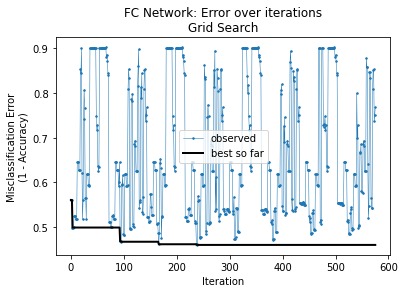

In [23]:
# convergence plot
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("FC Network: Error over iterations\nGrid Search")
plt.legend()

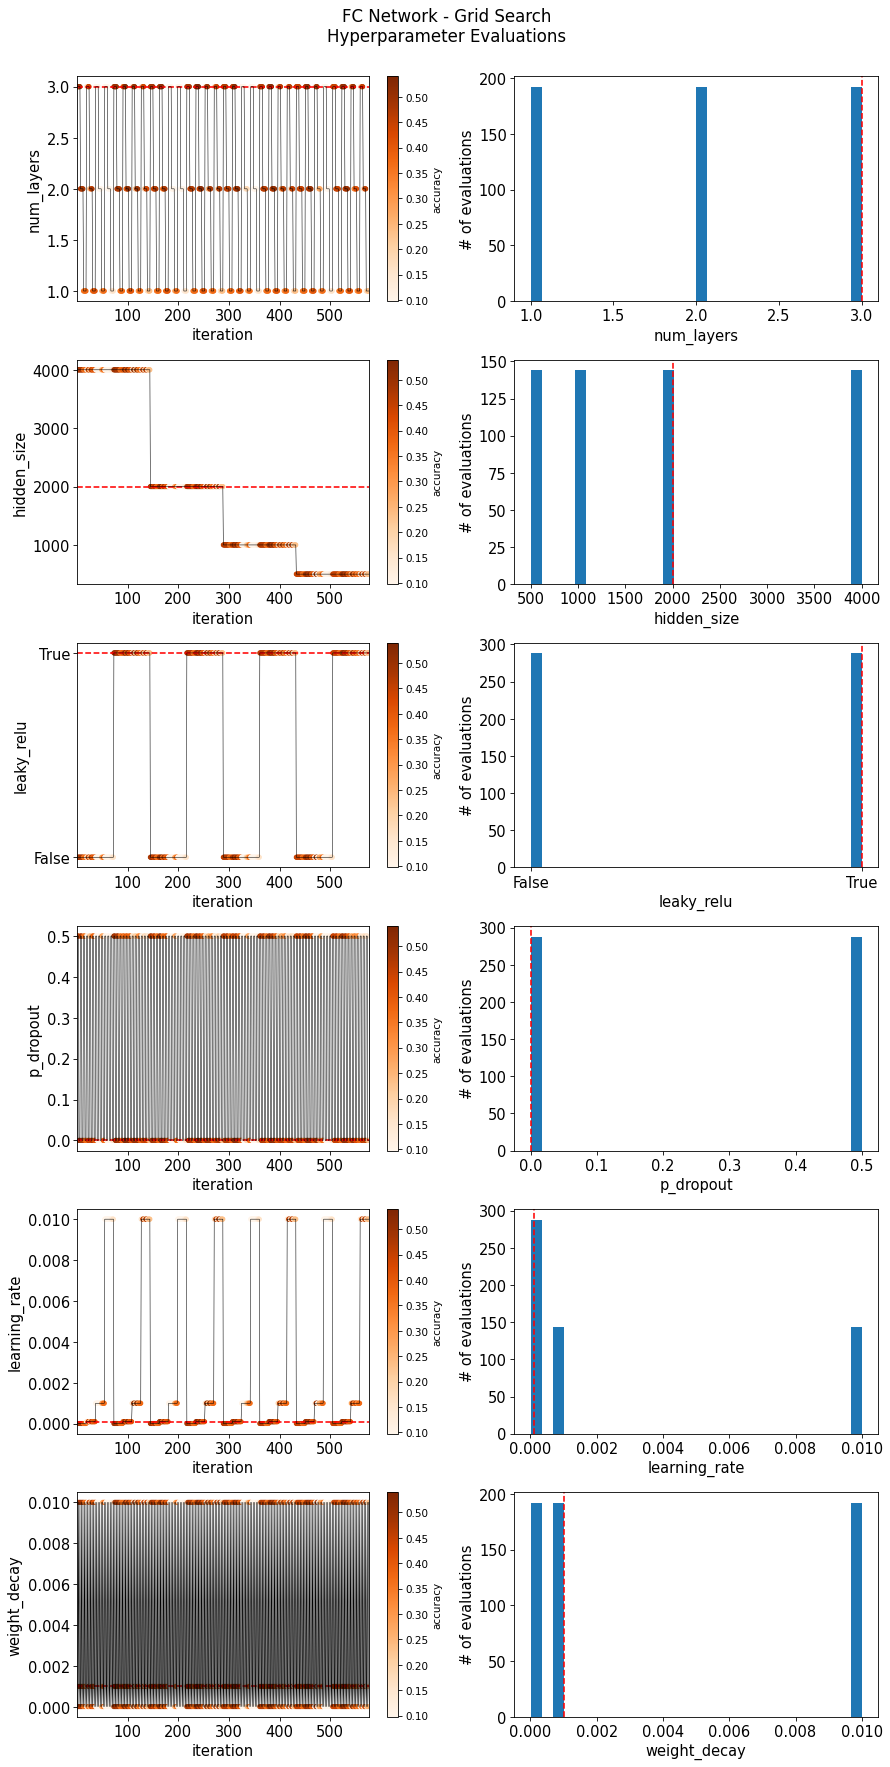

In [24]:
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

params = gs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in gs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = gs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("FC Network - Grid Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.95])

# Random Search

In [25]:
rs_hyperparameters = {
    'num_layers': range(1, 3+1),
    'hidden_size': range(500, 4001, 250),
    'leaky_relu': [False, True],
    'p_dropout': [0.5, 0.25, 0.0],  # 0 = same as no dropout
    'learning_rate': list(np.logspace(-6, -2, num=20)),
    'weight_decay': list(np.logspace(-5, -2, num=10))
}

N_EVALS = 576  # same number as were used in grid search

In [26]:
np.random.seed(682)
clf = FCNetClassifier(n_epochs=N_EPOCHS, loader_val=loader_val)

rs = RandomizedSearchCV(clf,
                        param_distributions=rs_hyperparameters,
                        n_iter=N_EVALS,
                        scoring=_custom_scorer,
                        cv=presplit,
                        refit=False,
                        verbose=5, 
                        n_jobs=1,
                        random_state=682)

print('\n--------------------------------------\nBeginning random search at {}...'.format(datetime.now().strftime('%H:%M:%S')))

rs.fit(x_train_full, y_train_full)

print("")
rs_results = []
for i in range(len(rs.cv_results_['params'])):
    result = {'params' : rs.cv_results_['params'][i], 
              'mean_metric' : rs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': rs.cv_results_['mean_fit_time'][i],
              'mean_score_time': rs.cv_results_['mean_score_time'][i]}
    rs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']))


print('\n\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))

the_time = datetime.now().strftime('%Y%m%d_%H%M%S')
for obj, obj_name in [(rs_results, 'rs_results'), (rs, 'rs')]:
    with open(f'fcnet_{obj_name}_{the_time}.pkl', 'wb') as f:
        pickle.dump(obj, f)

print('\nFinished random search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))


--------------------------------------
Beginning random search at 15:15:08...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 576 candidates, totalling 576 fits
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477c50>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3071038722991943, accuracy = 8.98%
        Epoch 1, iteration 200: loss = 2.1385014057159424, accuracy = 32.23%
        Epoch 1, iteration 400: loss = 1.9982658624649048, accuracy = 36.3%
        Epoch 1, iteration 600: loss = 2.098196029663086, accuracy = 38.33%
        End of Epoch 1: accuracy = 40.09%
        Epoch 2, iteration 1: loss = 1.9580068588256836, accuracy = 40.13%
        Epoch 2, iteration 200: loss = 2.0764012336730957, accuracy = 41.4%
        Epoch 2, iteration 400: loss = 2.019008159637451, accuracy = 42.65%
        Epoch 2, iteration 600: loss = 1.8794922828674316, accuracy = 43.65%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=2250, score=0.459, total=   9.9s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3438>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.344792604446411, accuracy = 18.73%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2500, score=0.100, total=   7.0s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4dc828>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.272379159927368, accuracy = 14.07%
        Epoch 1, iteration 200: loss = 2.201709032058716, accuracy = 34.97%
        Epoch 1, iteration 400: loss = 1.9650189876556396, accuracy = 37.69%
        Epoch 1, iteration 600: loss = 1.8200815916061401, accuracy = 40.05%
        End of Epoch 1: accuracy = 40.95%
        Epoch 2, iteration 1: loss = 1.926871418952942, accuracy = 40.87%
        Epoch 2, iteration 200: loss = 2.0188283920288086, accuracy = 42.62%
        Epoch 2, iteration 400: loss = 2.1266069412231445, accuracy = 43.0%
        Epoch 2, iteration 600: loss = 1.8277531862258911, accuracy = 43.3%
       

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2750, score=0.457, total=   7.4s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7afac8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 14.16%
        Epoch 1, iteration 200: loss = 2.082339286804199, accuracy = 30.05%
        Epoch 1, iteration 400: loss = 2.032639980316162, accuracy = 30.23%
        Epoch 1, iteration 600: loss = 2.6995036602020264, accuracy = 30.06%
        End of Epoch 1: accuracy = 29.89%
        Epoch 2, iteration 1: loss = 2.149104118347168, accuracy = 28.94%
        Epoch 2, iteration 200: loss = 2.1822330951690674, accuracy = 31.38%
        Epoch 2, iteration 400: loss = 2.34721040725708, accuracy = 30.09%
        Epoch 2, iteration 600: loss = 2.251659631729126, accuracy = 30.92%
        End of Epoch 2: a

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1000, score=0.315, total=   5.8s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0181438>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.340205192565918, accuracy = 11.83%
        Epoch 1, iteration 200: loss = 17.036840438842773, accuracy = 13.09%
        Epoch 1, iteration 400: loss = 29.689409255981445, accuracy = 14.8%
        Epoch 1, iteration 600: loss = 49.603271484375, accuracy = 17.56%
        End of Epoch 1: accuracy = 14.61%
        Epoch 2, iteration 1: loss = 38.71456527709961, accuracy = 14.14%
        Epoch 2, iteration 200: loss = 23.013723373413086, accuracy = 16.58%
        Epoch 2, iteration 400: loss = 61.718292236328125, accuracy = 13.43%
        Epoch 2, iteration 600: loss = 36.207672119140625, accuracy = 17.74%
        End of Epoch 2: accuracy = 13.17%
  

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=3500, score=0.127, total=   8.5s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d486358>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3204381465911865, accuracy = 13.44%
        Epoch 1, iteration 200: loss = 1.6570028066635132, accuracy = 42.59%
        Epoch 1, iteration 400: loss = 1.846233606338501, accuracy = 45.64%
        Epoch 1, iteration 600: loss = 1.6201262474060059, accuracy = 46.16%
        End of Epoch 1: accuracy = 47.2%
        Epoch 2, iteration 1: loss = 1.554284691810608, accuracy = 47.42%
        Epoch 2, iteration 200: loss = 1.5353065729141235, accuracy = 48.45%
        Epoch 2, iteration 400: loss = 1.4235997200012207, accuracy = 49.26%
        Epoch 2, iteration 600: loss = 1.5464657545089722, accuracy = 49.49%
        End of Epoch 2

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3750, score=0.514, total=   9.3s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6198>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.05%
        Epoch 1, iteration 200: loss = 2.94891357421875, accuracy = 14.79%
        Epoch 1, iteration 400: loss = 2.5120460987091064, accuracy = 18.95%
        Epoch 1, iteration 600: loss = 2.8834385871887207, accuracy = 16.64%
        End of Epoch 1: accuracy = 19.67%
        Epoch 2, iteration 1: loss = 2.350759744644165, accuracy = 19.09%
        Epoch 2, iteration 200: loss = 2.832113027572632, accuracy = 17.73%
        Epoch 2, iteration 400: loss = 2.6018154621124268, accuracy = 18.83%
        Epoch 2, iteration 600: loss = 2.4278628826141357, accuracy = 17.0%
        E

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=1500, score=0.167, total=   6.0s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3066678047180176, accuracy = 13.68%
        Epoch 1, iteration 200: loss = 1.8676269054412842, accuracy = 35.32%
        Epoch 1, iteration 400: loss = 1.6427099704742432, accuracy = 42.53%
        Epoch 1, iteration 600: loss = 1.789932370185852, accuracy = 40.52%
        End of Epoch 1: accuracy = 43.8%
        Epoch 2, iteration 1: loss = 1.5131326913833618, accuracy = 44.41%
        Epoch 2, iteration 200: loss = 1.5474305152893066, accuracy = 46.84%
        Epoch 2, iteration 400: loss = 1.710528016090393, accuracy = 44.91%
        Epoch 2, iteration 600: loss = 1.4506629705429077, accuracy = 45.24%
        End of Epoch 2: 

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=2250, score=0.494, total=   9.8s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4f2860>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.281050205230713, accuracy = 15.3%
        Epoch 1, iteration 200: loss = 2.2462782859802246, accuracy = 23.65%
        Epoch 1, iteration 400: loss = 2.2086243629455566, accuracy = 28.7%
        Epoch 1, iteration 600: loss = 2.187297821044922, accuracy = 28.74%
        End of Epoch 1: accuracy = 31.96%
        Epoch 2, iteration 1: loss = 2.092587947845459, accuracy = 32.22%
        Epoch 2, iteration 200: loss = 2.200005531311035, accuracy = 31.29%
        Epoch 2, iteration 400: loss = 2.2035815715789795, accuracy = 34.07%
        Epoch 2, iteration 600: loss = 2.03842830657959, accuracy = 34.36%
        En

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1500, score=0.353, total=   7.0s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d538f98>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.296177625656128, accuracy = 10.15%
        Epoch 1, iteration 200: loss = 2.194563388824463, accuracy = 33.31%
        Epoch 1, iteration 400: loss = 2.075059652328491, accuracy = 38.28%
        Epoch 1, iteration 600: loss = 2.093827724456787, accuracy = 40.16%
        End of Epoch 1: accuracy = 41.59%
        Epoch 2, iteration 1: loss = 2.148670196533203, accuracy = 41.63%
        Epoch 2, iteration 200: loss = 2.079078197479248, accuracy = 42.42%
        Epoch 2, iteration 400: loss = 2.104794502258301, accuracy = 43.12%
        Epoch 2, iteration 600: loss = 2.0383284091949463, accuracy = 43.51%
        E

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=2750, score=0.458, total=  12.6s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d59f588>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3204381465911865, accuracy = 16.28%
        Epoch 1, iteration 200: loss = 1.8894236087799072, accuracy = 39.64%
        Epoch 1, iteration 400: loss = 1.8270577192306519, accuracy = 42.64%
        Epoch 1, iteration 600: loss = 1.8164958953857422, accuracy = 45.28%
        End of Epoch 1: accuracy = 45.9%
        Epoch 2, iteration 1: loss = 1.6837924718856812, accuracy = 44.94%
        Epoch 2, iteration 200: loss = 1.6246410608291626, accuracy = 48.38%
        Epoch 2, iteration 400: loss = 1.4818143844604492, accuracy = 46.63%
        Epoch 2, iteration 600: loss = 1.792259931564331, accuracy = 48.36%
        End of Epoch 2

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3750, score=0.510, total=   9.3s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d486358>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.315669536590576, accuracy = 16.55%
        Epoch 1, iteration 200: loss = 1.972318410873413, accuracy = 36.24%
        Epoch 1, iteration 400: loss = 1.7138259410858154, accuracy = 40.82%
        Epoch 1, iteration 600: loss = 1.6787924766540527, accuracy = 42.24%
        End of Epoch 1: accuracy = 42.35%
        Epoch 2, iteration 1: loss = 1.6884527206420898, accuracy = 42.6%
        Epoch 2, iteration 200: loss = 1.4273697137832642, accuracy = 45.61%
        Epoch 2, iteration 400: loss = 1.3766478300094604, accuracy = 46.77%
        Epoch 2, iteration 600: loss = 1.6564795970916748, accuracy = 45.21%
        

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=3500, score=0.478, total=   8.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4474e0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2890281677246094, accuracy = 13.47%
        Epoch 1, iteration 200: loss = 1.8587278127670288, accuracy = 36.45%
        Epoch 1, iteration 400: loss = 2.0608274936676025, accuracy = 38.25%
        Epoch 1, iteration 600: loss = 2.023682117462158, accuracy = 38.83%
        End of Epoch 1: accuracy = 40.35%
        Epoch 2, iteration 1: loss = 1.7918758392333984, accuracy = 40.33%
        Epoch 2, iteration 200: loss = 1.995548963546753, accuracy = 41.64%
        Epoch 2, iteration 400: loss = 2.022756338119507, accuracy = 42.46%
        Epoch 2, iteration 600: loss = 1.6360046863555908, accuracy = 43.7%
     

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=1250, score=0.436, total=   7.1s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81c7860>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.32%
        Epoch 1, iteration 200: loss = 2.959554433822632, accuracy = 20.95%
        Epoch 1, iteration 400: loss = 3.3279170989990234, accuracy = 19.84%
        Epoch 1, iteration 600: loss = 4.518838405609131, accuracy = 22.33%
        End of Epoch 1: accuracy = 19.63%
        Epoch 2, iteration 1: loss = 2.5902040004730225, accuracy = 19.88%
        Epoch 2, iteration 200: loss = 3.654797077178955, accuracy = 20.51%
        Epoch 2, iteration 400: loss = 3.1700761318206787, accuracy = 18.02%
        Epoch 2, iteration 600: loss = 2.36336612701416, accuracy = 22.11%
        En

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=750, score=0.198, total=   5.8s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec9412ba8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3206183910369873, accuracy = 13.91%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2500, score=0.100, total=  10.9s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4f2860>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.288875102996826, accuracy = 13.61%
        Epoch 1, iteration 200: loss = 6.689552307128906, accuracy = 21.42%
        Epoch 1, iteration 400: loss = 7.594802379608154, accuracy = 13.52%
        Epoch 1, iteration 600: loss = 6.700443744659424, accuracy = 16.17%
        End of Epoch 1: accuracy = 15.45%
        Epoch 2, iteration 1: loss = 9.13360595703125, accuracy = 14.81%
        Epoch 2, iteration 200: loss = 9.945162773132324, accuracy = 12.14%
        Epoch 2, iteration 400: loss = 13.390398979187012, accuracy = 14.59%
        Epoch 2, iteration 600: loss = 9.679821968078613, accuracy = 15.67%
        End of Epoch 2: accuracy = 13.44%
 

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=1250, score=0.131, total=   6.9s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7afac8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.322253942489624, accuracy = 9.11%
        Epoch 1, iteration 200: loss = 2.2320570945739746, accuracy = 26.96%
        Epoch 1, iteration 400: loss = 2.2703990936279297, accuracy = 32.26%
        Epoch 1, iteration 600: loss = 2.01834774017334, accuracy = 35.19%
        End of Epoch 1: accuracy = 36.26%
        Epoch 2, iteration 1: loss = 2.2471799850463867, accuracy = 36.27%
        Epoch 2, iteration 200: loss = 2.1790897846221924, accuracy = 37.8%
        Epoch 2, iteration 400: loss = 2.0997445583343506, accuracy = 38.58%
        Epoch 2, iteration 600: loss = 2.122393846511841, accuracy = 39.62%
        En

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3750, score=0.423, total=   9.3s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a00b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.315336227416992, accuracy = 13.72%
        Epoch 1, iteration 200: loss = 1.8353502750396729, accuracy = 40.48%
        Epoch 1, iteration 400: loss = 1.8291558027267456, accuracy = 43.11%
        Epoch 1, iteration 600: loss = 1.626905083656311, accuracy = 45.3%
        End of Epoch 1: accuracy = 45.54%
        Epoch 2, iteration 1: loss = 1.6083468198776245, accuracy = 45.45%
        Epoch 2, iteration 200: loss = 1.3568392992019653, accuracy = 47.42%
        Epoch 2, iteration 400: loss = 1.3420929908752441, accuracy = 47.98%
        Epoch 2, iteration 600: loss = 1.5303080081939697, accuracy = 48.28%
      

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3500, score=0.503, total=   8.5s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d508470>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 14.41%
        Epoch 1, iteration 200: loss = 1.827478289604187, accuracy = 35.93%
        Epoch 1, iteration 400: loss = 1.7623969316482544, accuracy = 36.15%
        Epoch 1, iteration 600: loss = 2.0760245323181152, accuracy = 36.55%
        End of Epoch 1: accuracy = 37.53%
        Epoch 2, iteration 1: loss = 1.7850847244262695, accuracy = 37.55%
        Epoch 2, iteration 200: loss = 1.828334093093872, accuracy = 36.89%
        Epoch 2, iteration 400: loss = 1.7375961542129517, accuracy = 38.04%
        Epoch 2, iteration 600: loss = 1.7536725997924805, accuracy = 37.48%
    

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1500, score=0.376, total=   5.5s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6a90>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.302962064743042, accuracy = 15.93%
        Epoch 1, iteration 200: loss = 1.61248779296875, accuracy = 40.88%
        Epoch 1, iteration 400: loss = 1.5733201503753662, accuracy = 44.47%
        Epoch 1, iteration 600: loss = 1.5898059606552124, accuracy = 46.06%
        End of Epoch 1: accuracy = 47.48%
        Epoch 2, iteration 1: loss = 1.3247764110565186, accuracy = 47.65%
        Epoch 2, iteration 200: loss = 1.3678719997406006, accuracy = 48.65%
        Epoch 2, iteration 400: loss = 1.532667875289917, accuracy = 50.21%
        Epoch 2, iteration 600: loss = 1.5132235288619995, accuracy = 49.48%
        End of Epoch 2

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1750, score=0.521, total=   8.1s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d5b9fd0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.2937915325164795, accuracy = 12.97%
        Epoch 1, iteration 200: loss = 1.6594732999801636, accuracy = 40.68%
        Epoch 1, iteration 400: loss = 1.642796277999878, accuracy = 45.12%
        Epoch 1, iteration 600: loss = 1.6856032609939575, accuracy = 47.05%
        End of Epoch 1: accuracy = 47.82%
        Epoch 2, iteration 1: loss = 1.2701071500778198, accuracy = 48.05%
        Epoch 2, iteration 200: loss = 1.4356577396392822, accuracy = 49.18%
        Epoch 2, iteration 400: loss = 1.3798249959945679, accuracy = 50.37%
        Epoch 2, iteration 600: loss = 1.4816398620605469, accuracy = 50.52%
  

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3500, score=0.526, total=  16.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8320>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 2.1646859645843506, accuracy = 33.63%
        Epoch 1, iteration 400: loss = 1.9769779443740845, accuracy = 34.26%
        Epoch 1, iteration 600: loss = 2.362431526184082, accuracy = 35.3%
        End of Epoch 1: accuracy = 35.71%
        Epoch 2, iteration 1: loss = 2.004302740097046, accuracy = 35.57%
        Epoch 2, iteration 200: loss = 2.162588119506836, accuracy = 35.9%
        Epoch 2, iteration 400: loss = 2.1337058544158936, accuracy = 36.31%
        Epoch 2, iteration 600: loss = 2.1793625354766846, accuracy = 37.36%
        End

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=750, score=0.366, total=   5.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d486358>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2937915325164795, accuracy = 13.0%
        Epoch 1, iteration 200: loss = 1.9147566556930542, accuracy = 39.66%
        Epoch 1, iteration 400: loss = 1.80194890499115, accuracy = 43.82%
        Epoch 1, iteration 600: loss = 1.7164082527160645, accuracy = 45.53%
        End of Epoch 1: accuracy = 47.89%
        Epoch 2, iteration 1: loss = 1.2411816120147705, accuracy = 47.78%
        Epoch 2, iteration 200: loss = 1.4153788089752197, accuracy = 49.57%
        Epoch 2, iteration 400: loss = 1.3458123207092285, accuracy = 50.73%
        Epoch 2, iteration 600: loss = 1.4753369092941284, accuracy = 50.95%
     

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3500, score=0.530, total=  16.6s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d59f588>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 9.07%
        Epoch 1, iteration 200: loss = 1.9972108602523804, accuracy = 32.79%
        Epoch 1, iteration 400: loss = 1.9450383186340332, accuracy = 35.32%
        Epoch 1, iteration 600: loss = 2.2451837062835693, accuracy = 36.65%
        End of Epoch 1: accuracy = 37.52%
        Epoch 2, iteration 1: loss = 1.9160583019256592, accuracy = 37.49%
        Epoch 2, iteration 200: loss = 1.9942264556884766, accuracy = 38.17%
        Epoch 2, iteration 400: loss = 1.9714878797531128, accuracy = 38.76%
        Epoch 2, iteration 600: loss = 1.8844108581542969, accuracy = 38.97%
    

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1000, score=0.397, total=   5.8s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d538f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3097875118255615, accuracy = 14.67%
        Epoch 1, iteration 200: loss = 2.3018367290496826, accuracy = 21.62%
        Epoch 1, iteration 400: loss = 2.25565505027771, accuracy = 19.63%
        Epoch 1, iteration 600: loss = 2.5140979290008545, accuracy = 16.76%
        End of Epoch 1: accuracy = 19.73%
        Epoch 2, iteration 1: loss = 2.4739491939544678, accuracy = 19.31%
        Epoch 2, iteration 200: loss = 2.2682607173919678, accuracy = 19.02%
        Epoch 2, iteration 400: loss = 2.648517608642578, accuracy = 21.01%
        Epoch 2, iteration 600: loss = 2.3827946186065674, accuracy = 20.25%
        End of Epoch 2: a

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=750, score=0.243, total=   7.0s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d538f98>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 17.71%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        En

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=2000, score=0.100, total=   8.8s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d5b9fd0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 9.32%
        Epoch 1, iteration 200: loss = 1.9439903497695923, accuracy = 34.31%
        Epoch 1, iteration 400: loss = 1.9145644903182983, accuracy = 36.65%
        Epoch 1, iteration 600: loss = 2.256272554397583, accuracy = 37.18%
        End of Epoch 1: accuracy = 37.83%
        Epoch 2, iteration 1: loss = 1.8799493312835693, accuracy = 37.8%
        Epoch 2, iteration 200: loss = 1.9780429601669312, accuracy = 38.89%
        Epoch 2, iteration 400: loss = 1.9585410356521606, accuracy = 39.08%
        Epoch 2, iteration 600: loss = 1.8944320678710938, accuracy = 39.14%
     

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=1000, score=0.397, total=   5.7s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d44b898>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.294217824935913, accuracy = 11.97%
        Epoch 1, iteration 200: loss = 2.016294002532959, accuracy = 40.86%
        Epoch 1, iteration 400: loss = 1.97896146774292, accuracy = 42.56%
        Epoch 1, iteration 600: loss = 2.013524055480957, accuracy = 44.64%
        End of Epoch 1: accuracy = 44.87%
        Epoch 2, iteration 1: loss = 1.7495568990707397, accuracy = 44.65%
        Epoch 2, iteration 200: loss = 1.9286727905273438, accuracy = 47.51%
        Epoch 2, iteration 400: loss = 2.0042037963867188, accuracy = 48.64%
        Epoch 2, iteration 600: loss = 1.7912547588348389, accuracy = 49.81%
     

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3500, score=0.517, total=  16.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d5b10b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3059024810791016, accuracy = 9.75%
        Epoch 1, iteration 200: loss = 2.2435426712036133, accuracy = 31.36%
        Epoch 1, iteration 400: loss = 2.0102436542510986, accuracy = 34.92%
        Epoch 1, iteration 600: loss = 2.0615079402923584, accuracy = 37.1%
        End of Epoch 1: accuracy = 38.57%
        Epoch 2, iteration 1: loss = 1.872912883758545, accuracy = 38.5%
        Epoch 2, iteration 200: loss = 1.8975688219070435, accuracy = 39.7%
        Epoch 2, iteration 400: loss = 1.9559649229049683, accuracy = 40.26%
        Epoch 2, iteration 600: loss = 1.8933149576187134, accuracy = 41.15%
       

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3250, score=0.435, total=  15.3s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d44bd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.201841354370117, accuracy = 19.01%
        Epoch 1, iteration 400: loss = 3.88474702835083, accuracy = 16.72%
        Epoch 1, iteration 600: loss = 4.839323043823242, accuracy = 15.98%
        End of Epoch 1: accuracy = 15.58%
        Epoch 2, iteration 1: loss = 5.204588413238525, accuracy = 15.27%
        Epoch 2, iteration 200: loss = 4.155919551849365, accuracy = 17.45%
        Epoch 2, iteration 400: loss = 5.659858703613281, accuracy = 13.97%
        Epoch 2, iteration 600: loss = 3.220526933670044, accuracy = 16.52%
        End of Epoch 2: accuracy = 15.0%
    

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=3250, score=0.159, total=   5.6s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3908>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 6.155717849731445, accuracy = 11.4%
        Epoch 1, iteration 400: loss = 6.016445159912109, accuracy = 13.75%
        Epoch 1, iteration 600: loss = 6.412431716918945, accuracy = 14.34%
        End of Epoch 1: accuracy = 13.14%
        Epoch 2, iteration 1: loss = 4.472039699554443, accuracy = 12.41%
        Epoch 2, iteration 200: loss = 3.861905097961426, accuracy = 15.01%
        Epoch 2, iteration 400: loss = 4.688714981079102, accuracy = 9.21%
        Epoch 2, iteration 600: loss = 3.4770846366882324, accuracy = 11.03%
        End of Epoch 2: accu

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=3750, score=0.100, total=   5.7s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d6a90>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 12.64%
        Epoch 1, iteration 200: loss = 1.6442867517471313, accuracy = 41.94%
        Epoch 1, iteration 400: loss = 1.6313090324401855, accuracy = 43.67%
        Epoch 1, iteration 600: loss = 1.6577670574188232, accuracy = 46.56%
        End of Epoch 1: accuracy = 48.06%
        Epoch 2, iteration 1: loss = 1.4431113004684448, accuracy = 47.85%
        Epoch 2, iteration 200: loss = 1.3136053085327148, accuracy = 49.09%
        Epoch 2, iteration 400: loss = 1.4390263557434082, accuracy = 49.88%
        Epoch 2, iteration 600: loss = 1.4783138036727905, accuracy = 51.39%
   

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=1000, score=0.519, total=   8.0s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec01d7cc0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.294349193572998, accuracy = 13.0%
        Epoch 1, iteration 200: loss = 2.374286651611328, accuracy = 12.15%
        Epoch 1, iteration 400: loss = 2.3136303424835205, accuracy = 14.24%
        Epoch 1, iteration 600: loss = 2.2511351108551025, accuracy = 16.05%
        End of Epoch 1: accuracy = 14.93%
        Epoch 2, iteration 1: loss = 2.2454850673675537, accuracy = 14.91%
        Epoch 2, iteration 200: loss = 2.250600576400757, accuracy = 16.73%
        Epoch 2, iteration 400: loss = 2.2470085620880127, accuracy = 16.57%
        Epoch 2, iteration 600: loss = 2.2429890632629395, accuracy = 17.22%
        End of Epoch 2

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3000, score=0.173, total=  13.7s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80fec88>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3008017539978027, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.276366710662842, accuracy = 26.05%
        Epoch 1, iteration 400: loss = 2.155930757522583, accuracy = 30.08%
        Epoch 1, iteration 600: loss = 2.2580690383911133, accuracy = 32.65%
        End of Epoch 1: accuracy = 34.26%
        Epoch 2, iteration 1: loss = 2.1326487064361572, accuracy = 34.22%
        Epoch 2, iteration 200: loss = 2.1517834663391113, accuracy = 36.25%
        Epoch 2, iteration 400: loss = 2.2366514205932617, accuracy = 37.81%
        Epoch 2, iteration 600: loss = 2.144155502319336, accuracy = 38.31%
        End of Epoch 2

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2250, score=0.411, total=   9.8s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d508470>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.929670810699463, accuracy = 35.66%
        Epoch 1, iteration 400: loss = 1.894453763961792, accuracy = 36.97%
        Epoch 1, iteration 600: loss = 2.2494618892669678, accuracy = 37.59%
        End of Epoch 1: accuracy = 37.93%
        Epoch 2, iteration 1: loss = 1.8631548881530762, accuracy = 37.75%
        Epoch 2, iteration 200: loss = 1.9858815670013428, accuracy = 39.36%
        Epoch 2, iteration 400: loss = 1.954343557357788, accuracy = 38.97%
        Epoch 2, iteration 600: loss = 1.9024194478988647, accuracy = 39.59%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=750, score=0.401, total=   5.7s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0181438>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.358450412750244, accuracy = 18.12%
        Epoch 1, iteration 200: loss = 2.3030283451080322, accuracy = 11.63%
        Epoch 1, iteration 400: loss = 2.3040008544921875, accuracy = 12.04%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 11.88%
        End of Epoch 1: accuracy = 10.7%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.7%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.75%
        Epoch 2, iteration 400: loss = 2.3063910007476807, accuracy = 10.78%
        Epoch 2, iteration 600: loss = 2.303565740585327, accuracy = 11.76%
        End of Epoch 2

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=2500, score=0.124, total=   7.0s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d5fcf28>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 13.53%
        Epoch 1, iteration 200: loss = 1.9884426593780518, accuracy = 38.76%
        Epoch 1, iteration 400: loss = 1.9634640216827393, accuracy = 41.72%
        Epoch 1, iteration 600: loss = 2.0643060207366943, accuracy = 43.56%
        End of Epoch 1: accuracy = 43.66%
        Epoch 2, iteration 1: loss = 2.0612361431121826, accuracy = 43.39%
        Epoch 2, iteration 200: loss = 2.1954782009124756, accuracy = 45.54%
        Epoch 2, iteration 400: loss = 1.9520647525787354, accuracy = 45.95%
        Epoch 2, iteration 600: loss = 2.0837454795837402, accuracy = 46.03%
   

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1000, score=0.483, total=   7.1s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a00b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2890281677246094, accuracy = 13.09%
        Epoch 1, iteration 200: loss = 2.069086790084839, accuracy = 32.26%
        Epoch 1, iteration 400: loss = 2.0414557456970215, accuracy = 36.36%
        Epoch 1, iteration 600: loss = 2.086501121520996, accuracy = 38.34%
        End of Epoch 1: accuracy = 39.36%
        Epoch 2, iteration 1: loss = 1.9631787538528442, accuracy = 39.29%
        Epoch 2, iteration 200: loss = 2.0036234855651855, accuracy = 40.31%
        Epoch 2, iteration 400: loss = 1.9335041046142578, accuracy = 41.6%
        Epoch 2, iteration 600: loss = 1.835770845413208, accuracy = 41.93%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=1250, score=0.444, total=   7.1s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.36%
        Epoch 1, iteration 200: loss = 1.8926892280578613, accuracy = 35.39%
        Epoch 1, iteration 400: loss = 1.787179946899414, accuracy = 37.39%
        Epoch 1, iteration 600: loss = 1.9569019079208374, accuracy = 37.8%
        End of Epoch 1: accuracy = 38.77%
        Epoch 2, iteration 1: loss = 1.731603980064392, accuracy = 38.69%
        Epoch 2, iteration 200: loss = 1.834404706954956, accuracy = 38.71%
        Epoch 2, iteration 400: loss = 1.7245863676071167, accuracy = 39.35%
        Epoch 2, iteration 600: loss = 1.805964708328247, accuracy = 39.91%
        En

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=2250, score=0.405, total=   5.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d52b978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.37%
        Epoch 1, iteration 200: loss = 4.88509464263916, accuracy = 15.18%
        Epoch 1, iteration 400: loss = 4.475407600402832, accuracy = 13.57%
        Epoch 1, iteration 600: loss = 4.497319221496582, accuracy = 15.8%
        End of Epoch 1: accuracy = 19.05%
        Epoch 2, iteration 1: loss = 3.855492115020752, accuracy = 18.11%
        Epoch 2, iteration 200: loss = 3.0374207496643066, accuracy = 18.97%
        Epoch 2, iteration 400: loss = 2.6679322719573975, accuracy = 15.33%
        Epoch 2, iteration 600: loss = 3.422140598297119, accuracy = 17.43%
        End of Ep

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=500, score=0.143, total=   5.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d8320>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.79%
        Epoch 1, iteration 200: loss = 2.1705994606018066, accuracy = 33.1%
        Epoch 1, iteration 400: loss = 1.9608267545700073, accuracy = 35.65%
        Epoch 1, iteration 600: loss = 2.3389458656311035, accuracy = 35.38%
        End of Epoch 1: accuracy = 37.15%
        Epoch 2, iteration 1: loss = 1.9820802211761475, accuracy = 37.04%
        Epoch 2, iteration 200: loss = 2.1181087493896484, accuracy = 36.88%
        Epoch 2, iteration 400: loss = 2.113039970397949, accuracy = 38.06%
        Epoch 2, iteration 600: loss = 2.0805625915527344, accuracy = 38.99%
     

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2750, score=0.377, total=   5.6s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0175dd8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 11.31%
        Epoch 1, iteration 200: loss = 2.136291265487671, accuracy = 37.72%
        Epoch 1, iteration 400: loss = 1.9519351720809937, accuracy = 41.27%
        Epoch 1, iteration 600: loss = 2.0690786838531494, accuracy = 43.41%
        End of Epoch 1: accuracy = 44.48%
        Epoch 2, iteration 1: loss = 1.8392348289489746, accuracy = 44.31%
        Epoch 2, iteration 200: loss = 2.026608467102051, accuracy = 45.1%
        Epoch 2, iteration 400: loss = 1.9576373100280762, accuracy = 46.12%
        Epoch 2, iteration 600: loss = 2.0418999195098877, accuracy = 46.59%
       

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=500, score=0.481, total=   8.2s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d453ba8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.87%
        Epoch 1, iteration 200: loss = 2.771699905395508, accuracy = 19.72%
        Epoch 1, iteration 400: loss = 3.450206995010376, accuracy = 16.26%
        Epoch 1, iteration 600: loss = 3.631120443344116, accuracy = 18.08%
        End of Epoch 1: accuracy = 17.37%
        Epoch 2, iteration 1: loss = 3.291809558868408, accuracy = 17.3%
        Epoch 2, iteration 200: loss = 3.453223943710327, accuracy = 17.82%
        Epoch 2, iteration 400: loss = 4.012142181396484, accuracy = 15.86%
        Epoch 2, iteration 600: loss = 2.984025239944458, accuracy = 17.81%
        End o

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=3000, score=0.170, total=   5.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d508470>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2849667072296143, accuracy = 12.7%
        Epoch 1, iteration 200: loss = 3.5768866539001465, accuracy = 14.71%
        Epoch 1, iteration 400: loss = 3.8710663318634033, accuracy = 17.03%
        Epoch 1, iteration 600: loss = 6.039548873901367, accuracy = 12.24%
        End of Epoch 1: accuracy = 12.96%
        Epoch 2, iteration 1: loss = 12.30649471282959, accuracy = 13.18%
        Epoch 2, iteration 200: loss = 7.102565288543701, accuracy = 12.09%
        Epoch 2, iteration 400: loss = 6.099870681762695, accuracy = 16.24%
        Epoch 2, iteration 600: loss = 8.38752269744873, accuracy = 13.65%
        End

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3500, score=0.158, total=  16.6s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d486b00>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3082778453826904, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accura

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2500, score=0.100, total=  10.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0181438>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3167128562927246, accuracy = 14.76%
        Epoch 1, iteration 200: loss = 2.417469024658203, accuracy = 22.8%
        Epoch 1, iteration 400: loss = 2.4146225452423096, accuracy = 19.63%
        Epoch 1, iteration 600: loss = 2.653144359588623, accuracy = 24.4%
        End of Epoch 1: accuracy = 25.7%
        Epoch 2, iteration 1: loss = 2.587984800338745, accuracy = 25.58%
        Epoch 2, iteration 200: loss = 2.8158986568450928, accuracy = 22.57%
        Epoch 2, iteration 400: loss = 2.4545233249664307, accuracy = 25.6%
        Epoch 2, iteration 600: loss = 2.3082611560821533, accuracy = 28.94%
        End of Epoch 2: a

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3500, score=0.302, total=   8.5s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d44b898>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 13.74%
        Epoch 1, iteration 200: loss = 1.999882698059082, accuracy = 31.01%
        Epoch 1, iteration 400: loss = 1.4748331308364868, accuracy = 39.2%
        Epoch 1, iteration 600: loss = 1.434525728225708, accuracy = 42.88%
        End of Epoch 1: accuracy = 45.26%
        Epoch 2, iteration 1: loss = 1.4499764442443848, accuracy = 44.88%
        Epoch 2, iteration 200: loss = 1.8894964456558228, accuracy = 44.56%
        Epoch 2, iteration 400: loss = 1.4387712478637695, accuracy = 46.29%
        Epoch 2, iteration 600: loss = 1.5822253227233887, accuracy = 48.43%
       

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=500, score=0.496, total=   8.2s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d52b240>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.302962064743042, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 1.917564034461975, accuracy = 30.95%
        Epoch 1, iteration 400: loss = 1.6711978912353516, accuracy = 37.81%
        Epoch 1, iteration 600: loss = 1.7582226991653442, accuracy = 41.38%
        End of Epoch 1: accuracy = 37.23%
        Epoch 2, iteration 1: loss = 1.5572452545166016, accuracy = 37.02%
        Epoch 2, iteration 200: loss = 1.8965364694595337, accuracy = 38.94%
        Epoch 2, iteration 400: loss = 1.8491449356079102, accuracy = 44.44%
        Epoch 2, iteration 600: loss = 1.6420202255249023, accuracy = 44.88%
        End of Epoch 2

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=1750, score=0.471, total=   8.0s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d486b00>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.79%
        Epoch 1, iteration 200: loss = 2.1705994606018066, accuracy = 33.1%
        Epoch 1, iteration 400: loss = 1.9608267545700073, accuracy = 35.65%
        Epoch 1, iteration 600: loss = 2.3389458656311035, accuracy = 35.38%
        End of Epoch 1: accuracy = 37.15%
        Epoch 2, iteration 1: loss = 1.9820802211761475, accuracy = 37.04%
        Epoch 2, iteration 200: loss = 2.1181087493896484, accuracy = 36.88%
        Epoch 2, iteration 400: loss = 2.113039970397949, accuracy = 38.06%
        Epoch 2, iteration 600: loss = 2.0805625915527344, accuracy = 38.99%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=500, score=0.377, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4aed68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.88%
        Epoch 1, iteration 200: loss = 1.99858820438385, accuracy = 31.31%
        Epoch 1, iteration 400: loss = 1.8719017505645752, accuracy = 35.11%
        Epoch 1, iteration 600: loss = 1.946431040763855, accuracy = 36.38%
        End of Epoch 1: accuracy = 37.17%
        Epoch 2, iteration 1: loss = 1.8228877782821655, accuracy = 37.08%
        Epoch 2, iteration 200: loss = 1.892691969871521, accuracy = 37.56%
        Epoch 2, iteration 400: loss = 1.791847586631775, accuracy = 37.72%
        Epoch 2, iteration 600: loss = 1.8393638134002686, accuracy = 38.55%
        End of Epoch 2: ac

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2500, score=0.393, total=   5.6s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0175dd8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3116564750671387, accuracy = 15.14%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: ac

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3250, score=0.100, total=  15.3s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d447978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.293154239654541, accuracy = 19.03%
        Epoch 1, iteration 200: loss = 2.0301828384399414, accuracy = 29.67%
        Epoch 1, iteration 400: loss = 1.99669349193573, accuracy = 36.12%
        Epoch 1, iteration 600: loss = 1.470192790031433, accuracy = 42.48%
        End of Epoch 1: accuracy = 43.58%
        Epoch 2, iteration 1: loss = 1.5701069831848145, accuracy = 43.66%
        Epoch 2, iteration 200: loss = 1.7553495168685913, accuracy = 44.83%
        Epoch 2, iteration 400: loss = 1.2770779132843018, accuracy = 45.91%
        Epoch 2, iteration 600: loss = 1.4932990074157715, accuracy = 46.44%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3250, score=0.502, total=   8.1s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d48c470>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3160643577575684, accuracy = 9.35%
        Epoch 1, iteration 200: loss = 2.20518159866333, accuracy = 34.01%
        Epoch 1, iteration 400: loss = 2.1357991695404053, accuracy = 35.43%
        Epoch 1, iteration 600: loss = 2.0768089294433594, accuracy = 36.51%
        End of Epoch 1: accuracy = 37.04%
        Epoch 2, iteration 1: loss = 2.0332930088043213, accuracy = 37.08%
        Epoch 2, iteration 200: loss = 2.1421098709106445, accuracy = 37.82%
        Epoch 2, iteration 400: loss = 1.918134093284607, accuracy = 39.99%
        Epoch 2, iteration 600: loss = 2.013758659362793, accuracy = 41.7%
        E

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2000, score=0.455, total=   7.1s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d6bbba8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.254436492919922, accuracy = 18.67%
        Epoch 1, iteration 400: loss = 2.134972095489502, accuracy = 23.28%
        Epoch 1, iteration 600: loss = 2.1351664066314697, accuracy = 25.79%
        End of Epoch 1: accuracy = 27.63%
        Epoch 2, iteration 1: loss = 2.095097303390503, accuracy = 27.63%
        Epoch 2, iteration 200: loss = 2.0504729747772217, accuracy = 29.18%
        Epoch 2, iteration 400: loss = 1.9975106716156006, accuracy = 30.47%
        Epoch 2, iteration 600: loss = 1.9225693941116333, accuracy = 31.42%
       

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=3000, score=0.344, total=   5.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d5b9fd0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.355764389038086, accuracy = 19.95%
        Epoch 1, iteration 200: loss = 1.7397209405899048, accuracy = 40.51%
        Epoch 1, iteration 400: loss = 1.6022857427597046, accuracy = 43.5%
        Epoch 1, iteration 600: loss = 1.453560471534729, accuracy = 46.01%
        End of Epoch 1: accuracy = 45.41%
        Epoch 2, iteration 1: loss = 1.4783642292022705, accuracy = 45.12%
        Epoch 2, iteration 200: loss = 1.2688816785812378, accuracy = 47.42%
        Epoch 2, iteration 400: loss = 1.404812216758728, accuracy = 48.24%
        Epoch 2, iteration 600: loss = 1.4137670993804932, accuracy = 49.25%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2250, score=0.489, total=   6.9s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d586f98>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.297541379928589, accuracy = 14.28%
        Epoch 1, iteration 200: loss = 1.9713460206985474, accuracy = 40.32%
        Epoch 1, iteration 400: loss = 1.8278968334197998, accuracy = 44.25%
        Epoch 1, iteration 600: loss = 1.7983291149139404, accuracy = 45.45%
        End of Epoch 1: accuracy = 46.06%
        Epoch 2, iteration 1: loss = 1.959912896156311, accuracy = 46.03%
        Epoch 2, iteration 200: loss = 1.872719645500183, accuracy = 48.14%
        Epoch 2, iteration 400: loss = 1.8603559732437134, accuracy = 48.74%
        Epoch 2, iteration 600: loss = 1.6229000091552734, accuracy = 49.71%
        End of Epoch 

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2750, score=0.515, total=  12.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d586f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 11.64%
        Epoch 1, iteration 200: loss = 2.106008291244507, accuracy = 29.68%
        Epoch 1, iteration 400: loss = 2.1013870239257812, accuracy = 34.46%
        Epoch 1, iteration 600: loss = 2.13712215423584, accuracy = 36.34%
        End of Epoch 1: accuracy = 37.87%
        Epoch 2, iteration 1: loss = 2.095874786376953, accuracy = 37.85%
        Epoch 2, iteration 200: loss = 2.220564126968384, accuracy = 39.75%
        Epoch 2, iteration 400: loss = 2.0204687118530273, accuracy = 40.79%
        Epoch 2, iteration 600: loss = 2.140885353088379, accuracy = 41.17%
        

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=1000, score=0.439, total=   7.2s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.3265817165374756, accuracy = 10.33%
        Epoch 1, iteration 400: loss = 2.3264689445495605, accuracy = 12.91%
        Epoch 1, iteration 600: loss = 2.3474323749542236, accuracy = 15.3%
        End of Epoch 1: accuracy = 17.19%
        Epoch 2, iteration 1: loss = 2.3494603633880615, accuracy = 17.2%
        Epoch 2, iteration 200: loss = 2.308438301086426, accuracy = 18.53%
        Epoch 2, iteration 400: loss = 2.245474100112915, accuracy = 19.64%
        Epoch 2, iteration 600: loss = 2.142116069793701, accuracy = 20.57%
        End of Epoch 2: ac

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=False, hidden_size=500, score=0.241, total=   5.7s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d53df28>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 17.72%
        Epoch 1, iteration 200: loss = 1.9705407619476318, accuracy = 30.93%
        Epoch 1, iteration 400: loss = 1.9152805805206299, accuracy = 38.65%
        Epoch 1, iteration 600: loss = 1.9538897275924683, accuracy = 42.06%
        End of Epoch 1: accuracy = 43.29%
        Epoch 2, iteration 1: loss = 1.2809187173843384, accuracy = 43.97%
        Epoch 2, iteration 200: loss = 1.4623041152954102, accuracy = 44.78%
        Epoch 2, iteration 400: loss = 1.2298333644866943, accuracy = 46.21%
        Epoch 2, iteration 600: loss = 1.4641244411468506, accuracy = 48.31%
        End of Epoc

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2000, score=0.517, total=   8.8s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46dd30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3204381465911865, accuracy = 16.25%
        Epoch 1, iteration 200: loss = 2.232881546020508, accuracy = 25.62%
        Epoch 1, iteration 400: loss = 2.107085704803467, accuracy = 30.87%
        Epoch 1, iteration 600: loss = 1.8786088228225708, accuracy = 35.04%
        End of Epoch 1: accuracy = 37.27%
        Epoch 2, iteration 1: loss = 1.9570013284683228, accuracy = 37.3%
        Epoch 2, iteration 200: loss = 1.8318878412246704, accuracy = 39.21%
        Epoch 2, iteration 400: loss = 1.6583073139190674, accuracy = 40.16%
        Epoch 2, iteration 600: loss = 1.7426689863204956, accuracy = 43.51%
      

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3750, score=0.481, total=   9.3s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4639e8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.313338279724121, accuracy = 12.85%
        Epoch 1, iteration 200: loss = 2.3242363929748535, accuracy = 26.12%
        Epoch 1, iteration 400: loss = 1.94859778881073, accuracy = 31.28%
        Epoch 1, iteration 600: loss = 1.7346394062042236, accuracy = 37.31%
        End of Epoch 1: accuracy = 40.32%
        Epoch 2, iteration 1: loss = 1.8567878007888794, accuracy = 40.71%
        Epoch 2, iteration 200: loss = 1.544944167137146, accuracy = 43.45%
        Epoch 2, iteration 400: loss = 1.7960439920425415, accuracy = 45.02%
        Epoch 2, iteration 600: loss = 1.5767035484313965, accuracy = 45.9%
        E

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1500, score=0.499, total=   8.1s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d44bd68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.295349597930908, accuracy = 17.38%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End 

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=1750, score=0.100, total=   7.1s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d464390>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.2935867309570312, accuracy = 13.14%
        Epoch 1, iteration 200: loss = 1.8911887407302856, accuracy = 34.35%
        Epoch 1, iteration 400: loss = 1.8357189893722534, accuracy = 38.0%
        Epoch 1, iteration 600: loss = 1.8089656829833984, accuracy = 39.93%
        End of Epoch 1: accuracy = 40.87%
        Epoch 2, iteration 1: loss = 1.7047371864318848, accuracy = 40.94%
        Epoch 2, iteration 200: loss = 1.6483582258224487, accuracy = 41.97%
        Epoch 2, iteration 400: loss = 1.6698124408721924, accuracy = 43.14%
        Epoch 2, iteration 600: loss = 1.7425447702407837, accuracy = 43.42%
    

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=1250, score=0.457, total=   6.9s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0175dd8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 9.07%
        Epoch 1, iteration 200: loss = 1.9972114562988281, accuracy = 32.79%
        Epoch 1, iteration 400: loss = 1.9450377225875854, accuracy = 35.32%
        Epoch 1, iteration 600: loss = 2.2451884746551514, accuracy = 36.65%
        End of Epoch 1: accuracy = 37.51%
        Epoch 2, iteration 1: loss = 1.916031002998352, accuracy = 37.48%
        Epoch 2, iteration 200: loss = 1.994228720664978, accuracy = 38.16%
        Epoch 2, iteration 400: loss = 1.9709914922714233, accuracy = 38.69%
        Epoch 2, iteration 600: loss = 1.8854142427444458, accuracy = 39.01%
        End of Epoch 

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1000, score=0.397, total=   5.7s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=0.01, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0175dd8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2936222553253174, accuracy = 13.52%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=0.01, leaky_relu=False, hidden_size=1250, score=0.100, total=   7.0s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0181438>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3119003772735596, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=4000, score=0.100, total=  20.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.302537679672241, accuracy = 14.09%
        Epoch 1, iteration 200: loss = 2.042520523071289, accuracy = 39.92%
        Epoch 1, iteration 400: loss = 2.120476722717285, accuracy = 43.09%
        Epoch 1, iteration 600: loss = 1.8041486740112305, accuracy = 44.98%
        End of Epoch 1: accuracy = 45.92%
        Epoch 2, iteration 1: loss = 1.6118130683898926, accuracy = 46.03%
        Epoch 2, iteration 200: loss = 1.8377808332443237, accuracy = 47.22%
        Epoch 2, iteration 400: loss = 1.566025733947754, accuracy = 48.21%
        Epoch 2, iteration 600: loss = 1.6708035469055176, accuracy = 47.6%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3250, score=0.511, total=   8.2s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d44b898>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2962827682495117, accuracy = 16.02%
        Epoch 1, iteration 200: loss = 2.1973774433135986, accuracy = 13.42%
        Epoch 1, iteration 400: loss = 2.2128822803497314, accuracy = 17.05%
        Epoch 1, iteration 600: loss = 2.05037522315979, accuracy = 19.19%
        End of Epoch 1: accuracy = 24.97%
        Epoch 2, iteration 1: loss = 2.0057945251464844, accuracy = 24.9%
        Epoch 2, iteration 200: loss = 1.92133367061615, accuracy = 24.23%
        Epoch 2, iteration 400: loss = 1.8929134607315063, accuracy = 24.31%
        Epoch 2, iteration 600: loss = 1.7783561944961548, accuracy = 26.46%
        

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=750, score=0.355, total=   8.1s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a00b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.272379159927368, accuracy = 14.33%
        Epoch 1, iteration 200: loss = 2.1736679077148438, accuracy = 36.92%
        Epoch 1, iteration 400: loss = 1.9099286794662476, accuracy = 39.65%
        Epoch 1, iteration 600: loss = 1.7620183229446411, accuracy = 41.86%
        End of Epoch 1: accuracy = 42.51%
        Epoch 2, iteration 1: loss = 1.9006526470184326, accuracy = 42.51%
        Epoch 2, iteration 200: loss = 1.9999921321868896, accuracy = 44.26%
        Epoch 2, iteration 400: loss = 2.1123900413513184, accuracy = 44.55%
        Epoch 2, iteration 600: loss = 1.7792940139770508, accuracy = 45.0%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=2750, score=0.470, total=   7.4s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d44b898>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.330538511276245, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 2.032137632369995, accuracy = 36.98%
        Epoch 1, iteration 400: loss = 2.066706657409668, accuracy = 40.34%
        Epoch 1, iteration 600: loss = 1.911524772644043, accuracy = 41.99%
        End of Epoch 1: accuracy = 43.68%
        Epoch 2, iteration 1: loss = 1.9351574182510376, accuracy = 43.72%
        Epoch 2, iteration 200: loss = 1.9698222875595093, accuracy = 44.08%
        Epoch 2, iteration 400: loss = 1.959814190864563, accuracy = 44.62%
        Epoch 2, iteration 600: loss = 1.7908227443695068, accuracy = 45.12%
        End of Epoch 2: 

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=4000, score=0.473, total=   9.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d52bcf8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3218984603881836, accuracy = 12.93%
        Epoch 1, iteration 200: loss = 2.275794506072998, accuracy = 26.35%
        Epoch 1, iteration 400: loss = 2.2771341800689697, accuracy = 27.18%
        Epoch 1, iteration 600: loss = 2.1563334465026855, accuracy = 26.76%
        End of Epoch 1: accuracy = 31.75%
        Epoch 2, iteration 1: loss = 2.306710958480835, accuracy = 31.72%
        Epoch 2, iteration 200: loss = 2.212662696838379, accuracy = 30.06%
        Epoch 2, iteration 400: loss = 2.1356170177459717, accuracy = 30.85%
        Epoch 2, iteration 600: loss = 2.1893057823181152, accuracy = 32.6%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=3750, score=0.318, total=   9.3s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7afac8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.704015731811523, accuracy = 19.28%
        Epoch 1, iteration 400: loss = 4.1856513023376465, accuracy = 18.03%
        Epoch 1, iteration 600: loss = 6.626817226409912, accuracy = 16.28%
        End of Epoch 1: accuracy = 17.04%
        Epoch 2, iteration 1: loss = 4.014121055603027, accuracy = 16.29%
        Epoch 2, iteration 200: loss = 4.360795974731445, accuracy = 17.93%
        Epoch 2, iteration 400: loss = 5.737559795379639, accuracy = 15.4%
        Epoch 2, iteration 600: loss = 3.9506747722625732, accuracy = 14.79%
        End of Epoch 2: a

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=3750, score=0.153, total=   5.5s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7afac8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 18.82%
        Epoch 1, iteration 200: loss = 1.8127118349075317, accuracy = 34.12%
        Epoch 1, iteration 400: loss = 1.8225140571594238, accuracy = 37.4%
        Epoch 1, iteration 600: loss = 1.7205913066864014, accuracy = 41.98%
        End of Epoch 1: accuracy = 43.17%
        Epoch 2, iteration 1: loss = 1.7081159353256226, accuracy = 43.14%
        Epoch 2, iteration 200: loss = 1.6033684015274048, accuracy = 44.51%
        Epoch 2, iteration 400: loss = 1.597217082977295, accuracy = 41.1%
        Epoch 2, iteration 600: loss = 1.5476661920547485, accuracy = 45.49%
        End of Epoch 2: 

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=1000, score=0.452, total=   6.8s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d453748>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.296811819076538, accuracy = 13.89%
        Epoch 1, iteration 200: loss = 2.18082857131958, accuracy = 30.83%
        Epoch 1, iteration 400: loss = 1.8676369190216064, accuracy = 36.78%
        Epoch 1, iteration 600: loss = 1.734839916229248, accuracy = 42.35%
        End of Epoch 1: accuracy = 43.3%
        Epoch 2, iteration 1: loss = 1.6420389413833618, accuracy = 42.85%
        Epoch 2, iteration 200: loss = 2.196516513824463, accuracy = 42.41%
        Epoch 2, iteration 400: loss = 1.744162678718567, accuracy = 45.71%
        Epoch 2, iteration 600: loss = 2.037041425704956, accuracy = 46.91%
        End of Epoch 2: accu

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=500, score=0.482, total=   8.3s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d45e898>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 15.07%
        Epoch 1, iteration 200: loss = 1.7578296661376953, accuracy = 38.73%
        Epoch 1, iteration 400: loss = 1.5606099367141724, accuracy = 42.94%
        Epoch 1, iteration 600: loss = 1.5520174503326416, accuracy = 43.25%
        End of Epoch 1: accuracy = 44.53%
        Epoch 2, iteration 1: loss = 1.5919243097305298, accuracy = 44.32%
        Epoch 2, iteration 200: loss = 1.5607750415802002, accuracy = 45.4%
        Epoch 2, iteration 400: loss = 1.5703006982803345, accuracy = 44.73%
        Epoch 2, iteration 600: loss = 1.5541656017303467, accuracy = 46.59%
   

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=4000, score=0.479, total=   9.8s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4aed68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 16.17%
        Epoch 1, iteration 200: loss = 2.1638989448547363, accuracy = 28.72%
        Epoch 1, iteration 400: loss = 2.356947660446167, accuracy = 26.89%
        Epoch 1, iteration 600: loss = 2.484452724456787, accuracy = 27.59%
        End of Epoch 1: accuracy = 29.35%
        Epoch 2, iteration 1: loss = 2.1882288455963135, accuracy = 29.5%
        Epoch 2, iteration 200: loss = 2.07444429397583, accuracy = 30.56%
        Epoch 2, iteration 400: loss = 2.3167037963867188, accuracy = 28.08%
        Epoch 2, iteration 600: loss = 1.987471580505371, accuracy = 27.74%
        End of Epoch 2: acc

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=1000, score=0.293, total=   5.6s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4aed68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.36%
        Epoch 1, iteration 200: loss = 1.892689824104309, accuracy = 35.39%
        Epoch 1, iteration 400: loss = 1.7872716188430786, accuracy = 37.41%
        Epoch 1, iteration 600: loss = 1.9568679332733154, accuracy = 37.81%
        End of Epoch 1: accuracy = 38.76%
        Epoch 2, iteration 1: loss = 1.731463074684143, accuracy = 38.64%
        Epoch 2, iteration 200: loss = 1.8334683179855347, accuracy = 38.74%
        Epoch 2, iteration 400: loss = 1.7247551679611206, accuracy = 39.33%
        Epoch 2, iteration 600: loss = 1.8046574592590332, accuracy = 39.85%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=500, score=0.405, total=   5.6s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0181438>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.315336227416992, accuracy = 17.46%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=3500, score=0.100, total=   8.5s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0181438>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.288926362991333, accuracy = 13.5%
        Epoch 1, iteration 200: loss = 2.0829014778137207, accuracy = 29.49%
        Epoch 1, iteration 400: loss = 2.170386791229248, accuracy = 32.56%
        Epoch 1, iteration 600: loss = 1.936822533607483, accuracy = 35.32%
        End of Epoch 1: accuracy = 37.57%
        Epoch 2, iteration 1: loss = 2.0412824153900146, accuracy = 37.61%
        Epoch 2, iteration 200: loss = 1.9759052991867065, accuracy = 38.91%
        Epoch 2, iteration 400: loss = 1.911970853805542, accuracy = 39.8%
        Epoch 2, iteration 600: loss = 1.9123389720916748, accuracy = 40.62%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1750, score=0.432, total=   7.1s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d45e080>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.05%
        Epoch 1, iteration 200: loss = 3.0547642707824707, accuracy = 13.89%
        Epoch 1, iteration 400: loss = 2.6016623973846436, accuracy = 16.57%
        Epoch 1, iteration 600: loss = 3.079864740371704, accuracy = 15.53%
        End of Epoch 1: accuracy = 18.05%
        Epoch 2, iteration 1: loss = 2.552661180496216, accuracy = 18.62%
        Epoch 2, iteration 200: loss = 2.726363182067871, accuracy = 17.56%
        Epoch 2, iteration 400: loss = 2.5013186931610107, accuracy = 17.75%
        Epoch 2, iteration 600: loss = 2.312232732772827, accuracy = 19.55%
        End of Epoch 2: acc

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=750, score=0.175, total=   5.9s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3908>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3479669094085693, accuracy = 17.34%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: ac

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=2250, score=0.100, total=   7.4s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3302369117736816, accuracy = 14.11%
        Epoch 1, iteration 200: loss = 2.021362781524658, accuracy = 35.81%
        Epoch 1, iteration 400: loss = 2.017854928970337, accuracy = 38.74%
        Epoch 1, iteration 600: loss = 1.9055182933807373, accuracy = 38.2%
        End of Epoch 1: accuracy = 39.81%
        Epoch 2, iteration 1: loss = 1.881536841392517, accuracy = 39.67%
        Epoch 2, iteration 200: loss = 2.0318734645843506, accuracy = 41.04%
        Epoch 2, iteration 400: loss = 1.8941147327423096, accuracy = 40.09%
        Epoch 2, iteration 600: loss = 1.8301483392715454, accuracy = 41.48%
    

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=4000, score=0.430, total=   9.8s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec027c780>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 11.29%
        Epoch 1, iteration 200: loss = 1.9483373165130615, accuracy = 35.63%
        Epoch 1, iteration 400: loss = 1.8895769119262695, accuracy = 36.73%
        Epoch 1, iteration 600: loss = 2.2328155040740967, accuracy = 37.23%
        End of Epoch 1: accuracy = 37.57%
        Epoch 2, iteration 1: loss = 1.8697621822357178, accuracy = 37.6%
        Epoch 2, iteration 200: loss = 2.0003926753997803, accuracy = 38.73%
        Epoch 2, iteration 400: loss = 1.9769552946090698, accuracy = 38.06%
        Epoch 2, iteration 600: loss = 1.9490506649017334, accuracy = 38.55%
    

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3000, score=0.395, total=   5.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=0.01, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0175dd8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3543660640716553, accuracy = 14.96%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: ac

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=0.01, leaky_relu=False, hidden_size=3000, score=0.100, total=   7.8s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d463cc0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3471322059631348, accuracy = 13.82%
        Epoch 1, iteration 200: loss = 2.271785020828247, accuracy = 13.14%
        Epoch 1, iteration 400: loss = 2.331174612045288, accuracy = 14.12%
        Epoch 1, iteration 600: loss = 2.2699034214019775, accuracy = 12.98%
        End of Epoch 1: accuracy = 16.74%
        Epoch 2, iteration 1: loss = 2.479585647583008, accuracy = 16.57%
        Epoch 2, iteration 200: loss = 2.169078826904297, accuracy = 19.38%
        Epoch 2, iteration 400: loss = 2.2064290046691895, accuracy = 18.35%
        Epoch 2, iteration 600: loss = 2.2182776927948, accuracy = 19.86%
        End of Epoch 2: 

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3000, score=0.262, total=   7.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7bd630>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.305253744125366, accuracy = 11.95%
        Epoch 1, iteration 400: loss = 2.292734146118164, accuracy = 15.86%
        Epoch 1, iteration 600: loss = 2.3198249340057373, accuracy = 18.48%
        End of Epoch 1: accuracy = 19.95%
        Epoch 2, iteration 1: loss = 2.3031115531921387, accuracy = 19.95%
        Epoch 2, iteration 200: loss = 2.260570526123047, accuracy = 21.45%
        Epoch 2, iteration 400: loss = 2.2028660774230957, accuracy = 22.85%
        Epoch 2, iteration 600: loss = 2.0973782539367676, accuracy = 23.68%
        End of Epoch 2

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=750, score=0.273, total=   5.7s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d45eeb8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 12.64%
        Epoch 1, iteration 200: loss = 2.1626250743865967, accuracy = 30.96%
        Epoch 1, iteration 400: loss = 2.0203516483306885, accuracy = 32.41%
        Epoch 1, iteration 600: loss = 2.3914291858673096, accuracy = 34.1%
        End of Epoch 1: accuracy = 34.48%
        Epoch 2, iteration 1: loss = 2.036740303039551, accuracy = 34.35%
        Epoch 2, iteration 200: loss = 2.1454567909240723, accuracy = 34.32%
        Epoch 2, iteration 400: loss = 2.184947967529297, accuracy = 34.62%
        Epoch 2, iteration 600: loss = 2.205777645111084, accuracy = 35.78%
        End of Epoch 2: 

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2500, score=0.336, total=   5.7s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4aed68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.3563952445983887, accuracy = 16.55%
        Epoch 1, iteration 400: loss = 2.2029051780700684, accuracy = 19.99%
        Epoch 1, iteration 600: loss = 2.362929582595825, accuracy = 22.39%
        End of Epoch 1: accuracy = 24.1%
        Epoch 2, iteration 1: loss = 2.208425283432007, accuracy = 24.12%
        Epoch 2, iteration 200: loss = 2.2446160316467285, accuracy = 25.57%
        Epoch 2, iteration 400: loss = 2.2716622352600098, accuracy = 26.93%
        Epoch 2, iteration 600: loss = 2.1454944610595703, accuracy = 27.88%
       

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=2250, score=0.310, total=   5.9s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4aed68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3071038722991943, accuracy = 14.52%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        E

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=2250, score=0.100, total=   9.9s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=1e-06, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3438>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.3585829734802246, accuracy = 10.61%
        Epoch 1, iteration 400: loss = 2.2987301349639893, accuracy = 13.39%
        Epoch 1, iteration 600: loss = 2.3045711517333984, accuracy = 16.19%
        End of Epoch 1: accuracy = 18.07%
        Epoch 2, iteration 1: loss = 2.3219668865203857, accuracy = 18.09%
        Epoch 2, iteration 200: loss = 2.236591100692749, accuracy = 19.45%
        Epoch 2, iteration 400: loss = 2.2023558616638184, accuracy = 20.61%
        Epoch 2, iteration 600: loss = 2.1051628589630127, accuracy = 21.81%
        End of Epoch 2: accuracy = 22

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=1e-06, leaky_relu=False, hidden_size=500, score=0.251, total=   5.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d45e898>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.294217824935913, accuracy = 12.02%
        Epoch 1, iteration 200: loss = 2.2632088661193848, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.232557773590088, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3240301609039307, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2226369380950928, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2569379806518555, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3328957557678223, accuracy = 10.02%
        Epoch 2, iteration 600: loss = 2.2495508193969727, accuracy = 10.62%
        En

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3500, score=0.146, total=  16.6s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.358590602874756, accuracy = 10.61%
        Epoch 1, iteration 400: loss = 2.2982354164123535, accuracy = 13.43%
        Epoch 1, iteration 600: loss = 2.303804636001587, accuracy = 16.24%
        End of Epoch 1: accuracy = 18.09%
        Epoch 2, iteration 1: loss = 2.3215065002441406, accuracy = 18.1%
        Epoch 2, iteration 200: loss = 2.236384391784668, accuracy = 19.49%
        Epoch 2, iteration 400: loss = 2.2010133266448975, accuracy = 20.67%
        Epoch 2, iteration 600: loss = 2.103999614715576, accuracy = 21.82%
        End of Epoch 2: accuracy = 22.57%
 

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=750, score=0.251, total=   5.5s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 10.06%
        Epoch 1, iteration 200: loss = 1.8555599451065063, accuracy = 36.71%
        Epoch 1, iteration 400: loss = 1.7862370014190674, accuracy = 37.91%
        Epoch 1, iteration 600: loss = 1.941705584526062, accuracy = 38.26%
        End of Epoch 1: accuracy = 39.14%
        Epoch 2, iteration 1: loss = 1.7093878984451294, accuracy = 39.0%
        Epoch 2, iteration 200: loss = 1.8239209651947021, accuracy = 38.95%
        Epoch 2, iteration 400: loss = 1.6976711750030518, accuracy = 39.37%
        Epoch 2, iteration 600: loss = 1.780176043510437, accuracy = 40.07%
        End of Epoch 

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2000, score=0.405, total=   5.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec027c668>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.2756974697113037, accuracy = 14.37%
        Epoch 1, iteration 400: loss = 2.247568130493164, accuracy = 18.98%
        Epoch 1, iteration 600: loss = 2.2952804565429688, accuracy = 21.51%
        End of Epoch 1: accuracy = 23.14%
        Epoch 2, iteration 1: loss = 2.2436840534210205, accuracy = 23.15%
        Epoch 2, iteration 200: loss = 2.2068631649017334, accuracy = 24.64%
        Epoch 2, iteration 400: loss = 2.1572139263153076, accuracy = 26.09%
        Epoch 2, iteration 600: loss = 2.0463223457336426, accuracy = 27.09%
    

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3000, score=0.307, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.8%
        Epoch 1, iteration 200: loss = 2.0089032649993896, accuracy = 33.72%
        Epoch 1, iteration 400: loss = 2.031785726547241, accuracy = 34.37%
        Epoch 1, iteration 600: loss = 2.3079006671905518, accuracy = 34.75%
        End of Epoch 1: accuracy = 36.23%
        Epoch 2, iteration 1: loss = 1.8899447917938232, accuracy = 36.44%
        Epoch 2, iteration 200: loss = 2.086622953414917, accuracy = 37.27%
        Epoch 2, iteration 400: loss = 1.9667998552322388, accuracy = 36.88%
        Epoch 2, iteration 600: loss = 2.0498580932617188, accuracy = 34.94%
        End of Epoch 2:

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1250, score=0.357, total=   5.6s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.2890281677246094, accuracy = 12.95%
        Epoch 1, iteration 200: loss = 2.006310224533081, accuracy = 34.89%
        Epoch 1, iteration 400: loss = 2.0115485191345215, accuracy = 38.25%
        Epoch 1, iteration 600: loss = 2.069704055786133, accuracy = 40.27%
        End of Epoch 1: accuracy = 41.02%
        Epoch 2, iteration 1: loss = 1.9244582653045654, accuracy = 41.02%
        Epoch 2, iteration 200: loss = 1.9649895429611206, accuracy = 42.38%
        Epoch 2, iteration 400: loss = 1.9333337545394897, accuracy = 43.48%
        Epoch 2, iteration 600: loss = 1.7750613689422607, accuracy = 43.93%
     

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=1250, score=0.463, total=   7.1s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d467e48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 14.87%
        Epoch 1, iteration 200: loss = 2.203610897064209, accuracy = 39.37%
        Epoch 1, iteration 400: loss = 2.2918763160705566, accuracy = 42.49%
        Epoch 1, iteration 600: loss = 2.1997737884521484, accuracy = 43.01%
        End of Epoch 1: accuracy = 45.39%
        Epoch 2, iteration 1: loss = 1.813656210899353, accuracy = 45.39%
        Epoch 2, iteration 200: loss = 1.9033904075622559, accuracy = 44.94%
        Epoch 2, iteration 400: loss = 1.9694433212280273, accuracy = 46.34%
        Epoch 2, iteration 600: loss = 2.087888717651367, accuracy = 48.17%
     

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2000, score=0.500, total=   8.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d5b9fd0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.565835952758789, accuracy = 19.65%
        Epoch 1, iteration 400: loss = 4.662649631500244, accuracy = 18.8%
        Epoch 1, iteration 600: loss = 5.90739631652832, accuracy = 16.43%
        End of Epoch 1: accuracy = 16.74%
        Epoch 2, iteration 1: loss = 4.582535266876221, accuracy = 16.08%
        Epoch 2, iteration 200: loss = 4.745750904083252, accuracy = 16.66%
        Epoch 2, iteration 400: loss = 4.196837902069092, accuracy = 14.52%
        Epoch 2, iteration 600: loss = 4.368739128112793, accuracy = 16.18%
        End of Epoch 2: accur

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=1750, score=0.159, total=   5.6s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.62%
        Epoch 1, iteration 200: loss = 3.064194679260254, accuracy = 16.8%
        Epoch 1, iteration 400: loss = 3.0522828102111816, accuracy = 14.9%
        Epoch 1, iteration 600: loss = 3.2740652561187744, accuracy = 20.38%
        End of Epoch 1: accuracy = 18.96%
        Epoch 2, iteration 1: loss = 3.2082722187042236, accuracy = 18.73%
        Epoch 2, iteration 200: loss = 2.789149045944214, accuracy = 21.22%
        Epoch 2, iteration 400: loss = 2.600867986679077, accuracy = 16.2%
        Epoch 2, iteration 600: loss = 2.768439292907715, accuracy = 18.33%
        End of Epoch 2: accurac

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=2250, score=0.152, total=   5.7s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46d0f0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2988946437835693, accuracy = 15.33%
        Epoch 1, iteration 200: loss = 2.089733839035034, accuracy = 32.09%
        Epoch 1, iteration 400: loss = 1.577417016029358, accuracy = 38.34%
        Epoch 1, iteration 600: loss = 1.5892270803451538, accuracy = 41.72%
        End of Epoch 1: accuracy = 43.68%
        Epoch 2, iteration 1: loss = 1.5307550430297852, accuracy = 43.38%
        Epoch 2, iteration 200: loss = 1.7136904001235962, accuracy = 43.67%
        Epoch 2, iteration 400: loss = 1.692367434501648, accuracy = 44.77%
        Epoch 2, iteration 600: loss = 1.6175800561904907, accuracy = 45.64%
    

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1250, score=0.486, total=   8.0s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3438>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.330812692642212, accuracy = 9.22%
        Epoch 1, iteration 200: loss = 2.191760540008545, accuracy = 27.95%
        Epoch 1, iteration 400: loss = 2.198624610900879, accuracy = 33.07%
        Epoch 1, iteration 600: loss = 2.0169155597686768, accuracy = 35.76%
        End of Epoch 1: accuracy = 37.08%
        Epoch 2, iteration 1: loss = 2.1514105796813965, accuracy = 37.14%
        Epoch 2, iteration 200: loss = 2.0891504287719727, accuracy = 38.06%
        Epoch 2, iteration 400: loss = 1.9474400281906128, accuracy = 39.09%
        Epoch 2, iteration 600: loss = 1.9988720417022705, accuracy = 39.74%
        End of Epoch 2

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3750, score=0.428, total=   9.3s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d447978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.275193691253662, accuracy = 14.38%
        Epoch 1, iteration 400: loss = 2.247299909591675, accuracy = 19.02%
        Epoch 1, iteration 600: loss = 2.2942869663238525, accuracy = 21.51%
        End of Epoch 1: accuracy = 23.15%
        Epoch 2, iteration 1: loss = 2.2432682514190674, accuracy = 23.17%
        Epoch 2, iteration 200: loss = 2.206536293029785, accuracy = 24.67%
        Epoch 2, iteration 400: loss = 2.1557366847991943, accuracy = 26.09%
        Epoch 2, iteration 600: loss = 2.045015573501587, accuracy = 27.12%
      

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=3750, score=0.308, total=   5.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7afac8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.8%
        Epoch 1, iteration 200: loss = 2.0071425437927246, accuracy = 33.44%
        Epoch 1, iteration 400: loss = 2.009148120880127, accuracy = 34.89%
        Epoch 1, iteration 600: loss = 2.289569139480591, accuracy = 35.11%
        End of Epoch 1: accuracy = 35.78%
        Epoch 2, iteration 1: loss = 1.8906220197677612, accuracy = 36.15%
        Epoch 2, iteration 200: loss = 2.0972249507904053, accuracy = 37.17%
        Epoch 2, iteration 400: loss = 2.0014400482177734, accuracy = 36.89%
        Epoch 2, iteration 600: loss = 2.076540946960449, accuracy = 34.58%
      

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3000, score=0.355, total=   5.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7afac8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3008017539978027, accuracy = 9.6%
        Epoch 1, iteration 200: loss = 2.195643424987793, accuracy = 36.3%
        Epoch 1, iteration 400: loss = 2.0183308124542236, accuracy = 38.19%
        Epoch 1, iteration 600: loss = 2.041663885116577, accuracy = 39.62%
        End of Epoch 1: accuracy = 40.38%
        Epoch 2, iteration 1: loss = 2.0072333812713623, accuracy = 40.52%
        Epoch 2, iteration 200: loss = 2.1155662536621094, accuracy = 41.43%
        Epoch 2, iteration 400: loss = 2.101614475250244, accuracy = 42.77%
        Epoch 2, iteration 600: loss = 2.1613245010375977, accuracy = 42.86%
        

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2250, score=0.473, total=   9.9s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 12.74%
        Epoch 1, iteration 200: loss = 1.968833327293396, accuracy = 34.84%
        Epoch 1, iteration 400: loss = 1.9210307598114014, accuracy = 36.27%
        Epoch 1, iteration 600: loss = 2.268641948699951, accuracy = 36.26%
        End of Epoch 1: accuracy = 36.66%
        Epoch 2, iteration 1: loss = 1.8986402750015259, accuracy = 36.97%
        Epoch 2, iteration 200: loss = 2.050917863845825, accuracy = 37.13%
        Epoch 2, iteration 400: loss = 1.975648045539856, accuracy = 37.86%
        Epoch 2, iteration 600: loss = 1.9839943647384644, accuracy = 37.57%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3250, score=0.375, total=   5.7s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a00b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 14.13%
        Epoch 1, iteration 200: loss = 2.0775022506713867, accuracy = 30.93%
        Epoch 1, iteration 400: loss = 2.06311297416687, accuracy = 30.41%
        Epoch 1, iteration 600: loss = 2.5659403800964355, accuracy = 30.72%
        End of Epoch 1: accuracy = 31.64%
        Epoch 2, iteration 1: loss = 2.182997941970825, accuracy = 31.37%
        Epoch 2, iteration 200: loss = 2.205615758895874, accuracy = 33.23%
        Epoch 2, iteration 400: loss = 2.1850128173828125, accuracy = 30.68%
        Epoch 2, iteration 600: loss = 2.0069234371185303, accuracy = 33.27%
      

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=1250, score=0.332, total=   5.7s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a00b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3082778453826904, accuracy = 13.28%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: ac

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=2500, score=0.100, total=  10.8s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4aed68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3097875118255615, accuracy = 13.35%
        Epoch 1, iteration 200: loss = 2.1890525817871094, accuracy = 34.99%
        Epoch 1, iteration 400: loss = 2.198242425918579, accuracy = 39.64%
        Epoch 1, iteration 600: loss = 2.2014617919921875, accuracy = 41.57%
        End of Epoch 1: accuracy = 41.75%
        Epoch 2, iteration 1: loss = 1.967350959777832, accuracy = 41.28%
        Epoch 2, iteration 200: loss = 2.121642827987671, accuracy = 43.57%
        Epoch 2, iteration 400: loss = 1.8463220596313477, accuracy = 40.87%
        Epoch 2, iteration 600: loss = 1.9286032915115356, accuracy = 44.42%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=750, score=0.467, total=   7.0s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3438>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 15.08%
        Epoch 1, iteration 200: loss = 2.2977263927459717, accuracy = 15.33%
        Epoch 1, iteration 400: loss = 2.2732889652252197, accuracy = 23.12%
        Epoch 1, iteration 600: loss = 2.24357271194458, accuracy = 22.08%
        End of Epoch 1: accuracy = 24.07%
        Epoch 2, iteration 1: loss = 2.296257734298706, accuracy = 24.34%
        Epoch 2, iteration 200: loss = 2.17358660697937, accuracy = 26.68%
        Epoch 2, iteration 400: loss = 2.208007335662842, accuracy = 24.8%
        Epoch 2, iteration 600: loss = 2.107144832611084, accuracy = 25.65%
        End of Epoch 2: accur

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=1000, score=0.292, total=   8.3s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3438>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 2.164677381515503, accuracy = 33.64%
        Epoch 1, iteration 400: loss = 1.9770805835723877, accuracy = 34.26%
        Epoch 1, iteration 600: loss = 2.364295721054077, accuracy = 35.26%
        End of Epoch 1: accuracy = 35.57%
        Epoch 2, iteration 1: loss = 2.008514881134033, accuracy = 35.72%
        Epoch 2, iteration 200: loss = 2.1479578018188477, accuracy = 35.76%
        Epoch 2, iteration 400: loss = 2.1423306465148926, accuracy = 36.28%
        Epoch 2, iteration 600: loss = 2.155061960220337, accuracy = 37.4%
        End

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3000, score=0.363, total=   5.7s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec027c780>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 11.29%
        Epoch 1, iteration 200: loss = 1.948336124420166, accuracy = 35.63%
        Epoch 1, iteration 400: loss = 1.8887735605239868, accuracy = 36.75%
        Epoch 1, iteration 600: loss = 2.233633041381836, accuracy = 37.36%
        End of Epoch 1: accuracy = 37.56%
        Epoch 2, iteration 1: loss = 1.8696848154067993, accuracy = 37.42%
        Epoch 2, iteration 200: loss = 2.000739812850952, accuracy = 38.48%
        Epoch 2, iteration 400: loss = 1.967957615852356, accuracy = 38.09%
        Epoch 2, iteration 600: loss = 1.9515495300292969, accuracy = 38.75%
        End of Epoch 2

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2250, score=0.393, total=   5.7s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4639b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.3380589485168457, accuracy = 19.32%
        Epoch 1, iteration 400: loss = 2.145400047302246, accuracy = 23.03%
        Epoch 1, iteration 600: loss = 2.3530540466308594, accuracy = 25.18%
        End of Epoch 1: accuracy = 27.03%
        Epoch 2, iteration 1: loss = 2.171180486679077, accuracy = 27.11%
        Epoch 2, iteration 200: loss = 2.1948978900909424, accuracy = 28.64%
        Epoch 2, iteration 400: loss = 2.239626169204712, accuracy = 29.67%
        Epoch 2, iteration 600: loss = 2.100296974182129, accuracy = 30.59%
        End of Epoch 2: acc

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=500, score=0.339, total=   5.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4639b0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 12.69%
        Epoch 1, iteration 200: loss = 1.932254433631897, accuracy = 38.09%
        Epoch 1, iteration 400: loss = 1.8274242877960205, accuracy = 42.34%
        Epoch 1, iteration 600: loss = 1.9442408084869385, accuracy = 44.74%
        End of Epoch 1: accuracy = 46.16%
        Epoch 2, iteration 1: loss = 1.1913776397705078, accuracy = 46.1%
        Epoch 2, iteration 200: loss = 1.4336740970611572, accuracy = 46.33%
        Epoch 2, iteration 400: loss = 1.3372855186462402, accuracy = 47.79%
        Epoch 2, iteration 600: loss = 1.5365453958511353, accuracy = 48.86%
    

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2000, score=0.511, total=   8.8s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4639b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.79%
        Epoch 1, iteration 200: loss = 2.127906084060669, accuracy = 24.81%
        Epoch 1, iteration 400: loss = 1.9910470247268677, accuracy = 29.94%
        Epoch 1, iteration 600: loss = 2.0170414447784424, accuracy = 31.98%
        End of Epoch 1: accuracy = 33.52%
        Epoch 2, iteration 1: loss = 1.9277602434158325, accuracy = 33.51%
        Epoch 2, iteration 200: loss = 1.9593712091445923, accuracy = 34.74%
        Epoch 2, iteration 400: loss = 1.8722487688064575, accuracy = 35.49%
        Epoch 2, iteration 600: loss = 1.8642021417617798, accuracy = 36.04%
        End of Epoch

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3000, score=0.377, total=   5.5s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4534a8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.86%
        Epoch 1, iteration 200: loss = 1.9997448921203613, accuracy = 32.37%
        Epoch 1, iteration 400: loss = 1.9290456771850586, accuracy = 34.38%
        Epoch 1, iteration 600: loss = 2.188127279281616, accuracy = 32.21%
        End of Epoch 1: accuracy = 34.28%
        Epoch 2, iteration 1: loss = 2.0706253051757812, accuracy = 33.42%
        Epoch 2, iteration 200: loss = 1.9105806350708008, accuracy = 33.91%
        Epoch 2, iteration 400: loss = 1.9217069149017334, accuracy = 34.92%
        Epoch 2, iteration 600: loss = 1.7948213815689087, accuracy = 35.51%
      

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3000, score=0.360, total=   5.6s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.85%
        Epoch 1, iteration 200: loss = 2.6230485439300537, accuracy = 27.77%
        Epoch 1, iteration 400: loss = 2.6550092697143555, accuracy = 25.11%
        Epoch 1, iteration 600: loss = 3.121316432952881, accuracy = 26.69%
        End of Epoch 1: accuracy = 30.77%
        Epoch 2, iteration 1: loss = 2.597017526626587, accuracy = 30.75%
        Epoch 2, iteration 200: loss = 2.6824450492858887, accuracy = 29.69%
        Epoch 2, iteration 400: loss = 2.576030731201172, accuracy = 27.8%
        Epoch 2, iteration 600: loss = 2.5970160961151123, accuracy = 27.64%
        

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=1500, score=0.300, total=   5.7s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.295349597930908, accuracy = 17.64%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End o

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1750, score=0.100, total=   7.1s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.300776958465576, accuracy = 10.06%
        Epoch 1, iteration 200: loss = 409.3071594238281, accuracy = 10.84%
        Epoch 1, iteration 400: loss = 618.1226196289062, accuracy = 10.28%
        Epoch 1, iteration 600: loss = 542.6100463867188, accuracy = 14.07%
        End of Epoch 1: accuracy = 16.12%
        Epoch 2, iteration 1: loss = 865.3194580078125, accuracy = 15.59%
        Epoch 2, iteration 200: loss = 4058.023681640625, accuracy = 11.25%
        Epoch 2, iteration 400: loss = 5135.00830078125, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2457.203125, accuracy = 11.49%
        End of Epoch 2: accuracy = 16.12%
        Ep

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=2250, score=0.137, total=   9.8s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.281050205230713, accuracy = 13.83%
        Epoch 1, iteration 200: loss = 3.304330348968506, accuracy = 14.35%
        Epoch 1, iteration 400: loss = 3.634263515472412, accuracy = 11.56%
        Epoch 1, iteration 600: loss = 5.1340532302856445, accuracy = 19.41%
        End of Epoch 1: accuracy = 12.63%
        Epoch 2, iteration 1: loss = 6.252871990203857, accuracy = 12.74%
        Epoch 2, iteration 200: loss = 6.71030330657959, accuracy = 20.03%
        Epoch 2, iteration 400: loss = 5.861942768096924, accuracy = 18.65%
        Epoch 2, iteration 600: loss = 7.254980564117432, accuracy = 19.28%
        End of Epoch 2: accur

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1500, score=0.173, total=   7.1s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0175dd8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 12.48%
        Epoch 1, iteration 200: loss = 2.242497682571411, accuracy = 28.73%
        Epoch 1, iteration 400: loss = 1.620301604270935, accuracy = 36.41%
        Epoch 1, iteration 600: loss = 1.5620756149291992, accuracy = 40.99%
        End of Epoch 1: accuracy = 42.82%
        Epoch 2, iteration 1: loss = 1.5663155317306519, accuracy = 42.76%
        Epoch 2, iteration 200: loss = 1.8896093368530273, accuracy = 43.44%
        Epoch 2, iteration 400: loss = 1.4750454425811768, accuracy = 44.92%
        Epoch 2, iteration 600: loss = 1.7607818841934204, accuracy = 44.97%
        End of Epoch 2: accuracy = 44.8

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=500, score=0.407, total=   8.2s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0175dd8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2944438457489014, accuracy = 12.34%
        Epoch 1, iteration 200: loss = 2.0864949226379395, accuracy = 36.38%
        Epoch 1, iteration 400: loss = 2.1454620361328125, accuracy = 41.35%
        Epoch 1, iteration 600: loss = 2.0739598274230957, accuracy = 42.91%
        End of Epoch 1: accuracy = 43.44%
        Epoch 2, iteration 1: loss = 2.11503529548645, accuracy = 43.42%
        Epoch 2, iteration 200: loss = 2.047466993331909, accuracy = 45.28%
        Epoch 2, iteration 400: loss = 1.9235970973968506, accuracy = 46.19%
        Epoch 2, iteration 600: loss = 2.050673007965088, accuracy = 47.26%
        End of Epoch 2:

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=3000, score=0.485, total=  13.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d453a20>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.272379159927368, accuracy = 18.49%
        Epoch 1, iteration 200: loss = 2.1569910049438477, accuracy = 38.89%
        Epoch 1, iteration 400: loss = 1.9265981912612915, accuracy = 42.93%
        Epoch 1, iteration 600: loss = 1.9356205463409424, accuracy = 41.39%
        End of Epoch 1: accuracy = 43.31%
        Epoch 2, iteration 1: loss = 1.831520915031433, accuracy = 42.56%
        Epoch 2, iteration 200: loss = 1.9731334447860718, accuracy = 45.78%
        Epoch 2, iteration 400: loss = 2.058729648590088, accuracy = 45.89%
        Epoch 2, iteration 600: loss = 1.7630223035812378, accuracy = 47.37%
     

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2750, score=0.487, total=   7.5s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d52b0f0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.302537679672241, accuracy = 14.37%
        Epoch 1, iteration 200: loss = 2.237750768661499, accuracy = 21.05%
        Epoch 1, iteration 400: loss = 2.1246678829193115, accuracy = 26.94%
        Epoch 1, iteration 600: loss = 2.085519552230835, accuracy = 29.63%
        End of Epoch 1: accuracy = 31.76%
        Epoch 2, iteration 1: loss = 2.1739861965179443, accuracy = 32.11%
        Epoch 2, iteration 200: loss = 2.2579290866851807, accuracy = 31.72%
        Epoch 2, iteration 400: loss = 2.0679337978363037, accuracy = 30.13%
        Epoch 2, iteration 600: loss = 2.0267186164855957, accuracy = 30.33%
     

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3250, score=0.368, total=   8.2s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d52b0f0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.302962064743042, accuracy = 15.68%
        Epoch 1, iteration 200: loss = 1.8141546249389648, accuracy = 30.38%
        Epoch 1, iteration 400: loss = 1.6786092519760132, accuracy = 39.96%
        Epoch 1, iteration 600: loss = 1.7741087675094604, accuracy = 41.15%
        End of Epoch 1: accuracy = 45.33%
        Epoch 2, iteration 1: loss = 1.4079866409301758, accuracy = 45.67%
        Epoch 2, iteration 200: loss = 1.432847261428833, accuracy = 45.66%
        Epoch 2, iteration 400: loss = 1.6282105445861816, accuracy = 48.25%
        Epoch 2, iteration 600: loss = 1.5728378295898438, accuracy = 48.34%
     

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=1750, score=0.505, total=   8.2s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec0175dd8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.318661689758301, accuracy = 13.66%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accu

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=1500, score=0.100, total=   8.2s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.304155111312866, accuracy = 13.43%
        Epoch 1, iteration 200: loss = 2.5391104221343994, accuracy = 10.26%
        Epoch 1, iteration 400: loss = 3.890409469604492, accuracy = 11.3%
        Epoch 1, iteration 600: loss = 2.7195982933044434, accuracy = 10.18%
        End of Epoch 1: accuracy = 12.09%
        Epoch 2, iteration 1: loss = 2.5081119537353516, accuracy = 12.25%
        Epoch 2, iteration 200: loss = 2.7855567932128906, accuracy = 16.02%
        Epoch 2, iteration 400: loss = 3.124163866043091, accuracy = 17.31%
        Epoch 2, iteration 600: loss = 3.3330109119415283, accuracy = 13.34%
       

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=1250, score=0.148, total=   8.3s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7bd978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accura

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1000, score=0.100, total=   8.3s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94122e8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 16.12%
        Epoch 1, iteration 200: loss = 2.5081839561462402, accuracy = 18.06%
        Epoch 1, iteration 400: loss = 2.7949042320251465, accuracy = 15.89%
        Epoch 1, iteration 600: loss = 2.6558034420013428, accuracy = 18.33%
        End of Epoch 1: accuracy = 18.14%
        Epoch 2, iteration 1: loss = 2.9194769859313965, accuracy = 17.81%
        Epoch 2, iteration 200: loss = 2.9672043323516846, accuracy = 16.89%
        Epoch 2, iteration 400: loss = 2.7051260471343994, accuracy = 16.76%
        Epoch 2, iteration 600: loss = 2.9790022373199463, accuracy = 14.21%
        End of Epoch

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=4000, score=0.193, total=   9.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7afac8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.84%
        Epoch 1, iteration 200: loss = 2.449965238571167, accuracy = 27.07%
        Epoch 1, iteration 400: loss = 2.4242868423461914, accuracy = 23.26%
        Epoch 1, iteration 600: loss = 2.67531681060791, accuracy = 26.21%
        End of Epoch 1: accuracy = 28.22%
        Epoch 2, iteration 1: loss = 2.2446067333221436, accuracy = 27.36%
        Epoch 2, iteration 200: loss = 2.684199571609497, accuracy = 29.77%
        Epoch 2, iteration 400: loss = 2.4950428009033203, accuracy = 26.34%
        Epoch 2, iteration 600: loss = 2.032149076461792, accuracy = 30.69%
        En

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=2500, score=0.287, total=   5.7s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2936222553253174, accuracy = 13.74%
        Epoch 1, iteration 200: loss = 1.6799010038375854, accuracy = 40.28%
        Epoch 1, iteration 400: loss = 1.631343960762024, accuracy = 43.54%
        Epoch 1, iteration 600: loss = 1.6336318254470825, accuracy = 44.94%
        End of Epoch 1: accuracy = 45.74%
        Epoch 2, iteration 1: loss = 1.4668362140655518, accuracy = 45.9%
        Epoch 2, iteration 200: loss = 1.4550971984863281, accuracy = 46.54%
        Epoch 2, iteration 400: loss = 1.619956135749817, accuracy = 47.73%
        Epoch 2, iteration 600: loss = 1.5164604187011719, accuracy = 47.88%
        End of Epoch 

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1250, score=0.496, total=   7.0s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4aed68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.31857967376709, accuracy = 10.42%
        Epoch 1, iteration 200: loss = 2.2562413215637207, accuracy = 22.31%
        Epoch 1, iteration 400: loss = 2.215153217315674, accuracy = 26.78%
        Epoch 1, iteration 600: loss = 2.154242753982544, accuracy = 28.82%
        End of Epoch 1: accuracy = 29.63%
        Epoch 2, iteration 1: loss = 2.148550033569336, accuracy = 29.64%
        Epoch 2, iteration 200: loss = 2.0788490772247314, accuracy = 30.73%
        Epoch 2, iteration 400: loss = 2.1419050693511963, accuracy = 32.2%
        Epoch 2, iteration 600: loss = 2.1376919746398926, accuracy = 33.08%
        End of Epoch 2: a

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=1500, score=0.366, total=   8.3s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4aed68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 12.78%
        Epoch 1, iteration 200: loss = 1.8135634660720825, accuracy = 36.89%
        Epoch 1, iteration 400: loss = 1.7683595418930054, accuracy = 37.74%
        Epoch 1, iteration 600: loss = 1.9999275207519531, accuracy = 37.7%
        End of Epoch 1: accuracy = 37.8%
        Epoch 2, iteration 1: loss = 1.73263680934906, accuracy = 37.8%
        Epoch 2, iteration 200: loss = 1.7886370420455933, accuracy = 38.2%
        Epoch 2, iteration 400: loss = 1.7203532457351685, accuracy = 38.27%
        Epoch 2, iteration 600: loss = 1.7917423248291016, accuracy = 37.75%
        End of Epoch 2: a

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2250, score=0.383, total=   5.6s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d447978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 12.77%
        Epoch 1, iteration 200: loss = 1.9630153179168701, accuracy = 35.5%
        Epoch 1, iteration 400: loss = 1.9250133037567139, accuracy = 35.99%
        Epoch 1, iteration 600: loss = 2.2677276134490967, accuracy = 36.19%
        End of Epoch 1: accuracy = 36.51%
        Epoch 2, iteration 1: loss = 1.8836420774459839, accuracy = 36.75%
        Epoch 2, iteration 200: loss = 2.054677963256836, accuracy = 37.19%
        Epoch 2, iteration 400: loss = 1.9690059423446655, accuracy = 37.53%
        Epoch 2, iteration 600: loss = 1.986329197883606, accuracy = 37.54%
        End of Epoch 2

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=750, score=0.378, total=   5.7s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7bd630>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.296177625656128, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End o

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2750, score=0.100, total=  12.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4269e8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3069052696228027, accuracy = 16.83%
        Epoch 1, iteration 200: loss = 2.072917938232422, accuracy = 36.49%
        Epoch 1, iteration 400: loss = 2.11989426612854, accuracy = 39.15%
        Epoch 1, iteration 600: loss = 1.8929131031036377, accuracy = 39.48%
        End of Epoch 1: accuracy = 41.13%
        Epoch 2, iteration 1: loss = 1.9278374910354614, accuracy = 41.19%
        Epoch 2, iteration 200: loss = 2.007603645324707, accuracy = 42.11%
        Epoch 2, iteration 400: loss = 1.8714203834533691, accuracy = 41.17%
        Epoch 2, iteration 600: loss = 1.839111566543579, accuracy = 42.54%
     

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3750, score=0.441, total=  19.4s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.355699062347412, accuracy = 16.57%
        Epoch 1, iteration 400: loss = 2.2020151615142822, accuracy = 20.03%
        Epoch 1, iteration 600: loss = 2.3615734577178955, accuracy = 22.43%
        End of Epoch 1: accuracy = 24.16%
        Epoch 2, iteration 1: loss = 2.2084333896636963, accuracy = 24.16%
        Epoch 2, iteration 200: loss = 2.2437522411346436, accuracy = 25.59%
        Epoch 2, iteration 400: loss = 2.2704455852508545, accuracy = 26.94%
        Epoch 2, iteration 600: loss = 2.1442906856536865, accuracy = 27.89%
       

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2000, score=0.311, total=   5.8s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d52b0f0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2851970195770264, accuracy = 12.46%
        Epoch 1, iteration 200: loss = 2.1275851726531982, accuracy = 29.97%
        Epoch 1, iteration 400: loss = 2.2334609031677246, accuracy = 33.42%
        Epoch 1, iteration 600: loss = 2.2144880294799805, accuracy = 36.28%
        End of Epoch 1: accuracy = 39.12%
        Epoch 2, iteration 1: loss = 2.1530885696411133, accuracy = 39.22%
        Epoch 2, iteration 200: loss = 2.1965413093566895, accuracy = 39.31%
        Epoch 2, iteration 400: loss = 2.302077054977417, accuracy = 40.88%
        Epoch 2, iteration 600: loss = 2.0631651878356934, accuracy = 41.59%
        End of Epoch

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3500, score=0.438, total=  16.6s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d52b0f0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 12.64%
        Epoch 1, iteration 200: loss = 2.162623405456543, accuracy = 30.96%
        Epoch 1, iteration 400: loss = 2.0203495025634766, accuracy = 32.41%
        Epoch 1, iteration 600: loss = 2.391510486602783, accuracy = 34.12%
        End of Epoch 1: accuracy = 34.43%
        Epoch 2, iteration 1: loss = 2.015526533126831, accuracy = 33.96%
        Epoch 2, iteration 200: loss = 2.153608560562134, accuracy = 34.8%
        Epoch 2, iteration 400: loss = 2.1699378490448, accuracy = 34.59%
        Epoch 2, iteration 600: loss = 2.229344367980957, accuracy = 34.26%
        End 

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3750, score=0.337, total=   5.8s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.2954351902008057, accuracy = 16.04%
        Epoch 1, iteration 200: loss = 1.9662706851959229, accuracy = 38.52%
        Epoch 1, iteration 400: loss = 2.189269542694092, accuracy = 41.19%
        Epoch 1, iteration 600: loss = 1.9757941961288452, accuracy = 43.94%
        End of Epoch 1: accuracy = 44.02%
        Epoch 2, iteration 1: loss = 2.0195975303649902, accuracy = 44.1%
        Epoch 2, iteration 200: loss = 1.9836297035217285, accuracy = 45.25%
        Epoch 2, iteration 400: loss = 2.1080617904663086, accuracy = 44.53%
        Epoch 2, iteration 600: loss = 1.9940602779388428, accuracy = 46.8%
       

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1750, score=0.481, total=   7.2s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2961173057556152, accuracy = 15.14%
        Epoch 1, iteration 200: loss = 2.293142080307007, accuracy = 20.54%
        Epoch 1, iteration 400: loss = 2.273425579071045, accuracy = 21.42%
        Epoch 1, iteration 600: loss = 2.2376699447631836, accuracy = 21.79%
        End of Epoch 1: accuracy = 24.33%
        Epoch 2, iteration 1: loss = 2.2728631496429443, accuracy = 23.6%
        Epoch 2, iteration 200: loss = 2.321598768234253, accuracy = 26.55%
        Epoch 2, iteration 400: loss = 2.128666639328003, accuracy = 24.05%
        Epoch 2, iteration 600: loss = 2.1752445697784424, accuracy = 30.54%
        End of Epoch 2: 

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2750, score=0.298, total=  12.6s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 11.26%
        Epoch 1, iteration 200: loss = 1.819018006324768, accuracy = 37.29%
        Epoch 1, iteration 400: loss = 1.7811338901519775, accuracy = 37.82%
        Epoch 1, iteration 600: loss = 1.9259849786758423, accuracy = 38.73%
        End of Epoch 1: accuracy = 38.96%
        Epoch 2, iteration 1: loss = 1.702532410621643, accuracy = 38.8%
        Epoch 2, iteration 200: loss = 1.810581922531128, accuracy = 39.35%
        Epoch 2, iteration 400: loss = 1.6831053495407104, accuracy = 39.16%
        Epoch 2, iteration 600: loss = 1.7814627885818481, accuracy = 39.5%
       

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2000, score=0.395, total=   5.6s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 12.81%
        Epoch 1, iteration 200: loss = 1.823562502861023, accuracy = 36.89%
        Epoch 1, iteration 400: loss = 1.773439884185791, accuracy = 37.55%
        Epoch 1, iteration 600: loss = 1.9730067253112793, accuracy = 37.88%
        End of Epoch 1: accuracy = 37.97%
        Epoch 2, iteration 1: loss = 1.7471346855163574, accuracy = 37.9%
        Epoch 2, iteration 200: loss = 1.806402564048767, accuracy = 38.11%
        Epoch 2, iteration 400: loss = 1.7234621047973633, accuracy = 38.19%
        Epoch 2, iteration 600: loss = 1.8112518787384033, accuracy = 37.91%
        E

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=2250, score=0.382, total=   5.5s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46e908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2975823879241943, accuracy = 15.32%
        Epoch 1, iteration 200: loss = 2.076958179473877, accuracy = 36.28%
        Epoch 1, iteration 400: loss = 1.8970195055007935, accuracy = 38.99%
        Epoch 1, iteration 600: loss = 1.9303711652755737, accuracy = 40.38%
        End of Epoch 1: accuracy = 40.58%
        Epoch 2, iteration 1: loss = 2.0136148929595947, accuracy = 40.58%
        Epoch 2, iteration 200: loss = 2.006350517272949, accuracy = 41.82%
        Epoch 2, iteration 400: loss = 2.1284327507019043, accuracy = 42.77%
        Epoch 2, iteration 600: loss = 1.7654075622558594, accuracy = 43.57%
   

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=2750, score=0.452, total=  12.6s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46e908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2851970195770264, accuracy = 12.79%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        En

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=3500, score=0.100, total=  16.7s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7afac8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 13.3%
        Epoch 1, iteration 200: loss = 2.972254753112793, accuracy = 21.61%
        Epoch 1, iteration 400: loss = 2.800266742706299, accuracy = 19.67%
        Epoch 1, iteration 600: loss = 2.964815139770508, accuracy = 17.75%
        End of Epoch 1: accuracy = 19.48%
        Epoch 2, iteration 1: loss = 2.5044844150543213, accuracy = 20.21%
        Epoch 2, iteration 200: loss = 2.916552782058716, accuracy = 18.84%
        Epoch 2, iteration 400: loss = 2.7567999362945557, accuracy = 16.39%
        Epoch 2, iteration 600: loss = 2.8410723209381104, accuracy = 19.98%
        End of Epoch 2: a

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1500, score=0.201, total=   5.7s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4651d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.30348539352417, accuracy = 15.32%
        Epoch 1, iteration 400: loss = 2.2025156021118164, accuracy = 19.95%
        Epoch 1, iteration 600: loss = 2.210712432861328, accuracy = 22.46%
        End of Epoch 1: accuracy = 24.23%
        Epoch 2, iteration 1: loss = 2.1968603134155273, accuracy = 24.2%
        Epoch 2, iteration 200: loss = 2.1226675510406494, accuracy = 25.79%
        Epoch 2, iteration 400: loss = 2.078131675720215, accuracy = 27.26%
        Epoch 2, iteration 600: loss = 1.9742701053619385, accuracy = 28.12%
       

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3750, score=0.315, total=   5.6s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 2.046786308288574, accuracy = 32.06%
        Epoch 1, iteration 400: loss = 1.8859763145446777, accuracy = 35.09%
        Epoch 1, iteration 600: loss = 2.1416175365448, accuracy = 34.08%
        End of Epoch 1: accuracy = 34.15%
        Epoch 2, iteration 1: loss = 2.113218307495117, accuracy = 33.35%
        Epoch 2, iteration 200: loss = 1.959796667098999, accuracy = 34.65%
        Epoch 2, iteration 400: loss = 2.0457451343536377, accuracy = 33.72%
        Epoch 2, iteration 600: loss = 1.8463445901870728, accuracy = 34.26%
        End of Epoch 2: a

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=3000, score=0.349, total=   5.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec94122e8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.88%
        Epoch 1, iteration 200: loss = 2.0001091957092285, accuracy = 31.24%
        Epoch 1, iteration 400: loss = 1.8731635808944702, accuracy = 35.06%
        Epoch 1, iteration 600: loss = 1.9464315176010132, accuracy = 36.32%
        End of Epoch 1: accuracy = 37.13%
        Epoch 2, iteration 1: loss = 1.8230122327804565, accuracy = 37.07%
        Epoch 2, iteration 200: loss = 1.8934593200683594, accuracy = 37.51%
        Epoch 2, iteration 400: loss = 1.791374683380127, accuracy = 37.66%
        Epoch 2, iteration 600: loss = 1.839817762374878, accuracy = 38.57%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1750, score=0.394, total=   5.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7bd978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3204381465911865, accuracy = 11.41%
        Epoch 1, iteration 200: loss = 1.8736908435821533, accuracy = 39.97%
        Epoch 1, iteration 400: loss = 1.8640594482421875, accuracy = 43.84%
        Epoch 1, iteration 600: loss = 1.6066495180130005, accuracy = 45.31%
        End of Epoch 1: accuracy = 46.22%
        Epoch 2, iteration 1: loss = 1.6787810325622559, accuracy = 46.12%
        Epoch 2, iteration 200: loss = 1.6563400030136108, accuracy = 46.5%
        Epoch 2, iteration 400: loss = 1.4885270595550537, accuracy = 47.95%
        Epoch 2, iteration 600: loss = 1.6284136772155762, accuracy = 48.39%
   

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3750, score=0.503, total=   9.3s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.347867488861084, accuracy = 11.76%
        Epoch 1, iteration 200: loss = 2.0949530601501465, accuracy = 37.84%
        Epoch 1, iteration 400: loss = 2.0687410831451416, accuracy = 41.81%
        Epoch 1, iteration 600: loss = 1.8839668035507202, accuracy = 43.36%
        End of Epoch 1: accuracy = 44.49%
        Epoch 2, iteration 1: loss = 1.7569124698638916, accuracy = 44.42%
        Epoch 2, iteration 200: loss = 1.867132544517517, accuracy = 45.75%
        Epoch 2, iteration 400: loss = 1.9372156858444214, accuracy = 46.12%
        Epoch 2, iteration 600: loss = 1.7965149879455566, accuracy = 46.07%
    

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=2250, score=0.479, total=   7.1s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d467b70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 2.1648125648498535, accuracy = 33.62%
        Epoch 1, iteration 400: loss = 1.9702438116073608, accuracy = 34.32%
        Epoch 1, iteration 600: loss = 2.354362964630127, accuracy = 35.24%
        End of Epoch 1: accuracy = 35.78%
        Epoch 2, iteration 1: loss = 2.0015945434570312, accuracy = 35.84%
        Epoch 2, iteration 200: loss = 2.1526877880096436, accuracy = 36.04%
        Epoch 2, iteration 400: loss = 2.134368419647217, accuracy = 36.59%
        Epoch 2, iteration 600: loss = 2.1556577682495117, accuracy = 37.49%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=1750, score=0.372, total=   5.8s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46da58>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 16.55%
        Epoch 1, iteration 200: loss = 1.9923169612884521, accuracy = 20.25%
        Epoch 1, iteration 400: loss = 1.9038417339324951, accuracy = 25.21%
        Epoch 1, iteration 600: loss = 2.070728063583374, accuracy = 22.5%
        End of Epoch 1: accuracy = 26.66%
        Epoch 2, iteration 1: loss = 1.9746290445327759, accuracy = 26.69%
        Epoch 2, iteration 200: loss = 2.0255117416381836, accuracy = 27.3%
        Epoch 2, iteration 400: loss = 2.0186357498168945, accuracy = 27.24%
        Epoch 2, iteration 600: loss = 1.9085040092468262, accuracy = 26.16%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=500, score=0.303, total=   6.9s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46da58>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3059024810791016, accuracy = 12.0%
        Epoch 1, iteration 200: loss = 2.248154878616333, accuracy = 35.94%
        Epoch 1, iteration 400: loss = 1.94478178024292, accuracy = 38.34%
        Epoch 1, iteration 600: loss = 1.9269782304763794, accuracy = 40.68%
        End of Epoch 1: accuracy = 41.38%
        Epoch 2, iteration 1: loss = 1.6727924346923828, accuracy = 41.36%
        Epoch 2, iteration 200: loss = 1.7790942192077637, accuracy = 42.36%
        Epoch 2, iteration 400: loss = 1.7996869087219238, accuracy = 42.87%
        Epoch 2, iteration 600: loss = 1.7723463773727417, accuracy = 43.62%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3250, score=0.443, total=  15.3s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d467f98>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 9.07%
        Epoch 1, iteration 200: loss = 1.9972108602523804, accuracy = 32.79%
        Epoch 1, iteration 400: loss = 1.9450393915176392, accuracy = 35.32%
        Epoch 1, iteration 600: loss = 2.245175361633301, accuracy = 36.65%
        End of Epoch 1: accuracy = 37.51%
        Epoch 2, iteration 1: loss = 1.916054606437683, accuracy = 37.49%
        Epoch 2, iteration 200: loss = 1.9941589832305908, accuracy = 38.19%
        Epoch 2, iteration 400: loss = 1.971063256263733, accuracy = 38.69%
        Epoch 2, iteration 600: loss = 1.8853824138641357, accuracy = 39.0%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1750, score=0.397, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d453a20>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3097875118255615, accuracy = 13.08%
        Epoch 1, iteration 200: loss = 2.0842394828796387, accuracy = 37.35%
        Epoch 1, iteration 400: loss = 2.1183533668518066, accuracy = 41.26%
        Epoch 1, iteration 600: loss = 2.18406081199646, accuracy = 43.26%
        End of Epoch 1: accuracy = 44.25%
        Epoch 2, iteration 1: loss = 1.9324517250061035, accuracy = 44.28%
        Epoch 2, iteration 200: loss = 2.1341302394866943, accuracy = 45.31%
        Epoch 2, iteration 400: loss = 1.8171939849853516, accuracy = 44.4%
        Epoch 2, iteration 600: loss = 1.9092376232147217, accuracy = 46.4%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=750, score=0.475, total=   7.1s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.296545028686523, accuracy = 19.09%
        Epoch 1, iteration 400: loss = 4.909785270690918, accuracy = 19.43%
        Epoch 1, iteration 600: loss = 4.795097827911377, accuracy = 15.41%
        End of Epoch 1: accuracy = 15.86%
        Epoch 2, iteration 1: loss = 4.468287467956543, accuracy = 15.67%
        Epoch 2, iteration 200: loss = 5.409609794616699, accuracy = 16.98%
        Epoch 2, iteration 400: loss = 4.276857852935791, accuracy = 14.36%
        Epoch 2, iteration 600: loss = 3.0189037322998047, accuracy = 17.08%
        End of Epoch 2: acc

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=3250, score=0.172, total=   5.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4534a8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2936453819274902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1677637100219727, accuracy = 26.69%
        Epoch 1, iteration 400: loss = 1.9151667356491089, accuracy = 33.48%
        Epoch 1, iteration 600: loss = 1.7999799251556396, accuracy = 35.91%
        End of Epoch 1: accuracy = 38.38%
        Epoch 2, iteration 1: loss = 1.5832828283309937, accuracy = 37.99%
        Epoch 2, iteration 200: loss = 1.7678378820419312, accuracy = 39.11%
        Epoch 2, iteration 400: loss = 1.44297456741333, accuracy = 42.48%
        Epoch 2, iteration 600: loss = 1.7002372741699219, accuracy = 44.01%
        End of Epoch 2:

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=3500, score=0.371, total=  16.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec02d3e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 13.65%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=500, score=0.100, total=   8.5s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4654e0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3179502487182617, accuracy = 10.17%
        Epoch 1, iteration 200: loss = 2.289440155029297, accuracy = 19.43%
        Epoch 1, iteration 400: loss = 2.18650484085083, accuracy = 23.5%
        Epoch 1, iteration 600: loss = 2.2066493034362793, accuracy = 22.81%
        End of Epoch 1: accuracy = 25.97%
        Epoch 2, iteration 1: loss = 2.220158815383911, accuracy = 25.79%
        Epoch 2, iteration 200: loss = 2.2437291145324707, accuracy = 27.93%
        Epoch 2, iteration 400: loss = 2.2391796112060547, accuracy = 26.01%
        Epoch 2, iteration 600: loss = 2.355987787246704, accuracy = 27.49%
        End of Epoch 2: a

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=1500, score=0.291, total=   8.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=1e-06, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4ebf98>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3041255474090576, accuracy = 9.48%
        Epoch 1, iteration 200: loss = 2.287437915802002, accuracy = 18.11%
        Epoch 1, iteration 400: loss = 2.2390708923339844, accuracy = 24.63%
        Epoch 1, iteration 600: loss = 2.2242958545684814, accuracy = 26.4%
        End of Epoch 1: accuracy = 27.44%
        Epoch 2, iteration 1: loss = 2.2049598693847656, accuracy = 27.42%
        Epoch 2, iteration 200: loss = 2.2481701374053955, accuracy = 28.63%
        Epoch 2, iteration 400: loss = 2.106980085372925, accuracy = 29.84%
        Epoch 2, iteration 600: loss = 2.1851272583007812, accuracy = 30.51%
        End of Epoch 2:

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=1e-06, leaky_relu=False, hidden_size=1250, score=0.333, total=   8.3s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d467b70>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3571083545684814, accuracy = 9.06%
        Epoch 1, iteration 200: loss = 2.059762954711914, accuracy = 31.35%
        Epoch 1, iteration 400: loss = 1.8923579454421997, accuracy = 36.25%
        Epoch 1, iteration 600: loss = 1.6587085723876953, accuracy = 39.12%
        End of Epoch 1: accuracy = 40.84%
        Epoch 2, iteration 1: loss = 1.7854975461959839, accuracy = 40.81%
        Epoch 2, iteration 200: loss = 1.6938109397888184, accuracy = 42.28%
        Epoch 2, iteration 400: loss = 1.7159126996994019, accuracy = 42.64%
        Epoch 2, iteration 600: loss = 1.6509754657745361, accuracy = 43.72%
    

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=3000, score=0.456, total=   7.7s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7bd630>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 14.77%
        Epoch 1, iteration 200: loss = 5.577647686004639, accuracy = 9.87%
        Epoch 1, iteration 400: loss = 4.10551118850708, accuracy = 14.5%
        Epoch 1, iteration 600: loss = 4.579105377197266, accuracy = 13.3%
        End of Epoch 1: accuracy = 12.25%
        Epoch 2, iteration 1: loss = 5.634084224700928, accuracy = 12.3%
        Epoch 2, iteration 200: loss = 3.929967164993286, accuracy = 14.16%
        Epoch 2, iteration 400: loss = 4.7815093994140625, accuracy = 13.72%
        Epoch 2, iteration 600: loss = 4.864635944366455, accuracy = 12.98%
        End of Epoch 2: accuracy =

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1000, score=0.163, total=   7.1s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d45e898>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.306011199951172, accuracy = 9.53%
        Epoch 1, iteration 200: loss = 2.2888476848602295, accuracy = 23.75%
        Epoch 1, iteration 400: loss = 2.09576678276062, accuracy = 30.34%
        Epoch 1, iteration 600: loss = 2.138972282409668, accuracy = 32.29%
        End of Epoch 1: accuracy = 33.58%
        Epoch 2, iteration 1: loss = 2.037545919418335, accuracy = 33.55%
        Epoch 2, iteration 200: loss = 1.9909590482711792, accuracy = 35.22%
        Epoch 2, iteration 400: loss = 2.068037271499634, accuracy = 36.0%
        Epoch 2, iteration 600: loss = 2.032249927520752, accuracy = 36.33%
        End of Epoch 2: accu

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=3250, score=0.400, total=  15.3s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46e908>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 11.41%
        Epoch 1, iteration 200: loss = 2.124617099761963, accuracy = 25.91%
        Epoch 1, iteration 400: loss = 2.134331703186035, accuracy = 28.57%
        Epoch 1, iteration 600: loss = 2.0599136352539062, accuracy = 31.12%
        End of Epoch 1: accuracy = 32.72%
        Epoch 2, iteration 1: loss = 1.9281481504440308, accuracy = 32.71%
        Epoch 2, iteration 200: loss = 1.9767647981643677, accuracy = 33.89%
        Epoch 2, iteration 400: loss = 1.964453101158142, accuracy = 35.36%
        Epoch 2, iteration 600: loss = 1.9229167699813843, accuracy = 36.0%
        End of Epoch 

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1000, score=0.386, total=   7.0s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d467b70>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.272379159927368, accuracy = 17.95%
        Epoch 1, iteration 200: loss = 2.295949697494507, accuracy = 23.61%
        Epoch 1, iteration 400: loss = 2.3063924312591553, accuracy = 26.2%
        Epoch 1, iteration 600: loss = 2.19295072555542, accuracy = 28.52%
        End of Epoch 1: accuracy = 26.41%
        Epoch 2, iteration 1: loss = 2.2630674839019775, accuracy = 26.94%
        Epoch 2, iteration 200: loss = 2.1060831546783447, accuracy = 33.15%
        Epoch 2, iteration 400: loss = 2.142406702041626, accuracy = 30.77%
        Epoch 2, iteration 600: loss = 2.3710668087005615, accuracy = 29.63%
        E

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=2750, score=0.361, total=   7.5s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d52b0f0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.18%
        Epoch 1, iteration 200: loss = 2.258023500442505, accuracy = 29.45%
        Epoch 1, iteration 400: loss = 2.0869033336639404, accuracy = 30.07%
        Epoch 1, iteration 600: loss = 2.355642795562744, accuracy = 31.04%
        End of Epoch 1: accuracy = 31.16%
        Epoch 2, iteration 1: loss = 2.163630962371826, accuracy = 31.29%
        Epoch 2, iteration 200: loss = 2.3006529808044434, accuracy = 33.3%
        Epoch 2, iteration 400: loss = 2.2417335510253906, accuracy = 31.4%
        Epoch 2, iteration 600: loss = 2.3019306659698486, accuracy = 32.74%
        

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=3500, score=0.316, total=   5.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3438>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.3265817165374756, accuracy = 10.33%
        Epoch 1, iteration 400: loss = 2.3264689445495605, accuracy = 12.91%
        Epoch 1, iteration 600: loss = 2.3474323749542236, accuracy = 15.3%
        End of Epoch 1: accuracy = 17.19%
        Epoch 2, iteration 1: loss = 2.3494603633880615, accuracy = 17.2%
        Epoch 2, iteration 200: loss = 2.308438301086426, accuracy = 18.53%
        Epoch 2, iteration 400: loss = 2.245474100112915, accuracy = 19.64%
        Epoch 2, iteration 600: loss = 2.142116069793701, accuracy = 20.57%
        End of Epoch 2: accuracy = 21.43%

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=False, hidden_size=750, score=0.241, total=   5.9s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec80d3438>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3305182456970215, accuracy = 10.16%
        Epoch 1, iteration 200: loss = 2.0665018558502197, accuracy = 38.21%
        Epoch 1, iteration 400: loss = 2.079385757446289, accuracy = 42.14%
        Epoch 1, iteration 600: loss = 1.8984712362289429, accuracy = 44.69%
        End of Epoch 1: accuracy = 45.5%
        Epoch 2, iteration 1: loss = 2.0115010738372803, accuracy = 45.44%
        Epoch 2, iteration 200: loss = 2.0240960121154785, accuracy = 45.5%
        Epoch 2, iteration 400: loss = 1.8097447156906128, accuracy = 46.79%
        Epoch 2, iteration 600: loss = 1.8782209157943726, accuracy = 46.86%
   

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3750, score=0.490, total=   9.3s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.74%
        Epoch 1, iteration 200: loss = 2.1476385593414307, accuracy = 24.1%
        Epoch 1, iteration 400: loss = 2.0788729190826416, accuracy = 28.72%
        Epoch 1, iteration 600: loss = 2.2514355182647705, accuracy = 31.18%
        End of Epoch 1: accuracy = 32.81%
        Epoch 2, iteration 1: loss = 2.051244020462036, accuracy = 32.78%
        Epoch 2, iteration 200: loss = 2.0515079498291016, accuracy = 33.66%
        Epoch 2, iteration 400: loss = 2.039959669113159, accuracy = 34.42%
        Epoch 2, iteration 600: loss = 1.9425477981567383, accuracy = 35.1%
      

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3500, score=0.372, total=   5.7s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 11.26%
        Epoch 1, iteration 200: loss = 1.8356199264526367, accuracy = 37.32%
        Epoch 1, iteration 400: loss = 1.7867406606674194, accuracy = 38.02%
        Epoch 1, iteration 600: loss = 1.9428319931030273, accuracy = 38.86%
        End of Epoch 1: accuracy = 38.91%
        Epoch 2, iteration 1: loss = 1.699194073677063, accuracy = 38.77%
        Epoch 2, iteration 200: loss = 1.8156009912490845, accuracy = 39.0%
        Epoch 2, iteration 400: loss = 1.6904728412628174, accuracy = 39.19%
        Epoch 2, iteration 600: loss = 1.7730993032455444, accuracy = 39.7%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1750, score=0.397, total=   5.4s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 11.26%
        Epoch 1, iteration 200: loss = 1.9538270235061646, accuracy = 35.59%
        Epoch 1, iteration 400: loss = 1.8858119249343872, accuracy = 37.0%
        Epoch 1, iteration 600: loss = 2.2354633808135986, accuracy = 37.75%
        End of Epoch 1: accuracy = 37.62%
        Epoch 2, iteration 1: loss = 1.869240641593933, accuracy = 37.57%
        Epoch 2, iteration 200: loss = 2.0038363933563232, accuracy = 38.89%
        Epoch 2, iteration 400: loss = 1.9742672443389893, accuracy = 38.16%
        Epoch 2, iteration 600: loss = 1.95216703414917, accuracy = 38.77%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=750, score=0.394, total=   5.6s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 14.16%
        Epoch 1, iteration 200: loss = 2.0818233489990234, accuracy = 29.91%
        Epoch 1, iteration 400: loss = 2.0056591033935547, accuracy = 30.03%
        Epoch 1, iteration 600: loss = 2.5377793312072754, accuracy = 30.27%
        End of Epoch 1: accuracy = 30.87%
        Epoch 2, iteration 1: loss = 2.2652218341827393, accuracy = 30.22%
        Epoch 2, iteration 200: loss = 2.30139422416687, accuracy = 30.51%
        Epoch 2, iteration 400: loss = 2.229947566986084, accuracy = 31.2%
        Epoch 2, iteration 600: loss = 2.096494674682617, accuracy = 32.16%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=2250, score=0.327, total=   5.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.2965922355651855, accuracy = 10.04%
        Epoch 1, iteration 200: loss = 2.200167179107666, accuracy = 25.68%
        Epoch 1, iteration 400: loss = 2.0171597003936768, accuracy = 31.49%
        Epoch 1, iteration 600: loss = 1.997077465057373, accuracy = 33.99%
        End of Epoch 1: accuracy = 35.56%
        Epoch 2, iteration 1: loss = 2.018632411956787, accuracy = 35.62%
        Epoch 2, iteration 200: loss = 1.9363455772399902, accuracy = 37.03%
        Epoch 2, iteration 400: loss = 1.8615530729293823, accuracy = 38.12%
        Epoch 2, iteration 600: loss = 1.7227637767791748, accuracy = 38.73%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2750, score=0.419, total=  12.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3099567890167236, accuracy = 15.06%
        Epoch 1, iteration 200: loss = 2.0127220153808594, accuracy = 39.87%
        Epoch 1, iteration 400: loss = 2.038912773132324, accuracy = 43.58%
        Epoch 1, iteration 600: loss = 1.8258657455444336, accuracy = 44.68%
        End of Epoch 1: accuracy = 45.23%
        Epoch 2, iteration 1: loss = 1.7857987880706787, accuracy = 45.67%
        Epoch 2, iteration 200: loss = 1.6836614608764648, accuracy = 46.52%
        Epoch 2, iteration 400: loss = 1.9711101055145264, accuracy = 47.32%
        Epoch 2, iteration 600: loss = 1.7471625804901123, accuracy = 48.29%
  

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1750, score=0.512, total=   8.6s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2969608306884766, accuracy = 14.22%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=500, score=0.100, total=   8.6s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46dd30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.87%
        Epoch 1, iteration 200: loss = 3.526899576187134, accuracy = 22.38%
        Epoch 1, iteration 400: loss = 3.3500804901123047, accuracy = 25.46%
        Epoch 1, iteration 600: loss = 3.432931900024414, accuracy = 26.04%
        End of Epoch 1: accuracy = 26.91%
        Epoch 2, iteration 1: loss = 3.103579521179199, accuracy = 26.22%
        Epoch 2, iteration 200: loss = 3.1473448276519775, accuracy = 27.76%
        Epoch 2, iteration 400: loss = 3.7942516803741455, accuracy = 25.11%
        Epoch 2, iteration 600: loss = 3.4869537353515625, accuracy = 24.32%
        End of Epoch 2: acc

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=750, score=0.258, total=   5.9s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300567388534546, accuracy = 14.39%
        Epoch 1, iteration 200: loss = 2.238553762435913, accuracy = 25.96%
        Epoch 1, iteration 400: loss = 1.99833345413208, accuracy = 35.6%
        Epoch 1, iteration 600: loss = 2.0303709506988525, accuracy = 38.23%
        End of Epoch 1: accuracy = 39.99%
        Epoch 2, iteration 1: loss = 1.9058918952941895, accuracy = 39.78%
        Epoch 2, iteration 200: loss = 2.1457438468933105, accuracy = 39.48%
        Epoch 2, iteration 400: loss = 1.9524726867675781, accuracy = 39.4%
        Epoch 2, iteration 600: loss = 1.861698865890503, accuracy = 43.48%
        End of Epoch 2: 

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1250, score=0.443, total=   8.6s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46da58>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3374221324920654, accuracy = 15.7%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.04%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.01%
        End of Epoch 1: accuracy = 10.01%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
      

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=500, score=0.100, total=   7.5s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d467f98>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.74%
        Epoch 1, iteration 200: loss = 2.316039800643921, accuracy = 22.34%
        Epoch 1, iteration 400: loss = 2.0902795791625977, accuracy = 26.0%
        Epoch 1, iteration 600: loss = 2.3448972702026367, accuracy = 28.36%
        End of Epoch 1: accuracy = 30.03%
        Epoch 2, iteration 1: loss = 2.1348094940185547, accuracy = 29.99%
        Epoch 2, iteration 200: loss = 2.162355422973633, accuracy = 31.31%
        Epoch 2, iteration 400: loss = 2.2142956256866455, accuracy = 31.96%
        Epoch 2, iteration 600: loss = 2.0701801776885986, accuracy = 33.24%
        End of Epoch 2:

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=500, score=0.360, total=   6.1s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d467f98>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 12.77%
        Epoch 1, iteration 200: loss = 1.963016152381897, accuracy = 35.5%
        Epoch 1, iteration 400: loss = 1.9250134229660034, accuracy = 35.99%
        Epoch 1, iteration 600: loss = 2.267719030380249, accuracy = 36.19%
        End of Epoch 1: accuracy = 36.55%
        Epoch 2, iteration 1: loss = 1.8830370903015137, accuracy = 36.77%
        Epoch 2, iteration 200: loss = 2.0509424209594727, accuracy = 36.94%
        Epoch 2, iteration 400: loss = 1.988867998123169, accuracy = 38.06%
        Epoch 2, iteration 600: loss = 1.9791449308395386, accuracy = 37.4%
        End of Epoch 2: 

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=3250, score=0.379, total=   6.0s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.306011199951172, accuracy = 9.53%
        Epoch 1, iteration 200: loss = 2.2888476848602295, accuracy = 23.75%
        Epoch 1, iteration 400: loss = 2.09576678276062, accuracy = 30.34%
        Epoch 1, iteration 600: loss = 2.138972282409668, accuracy = 32.29%
        End of Epoch 1: accuracy = 33.58%
        Epoch 2, iteration 1: loss = 2.037545919418335, accuracy = 33.55%
        Epoch 2, iteration 200: loss = 1.9909590482711792, accuracy = 35.22%
        Epoch 2, iteration 400: loss = 2.068037271499634, accuracy = 36.0%
        Epoch 2, iteration 600: loss = 2.032249927520752, accuracy = 36.33%
        End of Epoch 2: accuracy = 37.12%
  

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=3250, score=0.400, total=  15.3s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 11.26%
        Epoch 1, iteration 200: loss = 1.81902015209198, accuracy = 37.29%
        Epoch 1, iteration 400: loss = 1.7811328172683716, accuracy = 37.82%
        Epoch 1, iteration 600: loss = 1.92599356174469, accuracy = 38.73%
        End of Epoch 1: accuracy = 38.95%
        Epoch 2, iteration 1: loss = 1.70246422290802, accuracy = 38.76%
        Epoch 2, iteration 200: loss = 1.8105143308639526, accuracy = 39.35%
        Epoch 2, iteration 400: loss = 1.683110237121582, accuracy = 39.16%
        Epoch 2, iteration 600: loss = 1.7813152074813843, accuracy = 39.38%
        E

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3750, score=0.398, total=   5.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.309972047805786, accuracy = 8.71%
        Epoch 1, iteration 200: loss = 2.2666947841644287, accuracy = 20.18%
        Epoch 1, iteration 400: loss = 2.2798452377319336, accuracy = 22.83%
        Epoch 1, iteration 600: loss = 2.2947916984558105, accuracy = 25.84%
        End of Epoch 1: accuracy = 28.09%
        Epoch 2, iteration 1: loss = 2.1835474967956543, accuracy = 28.08%
        Epoch 2, iteration 200: loss = 2.219019889831543, accuracy = 30.08%
        Epoch 2, iteration 400: loss = 2.14835786819458, accuracy = 30.87%
        Epoch 2, iteration 600: loss = 2.2085494995117188, accuracy = 32.02%
        End of Epoch 2: ac

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=1000, score=0.350, total=   8.4s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.287076234817505, accuracy = 14.03%
        Epoch 1, iteration 200: loss = 2.1662421226501465, accuracy = 18.24%
        Epoch 1, iteration 400: loss = 2.3392553329467773, accuracy = 24.38%
        Epoch 1, iteration 600: loss = 2.2804367542266846, accuracy = 24.26%
        End of Epoch 1: accuracy = 22.39%
        Epoch 2, iteration 1: loss = 2.198190689086914, accuracy = 22.54%
        Epoch 2, iteration 200: loss = 2.409484624862671, accuracy = 22.9%
        Epoch 2, iteration 400: loss = 2.6195151805877686, accuracy = 22.61%
        Epoch 2, iteration 600: loss = 2.4334652423858643, accuracy = 26.66%
        End of Epoch 2:

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=750, score=0.249, total=   8.3s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450630>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.2756974697113037, accuracy = 14.37%
        Epoch 1, iteration 400: loss = 2.247568130493164, accuracy = 18.98%
        Epoch 1, iteration 600: loss = 2.2952804565429688, accuracy = 21.51%
        End of Epoch 1: accuracy = 23.14%
        Epoch 2, iteration 1: loss = 2.2436840534210205, accuracy = 23.15%
        Epoch 2, iteration 200: loss = 2.2068631649017334, accuracy = 24.64%
        Epoch 2, iteration 400: loss = 2.1572139263153076, accuracy = 26.09%
        Epoch 2, iteration 600: loss = 2.0463223457336426, accuracy = 27.09%
    

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3500, score=0.307, total=   5.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46da58>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.330622911453247, accuracy = 8.93%
        Epoch 1, iteration 200: loss = 2.239633798599243, accuracy = 23.65%
        Epoch 1, iteration 400: loss = 2.20078182220459, accuracy = 28.14%
        Epoch 1, iteration 600: loss = 2.084231376647949, accuracy = 31.76%
        End of Epoch 1: accuracy = 33.84%
        Epoch 2, iteration 1: loss = 2.016386032104492, accuracy = 33.86%
        Epoch 2, iteration 200: loss = 2.1749203205108643, accuracy = 35.78%
        Epoch 2, iteration 400: loss = 1.9200869798660278, accuracy = 37.28%
        Epoch 2, iteration 600: loss = 2.168621063232422, accuracy = 38.38%
        End of Epoch 2: 

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2000, score=0.411, total=   7.1s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46da58>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2521719932556152, accuracy = 17.62%
        Epoch 1, iteration 200: loss = 1.7910704612731934, accuracy = 41.16%
        Epoch 1, iteration 400: loss = 1.6892480850219727, accuracy = 43.97%
        Epoch 1, iteration 600: loss = 1.4852012395858765, accuracy = 45.95%
        End of Epoch 1: accuracy = 46.99%
        Epoch 2, iteration 1: loss = 1.4452450275421143, accuracy = 46.84%
        Epoch 2, iteration 200: loss = 1.4644213914871216, accuracy = 47.33%
        Epoch 2, iteration 400: loss = 1.5097770690917969, accuracy = 47.48%
        Epoch 2, iteration 600: loss = 1.3365936279296875, accuracy = 48.07%
        End of Epo

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2750, score=0.512, total=   7.4s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d467b70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 12.78%
        Epoch 1, iteration 200: loss = 1.8135637044906616, accuracy = 36.89%
        Epoch 1, iteration 400: loss = 1.7683602571487427, accuracy = 37.74%
        Epoch 1, iteration 600: loss = 1.999925136566162, accuracy = 37.7%
        End of Epoch 1: accuracy = 37.8%
        Epoch 2, iteration 1: loss = 1.7326349020004272, accuracy = 37.8%
        Epoch 2, iteration 200: loss = 1.7886370420455933, accuracy = 38.2%
        Epoch 2, iteration 400: loss = 1.7203558683395386, accuracy = 38.27%
        Epoch 2, iteration 600: loss = 1.794608235359192, accuracy = 37.81%
        End of Epoch 2: 

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=3500, score=0.384, total=   5.8s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450b38>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.2838096618652344, accuracy = 17.62%
        Epoch 1, iteration 200: loss = 1.9380080699920654, accuracy = 41.32%
        Epoch 1, iteration 400: loss = 1.8511924743652344, accuracy = 42.81%
        Epoch 1, iteration 600: loss = 1.8940974473953247, accuracy = 45.05%
        End of Epoch 1: accuracy = 45.38%
        Epoch 2, iteration 1: loss = 1.8109607696533203, accuracy = 44.98%
        Epoch 2, iteration 200: loss = 1.9779101610183716, accuracy = 47.66%
        Epoch 2, iteration 400: loss = 1.8379758596420288, accuracy = 47.76%
        Epoch 2, iteration 600: loss = 1.7066456079483032, accuracy = 48.26%
 

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=1000, score=0.497, total=   7.2s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 14.98%
        Epoch 1, iteration 200: loss = 2.283775806427002, accuracy = 26.31%
        Epoch 1, iteration 400: loss = 2.181769609451294, accuracy = 25.43%
        Epoch 1, iteration 600: loss = 2.461474895477295, accuracy = 29.14%
        End of Epoch 1: accuracy = 30.23%
        Epoch 2, iteration 1: loss = 2.270250082015991, accuracy = 31.25%
        Epoch 2, iteration 200: loss = 2.424650192260742, accuracy = 29.6%
        Epoch 2, iteration 400: loss = 2.23219895362854, accuracy = 30.7%
        Epoch 2, iteration 600: loss = 2.292268991470337, accuracy = 28.95%
        End of 

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2500, score=0.310, total=   5.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.1%
        Epoch 1, iteration 200: loss = 2.223787784576416, accuracy = 30.34%
        Epoch 1, iteration 400: loss = 1.9723013639450073, accuracy = 34.01%
        Epoch 1, iteration 600: loss = 2.3330912590026855, accuracy = 34.82%
        End of Epoch 1: accuracy = 35.69%
        Epoch 2, iteration 1: loss = 2.027189016342163, accuracy = 35.72%
        Epoch 2, iteration 200: loss = 2.1081008911132812, accuracy = 36.3%
        Epoch 2, iteration 400: loss = 2.1611411571502686, accuracy = 37.05%
        Epoch 2, iteration 600: loss = 2.036113739013672, accuracy = 38.18%
        E

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=2750, score=0.390, total=   5.8s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 13.0%
        Epoch 1, iteration 200: loss = 6.036470890045166, accuracy = 15.66%
        Epoch 1, iteration 400: loss = 3.9664721488952637, accuracy = 13.98%
        Epoch 1, iteration 600: loss = 4.443981647491455, accuracy = 13.51%
        End of Epoch 1: accuracy = 15.84%
        Epoch 2, iteration 1: loss = 3.247915267944336, accuracy = 16.0%
        Epoch 2, iteration 200: loss = 4.1836042404174805, accuracy = 14.84%
        Epoch 2, iteration 400: loss = 3.506699323654175, accuracy = 12.46%
        Epoch 2, iteration 600: loss = 3.831355333328247, accuracy = 13.53%
        End of Epoch 2: accuracy = 10.61%
  

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=2250, score=0.113, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450d30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.88%
        Epoch 1, iteration 200: loss = 1.99858820438385, accuracy = 31.31%
        Epoch 1, iteration 400: loss = 1.8719017505645752, accuracy = 35.11%
        Epoch 1, iteration 600: loss = 1.946431040763855, accuracy = 36.38%
        End of Epoch 1: accuracy = 37.17%
        Epoch 2, iteration 1: loss = 1.8228877782821655, accuracy = 37.08%
        Epoch 2, iteration 200: loss = 1.892691969871521, accuracy = 37.56%
        Epoch 2, iteration 400: loss = 1.791847586631775, accuracy = 37.72%
        Epoch 2, iteration 600: loss = 1.8393638134002686, accuracy = 38.55%
        End of Epoch 2: ac

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2750, score=0.393, total=   5.6s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d45e898>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 14.03%
        Epoch 1, iteration 200: loss = 2.042130470275879, accuracy = 31.74%
        Epoch 1, iteration 400: loss = 2.016489267349243, accuracy = 32.78%
        Epoch 1, iteration 600: loss = 2.375452756881714, accuracy = 34.34%
        End of Epoch 1: accuracy = 35.27%
        Epoch 2, iteration 1: loss = 1.988121509552002, accuracy = 35.89%
        Epoch 2, iteration 200: loss = 2.1403136253356934, accuracy = 34.68%
        Epoch 2, iteration 400: loss = 2.192229747772217, accuracy = 34.03%
        Epoch 2, iteration 600: loss = 2.0715584754943848, accuracy = 34.44%
        End of Epoch 2: 

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=3750, score=0.330, total=   5.8s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450d30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.05%
        Epoch 1, iteration 200: loss = 1.9422736167907715, accuracy = 33.5%
        Epoch 1, iteration 400: loss = 1.822180151939392, accuracy = 36.53%
        Epoch 1, iteration 600: loss = 1.9327257871627808, accuracy = 37.4%
        End of Epoch 1: accuracy = 38.01%
        Epoch 2, iteration 1: loss = 1.7710500955581665, accuracy = 38.03%
        Epoch 2, iteration 200: loss = 1.8651357889175415, accuracy = 38.22%
        Epoch 2, iteration 400: loss = 1.7570180892944336, accuracy = 38.66%
        Epoch 2, iteration 600: loss = 1.8189795017242432, accuracy = 39.34%
      

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=2750, score=0.400, total=   5.6s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d465278>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3073699474334717, accuracy = 9.0%
        Epoch 1, iteration 200: loss = 2.1371803283691406, accuracy = 32.24%
        Epoch 1, iteration 400: loss = 2.0001986026763916, accuracy = 36.41%
        Epoch 1, iteration 600: loss = 2.076087713241577, accuracy = 38.79%
        End of Epoch 1: accuracy = 40.17%
        Epoch 2, iteration 1: loss = 1.9553337097167969, accuracy = 40.18%
        Epoch 2, iteration 200: loss = 2.07346510887146, accuracy = 41.49%
        Epoch 2, iteration 400: loss = 2.0127217769622803, accuracy = 42.8%
        Epoch 2, iteration 600: loss = 1.8770376443862915, accuracy = 43.79%
        End of Epoch 2: ac

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2250, score=0.458, total=   9.8s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7bd630>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2962827682495117, accuracy = 16.03%
        Epoch 1, iteration 200: loss = 1.8878090381622314, accuracy = 33.79%
        Epoch 1, iteration 400: loss = 2.1065027713775635, accuracy = 38.08%
        Epoch 1, iteration 600: loss = 1.7123830318450928, accuracy = 39.71%
        End of Epoch 1: accuracy = 40.71%
        Epoch 2, iteration 1: loss = 1.7032184600830078, accuracy = 40.37%
        Epoch 2, iteration 200: loss = 1.7810611724853516, accuracy = 39.41%
        Epoch 2, iteration 400: loss = 1.5326125621795654, accuracy = 41.61%
        Epoch 2, iteration 600: loss = 1.5359976291656494, accuracy = 42.31%
        End of Epoch

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=750, score=0.450, total=   8.1s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46e908>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 14.03%
        Epoch 1, iteration 200: loss = 2.042132616043091, accuracy = 31.74%
        Epoch 1, iteration 400: loss = 2.0164921283721924, accuracy = 32.78%
        Epoch 1, iteration 600: loss = 2.4113271236419678, accuracy = 34.42%
        End of Epoch 1: accuracy = 33.6%
        Epoch 2, iteration 1: loss = 2.0255825519561768, accuracy = 33.97%
        Epoch 2, iteration 200: loss = 2.0865235328674316, accuracy = 35.55%
        Epoch 2, iteration 400: loss = 2.1270534992218018, accuracy = 34.74%
        Epoch 2, iteration 600: loss = 2.055431365966797, accuracy = 34.85%
     

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=1500, score=0.344, total=   5.9s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46e908>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.77%
        Epoch 1, iteration 200: loss = 2.714939594268799, accuracy = 21.29%
        Epoch 1, iteration 400: loss = 2.697901964187622, accuracy = 20.9%
        Epoch 1, iteration 600: loss = 3.167830228805542, accuracy = 19.9%
        End of Epoch 1: accuracy = 19.5%
        Epoch 2, iteration 1: loss = 2.7943849563598633, accuracy = 19.93%
        Epoch 2, iteration 200: loss = 2.8340983390808105, accuracy = 21.41%
        Epoch 2, iteration 400: loss = 2.5549521446228027, accuracy = 17.79%
        Epoch 2, iteration 600: loss = 2.4889016151428223, accuracy = 19.24%
        End of Epoch 2: acc

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=750, score=0.199, total=   5.6s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2851970195770264, accuracy = 12.78%
        Epoch 1, iteration 200: loss = 2.0117130279541016, accuracy = 35.39%
        Epoch 1, iteration 400: loss = 2.1695103645324707, accuracy = 38.14%
        Epoch 1, iteration 600: loss = 2.2287261486053467, accuracy = 40.46%
        End of Epoch 1: accuracy = 42.26%
        Epoch 2, iteration 1: loss = 2.0886411666870117, accuracy = 42.36%
        Epoch 2, iteration 200: loss = 2.213517189025879, accuracy = 41.62%
        Epoch 2, iteration 400: loss = 2.163701295852661, accuracy = 42.71%
        Epoch 2, iteration 600: loss = 2.0480382442474365, accuracy = 43.88%
        End of Epoch 

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3500, score=0.454, total=  16.6s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3082778453826904, accuracy = 9.44%
        Epoch 1, iteration 200: loss = 1.7778010368347168, accuracy = 37.96%
        Epoch 1, iteration 400: loss = 1.6449549198150635, accuracy = 42.36%
        Epoch 1, iteration 600: loss = 1.6770955324172974, accuracy = 45.18%
        End of Epoch 1: accuracy = 45.51%
        Epoch 2, iteration 1: loss = 1.4092768430709839, accuracy = 45.56%
        Epoch 2, iteration 200: loss = 1.419676661491394, accuracy = 46.81%
        Epoch 2, iteration 400: loss = 1.5403634309768677, accuracy = 47.63%
        Epoch 2, iteration 600: loss = 1.5538322925567627, accuracy = 48.78%
     

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2500, score=0.511, total=  10.7s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.79%
        Epoch 1, iteration 200: loss = 2.1705994606018066, accuracy = 33.1%
        Epoch 1, iteration 400: loss = 1.9608267545700073, accuracy = 35.65%
        Epoch 1, iteration 600: loss = 2.3389458656311035, accuracy = 35.38%
        End of Epoch 1: accuracy = 37.15%
        Epoch 2, iteration 1: loss = 1.9820802211761475, accuracy = 37.04%
        Epoch 2, iteration 200: loss = 2.1181087493896484, accuracy = 36.88%
        Epoch 2, iteration 400: loss = 2.113039970397949, accuracy = 38.06%
        Epoch 2, iteration 600: loss = 2.0805625915527344, accuracy = 38.99%
     

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=1750, score=0.377, total=   5.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.307922601699829, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accur

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=1000, score=0.100, total=   8.4s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.281050205230713, accuracy = 11.89%
        Epoch 1, iteration 200: loss = 2.0224900245666504, accuracy = 38.54%
        Epoch 1, iteration 400: loss = 1.9664158821105957, accuracy = 41.79%
        Epoch 1, iteration 600: loss = 1.9627835750579834, accuracy = 43.52%
        End of Epoch 1: accuracy = 44.65%
        Epoch 2, iteration 1: loss = 1.9576835632324219, accuracy = 44.64%
        Epoch 2, iteration 200: loss = 1.7936766147613525, accuracy = 45.11%
        Epoch 2, iteration 400: loss = 1.8111600875854492, accuracy = 46.31%
        Epoch 2, iteration 600: loss = 1.9231960773468018, accuracy = 46.77%
   

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=1500, score=0.490, total=   7.1s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450f60>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3558855056762695, accuracy = 11.75%
        Epoch 1, iteration 200: loss = 1.9269903898239136, accuracy = 37.38%
        Epoch 1, iteration 400: loss = 1.777517318725586, accuracy = 41.8%
        Epoch 1, iteration 600: loss = 1.6019165515899658, accuracy = 43.33%
        End of Epoch 1: accuracy = 44.06%
        Epoch 2, iteration 1: loss = 1.6925960779190063, accuracy = 44.1%
        Epoch 2, iteration 200: loss = 1.4849481582641602, accuracy = 45.03%
        Epoch 2, iteration 400: loss = 1.4533565044403076, accuracy = 45.79%
        Epoch 2, iteration 600: loss = 1.5167661905288696, accuracy = 46.19%
    

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=2250, score=0.481, total=   7.0s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46dd30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.292792797088623, accuracy = 14.48%
        Epoch 1, iteration 200: loss = 1.9230446815490723, accuracy = 37.26%
        Epoch 1, iteration 400: loss = 1.8198286294937134, accuracy = 40.47%
        Epoch 1, iteration 600: loss = 1.4442061185836792, accuracy = 42.38%
        End of Epoch 1: accuracy = 42.49%
        Epoch 2, iteration 1: loss = 1.5773961544036865, accuracy = 42.58%
        Epoch 2, iteration 200: loss = 1.728058099746704, accuracy = 43.26%
        Epoch 2, iteration 400: loss = 1.3528032302856445, accuracy = 43.81%
        Epoch 2, iteration 600: loss = 1.6820868253707886, accuracy = 44.93%
        End of Epoc

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3250, score=0.467, total=   8.1s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.82%
        Epoch 1, iteration 200: loss = 4.0544819831848145, accuracy = 23.4%
        Epoch 1, iteration 400: loss = 4.722291946411133, accuracy = 24.23%
        Epoch 1, iteration 600: loss = 4.87070369720459, accuracy = 26.26%
        End of Epoch 1: accuracy = 23.68%
        Epoch 2, iteration 1: loss = 4.427139759063721, accuracy = 23.04%
        Epoch 2, iteration 200: loss = 5.567690849304199, accuracy = 23.28%
        Epoch 2, iteration 400: loss = 3.784151077270508, accuracy = 26.11%
        Epoch 2, iteration 600: loss = 4.264848232269287, accuracy = 25.72%
        End of Epoch 2: accuracy = 23.46%
   

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=True, hidden_size=1500, score=0.263, total=   5.6s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bbac8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.2890281677246094, accuracy = 13.46%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        En

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1250, score=0.100, total=   7.1s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d467b70>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.368368148803711, accuracy = 13.32%
        Epoch 1, iteration 400: loss = 2.247274160385132, accuracy = 17.32%
        Epoch 1, iteration 600: loss = 2.374917984008789, accuracy = 19.21%
        End of Epoch 1: accuracy = 20.94%
        Epoch 2, iteration 1: loss = 2.264721393585205, accuracy = 20.97%
        Epoch 2, iteration 200: loss = 2.3010547161102295, accuracy = 22.54%
        Epoch 2, iteration 400: loss = 2.2971997261047363, accuracy = 23.63%
        Epoch 2, iteration 600: loss = 2.1905517578125, accuracy = 25.11%
        End 

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2500, score=0.283, total=   5.8s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d5009b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 14.16%
        Epoch 1, iteration 200: loss = 2.0818233489990234, accuracy = 29.91%
        Epoch 1, iteration 400: loss = 2.0056591033935547, accuracy = 30.03%
        Epoch 1, iteration 600: loss = 2.5377793312072754, accuracy = 30.27%
        End of Epoch 1: accuracy = 30.87%
        Epoch 2, iteration 1: loss = 2.2652218341827393, accuracy = 30.22%
        Epoch 2, iteration 200: loss = 2.30139422416687, accuracy = 30.51%
        Epoch 2, iteration 400: loss = 2.229947566986084, accuracy = 31.2%
        Epoch 2, iteration 600: loss = 2.096494674682617, accuracy = 32.16%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1000, score=0.327, total=   5.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb8d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.288926362991333, accuracy = 17.85%
        Epoch 1, iteration 200: loss = 1.8462086915969849, accuracy = 38.03%
        Epoch 1, iteration 400: loss = 1.9876264333724976, accuracy = 39.97%
        Epoch 1, iteration 600: loss = 1.7715965509414673, accuracy = 41.7%
        End of Epoch 1: accuracy = 42.81%
        Epoch 2, iteration 1: loss = 1.9494496583938599, accuracy = 42.4%
        Epoch 2, iteration 200: loss = 1.799917221069336, accuracy = 43.35%
        Epoch 2, iteration 400: loss = 1.8024169206619263, accuracy = 42.5%
        Epoch 2, iteration 600: loss = 1.9035507440567017, accuracy = 42.73%
        End of Epoch 2

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=1750, score=0.454, total=   7.2s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3206734657287598, accuracy = 13.38%
        Epoch 1, iteration 200: loss = 3.508650302886963, accuracy = 10.49%
        Epoch 1, iteration 400: loss = 4.227466106414795, accuracy = 10.61%
        Epoch 1, iteration 600: loss = 7.7256035804748535, accuracy = 13.96%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 35.552024841308594, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 9.35912036895752, accuracy = 10.5%
        Epoch 2, iteration 400: loss = 11.237089157104492, accuracy = 20.1%
        Epoch 2, iteration 600: loss = 11.681297302246094, accuracy = 14.41%
        End

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=2500, score=0.152, total=  10.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.287429094314575, accuracy = 19.18%
        Epoch 1, iteration 200: loss = 1.6062387228012085, accuracy = 42.19%
        Epoch 1, iteration 400: loss = 1.5720161199569702, accuracy = 43.6%
        Epoch 1, iteration 600: loss = 1.5804141759872437, accuracy = 46.04%
        End of Epoch 1: accuracy = 46.7%
        Epoch 2, iteration 1: loss = 1.5746192932128906, accuracy = 46.21%
        Epoch 2, iteration 200: loss = 1.5227183103561401, accuracy = 48.32%
        Epoch 2, iteration 400: loss = 1.2886940240859985, accuracy = 47.82%
        Epoch 2, iteration 600: loss = 1.452929973602295, accuracy = 49.78%
        

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=1000, score=0.508, total=   6.9s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d410240>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.36%
        Epoch 1, iteration 200: loss = 1.8926892280578613, accuracy = 35.39%
        Epoch 1, iteration 400: loss = 1.787179946899414, accuracy = 37.39%
        Epoch 1, iteration 600: loss = 1.9569019079208374, accuracy = 37.8%
        End of Epoch 1: accuracy = 38.77%
        Epoch 2, iteration 1: loss = 1.731603980064392, accuracy = 38.69%
        Epoch 2, iteration 200: loss = 1.834404706954956, accuracy = 38.71%
        Epoch 2, iteration 400: loss = 1.7245863676071167, accuracy = 39.35%
        Epoch 2, iteration 600: loss = 1.805964708328247, accuracy = 39.91%
        End of Epoch 2: a

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=2500, score=0.405, total=   5.7s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d410240>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.294158458709717, accuracy = 12.08%
        Epoch 1, iteration 200: loss = 2.1662306785583496, accuracy = 20.63%
        Epoch 1, iteration 400: loss = 2.3536670207977295, accuracy = 19.27%
        Epoch 1, iteration 600: loss = 2.282534599304199, accuracy = 27.25%
        End of Epoch 1: accuracy = 21.48%
        Epoch 2, iteration 1: loss = 2.341554880142212, accuracy = 21.52%
        Epoch 2, iteration 200: loss = 2.320091724395752, accuracy = 24.07%
        Epoch 2, iteration 400: loss = 2.5332038402557373, accuracy = 17.35%
        Epoch 2, iteration 600: loss = 2.390155076980591, accuracy = 26.62%
        End of Epoch 2: 

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3500, score=0.226, total=  16.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.05%
        Epoch 1, iteration 200: loss = 1.9422736167907715, accuracy = 33.5%
        Epoch 1, iteration 400: loss = 1.822180151939392, accuracy = 36.53%
        Epoch 1, iteration 600: loss = 1.9327257871627808, accuracy = 37.4%
        End of Epoch 1: accuracy = 38.01%
        Epoch 2, iteration 1: loss = 1.7710500955581665, accuracy = 38.03%
        Epoch 2, iteration 200: loss = 1.8651357889175415, accuracy = 38.22%
        Epoch 2, iteration 400: loss = 1.7570180892944336, accuracy = 38.66%
        Epoch 2, iteration 600: loss = 1.8189795017242432, accuracy = 39.34%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=2500, score=0.400, total=   5.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3471322059631348, accuracy = 11.02%
        Epoch 1, iteration 200: loss = 2.14884090423584, accuracy = 36.03%
        Epoch 1, iteration 400: loss = 2.0880210399627686, accuracy = 38.12%
        Epoch 1, iteration 600: loss = 2.1234543323516846, accuracy = 39.59%
        End of Epoch 1: accuracy = 41.09%
        Epoch 2, iteration 1: loss = 2.1657583713531494, accuracy = 40.83%
        Epoch 2, iteration 200: loss = 1.9976733922958374, accuracy = 41.8%
        Epoch 2, iteration 400: loss = 2.0259146690368652, accuracy = 42.83%
        Epoch 2, iteration 600: loss = 1.9097754955291748, accuracy = 43.13%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3000, score=0.449, total=   7.8s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=1e-06, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2954351902008057, accuracy = 13.25%
        Epoch 1, iteration 200: loss = 2.20055890083313, accuracy = 23.89%
        Epoch 1, iteration 400: loss = 2.2762575149536133, accuracy = 27.47%
        Epoch 1, iteration 600: loss = 2.179058790206909, accuracy = 29.81%
        End of Epoch 1: accuracy = 31.2%
        Epoch 2, iteration 1: loss = 2.198410987854004, accuracy = 31.19%
        Epoch 2, iteration 200: loss = 2.163980722427368, accuracy = 32.04%
        Epoch 2, iteration 400: loss = 2.115469455718994, accuracy = 33.14%
        Epoch 2, iteration 600: loss = 2.0470030307769775, accuracy = 34.04%
        End of Epoch 2: accuracy = 35.01%
 

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=1e-06, leaky_relu=True, hidden_size=1750, score=0.381, total=   7.1s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3302369117736816, accuracy = 15.17%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=4000, score=0.100, total=   9.8s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3071281909942627, accuracy = 10.89%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: acc

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=4000, score=0.100, total=  20.8s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fba8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.358450412750244, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.0881998538970947, accuracy = 35.35%
        Epoch 1, iteration 400: loss = 2.0453121662139893, accuracy = 39.45%
        Epoch 1, iteration 600: loss = 1.9590307474136353, accuracy = 40.77%
        End of Epoch 1: accuracy = 42.47%
        Epoch 2, iteration 1: loss = 2.0744292736053467, accuracy = 42.35%
        Epoch 2, iteration 200: loss = 2.112844944000244, accuracy = 43.0%
        Epoch 2, iteration 400: loss = 1.8954613208770752, accuracy = 43.98%
        Epoch 2, iteration 600: loss = 2.268090009689331, accuracy = 44.43%
        End of Epoch 2: 

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=2500, score=0.467, total=   7.1s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7afac8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 11.26%
        Epoch 1, iteration 200: loss = 1.819018006324768, accuracy = 37.29%
        Epoch 1, iteration 400: loss = 1.7811338901519775, accuracy = 37.82%
        Epoch 1, iteration 600: loss = 1.9259849786758423, accuracy = 38.73%
        End of Epoch 1: accuracy = 38.96%
        Epoch 2, iteration 1: loss = 1.702532410621643, accuracy = 38.8%
        Epoch 2, iteration 200: loss = 1.810581922531128, accuracy = 39.35%
        Epoch 2, iteration 400: loss = 1.6831053495407104, accuracy = 39.16%
        Epoch 2, iteration 600: loss = 1.7814627885818481, accuracy = 39.5%
       

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=3750, score=0.395, total=   5.5s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2969608306884766, accuracy = 12.24%
        Epoch 1, iteration 200: loss = 1.9814170598983765, accuracy = 38.61%
        Epoch 1, iteration 400: loss = 1.7782899141311646, accuracy = 43.53%
        Epoch 1, iteration 600: loss = 1.7227692604064941, accuracy = 45.01%
        End of Epoch 1: accuracy = 46.23%
        Epoch 2, iteration 1: loss = 1.5996599197387695, accuracy = 46.22%
        Epoch 2, iteration 200: loss = 2.001957416534424, accuracy = 47.07%
        Epoch 2, iteration 400: loss = 1.7411702871322632, accuracy = 47.83%
        Epoch 2, iteration 600: loss = 1.9484084844589233, accuracy = 47.03%
        End of Epoc

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=500, score=0.505, total=   8.3s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3179502487182617, accuracy = 10.91%
        Epoch 1, iteration 200: loss = 2.264467239379883, accuracy = 31.78%
        Epoch 1, iteration 400: loss = 2.1297688484191895, accuracy = 38.84%
        Epoch 1, iteration 600: loss = 1.9661604166030884, accuracy = 43.76%
        End of Epoch 1: accuracy = 45.17%
        Epoch 2, iteration 1: loss = 2.075460195541382, accuracy = 44.91%
        Epoch 2, iteration 200: loss = 1.888870120048523, accuracy = 46.12%
        Epoch 2, iteration 400: loss = 2.1299750804901123, accuracy = 46.05%
        Epoch 2, iteration 600: loss = 2.087120294570923, accuracy = 46.46%
        End of Epoch 2: 

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=1500, score=0.498, total=   8.2s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb710>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.307793378829956, accuracy = 12.78%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.31%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.01%
        

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=750, score=0.100, total=   7.0s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.340205192565918, accuracy = 12.67%
        Epoch 1, iteration 200: loss = 2.2631678581237793, accuracy = 24.22%
        Epoch 1, iteration 400: loss = 2.403635025024414, accuracy = 23.66%
        Epoch 1, iteration 600: loss = 2.2722561359405518, accuracy = 29.82%
        End of Epoch 1: accuracy = 28.53%
        Epoch 2, iteration 1: loss = 2.3429512977600098, accuracy = 28.3%
        Epoch 2, iteration 200: loss = 2.2499656677246094, accuracy = 28.58%
        Epoch 2, iteration 400: loss = 2.183861494064331, accuracy = 28.98%
        Epoch 2, iteration 600: loss = 2.2018394470214844, accuracy = 30.45%
        End of Epoch 2: 

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=3500, score=0.309, total=   8.5s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d410240>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.283828020095825, accuracy = 12.55%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accu

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1500, score=0.100, total=   7.1s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.25%
        Epoch 1, iteration 200: loss = 4.387886047363281, accuracy = 15.55%
        Epoch 1, iteration 400: loss = 4.15521764755249, accuracy = 13.25%
        Epoch 1, iteration 600: loss = 4.35659122467041, accuracy = 13.67%
        End of Epoch 1: accuracy = 15.36%
        Epoch 2, iteration 1: loss = 2.875568389892578, accuracy = 15.5%
        Epoch 2, iteration 200: loss = 2.6261608600616455, accuracy = 14.61%
        Epoch 2, iteration 400: loss = 3.5932135581970215, accuracy = 14.15%
        Epoch 2, iteration 600: loss = 3.1454010009765625, accuracy = 13.44%
        End of Epoch 2: accur

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1000, score=0.113, total=   5.8s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d7bd630>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.31857967376709, accuracy = 13.96%
        Epoch 1, iteration 200: loss = 2.6499855518341064, accuracy = 12.91%
        Epoch 1, iteration 400: loss = 8.451629638671875, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 15.241040229797363, accuracy = 10.04%
        End of Epoch 1: accuracy = 14.34%
        Epoch 2, iteration 1: loss = 6.317688465118408, accuracy = 15.39%
        Epoch 2, iteration 200: loss = 4.365087509155273, accuracy = 19.44%
        Epoch 2, iteration 400: loss = 5.5423383712768555, accuracy = 11.34%
        Epoch 2, iteration 600: loss = 4.199956893920898, accuracy = 17.27%
        End of Epoch 2: acc

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1500, score=0.108, total=   8.4s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450d30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.323275327682495, accuracy = 17.0%
        Epoch 1, iteration 200: loss = 2.3050835132598877, accuracy = 11.53%
        Epoch 1, iteration 400: loss = 2.3016037940979004, accuracy = 11.9%
        Epoch 1, iteration 600: loss = 2.2939085960388184, accuracy = 12.62%
        End of Epoch 1: accuracy = 13.81%
        Epoch 2, iteration 1: loss = 2.2605724334716797, accuracy = 13.85%
        Epoch 2, iteration 200: loss = 2.291078567504883, accuracy = 14.07%
        Epoch 2, iteration 400: loss = 2.2036707401275635, accuracy = 13.39%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 12.73%
     

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3250, score=0.147, total=   8.2s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426860>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3167128562927246, accuracy = 13.13%
        Epoch 1, iteration 200: loss = 14.066802978515625, accuracy = 11.47%
        Epoch 1, iteration 400: loss = 31.90372085571289, accuracy = 14.18%
        Epoch 1, iteration 600: loss = 20.83600425720215, accuracy = 13.37%
        End of Epoch 1: accuracy = 11.64%
        Epoch 2, iteration 1: loss = 26.826332092285156, accuracy = 12.19%
        Epoch 2, iteration 200: loss = 28.865617752075195, accuracy = 18.64%
        Epoch 2, iteration 400: loss = 32.576229095458984, accuracy = 11.97%
        Epoch 2, iteration 600: loss = 23.367971420288086, accuracy = 17.95%
        End of Epoch 2: accuracy = 11.

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=3500, score=0.156, total=   8.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426860>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2936453819274902, accuracy = 12.72%
        Epoch 1, iteration 200: loss = 2.1643879413604736, accuracy = 28.64%
        Epoch 1, iteration 400: loss = 2.0231738090515137, accuracy = 33.22%
        Epoch 1, iteration 600: loss = 2.005364418029785, accuracy = 35.25%
        End of Epoch 1: accuracy = 36.7%
        Epoch 2, iteration 1: loss = 1.7766348123550415, accuracy = 36.75%
        Epoch 2, iteration 200: loss = 1.8880654573440552, accuracy = 38.03%
        Epoch 2, iteration 400: loss = 1.756118893623352, accuracy = 39.09%
        Epoch 2, iteration 600: loss = 1.9445585012435913, accuracy = 39.54%
     

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3500, score=0.428, total=  16.6s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bbcc0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.2966384887695312, accuracy = 14.37%
        Epoch 1, iteration 200: loss = 2.111595630645752, accuracy = 33.47%
        Epoch 1, iteration 400: loss = 1.9454996585845947, accuracy = 36.56%
        Epoch 1, iteration 600: loss = 1.9385590553283691, accuracy = 38.18%
        End of Epoch 1: accuracy = 38.73%
        Epoch 2, iteration 1: loss = 2.1366660594940186, accuracy = 38.87%
        Epoch 2, iteration 200: loss = 1.835059642791748, accuracy = 40.32%
        Epoch 2, iteration 400: loss = 1.8661502599716187, accuracy = 40.67%
        Epoch 2, iteration 600: loss = 1.9626882076263428, accuracy = 41.05%
  

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3000, score=0.455, total=  13.7s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bbcc0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.305253744125366, accuracy = 11.95%
        Epoch 1, iteration 400: loss = 2.292734146118164, accuracy = 15.86%
        Epoch 1, iteration 600: loss = 2.3198249340057373, accuracy = 18.48%
        End of Epoch 1: accuracy = 19.95%
        Epoch 2, iteration 1: loss = 2.3031115531921387, accuracy = 19.95%
        Epoch 2, iteration 200: loss = 2.260570526123047, accuracy = 21.45%
        Epoch 2, iteration 400: loss = 2.2028660774230957, accuracy = 22.85%
        Epoch 2, iteration 600: loss = 2.0973782539367676, accuracy = 23.68%
        End of Epoch 2:

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1500, score=0.273, total=   5.7s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426860>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.02%
        Epoch 1, iteration 200: loss = 7.907999515533447, accuracy = 15.61%
        Epoch 1, iteration 400: loss = 5.208324432373047, accuracy = 12.26%
        Epoch 1, iteration 600: loss = 5.420286655426025, accuracy = 14.05%
        End of Epoch 1: accuracy = 13.29%
        Epoch 2, iteration 1: loss = 4.689357280731201, accuracy = 13.05%
        Epoch 2, iteration 200: loss = 3.772233724594116, accuracy = 13.93%
        Epoch 2, iteration 400: loss = 3.9719247817993164, accuracy = 11.14%
        Epoch 2, iteration 600: loss = 3.3125786781311035, accuracy = 13.25%
        End of Epoch 2: accuracy = 8.52%
 

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=2000, score=0.120, total=   5.7s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426860>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.77%
        Epoch 1, iteration 200: loss = 2.714939594268799, accuracy = 21.29%
        Epoch 1, iteration 400: loss = 2.697901964187622, accuracy = 20.9%
        Epoch 1, iteration 600: loss = 3.167830228805542, accuracy = 19.9%
        End of Epoch 1: accuracy = 19.5%
        Epoch 2, iteration 1: loss = 2.7943849563598633, accuracy = 19.93%
        Epoch 2, iteration 200: loss = 2.8340983390808105, accuracy = 21.41%
        Epoch 2, iteration 400: loss = 2.5549521446228027, accuracy = 17.79%
        Epoch 2, iteration 600: loss = 2.4889016151428223, accuracy = 19.24%
        End of Epoch 2: ac

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1000, score=0.199, total=   5.8s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426860>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.1%
        Epoch 1, iteration 200: loss = 2.222442388534546, accuracy = 30.37%
        Epoch 1, iteration 400: loss = 1.9733905792236328, accuracy = 33.95%
        Epoch 1, iteration 600: loss = 2.334972381591797, accuracy = 34.85%
        End of Epoch 1: accuracy = 35.83%
        Epoch 2, iteration 1: loss = 2.0246872901916504, accuracy = 35.86%
        Epoch 2, iteration 200: loss = 2.1001691818237305, accuracy = 36.35%
        Epoch 2, iteration 400: loss = 2.16090726852417, accuracy = 36.95%
        Epoch 2, iteration 600: loss = 2.0352210998535156, accuracy = 38.04%
        En

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3000, score=0.391, total=   6.1s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426860>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.77%
        Epoch 1, iteration 200: loss = 2.714939594268799, accuracy = 21.29%
        Epoch 1, iteration 400: loss = 2.697901964187622, accuracy = 20.9%
        Epoch 1, iteration 600: loss = 3.167830228805542, accuracy = 19.9%
        End of Epoch 1: accuracy = 19.5%
        Epoch 2, iteration 1: loss = 2.7943849563598633, accuracy = 19.93%
        Epoch 2, iteration 200: loss = 2.8340983390808105, accuracy = 21.41%
        Epoch 2, iteration 400: loss = 2.5549521446228027, accuracy = 17.79%
        Epoch 2, iteration 600: loss = 2.4889016151428223, accuracy = 19.24%
        En

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=750, score=0.199, total=   5.6s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bbcc0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3302369117736816, accuracy = 9.17%
        Epoch 1, iteration 200: loss = 2.1012675762176514, accuracy = 30.94%
        Epoch 1, iteration 400: loss = 2.143430471420288, accuracy = 36.36%
        Epoch 1, iteration 600: loss = 2.028780460357666, accuracy = 38.54%
        End of Epoch 1: accuracy = 39.38%
        Epoch 2, iteration 1: loss = 2.0360774993896484, accuracy = 39.36%
        Epoch 2, iteration 200: loss = 2.0304646492004395, accuracy = 40.7%
        Epoch 2, iteration 400: loss = 2.0289359092712402, accuracy = 41.75%
        Epoch 2, iteration 600: loss = 1.9000356197357178, accuracy = 42.09%
    

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=4000, score=0.447, total=   9.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bbcc0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3172645568847656, accuracy = 19.09%
        Epoch 1, iteration 200: loss = 2.348304271697998, accuracy = 26.55%
        Epoch 1, iteration 400: loss = 2.1155097484588623, accuracy = 29.94%
        Epoch 1, iteration 600: loss = 2.2429466247558594, accuracy = 35.22%
        End of Epoch 1: accuracy = 37.16%
        Epoch 2, iteration 1: loss = 1.844193696975708, accuracy = 37.24%
        Epoch 2, iteration 200: loss = 1.9150278568267822, accuracy = 37.87%
        Epoch 2, iteration 400: loss = 1.919409155845642, accuracy = 37.47%
        Epoch 2, iteration 600: loss = 2.0419366359710693, accuracy = 38.45%
        End of Epoc

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=2000, score=0.407, total=   8.9s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 11.94%
        Epoch 1, iteration 200: loss = 9.876993179321289, accuracy = 12.02%
        Epoch 1, iteration 400: loss = 38.73255157470703, accuracy = 8.81%
        Epoch 1, iteration 600: loss = 96.71905517578125, accuracy = 10.25%
        End of Epoch 1: accuracy = 14.63%
        Epoch 2, iteration 1: loss = 81.97712707519531, accuracy = 14.13%
        Epoch 2, iteration 200: loss = 48.588680267333984, accuracy = 13.24%
        Epoch 2, iteration 400: loss = 150.16531372070312, accuracy = 11.12%
        Epoch 2, iteration 600: loss = 37.57080841064453, accuracy = 13.96%
        End of Epoch 2: accu

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=4000, score=0.190, total=  20.7s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.294217824935913, accuracy = 12.75%
        Epoch 1, iteration 200: loss = 2.052306652069092, accuracy = 36.08%
        Epoch 1, iteration 400: loss = 2.01804518699646, accuracy = 40.55%
        Epoch 1, iteration 600: loss = 2.0604279041290283, accuracy = 42.95%
        End of Epoch 1: accuracy = 44.56%
        Epoch 2, iteration 1: loss = 1.8616653680801392, accuracy = 44.72%
        Epoch 2, iteration 200: loss = 2.051844596862793, accuracy = 44.58%
        Epoch 2, iteration 400: loss = 1.9692705869674683, accuracy = 45.42%
        Epoch 2, iteration 600: loss = 1.8895764350891113, accuracy = 46.34%
        End of Epoch 2:

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3500, score=0.486, total=  16.6s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.2553765773773193, accuracy = 18.68%
        Epoch 1, iteration 400: loss = 2.1357812881469727, accuracy = 23.29%
        Epoch 1, iteration 600: loss = 2.1367828845977783, accuracy = 25.74%
        End of Epoch 1: accuracy = 27.59%
        Epoch 2, iteration 1: loss = 2.095594882965088, accuracy = 27.61%
        Epoch 2, iteration 200: loss = 2.050248861312866, accuracy = 29.19%
        Epoch 2, iteration 400: loss = 1.9986052513122559, accuracy = 30.44%
        Epoch 2, iteration 600: loss = 1.9232909679412842, accuracy = 31.47%
        End of Epoch 2

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=3750, score=0.344, total=   5.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3208649158477783, accuracy = 14.2%
        Epoch 1, iteration 200: loss = 1.958009958267212, accuracy = 40.09%
        Epoch 1, iteration 400: loss = 1.9844975471496582, accuracy = 43.26%
        Epoch 1, iteration 600: loss = 1.667904019355774, accuracy = 43.95%
        End of Epoch 1: accuracy = 45.49%
        Epoch 2, iteration 1: loss = 1.958853006362915, accuracy = 45.17%
        Epoch 2, iteration 200: loss = 1.9711129665374756, accuracy = 45.83%
        Epoch 2, iteration 400: loss = 1.8620141744613647, accuracy = 48.28%
        Epoch 2, iteration 600: loss = 1.9538551568984985, accuracy = 47.89%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=500, score=0.492, total=   7.0s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.296292781829834, accuracy = 10.65%
        Epoch 1, iteration 200: loss = 1.8299791812896729, accuracy = 35.03%
        Epoch 1, iteration 400: loss = 1.93430757522583, accuracy = 38.79%
        Epoch 1, iteration 600: loss = 1.7084355354309082, accuracy = 41.59%
        End of Epoch 1: accuracy = 43.47%
        Epoch 2, iteration 1: loss = 1.4890607595443726, accuracy = 43.54%
        Epoch 2, iteration 200: loss = 1.6399680376052856, accuracy = 44.52%
        Epoch 2, iteration 400: loss = 1.570838451385498, accuracy = 45.5%
        Epoch 2, iteration 600: loss = 1.3378424644470215, accuracy = 46.17%
        End of Epoch 2: 

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=750, score=0.484, total=   8.1s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bbcc0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.355764389038086, accuracy = 16.32%
        Epoch 1, iteration 200: loss = 1.7625232934951782, accuracy = 35.74%
        Epoch 1, iteration 400: loss = 1.6652724742889404, accuracy = 41.1%
        Epoch 1, iteration 600: loss = 1.4618077278137207, accuracy = 41.9%
        End of Epoch 1: accuracy = 40.77%
        Epoch 2, iteration 1: loss = 1.6519147157669067, accuracy = 40.8%
        Epoch 2, iteration 200: loss = 1.4100792407989502, accuracy = 45.34%
        Epoch 2, iteration 400: loss = 1.4755951166152954, accuracy = 46.47%
        Epoch 2, iteration 600: loss = 1.5255300998687744, accuracy = 46.45%
        End of Epoch 2: a

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2250, score=0.474, total=   7.1s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.3049073219299316, accuracy = 11.99%
        Epoch 1, iteration 400: loss = 2.2922279834747314, accuracy = 15.92%
        Epoch 1, iteration 600: loss = 2.3185999393463135, accuracy = 18.46%
        End of Epoch 1: accuracy = 19.94%
        Epoch 2, iteration 1: loss = 2.3028764724731445, accuracy = 19.94%
        Epoch 2, iteration 200: loss = 2.2600905895233154, accuracy = 21.5%
        Epoch 2, iteration 400: loss = 2.201706886291504, accuracy = 22.9%
        Epoch 2, iteration 600: loss = 2.0962073802948, accuracy = 23.7%
        End 

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=500, score=0.273, total=   5.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.9%
        Epoch 1, iteration 200: loss = 2.03597092628479, accuracy = 30.43%
        Epoch 1, iteration 400: loss = 1.996118187904358, accuracy = 33.63%
        Epoch 1, iteration 600: loss = 2.23972225189209, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.22%
        Epoch 2, iteration 1: loss = 1.9564142227172852, accuracy = 36.2%
        Epoch 2, iteration 200: loss = 2.011612892150879, accuracy = 37.23%
        Epoch 2, iteration 400: loss = 1.985328197479248, accuracy = 37.52%
        Epoch 2, iteration 600: loss = 1.9027000665664673, accuracy = 38.17%
        End o

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1750, score=0.395, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.9%
        Epoch 1, iteration 200: loss = 2.03597092628479, accuracy = 30.43%
        Epoch 1, iteration 400: loss = 1.9961178302764893, accuracy = 33.62%
        Epoch 1, iteration 600: loss = 2.2397024631500244, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.23%
        Epoch 2, iteration 1: loss = 1.9563608169555664, accuracy = 36.24%
        Epoch 2, iteration 200: loss = 2.01163387298584, accuracy = 37.23%
        Epoch 2, iteration 400: loss = 1.9852533340454102, accuracy = 37.52%
        Epoch 2, iteration 600: loss = 1.9028136730194092, accuracy = 38.18%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3250, score=0.395, total=   5.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 14.13%
        Epoch 1, iteration 200: loss = 2.077505350112915, accuracy = 30.93%
        Epoch 1, iteration 400: loss = 2.01560640335083, accuracy = 28.51%
        Epoch 1, iteration 600: loss = 2.610691785812378, accuracy = 30.12%
        End of Epoch 1: accuracy = 31.92%
        Epoch 2, iteration 1: loss = 2.0532753467559814, accuracy = 30.71%
        Epoch 2, iteration 200: loss = 2.2324821949005127, accuracy = 32.6%
        Epoch 2, iteration 400: loss = 2.1779627799987793, accuracy = 30.43%
        Epoch 2, iteration 600: loss = 2.128760814666748, accuracy = 33.05%
        

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3500, score=0.319, total=   5.7s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.330538511276245, accuracy = 15.3%
        Epoch 1, iteration 200: loss = 1.9306894540786743, accuracy = 40.44%
        Epoch 1, iteration 400: loss = 2.025951862335205, accuracy = 43.17%
        Epoch 1, iteration 600: loss = 1.8944675922393799, accuracy = 43.21%
        End of Epoch 1: accuracy = 46.76%
        Epoch 2, iteration 1: loss = 1.79282546043396, accuracy = 46.83%
        Epoch 2, iteration 200: loss = 1.9248884916305542, accuracy = 47.49%
        Epoch 2, iteration 400: loss = 1.9587587118148804, accuracy = 45.68%
        Epoch 2, iteration 600: loss = 1.7417412996292114, accuracy = 48.02%
        End of Epoch 2:

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=4000, score=0.499, total=   9.8s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426860>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.251319646835327, accuracy = 20.12%
        Epoch 1, iteration 200: loss = 2.201195478439331, accuracy = 27.56%
        Epoch 1, iteration 400: loss = 2.0562822818756104, accuracy = 32.37%
        Epoch 1, iteration 600: loss = 1.785903811454773, accuracy = 35.61%
        End of Epoch 1: accuracy = 38.94%
        Epoch 2, iteration 1: loss = 1.6155028343200684, accuracy = 39.07%
        Epoch 2, iteration 200: loss = 1.6527327299118042, accuracy = 40.85%
        Epoch 2, iteration 400: loss = 1.6708922386169434, accuracy = 43.57%
        Epoch 2, iteration 600: loss = 1.5475729703903198, accuracy = 44.25%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2750, score=0.493, total=   7.4s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.358590602874756, accuracy = 10.61%
        Epoch 1, iteration 400: loss = 2.2982354164123535, accuracy = 13.43%
        Epoch 1, iteration 600: loss = 2.303804636001587, accuracy = 16.24%
        End of Epoch 1: accuracy = 18.09%
        Epoch 2, iteration 1: loss = 2.3215065002441406, accuracy = 18.1%
        Epoch 2, iteration 200: loss = 2.236384391784668, accuracy = 19.49%
        Epoch 2, iteration 400: loss = 2.2010133266448975, accuracy = 20.67%
        Epoch 2, iteration 600: loss = 2.103999614715576, accuracy = 21.82%
        End of Epoch 2: a

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=1500, score=0.251, total=   5.5s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3208649158477783, accuracy = 10.52%
        Epoch 1, iteration 200: loss = 2.0294852256774902, accuracy = 35.61%
        Epoch 1, iteration 400: loss = 2.0445730686187744, accuracy = 39.49%
        Epoch 1, iteration 600: loss = 1.7769194841384888, accuracy = 41.62%
        End of Epoch 1: accuracy = 42.85%
        Epoch 2, iteration 1: loss = 2.0573325157165527, accuracy = 42.8%
        Epoch 2, iteration 200: loss = 2.011643409729004, accuracy = 43.55%
        Epoch 2, iteration 400: loss = 2.0616660118103027, accuracy = 44.91%
        Epoch 2, iteration 600: loss = 1.9709057807922363, accuracy = 44.36%
   

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=500, score=0.468, total=   7.1s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ae48>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 13.53%
        Epoch 1, iteration 200: loss = 1.9890998601913452, accuracy = 38.72%
        Epoch 1, iteration 400: loss = 1.9637346267700195, accuracy = 41.87%
        Epoch 1, iteration 600: loss = 2.063310384750366, accuracy = 43.54%
        End of Epoch 1: accuracy = 43.77%
        Epoch 2, iteration 1: loss = 2.0619404315948486, accuracy = 43.46%
        Epoch 2, iteration 200: loss = 2.1953325271606445, accuracy = 45.57%
        Epoch 2, iteration 400: loss = 1.9462902545928955, accuracy = 45.81%
        Epoch 2, iteration 600: loss = 2.0835883617401123, accuracy = 46.0%
        End of Epoch 

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1000, score=0.484, total=   7.2s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb710>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.25%
        Epoch 1, iteration 200: loss = 3.969313859939575, accuracy = 13.6%
        Epoch 1, iteration 400: loss = 4.208926200866699, accuracy = 15.62%
        Epoch 1, iteration 600: loss = 4.428695201873779, accuracy = 11.07%
        End of Epoch 1: accuracy = 14.37%
        Epoch 2, iteration 1: loss = 2.640232563018799, accuracy = 14.06%
        Epoch 2, iteration 200: loss = 3.550280809402466, accuracy = 13.79%
        Epoch 2, iteration 400: loss = 2.7315139770507812, accuracy = 11.76%
        Epoch 2, iteration 600: loss = 3.019350051879883, accuracy = 12.15%
        End o

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1500, score=0.107, total=   5.9s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.88%
        Epoch 1, iteration 200: loss = 2.0001089572906494, accuracy = 31.24%
        Epoch 1, iteration 400: loss = 1.8731657266616821, accuracy = 35.06%
        Epoch 1, iteration 600: loss = 1.9464291334152222, accuracy = 36.32%
        End of Epoch 1: accuracy = 37.13%
        Epoch 2, iteration 1: loss = 1.823002815246582, accuracy = 37.07%
        Epoch 2, iteration 200: loss = 1.8934595584869385, accuracy = 37.51%
        Epoch 2, iteration 400: loss = 1.7913765907287598, accuracy = 37.66%
        Epoch 2, iteration 600: loss = 1.8398170471191406, accuracy = 38.57%
     

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2250, score=0.394, total=   5.5s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.78%
        Epoch 1, iteration 200: loss = 2.2984132766723633, accuracy = 25.26%
        Epoch 1, iteration 400: loss = 2.0449907779693604, accuracy = 29.17%
        Epoch 1, iteration 600: loss = 2.341163396835327, accuracy = 31.11%
        End of Epoch 1: accuracy = 32.46%
        Epoch 2, iteration 1: loss = 2.087343692779541, accuracy = 32.38%
        Epoch 2, iteration 200: loss = 2.1442244052886963, accuracy = 33.75%
        Epoch 2, iteration 400: loss = 2.196237325668335, accuracy = 33.94%
        Epoch 2, iteration 600: loss = 2.039994955062866, accuracy = 35.43%
        E

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2000, score=0.374, total=   5.7s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3079893589019775, accuracy = 10.99%
        Epoch 1, iteration 200: loss = 5.701101303100586, accuracy = 13.89%
        Epoch 1, iteration 400: loss = 20.484447479248047, accuracy = 12.2%
        Epoch 1, iteration 600: loss = 50.028438568115234, accuracy = 13.61%
        End of Epoch 1: accuracy = 12.04%
        Epoch 2, iteration 1: loss = 36.85493087768555, accuracy = 12.07%
        Epoch 2, iteration 200: loss = 37.703678131103516, accuracy = 16.56%
        Epoch 2, iteration 400: loss = 43.15776443481445, accuracy = 12.05%
        Epoch 2, iteration 600: loss = 40.369483947753906, accuracy = 10.55%
        

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1000, score=0.117, total=   8.4s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.37%
        Epoch 1, iteration 200: loss = 4.4097795486450195, accuracy = 20.93%
        Epoch 1, iteration 400: loss = 4.063081741333008, accuracy = 17.21%
        Epoch 1, iteration 600: loss = 3.9904353618621826, accuracy = 15.23%
        End of Epoch 1: accuracy = 20.14%
        Epoch 2, iteration 1: loss = 3.0714430809020996, accuracy = 19.16%
        Epoch 2, iteration 200: loss = 4.619823455810547, accuracy = 18.85%
        Epoch 2, iteration 400: loss = 3.8362526893615723, accuracy = 12.63%
        Epoch 2, iteration 600: loss = 3.5575108528137207, accuracy = 18.68%
        End of Epoch 2: acc

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2000, score=0.135, total=   5.7s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3479669094085693, accuracy = 11.49%
        Epoch 1, iteration 200: loss = 2.211336851119995, accuracy = 29.64%
        Epoch 1, iteration 400: loss = 2.2120490074157715, accuracy = 34.27%
        Epoch 1, iteration 600: loss = 2.007188320159912, accuracy = 37.21%
        End of Epoch 1: accuracy = 38.89%
        Epoch 2, iteration 1: loss = 1.9264001846313477, accuracy = 38.93%
        Epoch 2, iteration 200: loss = 1.9787737131118774, accuracy = 39.9%
        Epoch 2, iteration 400: loss = 2.0183558464050293, accuracy = 40.77%
        Epoch 2, iteration 600: loss = 1.8891267776489258, accuracy = 41.54%
        End of Epoch

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2250, score=0.436, total=   7.1s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.89%
        Epoch 1, iteration 200: loss = 2.262428045272827, accuracy = 27.84%
        Epoch 1, iteration 400: loss = 2.011152744293213, accuracy = 31.8%
        Epoch 1, iteration 600: loss = 2.3337695598602295, accuracy = 33.19%
        End of Epoch 1: accuracy = 34.73%
        Epoch 2, iteration 1: loss = 2.0493955612182617, accuracy = 34.66%
        Epoch 2, iteration 200: loss = 2.121939182281494, accuracy = 35.48%
        Epoch 2, iteration 400: loss = 2.179640054702759, accuracy = 36.0%
        Epoch 2, iteration 600: loss = 2.032003879547119, accuracy = 37.24%
        End of Epoch 2: accu

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2500, score=0.384, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4a05c0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3073699474334717, accuracy = 16.2%
        Epoch 1, iteration 200: loss = 2.0419561862945557, accuracy = 36.85%
        Epoch 1, iteration 400: loss = 1.969472050666809, accuracy = 42.43%
        Epoch 1, iteration 600: loss = 1.7688932418823242, accuracy = 45.69%
        End of Epoch 1: accuracy = 45.29%
        Epoch 2, iteration 1: loss = 1.8658627271652222, accuracy = 45.09%
        Epoch 2, iteration 200: loss = 1.9460545778274536, accuracy = 47.13%
        Epoch 2, iteration 400: loss = 1.88309907913208, accuracy = 49.69%
        Epoch 2, iteration 600: loss = 1.7954177856445312, accuracy = 49.51%
        End of Epoch 2:

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2250, score=0.499, total=   9.8s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.7%
        Epoch 1, iteration 200: loss = 2.3392553329467773, accuracy = 19.34%
        Epoch 1, iteration 400: loss = 2.1467247009277344, accuracy = 22.88%
        Epoch 1, iteration 600: loss = 2.3543856143951416, accuracy = 25.14%
        End of Epoch 1: accuracy = 27.08%
        Epoch 2, iteration 1: loss = 2.1702771186828613, accuracy = 27.12%
        Epoch 2, iteration 200: loss = 2.196106433868408, accuracy = 28.57%
        Epoch 2, iteration 400: loss = 2.240574359893799, accuracy = 29.6%
        Epoch 2, iteration 600: loss = 2.100187301635742, accuracy = 30.6%
        End of Epoch 2: acc

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=2750, score=0.339, total=   5.8s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d45e898>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.322253942489624, accuracy = 9.62%
        Epoch 1, iteration 200: loss = 2.1907904148101807, accuracy = 35.81%
        Epoch 1, iteration 400: loss = 2.226184606552124, accuracy = 39.66%
        Epoch 1, iteration 600: loss = 1.9095157384872437, accuracy = 42.15%
        End of Epoch 1: accuracy = 43.15%
        Epoch 2, iteration 1: loss = 2.2299585342407227, accuracy = 43.19%
        Epoch 2, iteration 200: loss = 2.160353899002075, accuracy = 43.43%
        Epoch 2, iteration 400: loss = 2.008451461791992, accuracy = 44.41%
        Epoch 2, iteration 600: loss = 2.0983715057373047, accuracy = 45.06%
        End of Epoch 2: a

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=3750, score=0.473, total=   9.3s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d410240>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2935867309570312, accuracy = 13.83%
        Epoch 1, iteration 200: loss = 1.9750232696533203, accuracy = 27.72%
        Epoch 1, iteration 400: loss = 1.7993147373199463, accuracy = 34.11%
        Epoch 1, iteration 600: loss = 1.7067303657531738, accuracy = 40.19%
        End of Epoch 1: accuracy = 42.12%
        Epoch 2, iteration 1: loss = 1.499369740486145, accuracy = 42.22%
        Epoch 2, iteration 200: loss = 1.501712679862976, accuracy = 43.6%
        Epoch 2, iteration 400: loss = 1.738318681716919, accuracy = 45.9%
        Epoch 2, iteration 600: loss = 1.51529061794281, accuracy = 46.11%
        End of Epoch 2: accu

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1250, score=0.478, total=   6.9s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d410240>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.37%
        Epoch 1, iteration 200: loss = 4.4097795486450195, accuracy = 20.93%
        Epoch 1, iteration 400: loss = 4.063081741333008, accuracy = 17.21%
        Epoch 1, iteration 600: loss = 3.9904353618621826, accuracy = 15.23%
        End of Epoch 1: accuracy = 20.14%
        Epoch 2, iteration 1: loss = 3.0714430809020996, accuracy = 19.16%
        Epoch 2, iteration 200: loss = 4.619823455810547, accuracy = 18.85%
        Epoch 2, iteration 400: loss = 3.8362526893615723, accuracy = 12.63%
        Epoch 2, iteration 600: loss = 3.5575108528137207, accuracy = 18.68%
        End of Epoch 2: acc

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1000, score=0.135, total=   5.7s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.358590602874756, accuracy = 10.61%
        Epoch 1, iteration 400: loss = 2.2982354164123535, accuracy = 13.43%
        Epoch 1, iteration 600: loss = 2.303804636001587, accuracy = 16.24%
        End of Epoch 1: accuracy = 18.09%
        Epoch 2, iteration 1: loss = 2.3215065002441406, accuracy = 18.1%
        Epoch 2, iteration 200: loss = 2.236384391784668, accuracy = 19.49%
        Epoch 2, iteration 400: loss = 2.2010133266448975, accuracy = 20.67%
        Epoch 2, iteration 600: loss = 2.103999614715576, accuracy = 21.82%
        End of Epoch 2: accuracy = 22.57%

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=2250, score=0.251, total=   5.5s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 10.06%
        Epoch 1, iteration 200: loss = 1.8555599451065063, accuracy = 36.71%
        Epoch 1, iteration 400: loss = 1.786237359046936, accuracy = 37.91%
        Epoch 1, iteration 600: loss = 1.9417061805725098, accuracy = 38.26%
        End of Epoch 1: accuracy = 39.14%
        Epoch 2, iteration 1: loss = 1.7093887329101562, accuracy = 39.0%
        Epoch 2, iteration 200: loss = 1.8239209651947021, accuracy = 38.95%
        Epoch 2, iteration 400: loss = 1.6976696252822876, accuracy = 39.37%
        Epoch 2, iteration 600: loss = 1.7798928022384644, accuracy = 40.03%
   

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2000, score=0.405, total=   5.6s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2954001426696777, accuracy = 12.48%
        Epoch 1, iteration 200: loss = 2.035100221633911, accuracy = 30.93%
        Epoch 1, iteration 400: loss = 1.6280431747436523, accuracy = 35.94%
        Epoch 1, iteration 600: loss = 1.5901212692260742, accuracy = 41.07%
        End of Epoch 1: accuracy = 43.31%
        Epoch 2, iteration 1: loss = 1.5361994504928589, accuracy = 43.34%
        Epoch 2, iteration 200: loss = 2.2982163429260254, accuracy = 37.6%
        Epoch 2, iteration 400: loss = 1.551404595375061, accuracy = 42.82%
        Epoch 2, iteration 600: loss = 1.9476159811019897, accuracy = 41.61%
        End of Epoch 2: 

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=500, score=0.450, total=   8.2s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.25%
        Epoch 1, iteration 200: loss = 4.5867085456848145, accuracy = 13.23%
        Epoch 1, iteration 400: loss = 3.9763801097869873, accuracy = 11.69%
        Epoch 1, iteration 600: loss = 4.421005725860596, accuracy = 12.92%
        End of Epoch 1: accuracy = 14.68%
        Epoch 2, iteration 1: loss = 3.1494693756103516, accuracy = 14.74%
        Epoch 2, iteration 200: loss = 3.2849414348602295, accuracy = 13.2%
        Epoch 2, iteration 400: loss = 3.207115888595581, accuracy = 13.13%
        Epoch 2, iteration 600: loss = 3.1917030811309814, accuracy = 13.21%
        

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2500, score=0.111, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.78%
        Epoch 1, iteration 200: loss = 2.064055919647217, accuracy = 28.04%
        Epoch 1, iteration 400: loss = 1.9281522035598755, accuracy = 32.92%
        Epoch 1, iteration 600: loss = 1.975105881690979, accuracy = 34.58%
        End of Epoch 1: accuracy = 35.46%
        Epoch 2, iteration 1: loss = 1.870607614517212, accuracy = 35.46%
        Epoch 2, iteration 200: loss = 1.9216166734695435, accuracy = 36.48%
        Epoch 2, iteration 400: loss = 1.8305925130844116, accuracy = 37.13%
        Epoch 2, iteration 600: loss = 1.8462765216827393, accuracy = 37.48%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2250, score=0.386, total=   5.5s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2974376678466797, accuracy = 12.38%
        Epoch 1, iteration 200: loss = 1.9454574584960938, accuracy = 31.45%
        Epoch 1, iteration 400: loss = 1.8574702739715576, accuracy = 35.35%
        Epoch 1, iteration 600: loss = 2.0047264099121094, accuracy = 37.7%
        End of Epoch 1: accuracy = 39.46%
        Epoch 2, iteration 1: loss = 1.7028439044952393, accuracy = 39.54%
        Epoch 2, iteration 200: loss = 1.6879143714904785, accuracy = 40.8%
        Epoch 2, iteration 400: loss = 1.7107409238815308, accuracy = 41.32%
        Epoch 2, iteration 600: loss = 1.633199691772461, accuracy = 42.08%
       

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=750, score=0.446, total=   7.0s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461fd0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.32%
        Epoch 1, iteration 200: loss = 3.3435845375061035, accuracy = 20.28%
        Epoch 1, iteration 400: loss = 4.177792549133301, accuracy = 16.49%
        Epoch 1, iteration 600: loss = 4.009204387664795, accuracy = 16.41%
        End of Epoch 1: accuracy = 17.68%
        Epoch 2, iteration 1: loss = 3.5529372692108154, accuracy = 18.19%
        Epoch 2, iteration 200: loss = 3.1023709774017334, accuracy = 24.88%
        Epoch 2, iteration 400: loss = 3.383114814758301, accuracy = 16.47%
        Epoch 2, iteration 600: loss = 3.1167008876800537, accuracy = 21.98%
       

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=3500, score=0.212, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461fd0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2967729568481445, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.375947952270508, accuracy = 18.49%
        Epoch 1, iteration 400: loss = 3.942606210708618, accuracy = 10.73%
        Epoch 1, iteration 600: loss = 5.337601661682129, accuracy = 9.67%
        End of Epoch 1: accuracy = 10.86%
        Epoch 2, iteration 1: loss = 7.755041599273682, accuracy = 10.65%
        Epoch 2, iteration 200: loss = 13.445096015930176, accuracy = 9.55%
        Epoch 2, iteration 400: loss = 7.022711277008057, accuracy = 10.61%
        Epoch 2, iteration 600: loss = 5.5690741539001465, accuracy = 14.37%
        End of Epoch 2: accu

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3000, score=0.133, total=  13.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 10.06%
        Epoch 1, iteration 200: loss = 1.8555599451065063, accuracy = 36.71%
        Epoch 1, iteration 400: loss = 1.7862367630004883, accuracy = 37.91%
        Epoch 1, iteration 600: loss = 1.9417073726654053, accuracy = 38.26%
        End of Epoch 1: accuracy = 39.14%
        Epoch 2, iteration 1: loss = 1.7093876600265503, accuracy = 39.0%
        Epoch 2, iteration 200: loss = 1.8239219188690186, accuracy = 38.95%
        Epoch 2, iteration 400: loss = 1.6976664066314697, accuracy = 39.37%
        Epoch 2, iteration 600: loss = 1.7798912525177002, accuracy = 40.03%
  

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=4000, score=0.405, total=   5.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.315669536590576, accuracy = 17.32%
        Epoch 1, iteration 200: loss = 2.0595312118530273, accuracy = 28.54%
        Epoch 1, iteration 400: loss = 2.0384116172790527, accuracy = 34.85%
        Epoch 1, iteration 600: loss = 1.7707525491714478, accuracy = 39.25%
        End of Epoch 1: accuracy = 41.48%
        Epoch 2, iteration 1: loss = 1.7251076698303223, accuracy = 41.34%
        Epoch 2, iteration 200: loss = 1.450065016746521, accuracy = 44.03%
        Epoch 2, iteration 400: loss = 1.473280668258667, accuracy = 45.33%
        Epoch 2, iteration 600: loss = 1.6143453121185303, accuracy = 46.21%
        

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=3500, score=0.494, total=   8.5s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3059024810791016, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 2.2410473823547363, accuracy = 34.78%
        Epoch 1, iteration 400: loss = 1.9511669874191284, accuracy = 38.93%
        Epoch 1, iteration 600: loss = 1.9654223918914795, accuracy = 41.08%
        End of Epoch 1: accuracy = 42.9%
        Epoch 2, iteration 1: loss = 1.7382498979568481, accuracy = 42.93%
        Epoch 2, iteration 200: loss = 1.82814621925354, accuracy = 43.71%
        Epoch 2, iteration 400: loss = 1.8473552465438843, accuracy = 44.19%
        Epoch 2, iteration 600: loss = 1.7746200561523438, accuracy = 45.02%
        End of Epoch 2:

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3250, score=0.463, total=  15.3s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.85%
        Epoch 1, iteration 200: loss = 2.499920606613159, accuracy = 29.64%
        Epoch 1, iteration 400: loss = 2.789665937423706, accuracy = 26.37%
        Epoch 1, iteration 600: loss = 2.6964800357818604, accuracy = 28.36%
        End of Epoch 1: accuracy = 28.23%
        Epoch 2, iteration 1: loss = 2.679011344909668, accuracy = 28.48%
        Epoch 2, iteration 200: loss = 2.7627928256988525, accuracy = 28.28%
        Epoch 2, iteration 400: loss = 2.905904769897461, accuracy = 26.52%
        Epoch 2, iteration 600: loss = 2.2997400760650635, accuracy = 30.02%
        En

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=2250, score=0.288, total=   5.6s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.2544355392456055, accuracy = 18.67%
        Epoch 1, iteration 400: loss = 2.134972333908081, accuracy = 23.28%
        Epoch 1, iteration 600: loss = 2.1351637840270996, accuracy = 25.79%
        End of Epoch 1: accuracy = 27.63%
        Epoch 2, iteration 1: loss = 2.095095157623291, accuracy = 27.63%
        Epoch 2, iteration 200: loss = 2.0504705905914307, accuracy = 29.17%
        Epoch 2, iteration 400: loss = 1.9975157976150513, accuracy = 30.47%
        Epoch 2, iteration 600: loss = 1.9225742816925049, accuracy = 31.43%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=3000, score=0.344, total=   5.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.389817237854004, accuracy = 10.3%
        Epoch 1, iteration 400: loss = 2.311983108520508, accuracy = 12.01%
        Epoch 1, iteration 600: loss = 2.421405553817749, accuracy = 13.86%
        End of Epoch 1: accuracy = 15.48%
        Epoch 2, iteration 1: loss = 2.374330520629883, accuracy = 15.5%
        Epoch 2, iteration 200: loss = 2.40104341506958, accuracy = 17.01%
        Epoch 2, iteration 400: loss = 2.3328349590301514, accuracy = 18.2%
        Epoch 2, iteration 600: loss = 2.2470500469207764, accuracy = 18.89%
        End of Epoch 2: accuracy

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=3250, score=0.221, total=   5.8s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4677b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2962827682495117, accuracy = 16.58%
        Epoch 1, iteration 200: loss = 1.7323312759399414, accuracy = 38.98%
        Epoch 1, iteration 400: loss = 2.02883243560791, accuracy = 42.11%
        Epoch 1, iteration 600: loss = 1.673326015472412, accuracy = 43.0%
        End of Epoch 1: accuracy = 43.66%
        Epoch 2, iteration 1: loss = 1.5183000564575195, accuracy = 43.09%
        Epoch 2, iteration 200: loss = 1.689894676208496, accuracy = 44.24%
        Epoch 2, iteration 400: loss = 1.4565379619598389, accuracy = 45.68%
        Epoch 2, iteration 600: loss = 1.2588555812835693, accuracy = 47.6%
        End of Epoch 2: ac

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=750, score=0.497, total=   8.1s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426860>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 16.52%
        Epoch 1, iteration 200: loss = 2.2962453365325928, accuracy = 22.86%
        Epoch 1, iteration 400: loss = 2.3209939002990723, accuracy = 22.47%
        Epoch 1, iteration 600: loss = 2.3996331691741943, accuracy = 23.19%
        End of Epoch 1: accuracy = 23.05%
        Epoch 2, iteration 1: loss = 2.2653839588165283, accuracy = 23.06%
        Epoch 2, iteration 200: loss = 2.2091424465179443, accuracy = 28.95%
        Epoch 2, iteration 400: loss = 2.259012460708618, accuracy = 28.92%
        Epoch 2, iteration 600: loss = 2.1567444801330566, accuracy = 27.26%
        End of Epoch 

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=1000, score=0.283, total=   7.0s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.62%
        Epoch 1, iteration 200: loss = 3.308912515640259, accuracy = 21.11%
        Epoch 1, iteration 400: loss = 3.007443428039551, accuracy = 18.04%
        Epoch 1, iteration 600: loss = 3.367258071899414, accuracy = 22.14%
        End of Epoch 1: accuracy = 22.71%
        Epoch 2, iteration 1: loss = 2.6841816902160645, accuracy = 20.46%
        Epoch 2, iteration 200: loss = 2.926841974258423, accuracy = 17.69%
        Epoch 2, iteration 400: loss = 3.311396837234497, accuracy = 18.56%
        Epoch 2, iteration 600: loss = 3.1237947940826416, accuracy = 14.47%
        End of Epoch 2: acc

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=2500, score=0.154, total=   5.8s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 12.78%
        Epoch 1, iteration 200: loss = 1.8135735988616943, accuracy = 36.88%
        Epoch 1, iteration 400: loss = 1.7683026790618896, accuracy = 37.73%
        Epoch 1, iteration 600: loss = 1.9831414222717285, accuracy = 37.71%
        End of Epoch 1: accuracy = 37.71%
        Epoch 2, iteration 1: loss = 1.7378950119018555, accuracy = 37.7%
        Epoch 2, iteration 200: loss = 1.7848128080368042, accuracy = 38.01%
        Epoch 2, iteration 400: loss = 1.7214568853378296, accuracy = 38.06%
        Epoch 2, iteration 600: loss = 1.775611400604248, accuracy = 37.99%
      

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=4000, score=0.383, total=   5.6s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461d68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3373894691467285, accuracy = 16.09%
        Epoch 1, iteration 200: loss = 2.41190505027771, accuracy = 17.07%
        Epoch 1, iteration 400: loss = 2.3548316955566406, accuracy = 20.32%
        Epoch 1, iteration 600: loss = 2.3424017429351807, accuracy = 25.74%
        End of Epoch 1: accuracy = 24.6%
        Epoch 2, iteration 1: loss = 2.382627010345459, accuracy = 24.87%
        Epoch 2, iteration 200: loss = 2.1232173442840576, accuracy = 21.87%
        Epoch 2, iteration 400: loss = 2.3735766410827637, accuracy = 17.97%
        Epoch 2, iteration 600: loss = 2.4865710735321045, accuracy = 23.54%
        End of Epoch 2: ac

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=500, score=0.226, total=   7.0s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450d30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.63%
        Epoch 1, iteration 200: loss = 1.8540469408035278, accuracy = 34.18%
        Epoch 1, iteration 400: loss = 1.825752854347229, accuracy = 35.42%
        Epoch 1, iteration 600: loss = 2.0786640644073486, accuracy = 35.29%
        End of Epoch 1: accuracy = 36.42%
        Epoch 2, iteration 1: loss = 1.8050916194915771, accuracy = 36.6%
        Epoch 2, iteration 200: loss = 1.831651210784912, accuracy = 37.37%
        Epoch 2, iteration 400: loss = 1.7948397397994995, accuracy = 37.6%
        Epoch 2, iteration 600: loss = 1.747449278831482, accuracy = 36.12%
        End of Epoch 2:

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=4000, score=0.368, total=   5.5s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3041255474090576, accuracy = 12.78%
        Epoch 1, iteration 200: loss = 2.268808603286743, accuracy = 16.52%
        Epoch 1, iteration 400: loss = 2.2892038822174072, accuracy = 20.88%
        Epoch 1, iteration 600: loss = 2.120079755783081, accuracy = 24.43%
        End of Epoch 1: accuracy = 26.0%
        Epoch 2, iteration 1: loss = 2.241175651550293, accuracy = 25.74%
        Epoch 2, iteration 200: loss = 2.2328758239746094, accuracy = 27.94%
        Epoch 2, iteration 400: loss = 2.1684556007385254, accuracy = 30.93%
        Epoch 2, iteration 600: loss = 2.1551105976104736, accuracy = 30.98%
        End of Epoch 

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1250, score=0.390, total=   8.2s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2988946437835693, accuracy = 9.64%
        Epoch 1, iteration 200: loss = 2.2327420711517334, accuracy = 25.59%
        Epoch 1, iteration 400: loss = 2.0895638465881348, accuracy = 27.95%
        Epoch 1, iteration 600: loss = 2.0154178142547607, accuracy = 30.58%
        End of Epoch 1: accuracy = 32.07%
        Epoch 2, iteration 1: loss = 2.0000369548797607, accuracy = 32.06%
        Epoch 2, iteration 200: loss = 2.036945104598999, accuracy = 33.49%
        Epoch 2, iteration 400: loss = 1.9264289140701294, accuracy = 34.67%
        Epoch 2, iteration 600: loss = 1.9471818208694458, accuracy = 35.51%
   

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1250, score=0.381, total=   8.1s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.05%
        Epoch 1, iteration 200: loss = 1.942273736000061, accuracy = 33.5%
        Epoch 1, iteration 400: loss = 1.8215914964675903, accuracy = 36.51%
        Epoch 1, iteration 600: loss = 1.9332329034805298, accuracy = 37.4%
        End of Epoch 1: accuracy = 38.06%
        Epoch 2, iteration 1: loss = 1.7718088626861572, accuracy = 38.09%
        Epoch 2, iteration 200: loss = 1.8657077550888062, accuracy = 38.13%
        Epoch 2, iteration 400: loss = 1.7575987577438354, accuracy = 38.74%
        Epoch 2, iteration 600: loss = 1.8188788890838623, accuracy = 39.42%
        End of Epoch 2:

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1250, score=0.400, total=   5.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3305182456970215, accuracy = 9.31%
        Epoch 1, iteration 200: loss = 2.1674845218658447, accuracy = 31.32%
        Epoch 1, iteration 400: loss = 2.1811845302581787, accuracy = 35.91%
        Epoch 1, iteration 600: loss = 1.9823309183120728, accuracy = 38.07%
        End of Epoch 1: accuracy = 39.08%
        Epoch 2, iteration 1: loss = 2.1229708194732666, accuracy = 39.13%
        Epoch 2, iteration 200: loss = 2.0689470767974854, accuracy = 40.61%
        Epoch 2, iteration 400: loss = 1.904450535774231, accuracy = 41.29%
        Epoch 2, iteration 600: loss = 1.9786972999572754, accuracy = 42.24%
   

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3750, score=0.448, total=   9.3s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3558855056762695, accuracy = 12.54%
        Epoch 1, iteration 200: loss = 1.6782640218734741, accuracy = 41.58%
        Epoch 1, iteration 400: loss = 1.599621295928955, accuracy = 44.61%
        Epoch 1, iteration 600: loss = 1.4656363725662231, accuracy = 45.18%
        End of Epoch 1: accuracy = 46.12%
        Epoch 2, iteration 1: loss = 1.5968014001846313, accuracy = 45.97%
        Epoch 2, iteration 200: loss = 1.3376258611679077, accuracy = 47.34%
        Epoch 2, iteration 400: loss = 1.3857027292251587, accuracy = 47.92%
        Epoch 2, iteration 600: loss = 1.4659559726715088, accuracy = 48.75%
        End of Epo

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2250, score=0.496, total=   7.0s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.73%
        Epoch 1, iteration 200: loss = 2.1965558528900146, accuracy = 20.84%
        Epoch 1, iteration 400: loss = 2.1406314373016357, accuracy = 25.04%
        Epoch 1, iteration 600: loss = 2.2617363929748535, accuracy = 28.15%
        End of Epoch 1: accuracy = 30.07%
        Epoch 2, iteration 1: loss = 2.1059486865997314, accuracy = 30.09%
        Epoch 2, iteration 200: loss = 2.0899746417999268, accuracy = 31.43%
        Epoch 2, iteration 400: loss = 2.069511890411377, accuracy = 32.63%
        Epoch 2, iteration 600: loss = 1.9650427103042603, accuracy = 33.09%
        End of Epoch 

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3000, score=0.355, total=   5.8s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 13.37%
        Epoch 1, iteration 200: loss = 4.110339164733887, accuracy = 15.53%
        Epoch 1, iteration 400: loss = 4.383816719055176, accuracy = 17.28%
        Epoch 1, iteration 600: loss = 4.302136421203613, accuracy = 14.45%
        End of Epoch 1: accuracy = 16.27%
        Epoch 2, iteration 1: loss = 3.11747407913208, accuracy = 16.64%
        Epoch 2, iteration 200: loss = 2.8154406547546387, accuracy = 14.87%
        Epoch 2, iteration 400: loss = 3.7142140865325928, accuracy = 14.99%
        Epoch 2, iteration 600: loss = 2.8508851528167725, accuracy = 17.15%
        End 

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=3250, score=0.182, total=   5.8s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.3380589485168457, accuracy = 19.32%
        Epoch 1, iteration 400: loss = 2.145400047302246, accuracy = 23.03%
        Epoch 1, iteration 600: loss = 2.3530540466308594, accuracy = 25.18%
        End of Epoch 1: accuracy = 27.03%
        Epoch 2, iteration 1: loss = 2.171180486679077, accuracy = 27.11%
        Epoch 2, iteration 200: loss = 2.1948978900909424, accuracy = 28.64%
        Epoch 2, iteration 400: loss = 2.239626169204712, accuracy = 29.67%
        Epoch 2, iteration 600: loss = 2.100296974182129, accuracy = 30.59%
        End of Epoch 2: ac

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=1000, score=0.339, total=   5.7s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2936453819274902, accuracy = 13.0%
        Epoch 1, iteration 200: loss = 1.6317341327667236, accuracy = 40.86%
        Epoch 1, iteration 400: loss = 1.5922354459762573, accuracy = 45.8%
        Epoch 1, iteration 600: loss = 1.6670500040054321, accuracy = 47.68%
        End of Epoch 1: accuracy = 48.59%
        Epoch 2, iteration 1: loss = 1.2473074197769165, accuracy = 48.45%
        Epoch 2, iteration 200: loss = 1.3809372186660767, accuracy = 50.02%
        Epoch 2, iteration 400: loss = 1.327396273612976, accuracy = 50.51%
        Epoch 2, iteration 600: loss = 1.4438073635101318, accuracy = 51.13%
        End of Epoch 2

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3500, score=0.531, total=  16.6s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3082778453826904, accuracy = 13.17%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End 

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=2500, score=0.100, total=  10.8s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3073699474334717, accuracy = 9.0%
        Epoch 1, iteration 200: loss = 2.13679838180542, accuracy = 32.27%
        Epoch 1, iteration 400: loss = 1.999941349029541, accuracy = 36.38%
        Epoch 1, iteration 600: loss = 2.0762224197387695, accuracy = 38.81%
        End of Epoch 1: accuracy = 40.18%
        Epoch 2, iteration 1: loss = 1.955079436302185, accuracy = 40.17%
        Epoch 2, iteration 200: loss = 2.073312759399414, accuracy = 41.45%
        Epoch 2, iteration 400: loss = 2.0127437114715576, accuracy = 42.77%
        Epoch 2, iteration 600: loss = 1.8783849477767944, accuracy = 43.82%
        End of Epoch 2: ac

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2250, score=0.458, total=   9.8s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.8%
        Epoch 1, iteration 200: loss = 2.0071418285369873, accuracy = 33.44%
        Epoch 1, iteration 400: loss = 2.0201921463012695, accuracy = 34.2%
        Epoch 1, iteration 600: loss = 2.264453649520874, accuracy = 34.11%
        End of Epoch 1: accuracy = 35.7%
        Epoch 2, iteration 1: loss = 1.898038387298584, accuracy = 35.92%
        Epoch 2, iteration 200: loss = 2.1025137901306152, accuracy = 37.15%
        Epoch 2, iteration 400: loss = 1.988875389099121, accuracy = 36.86%
        Epoch 2, iteration 600: loss = 2.047938108444214, accuracy = 34.72%
        E

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1000, score=0.355, total=   5.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c6a0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3471322059631348, accuracy = 8.92%
        Epoch 1, iteration 200: loss = 2.2108826637268066, accuracy = 27.44%
        Epoch 1, iteration 400: loss = 2.1473135948181152, accuracy = 31.72%
        Epoch 1, iteration 600: loss = 2.189647674560547, accuracy = 34.81%
        End of Epoch 1: accuracy = 35.82%
        Epoch 2, iteration 1: loss = 2.239046096801758, accuracy = 35.82%
        Epoch 2, iteration 200: loss = 2.0193610191345215, accuracy = 38.87%
        Epoch 2, iteration 400: loss = 2.042860746383667, accuracy = 40.35%
        Epoch 2, iteration 600: loss = 2.0098321437835693, accuracy = 41.24%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3000, score=0.441, total=   7.7s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 10.5%
        Epoch 1, iteration 200: loss = 1.928391933441162, accuracy = 33.16%
        Epoch 1, iteration 400: loss = 1.8301441669464111, accuracy = 37.42%
        Epoch 1, iteration 600: loss = 1.6904820203781128, accuracy = 39.37%
        End of Epoch 1: accuracy = 40.88%
        Epoch 2, iteration 1: loss = 1.9097622632980347, accuracy = 40.78%
        Epoch 2, iteration 200: loss = 1.7212002277374268, accuracy = 41.61%
        Epoch 2, iteration 400: loss = 1.9232970476150513, accuracy = 42.77%
        Epoch 2, iteration 600: loss = 1.7487496137619019, accuracy = 43.32%
    

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=500, score=0.452, total=   7.0s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c390>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3158411979675293, accuracy = 11.52%
        Epoch 1, iteration 200: loss = 2.243263006210327, accuracy = 34.76%
        Epoch 1, iteration 400: loss = 2.2394604682922363, accuracy = 40.3%
        Epoch 1, iteration 600: loss = 1.9652082920074463, accuracy = 42.49%
        End of Epoch 1: accuracy = 43.46%
        Epoch 2, iteration 1: loss = 2.094428300857544, accuracy = 43.56%
        Epoch 2, iteration 200: loss = 2.072476863861084, accuracy = 44.4%
        Epoch 2, iteration 400: loss = 1.893704891204834, accuracy = 44.45%
        Epoch 2, iteration 600: loss = 2.0676798820495605, accuracy = 45.9%
        E

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3750, score=0.475, total=  19.4s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.3049073219299316, accuracy = 11.99%
        Epoch 1, iteration 400: loss = 2.2922279834747314, accuracy = 15.92%
        Epoch 1, iteration 600: loss = 2.3185999393463135, accuracy = 18.46%
        End of Epoch 1: accuracy = 19.94%
        Epoch 2, iteration 1: loss = 2.3028764724731445, accuracy = 19.94%
        Epoch 2, iteration 200: loss = 2.2600905895233154, accuracy = 21.5%
        Epoch 2, iteration 400: loss = 2.201706886291504, accuracy = 22.9%
        Epoch 2, iteration 600: loss = 2.0962073802948, accuracy = 23.7%
        En

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=2750, score=0.273, total=   5.7s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d649d68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.323913812637329, accuracy = 17.25%
        Epoch 1, iteration 200: loss = 5.918911933898926, accuracy = 19.61%
        Epoch 1, iteration 400: loss = 7.062871932983398, accuracy = 12.05%
        Epoch 1, iteration 600: loss = 10.782278060913086, accuracy = 11.48%
        End of Epoch 1: accuracy = 11.29%
        Epoch 2, iteration 1: loss = 12.181755065917969, accuracy = 11.33%
        Epoch 2, iteration 200: loss = 17.640012741088867, accuracy = 16.33%
        Epoch 2, iteration 400: loss = 21.16864585876465, accuracy = 15.71%
        Epoch 2, iteration 600: loss = 12.91533088684082, accuracy = 13.3%
        End

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=3250, score=0.206, total=   8.2s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d649d68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.330812692642212, accuracy = 9.46%
        Epoch 1, iteration 200: loss = 2.1467654705047607, accuracy = 33.93%
        Epoch 1, iteration 400: loss = 2.1494510173797607, accuracy = 37.79%
        Epoch 1, iteration 600: loss = 1.948475956916809, accuracy = 40.41%
        End of Epoch 1: accuracy = 41.51%
        Epoch 2, iteration 1: loss = 2.102107524871826, accuracy = 41.45%
        Epoch 2, iteration 200: loss = 2.047382354736328, accuracy = 42.36%
        Epoch 2, iteration 400: loss = 1.8684941530227661, accuracy = 43.39%
        Epoch 2, iteration 600: loss = 1.9563217163085938, accuracy = 44.1%
        E

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=3750, score=0.465, total=   9.3s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2817652225494385, accuracy = 13.3%
        Epoch 1, iteration 200: loss = 2.1815555095672607, accuracy = 24.96%
        Epoch 1, iteration 400: loss = 2.1995434761047363, accuracy = 28.13%
        Epoch 1, iteration 600: loss = 2.039045572280884, accuracy = 30.07%
        End of Epoch 1: accuracy = 31.41%
        Epoch 2, iteration 1: loss = 2.0509727001190186, accuracy = 31.42%
        Epoch 2, iteration 200: loss = 2.0203933715820312, accuracy = 32.48%
        Epoch 2, iteration 400: loss = 1.9461326599121094, accuracy = 33.12%
        Epoch 2, iteration 600: loss = 1.9088492393493652, accuracy = 34.18%
        End of Epoch 2: accuracy = 35.

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=1750, score=0.382, total=   7.1s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3004865646362305, accuracy = 14.36%
        Epoch 1, iteration 200: loss = 2.747755527496338, accuracy = 15.95%
        Epoch 1, iteration 400: loss = 5.526679515838623, accuracy = 17.67%
        Epoch 1, iteration 600: loss = 3.171220302581787, accuracy = 15.79%
        End of Epoch 1: accuracy = 17.03%
        Epoch 2, iteration 1: loss = 2.9541049003601074, accuracy = 16.94%
        Epoch 2, iteration 200: loss = 3.923994541168213, accuracy = 16.96%
        Epoch 2, iteration 400: loss = 18.11518096923828, accuracy = 13.3%
        Epoch 2, iteration 600: loss = 8.680438995361328, accuracy = 13.64%
        End of Epoch 2: ac

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1250, score=0.142, total=   8.3s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.295440196990967, accuracy = 13.81%
        Epoch 1, iteration 200: loss = 1.9211432933807373, accuracy = 33.59%
        Epoch 1, iteration 400: loss = 1.6063194274902344, accuracy = 38.14%
        Epoch 1, iteration 600: loss = 1.4768928289413452, accuracy = 39.21%
        End of Epoch 1: accuracy = 40.86%
        Epoch 2, iteration 1: loss = 1.6271851062774658, accuracy = 40.77%
        Epoch 2, iteration 200: loss = 1.9925076961517334, accuracy = 41.11%
        Epoch 2, iteration 400: loss = 1.749163269996643, accuracy = 41.7%
        Epoch 2, iteration 600: loss = 1.828084945678711, accuracy = 46.78%
        End of Epoch 2: 

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=500, score=0.497, total=   8.2s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.288875102996826, accuracy = 13.51%
        Epoch 1, iteration 200: loss = 3.065723419189453, accuracy = 18.36%
        Epoch 1, iteration 400: loss = 4.515482425689697, accuracy = 14.07%
        Epoch 1, iteration 600: loss = 5.741741180419922, accuracy = 16.85%
        End of Epoch 1: accuracy = 14.88%
        Epoch 2, iteration 1: loss = 4.379016876220703, accuracy = 14.48%
        Epoch 2, iteration 200: loss = 4.649677753448486, accuracy = 18.04%
        Epoch 2, iteration 400: loss = 4.037302017211914, accuracy = 16.55%
        Epoch 2, iteration 600: loss = 5.4815287590026855, accuracy = 17.47%
        End of Epoch 2: acc

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1250, score=0.173, total=   7.1s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.28710675239563, accuracy = 11.73%
        Epoch 1, iteration 200: loss = 1.8164019584655762, accuracy = 39.86%
        Epoch 1, iteration 400: loss = 2.105844020843506, accuracy = 41.38%
        Epoch 1, iteration 600: loss = 1.9329878091812134, accuracy = 44.63%
        End of Epoch 1: accuracy = 46.44%
        Epoch 2, iteration 1: loss = 1.7090166807174683, accuracy = 46.27%
        Epoch 2, iteration 200: loss = 1.7493934631347656, accuracy = 47.1%
        Epoch 2, iteration 400: loss = 1.6249638795852661, accuracy = 47.53%
        Epoch 2, iteration 600: loss = 1.4594467878341675, accuracy = 47.59%
     

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=750, score=0.504, total=   8.3s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.317354202270508, accuracy = 14.92%
        Epoch 1, iteration 200: loss = 2.0329654216766357, accuracy = 40.17%
        Epoch 1, iteration 400: loss = 2.107403039932251, accuracy = 44.17%
        Epoch 1, iteration 600: loss = 2.116556406021118, accuracy = 44.59%
        End of Epoch 1: accuracy = 46.7%
        Epoch 2, iteration 1: loss = 1.5703781843185425, accuracy = 46.48%
        Epoch 2, iteration 200: loss = 1.577072024345398, accuracy = 47.19%
        Epoch 2, iteration 400: loss = 1.6597120761871338, accuracy = 48.24%
        Epoch 2, iteration 600: loss = 1.7898283004760742, accuracy = 49.55%
        End of Epoch 2:

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2000, score=0.514, total=   8.8s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 9.51%
        Epoch 1, iteration 200: loss = 2.189239978790283, accuracy = 32.15%
        Epoch 1, iteration 400: loss = 1.9497995376586914, accuracy = 35.34%
        Epoch 1, iteration 600: loss = 2.3417904376983643, accuracy = 35.58%
        End of Epoch 1: accuracy = 36.47%
        Epoch 2, iteration 1: loss = 1.986441731452942, accuracy = 36.45%
        Epoch 2, iteration 200: loss = 2.1088809967041016, accuracy = 36.57%
        Epoch 2, iteration 400: loss = 2.136443853378296, accuracy = 37.56%
        Epoch 2, iteration 600: loss = 2.0475523471832275, accuracy = 38.82%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=3000, score=0.383, total=   5.9s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.330460548400879, accuracy = 9.57%
        Epoch 1, iteration 200: loss = 2.069258451461792, accuracy = 36.99%
        Epoch 1, iteration 400: loss = 1.8865675926208496, accuracy = 42.3%
        Epoch 1, iteration 600: loss = 1.8716851472854614, accuracy = 44.3%
        End of Epoch 1: accuracy = 45.06%
        Epoch 2, iteration 1: loss = 1.8157587051391602, accuracy = 44.9%
        Epoch 2, iteration 200: loss = 1.8792098760604858, accuracy = 45.8%
        Epoch 2, iteration 400: loss = 1.572365164756775, accuracy = 46.72%
        Epoch 2, iteration 600: loss = 1.9425796270370483, accuracy = 46.9%
        En

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2000, score=0.482, total=   7.3s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.378953218460083, accuracy = 11.4%
        Epoch 1, iteration 400: loss = 2.284170389175415, accuracy = 14.57%
        Epoch 1, iteration 600: loss = 2.3917694091796875, accuracy = 16.86%
        End of Epoch 1: accuracy = 18.36%
        Epoch 2, iteration 1: loss = 2.324788808822632, accuracy = 18.37%
        Epoch 2, iteration 200: loss = 2.351152181625366, accuracy = 19.67%
        Epoch 2, iteration 400: loss = 2.314652919769287, accuracy = 20.9%
        Epoch 2, iteration 600: loss = 2.2219724655151367, accuracy = 21.93%
        End of Epoch 2: accu

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=1250, score=0.251, total=   5.9s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.87%
        Epoch 1, iteration 200: loss = 2.9307925701141357, accuracy = 24.49%
        Epoch 1, iteration 400: loss = 3.761195421218872, accuracy = 23.36%
        Epoch 1, iteration 600: loss = 3.4335243701934814, accuracy = 24.85%
        End of Epoch 1: accuracy = 24.1%
        Epoch 2, iteration 1: loss = 3.4683523178100586, accuracy = 23.85%
        Epoch 2, iteration 200: loss = 3.221637725830078, accuracy = 26.38%
        Epoch 2, iteration 400: loss = 3.839158058166504, accuracy = 26.12%
        Epoch 2, iteration 600: loss = 2.7989203929901123, accuracy = 26.82%
        E

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2500, score=0.261, total=   5.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.32%
        Epoch 1, iteration 200: loss = 2.959554433822632, accuracy = 20.95%
        Epoch 1, iteration 400: loss = 3.3279170989990234, accuracy = 19.84%
        Epoch 1, iteration 600: loss = 4.518838405609131, accuracy = 22.33%
        End of Epoch 1: accuracy = 19.63%
        Epoch 2, iteration 1: loss = 2.5902040004730225, accuracy = 19.88%
        Epoch 2, iteration 200: loss = 3.654797077178955, accuracy = 20.51%
        Epoch 2, iteration 400: loss = 3.1700761318206787, accuracy = 18.02%
        Epoch 2, iteration 600: loss = 2.36336612701416, accuracy = 22.11%
        E

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=3000, score=0.198, total=   5.9s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 11.89%
        Epoch 1, iteration 200: loss = 2.1173489093780518, accuracy = 38.83%
        Epoch 1, iteration 400: loss = 1.9516353607177734, accuracy = 41.41%
        Epoch 1, iteration 600: loss = 2.042851448059082, accuracy = 43.76%
        End of Epoch 1: accuracy = 44.87%
        Epoch 2, iteration 1: loss = 1.81771719455719, accuracy = 44.92%
        Epoch 2, iteration 200: loss = 2.0005857944488525, accuracy = 45.71%
        Epoch 2, iteration 400: loss = 1.937567949295044, accuracy = 46.58%
        Epoch 2, iteration 600: loss = 2.063258409500122, accuracy = 47.08%
        End of Epoch 2: acc

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=500, score=0.485, total=   8.6s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3167128562927246, accuracy = 11.36%
        Epoch 1, iteration 200: loss = 1.9988194704055786, accuracy = 36.85%
        Epoch 1, iteration 400: loss = 2.050365447998047, accuracy = 40.01%
        Epoch 1, iteration 600: loss = 1.8144029378890991, accuracy = 42.2%
        End of Epoch 1: accuracy = 43.34%
        Epoch 2, iteration 1: loss = 1.8780114650726318, accuracy = 43.28%
        Epoch 2, iteration 200: loss = 1.7632882595062256, accuracy = 44.26%
        Epoch 2, iteration 400: loss = 1.7920734882354736, accuracy = 45.49%
        Epoch 2, iteration 600: loss = 1.8821195363998413, accuracy = 45.68%
        End of Epoch 

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=3500, score=0.475, total=   8.7s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.326389789581299, accuracy = 10.33%
        Epoch 1, iteration 400: loss = 2.3261539936065674, accuracy = 12.97%
        Epoch 1, iteration 600: loss = 2.346395254135132, accuracy = 15.36%
        End of Epoch 1: accuracy = 17.21%
        Epoch 2, iteration 1: loss = 2.3495333194732666, accuracy = 17.21%
        Epoch 2, iteration 200: loss = 2.308198928833008, accuracy = 18.54%
        Epoch 2, iteration 400: loss = 2.244549036026001, accuracy = 19.66%
        Epoch 2, iteration 600: loss = 2.141159772872925, accuracy = 20.57%
        End of Epoch 2: accuracy = 21.45%


[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=3500, score=0.241, total=   6.1s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=0.01, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.295349597930908, accuracy = 16.33%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accura

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=0.01, leaky_relu=False, hidden_size=1750, score=0.100, total=   7.4s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 9.07%
        Epoch 1, iteration 200: loss = 1.997211217880249, accuracy = 32.79%
        Epoch 1, iteration 400: loss = 1.9450050592422485, accuracy = 35.33%
        Epoch 1, iteration 600: loss = 2.2451932430267334, accuracy = 36.65%
        End of Epoch 1: accuracy = 37.51%
        Epoch 2, iteration 1: loss = 1.916038990020752, accuracy = 37.48%
        Epoch 2, iteration 200: loss = 1.9942313432693481, accuracy = 38.16%
        Epoch 2, iteration 400: loss = 1.9714337587356567, accuracy = 38.73%
        Epoch 2, iteration 600: loss = 1.8845288753509521, accuracy = 39.04%
    

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1250, score=0.397, total=   5.9s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2944438457489014, accuracy = 11.25%
        Epoch 1, iteration 200: loss = 2.1130785942077637, accuracy = 32.73%
        Epoch 1, iteration 400: loss = 2.156946897506714, accuracy = 36.75%
        Epoch 1, iteration 600: loss = 2.1209447383880615, accuracy = 40.02%
        End of Epoch 1: accuracy = 40.65%
        Epoch 2, iteration 1: loss = 2.12070631980896, accuracy = 40.62%
        Epoch 2, iteration 200: loss = 2.078216075897217, accuracy = 42.9%
        Epoch 2, iteration 400: loss = 2.0043773651123047, accuracy = 43.12%
        Epoch 2, iteration 600: loss = 2.062809944152832, accuracy = 44.13%
        End of Epoch 2: a

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=3000, score=0.459, total=  13.7s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.355764389038086, accuracy = 19.99%
        Epoch 1, iteration 200: loss = 2.128964900970459, accuracy = 26.33%
        Epoch 1, iteration 400: loss = 1.9766589403152466, accuracy = 34.02%
        Epoch 1, iteration 600: loss = 1.663830041885376, accuracy = 38.34%
        End of Epoch 1: accuracy = 41.33%
        Epoch 2, iteration 1: loss = 1.8058592081069946, accuracy = 41.14%
        Epoch 2, iteration 200: loss = 1.4932894706726074, accuracy = 43.62%
        Epoch 2, iteration 400: loss = 1.452515721321106, accuracy = 45.43%
        Epoch 2, iteration 600: loss = 1.561006784439087, accuracy = 45.96%
        End of Epoch 2: a

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2250, score=0.487, total=   7.0s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 14.39%
        Epoch 1, iteration 200: loss = 1.8163808584213257, accuracy = 35.78%
        Epoch 1, iteration 400: loss = 1.780196189880371, accuracy = 35.96%
        Epoch 1, iteration 600: loss = 2.0573904514312744, accuracy = 36.9%
        End of Epoch 1: accuracy = 37.23%
        Epoch 2, iteration 1: loss = 1.8044039011001587, accuracy = 37.39%
        Epoch 2, iteration 200: loss = 1.797767162322998, accuracy = 37.12%
        Epoch 2, iteration 400: loss = 1.739688754081726, accuracy = 37.91%
        Epoch 2, iteration 600: loss = 1.7250252962112427, accuracy = 37.36%
       

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=4000, score=0.377, total=   5.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.296292781829834, accuracy = 10.18%
        Epoch 1, iteration 200: loss = 2.0567338466644287, accuracy = 29.84%
        Epoch 1, iteration 400: loss = 2.0907700061798096, accuracy = 33.97%
        Epoch 1, iteration 600: loss = 1.8381116390228271, accuracy = 36.34%
        End of Epoch 1: accuracy = 38.3%
        Epoch 2, iteration 1: loss = 1.7130613327026367, accuracy = 38.35%
        Epoch 2, iteration 200: loss = 1.8075928688049316, accuracy = 39.49%
        Epoch 2, iteration 400: loss = 1.7109702825546265, accuracy = 40.5%
        Epoch 2, iteration 600: loss = 1.5213449001312256, accuracy = 42.04%
        

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=750, score=0.446, total=   8.2s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.288782835006714, accuracy = 16.32%
        Epoch 1, iteration 200: loss = 3.1286873817443848, accuracy = 17.36%
        Epoch 1, iteration 400: loss = 3.8788464069366455, accuracy = 15.9%
        Epoch 1, iteration 600: loss = 4.156930446624756, accuracy = 16.87%
        End of Epoch 1: accuracy = 15.27%
        Epoch 2, iteration 1: loss = 3.1679015159606934, accuracy = 15.37%
        Epoch 2, iteration 200: loss = 3.199740171432495, accuracy = 18.79%
        Epoch 2, iteration 400: loss = 4.053755760192871, accuracy = 15.74%
        Epoch 2, iteration 600: loss = 3.5200181007385254, accuracy = 16.48%
        E

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=1750, score=0.216, total=   7.2s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.288782835006714, accuracy = 14.9%
        Epoch 1, iteration 200: loss = 1.9225928783416748, accuracy = 36.01%
        Epoch 1, iteration 400: loss = 2.0511224269866943, accuracy = 40.74%
        Epoch 1, iteration 600: loss = 1.7762746810913086, accuracy = 42.66%
        End of Epoch 1: accuracy = 43.86%
        Epoch 2, iteration 1: loss = 1.9328727722167969, accuracy = 43.86%
        Epoch 2, iteration 200: loss = 1.858936071395874, accuracy = 44.85%
        Epoch 2, iteration 400: loss = 1.7849653959274292, accuracy = 45.15%
        Epoch 2, iteration 600: loss = 1.8529775142669678, accuracy = 45.53%
        End of Epoch 

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=1750, score=0.478, total=   7.1s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.306011199951172, accuracy = 11.35%
        Epoch 1, iteration 200: loss = 2.2081241607666016, accuracy = 39.9%
        Epoch 1, iteration 400: loss = 1.8231348991394043, accuracy = 42.3%
        Epoch 1, iteration 600: loss = 1.9214670658111572, accuracy = 45.44%
        End of Epoch 1: accuracy = 46.68%
        Epoch 2, iteration 1: loss = 1.6358453035354614, accuracy = 46.66%
        Epoch 2, iteration 200: loss = 1.7479456663131714, accuracy = 46.87%
        Epoch 2, iteration 400: loss = 1.7526085376739502, accuracy = 47.65%
        Epoch 2, iteration 600: loss = 1.5924324989318848, accuracy = 48.67%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3250, score=0.503, total=  15.3s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c6d8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 10.06%
        Epoch 1, iteration 200: loss = 1.8555599451065063, accuracy = 36.71%
        Epoch 1, iteration 400: loss = 1.786237359046936, accuracy = 37.91%
        Epoch 1, iteration 600: loss = 1.9417061805725098, accuracy = 38.26%
        End of Epoch 1: accuracy = 39.14%
        Epoch 2, iteration 1: loss = 1.7093887329101562, accuracy = 39.0%
        Epoch 2, iteration 200: loss = 1.8239209651947021, accuracy = 38.95%
        Epoch 2, iteration 400: loss = 1.6976696252822876, accuracy = 39.37%
        Epoch 2, iteration 600: loss = 1.7798928022384644, accuracy = 40.03%
    

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=500, score=0.405, total=   5.6s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.358450412750244, accuracy = 14.62%
        Epoch 1, iteration 200: loss = 2.108973741531372, accuracy = 34.28%
        Epoch 1, iteration 400: loss = 2.0911643505096436, accuracy = 38.18%
        Epoch 1, iteration 600: loss = 2.022850751876831, accuracy = 33.51%
        End of Epoch 1: accuracy = 40.22%
        Epoch 2, iteration 1: loss = 2.177342653274536, accuracy = 39.92%
        Epoch 2, iteration 200: loss = 2.225620985031128, accuracy = 39.18%
        Epoch 2, iteration 400: loss = 1.9271788597106934, accuracy = 39.96%
        Epoch 2, iteration 600: loss = 2.309170722961426, accuracy = 40.2%
        End of Epoch 2: ac

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=2500, score=0.436, total=   7.2s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3119003772735596, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accu

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=4000, score=0.100, total=  20.8s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.30348539352417, accuracy = 15.32%
        Epoch 1, iteration 400: loss = 2.2025156021118164, accuracy = 19.95%
        Epoch 1, iteration 600: loss = 2.210712432861328, accuracy = 22.46%
        End of Epoch 1: accuracy = 24.23%
        Epoch 2, iteration 1: loss = 2.1968603134155273, accuracy = 24.2%
        Epoch 2, iteration 200: loss = 2.1226675510406494, accuracy = 25.79%
        Epoch 2, iteration 400: loss = 2.078131675720215, accuracy = 27.26%
        Epoch 2, iteration 600: loss = 1.9742701053619385, accuracy = 28.12%
        End of Epoch 2: 

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2750, score=0.315, total=   5.5s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3071038722991943, accuracy = 10.44%
        Epoch 1, iteration 200: loss = 2.0223069190979004, accuracy = 38.42%
        Epoch 1, iteration 400: loss = 1.8317217826843262, accuracy = 41.79%
        Epoch 1, iteration 600: loss = 1.9344565868377686, accuracy = 43.51%
        End of Epoch 1: accuracy = 44.43%
        Epoch 2, iteration 1: loss = 1.873979926109314, accuracy = 44.54%
        Epoch 2, iteration 200: loss = 2.0073134899139404, accuracy = 45.21%
        Epoch 2, iteration 400: loss = 1.998652458190918, accuracy = 46.5%
        Epoch 2, iteration 600: loss = 1.8059977293014526, accuracy = 47.53%
     

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2250, score=0.500, total=   9.8s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2988946437835693, accuracy = 10.17%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accur

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1250, score=0.100, total=   8.0s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d450d30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3546619415283203, accuracy = 15.09%
        Epoch 1, iteration 200: loss = 2.2648708820343018, accuracy = 25.67%
        Epoch 1, iteration 400: loss = 2.174121379852295, accuracy = 30.66%
        Epoch 1, iteration 600: loss = 2.0287349224090576, accuracy = 31.06%
        End of Epoch 1: accuracy = 31.17%
        Epoch 2, iteration 1: loss = 2.0955283641815186, accuracy = 31.07%
        Epoch 2, iteration 200: loss = 2.1958069801330566, accuracy = 33.02%
        Epoch 2, iteration 400: loss = 2.0949180126190186, accuracy = 30.87%
        Epoch 2, iteration 600: loss = 2.218061685562134, accuracy = 33.71%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=3000, score=0.359, total=   7.8s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2849667072296143, accuracy = 12.47%
        Epoch 1, iteration 200: loss = 2.2784082889556885, accuracy = 27.45%
        Epoch 1, iteration 400: loss = 2.2172799110412598, accuracy = 28.86%
        Epoch 1, iteration 600: loss = 2.2740368843078613, accuracy = 31.5%
        End of Epoch 1: accuracy = 31.25%
        Epoch 2, iteration 1: loss = 2.2308530807495117, accuracy = 31.45%
        Epoch 2, iteration 200: loss = 2.1887025833129883, accuracy = 35.67%
        Epoch 2, iteration 400: loss = 2.275348424911499, accuracy = 32.35%
        Epoch 2, iteration 600: loss = 2.073678970336914, accuracy = 37.55%
        End of Epoch 2:

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=3500, score=0.388, total=  16.6s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302351474761963, accuracy = 12.89%
        Epoch 1, iteration 200: loss = 2.0821027755737305, accuracy = 36.89%
        Epoch 1, iteration 400: loss = 2.1341750621795654, accuracy = 39.36%
        Epoch 1, iteration 600: loss = 2.1202454566955566, accuracy = 41.92%
        End of Epoch 1: accuracy = 41.5%
        Epoch 2, iteration 1: loss = 2.025085210800171, accuracy = 41.53%
        Epoch 2, iteration 200: loss = 2.113457202911377, accuracy = 42.75%
        Epoch 2, iteration 400: loss = 2.004474401473999, accuracy = 44.24%
        Epoch 2, iteration 600: loss = 1.8804816007614136, accuracy = 44.27%
        End of Epoch 2: 

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=1250, score=0.463, total=   7.0s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 13.41%
        Epoch 1, iteration 200: loss = 56.433956146240234, accuracy = 15.5%
        Epoch 1, iteration 400: loss = 23.53289031982422, accuracy = 15.02%
        Epoch 1, iteration 600: loss = 13.453630447387695, accuracy = 16.92%
        End of Epoch 1: accuracy = 17.17%
        Epoch 2, iteration 1: loss = 31.150686264038086, accuracy = 17.96%
        Epoch 2, iteration 200: loss = 32.18791961669922, accuracy = 14.94%
        Epoch 2, iteration 400: loss = 35.2923583984375, accuracy = 12.75%
        Epoch 2, iteration 600: loss = 53.3671760559082, accuracy = 13.2%
        End of Epoch 2: accura

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=4000, score=0.112, total=   9.8s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.87%
        Epoch 1, iteration 200: loss = 2.839134454727173, accuracy = 24.58%
        Epoch 1, iteration 400: loss = 3.3685102462768555, accuracy = 25.0%
        Epoch 1, iteration 600: loss = 3.8051912784576416, accuracy = 21.96%
        End of Epoch 1: accuracy = 24.66%
        Epoch 2, iteration 1: loss = 3.560662031173706, accuracy = 23.81%
        Epoch 2, iteration 200: loss = 3.47219181060791, accuracy = 25.75%
        Epoch 2, iteration 400: loss = 3.47277569770813, accuracy = 23.57%
        Epoch 2, iteration 600: loss = 3.0119614601135254, accuracy = 26.9%
        End of Epoch 2: accur

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1750, score=0.246, total=   5.5s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=1e-06, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 10.44%
        Epoch 1, iteration 200: loss = 2.260988712310791, accuracy = 25.89%
        Epoch 1, iteration 400: loss = 2.143507242202759, accuracy = 28.73%
        Epoch 1, iteration 600: loss = 2.1198513507843018, accuracy = 29.88%
        End of Epoch 1: accuracy = 30.91%
        Epoch 2, iteration 1: loss = 1.9663939476013184, accuracy = 30.91%
        Epoch 2, iteration 200: loss = 2.039639949798584, accuracy = 31.9%
        Epoch 2, iteration 400: loss = 1.9281522035598755, accuracy = 32.98%
        Epoch 2, iteration 600: loss = 1.986312747001648, accuracy = 34.32%
        End of Epoch 2:

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=1e-06, leaky_relu=False, hidden_size=2000, score=0.374, total=   8.8s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.79%
        Epoch 1, iteration 200: loss = 2.1272244453430176, accuracy = 24.8%
        Epoch 1, iteration 400: loss = 1.9906761646270752, accuracy = 29.92%
        Epoch 1, iteration 600: loss = 2.0157933235168457, accuracy = 32.05%
        End of Epoch 1: accuracy = 33.49%
        Epoch 2, iteration 1: loss = 1.9275587797164917, accuracy = 33.55%
        Epoch 2, iteration 200: loss = 1.9597349166870117, accuracy = 34.72%
        Epoch 2, iteration 400: loss = 1.8712314367294312, accuracy = 35.52%
        Epoch 2, iteration 600: loss = 1.8643120527267456, accuracy = 36.14%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=2000, score=0.376, total=   5.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.251319646835327, accuracy = 20.56%
        Epoch 1, iteration 200: loss = 1.8495314121246338, accuracy = 41.47%
        Epoch 1, iteration 400: loss = 1.8941341638565063, accuracy = 43.66%
        Epoch 1, iteration 600: loss = 1.8025087118148804, accuracy = 44.76%
        End of Epoch 1: accuracy = 45.77%
        Epoch 2, iteration 1: loss = 1.293681263923645, accuracy = 45.49%
        Epoch 2, iteration 200: loss = 1.4613107442855835, accuracy = 48.33%
        Epoch 2, iteration 400: loss = 1.4708638191223145, accuracy = 48.25%
        Epoch 2, iteration 600: loss = 1.372914433479309, accuracy = 47.12%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2750, score=0.515, total=   7.4s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 18.18%
        Epoch 1, iteration 200: loss = 1.5962594747543335, accuracy = 42.5%
        Epoch 1, iteration 400: loss = 1.5905219316482544, accuracy = 44.61%
        Epoch 1, iteration 600: loss = 1.5901798009872437, accuracy = 46.58%
        End of Epoch 1: accuracy = 47.69%
        Epoch 2, iteration 1: loss = 1.6221327781677246, accuracy = 47.43%
        Epoch 2, iteration 200: loss = 1.5500783920288086, accuracy = 48.42%
        Epoch 2, iteration 400: loss = 1.3753855228424072, accuracy = 48.94%
        Epoch 2, iteration 600: loss = 1.4590697288513184, accuracy = 49.69%
        End of Epoch

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=False, hidden_size=1000, score=0.509, total=   6.9s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46cc18>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3073699474334717, accuracy = 16.2%
        Epoch 1, iteration 200: loss = 2.1250734329223633, accuracy = 36.4%
        Epoch 1, iteration 400: loss = 1.9389029741287231, accuracy = 42.25%
        Epoch 1, iteration 600: loss = 1.7702871561050415, accuracy = 46.02%
        End of Epoch 1: accuracy = 44.95%
        Epoch 2, iteration 1: loss = 1.8341236114501953, accuracy = 44.96%
        Epoch 2, iteration 200: loss = 1.927395224571228, accuracy = 47.68%
        Epoch 2, iteration 400: loss = 1.893881916999817, accuracy = 49.25%
        Epoch 2, iteration 600: loss = 1.7683566808700562, accuracy = 49.51%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2250, score=0.506, total=   9.8s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c6d8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 9.33%
        Epoch 1, iteration 200: loss = 1.9430278539657593, accuracy = 34.34%
        Epoch 1, iteration 400: loss = 1.9148849248886108, accuracy = 36.74%
        Epoch 1, iteration 600: loss = 2.2541420459747314, accuracy = 37.18%
        End of Epoch 1: accuracy = 37.87%
        Epoch 2, iteration 1: loss = 1.8799586296081543, accuracy = 37.82%
        Epoch 2, iteration 200: loss = 1.9769020080566406, accuracy = 38.94%
        Epoch 2, iteration 400: loss = 1.9532824754714966, accuracy = 39.07%
        Epoch 2, iteration 600: loss = 1.8953807353973389, accuracy = 39.11%
        End of Epoch

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=2000, score=0.397, total=   5.7s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.05%
        Epoch 1, iteration 200: loss = 2.734537124633789, accuracy = 19.25%
        Epoch 1, iteration 400: loss = 3.085068941116333, accuracy = 14.85%
        Epoch 1, iteration 600: loss = 3.297564744949341, accuracy = 16.62%
        End of Epoch 1: accuracy = 18.73%
        Epoch 2, iteration 1: loss = 2.477003335952759, accuracy = 19.21%
        Epoch 2, iteration 200: loss = 3.037470579147339, accuracy = 17.92%
        Epoch 2, iteration 400: loss = 2.744202136993408, accuracy = 15.13%
        Epoch 2, iteration 600: loss = 2.5930113792419434, accuracy = 18.11%
        End of Epoch 2: acc

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=4000, score=0.161, total=   5.7s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461908>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.64%
        Epoch 1, iteration 200: loss = 2.3366291522979736, accuracy = 12.51%
        Epoch 1, iteration 400: loss = 2.2582919597625732, accuracy = 16.52%
        Epoch 1, iteration 600: loss = 2.258366107940674, accuracy = 19.42%
        End of Epoch 1: accuracy = 21.21%
        Epoch 2, iteration 1: loss = 2.2673280239105225, accuracy = 21.26%
        Epoch 2, iteration 200: loss = 2.1832573413848877, accuracy = 22.52%
        Epoch 2, iteration 400: loss = 2.1433026790618896, accuracy = 23.82%
        Epoch 2, iteration 600: loss = 2.039015769958496, accuracy = 24.71%
        End of Epoch 

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3750, score=0.285, total=   5.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461908>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.82%
        Epoch 1, iteration 200: loss = 2.09456467628479, accuracy = 27.14%
        Epoch 1, iteration 400: loss = 2.035227060317993, accuracy = 31.77%
        Epoch 1, iteration 600: loss = 2.2436931133270264, accuracy = 33.48%
        End of Epoch 1: accuracy = 34.59%
        Epoch 2, iteration 1: loss = 2.005966901779175, accuracy = 34.54%
        Epoch 2, iteration 200: loss = 2.0280637741088867, accuracy = 35.61%
        Epoch 2, iteration 400: loss = 2.0125176906585693, accuracy = 36.08%
        Epoch 2, iteration 600: loss = 1.9161392450332642, accuracy = 36.78%
        

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2500, score=0.384, total=   5.7s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d649d68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.74%
        Epoch 1, iteration 200: loss = 2.145413398742676, accuracy = 24.19%
        Epoch 1, iteration 400: loss = 2.0781021118164062, accuracy = 28.75%
        Epoch 1, iteration 600: loss = 2.24892258644104, accuracy = 31.22%
        End of Epoch 1: accuracy = 32.78%
        Epoch 2, iteration 1: loss = 2.0511903762817383, accuracy = 32.76%
        Epoch 2, iteration 200: loss = 2.0507097244262695, accuracy = 33.67%
        Epoch 2, iteration 400: loss = 2.03951358795166, accuracy = 34.47%
        Epoch 2, iteration 600: loss = 1.940685510635376, accuracy = 35.11%
        

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=1250, score=0.371, total=   5.7s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d649d68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.73%
        Epoch 1, iteration 200: loss = 2.195530891418457, accuracy = 20.86%
        Epoch 1, iteration 400: loss = 2.14015531539917, accuracy = 25.04%
        Epoch 1, iteration 600: loss = 2.2602858543395996, accuracy = 28.22%
        End of Epoch 1: accuracy = 30.1%
        Epoch 2, iteration 1: loss = 2.105581045150757, accuracy = 30.08%
        Epoch 2, iteration 200: loss = 2.0889084339141846, accuracy = 31.44%
        Epoch 2, iteration 400: loss = 2.06805682182312, accuracy = 32.66%
        Epoch 2, iteration 600: loss = 1.9646782875061035, accuracy = 33.11%
        End

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=750, score=0.355, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2936222553253174, accuracy = 14.45%
        Epoch 1, iteration 200: loss = 1.607979416847229, accuracy = 41.29%
        Epoch 1, iteration 400: loss = 1.5992685556411743, accuracy = 43.52%
        Epoch 1, iteration 600: loss = 1.6244168281555176, accuracy = 45.88%
        End of Epoch 1: accuracy = 47.66%
        Epoch 2, iteration 1: loss = 1.2739492654800415, accuracy = 47.76%
        Epoch 2, iteration 200: loss = 1.3013622760772705, accuracy = 47.44%
        Epoch 2, iteration 400: loss = 1.5673012733459473, accuracy = 48.28%
        Epoch 2, iteration 600: loss = 1.3486741781234741, accuracy = 50.08%
        End of Epoch

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1250, score=0.509, total=   7.0s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.283540725708008, accuracy = 10.83%
        Epoch 1, iteration 200: loss = 2.1376590728759766, accuracy = 30.75%
        Epoch 1, iteration 400: loss = 2.132751941680908, accuracy = 35.56%
        Epoch 1, iteration 600: loss = 2.235457181930542, accuracy = 37.42%
        End of Epoch 1: accuracy = 39.21%
        Epoch 2, iteration 1: loss = 2.2568776607513428, accuracy = 39.09%
        Epoch 2, iteration 200: loss = 1.9723070859909058, accuracy = 40.2%
        Epoch 2, iteration 400: loss = 2.054872751235962, accuracy = 40.83%
        Epoch 2, iteration 600: loss = 2.1453542709350586, accuracy = 42.06%
        End of Epoch 2: 

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=1500, score=0.444, total=   7.1s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fe48>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.64%
        Epoch 1, iteration 200: loss = 2.336801528930664, accuracy = 12.48%
        Epoch 1, iteration 400: loss = 2.25892972946167, accuracy = 16.49%
        Epoch 1, iteration 600: loss = 2.259661912918091, accuracy = 19.4%
        End of Epoch 1: accuracy = 21.24%
        Epoch 2, iteration 1: loss = 2.267930507659912, accuracy = 21.26%
        Epoch 2, iteration 200: loss = 2.183823347091675, accuracy = 22.52%
        Epoch 2, iteration 400: loss = 2.1449129581451416, accuracy = 23.82%
        Epoch 2, iteration 600: loss = 2.04048490524292, accuracy = 24.72%
        End of Epoch 2: accur

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1500, score=0.285, total=   5.4s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2965922355651855, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=2750, score=0.100, total=  12.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.368368148803711, accuracy = 13.32%
        Epoch 1, iteration 400: loss = 2.247274160385132, accuracy = 17.32%
        Epoch 1, iteration 600: loss = 2.374917984008789, accuracy = 19.21%
        End of Epoch 1: accuracy = 20.94%
        Epoch 2, iteration 1: loss = 2.264721393585205, accuracy = 20.97%
        Epoch 2, iteration 200: loss = 2.3010547161102295, accuracy = 22.54%
        Epoch 2, iteration 400: loss = 2.2971997261047363, accuracy = 23.63%
        Epoch 2, iteration 600: loss = 2.1905517578125, accuracy = 25.11%
        En

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1750, score=0.283, total=   5.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 16.29%
        Epoch 1, iteration 200: loss = 2.160519599914551, accuracy = 34.14%
        Epoch 1, iteration 400: loss = 2.273841142654419, accuracy = 30.72%
        Epoch 1, iteration 600: loss = 2.37033748626709, accuracy = 32.75%
        End of Epoch 1: accuracy = 32.61%
        Epoch 2, iteration 1: loss = 2.2285313606262207, accuracy = 31.54%
        Epoch 2, iteration 200: loss = 2.148638963699341, accuracy = 33.88%
        Epoch 2, iteration 400: loss = 2.2866029739379883, accuracy = 32.48%
        Epoch 2, iteration 600: loss = 2.1281650066375732, accuracy = 32.83%
        En

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=750, score=0.335, total=   5.8s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fe48>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.2975823879241943, accuracy = 10.08%
        Epoch 1, iteration 200: loss = 2.1892476081848145, accuracy = 30.87%
        Epoch 1, iteration 400: loss = 1.9998164176940918, accuracy = 34.93%
        Epoch 1, iteration 600: loss = 2.0326902866363525, accuracy = 37.73%
        End of Epoch 1: accuracy = 39.1%
        Epoch 2, iteration 1: loss = 2.0924460887908936, accuracy = 39.2%
        Epoch 2, iteration 200: loss = 1.9988229274749756, accuracy = 39.94%
        Epoch 2, iteration 400: loss = 2.1002161502838135, accuracy = 40.78%
        Epoch 2, iteration 600: loss = 1.8969733715057373, accuracy = 41.47%
  

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2750, score=0.446, total=  12.6s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2849667072296143, accuracy = 12.37%
        Epoch 1, iteration 200: loss = 12.667131423950195, accuracy = 9.26%
        Epoch 1, iteration 400: loss = 16.127887725830078, accuracy = 10.63%
        Epoch 1, iteration 600: loss = 113.50061798095703, accuracy = 10.03%
        End of Epoch 1: accuracy = 14.39%
        Epoch 2, iteration 1: loss = 37.162288665771484, accuracy = 14.2%
        Epoch 2, iteration 200: loss = 40.45452880859375, accuracy = 13.32%
        Epoch 2, iteration 400: loss = 28.89487648010254, accuracy = 12.06%
        Epoch 2, iteration 600: loss = 97.67437744140625, accuracy = 13.59%
        End of Epoch 2: a

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=3500, score=0.176, total=  16.6s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.78%
        Epoch 1, iteration 200: loss = 2.064056873321533, accuracy = 28.04%
        Epoch 1, iteration 400: loss = 1.9281480312347412, accuracy = 32.92%
        Epoch 1, iteration 600: loss = 1.9751105308532715, accuracy = 34.58%
        End of Epoch 1: accuracy = 35.46%
        Epoch 2, iteration 1: loss = 1.8705987930297852, accuracy = 35.47%
        Epoch 2, iteration 200: loss = 1.9216208457946777, accuracy = 36.48%
        Epoch 2, iteration 400: loss = 1.8305984735488892, accuracy = 37.13%
        Epoch 2, iteration 600: loss = 1.8462703227996826, accuracy = 37.49%
        End of Epoch 

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2750, score=0.386, total=   5.5s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 13.17%
        Epoch 1, iteration 200: loss = 3.5813632011413574, accuracy = 18.06%
        Epoch 1, iteration 400: loss = 3.9753806591033936, accuracy = 16.86%
        Epoch 1, iteration 600: loss = 2.9782302379608154, accuracy = 15.22%
        End of Epoch 1: accuracy = 15.28%
        Epoch 2, iteration 1: loss = 2.920870304107666, accuracy = 15.78%
        Epoch 2, iteration 200: loss = 3.3966705799102783, accuracy = 15.4%
        Epoch 2, iteration 400: loss = 2.721841812133789, accuracy = 13.67%
        Epoch 2, iteration 600: loss = 3.096728801727295, accuracy = 14.87%
        End of Epoch 2: a

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=4000, score=0.133, total=   5.7s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 12.64%
        Epoch 1, iteration 200: loss = 2.162621021270752, accuracy = 30.96%
        Epoch 1, iteration 400: loss = 2.0203473567962646, accuracy = 32.41%
        Epoch 1, iteration 600: loss = 2.3915045261383057, accuracy = 34.12%
        End of Epoch 1: accuracy = 34.43%
        Epoch 2, iteration 1: loss = 2.0155248641967773, accuracy = 33.96%
        Epoch 2, iteration 200: loss = 2.153602361679077, accuracy = 34.8%
        Epoch 2, iteration 400: loss = 2.1699349880218506, accuracy = 34.59%
        Epoch 2, iteration 600: loss = 2.229336977005005, accuracy = 34.26%
        End of Epoch 2: 

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=1750, score=0.347, total=   5.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c390>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 10.35%
        Epoch 1, iteration 200: loss = 1.9450422525405884, accuracy = 32.17%
        Epoch 1, iteration 400: loss = 1.8844454288482666, accuracy = 39.56%
        Epoch 1, iteration 600: loss = 1.6142802238464355, accuracy = 42.81%
        End of Epoch 1: accuracy = 42.81%
        Epoch 2, iteration 1: loss = 1.8001840114593506, accuracy = 42.69%
        Epoch 2, iteration 200: loss = 1.6398769617080688, accuracy = 39.9%
        Epoch 2, iteration 400: loss = 1.520638346672058, accuracy = 45.4%
        Epoch 2, iteration 600: loss = 1.6919554471969604, accuracy = 46.77%
        En

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=4000, score=0.488, total=  20.7s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 9.05%
        Epoch 1, iteration 200: loss = 1.9413824081420898, accuracy = 33.53%
        Epoch 1, iteration 400: loss = 1.8172587156295776, accuracy = 36.56%
        Epoch 1, iteration 600: loss = 1.93921959400177, accuracy = 37.56%
        End of Epoch 1: accuracy = 37.97%
        Epoch 2, iteration 1: loss = 1.7749782800674438, accuracy = 37.99%
        Epoch 2, iteration 200: loss = 1.8641858100891113, accuracy = 38.28%
        Epoch 2, iteration 400: loss = 1.7560536861419678, accuracy = 38.67%
        Epoch 2, iteration 600: loss = 1.8241102695465088, accuracy = 39.36%
        End of Epoch

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3750, score=0.399, total=   5.3s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=3, learning_rate=1e-06, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.2937915325164795, accuracy = 12.61%
        Epoch 1, iteration 200: loss = 2.204620122909546, accuracy = 25.69%
        Epoch 1, iteration 400: loss = 2.106055736541748, accuracy = 29.6%
        Epoch 1, iteration 600: loss = 2.073024272918701, accuracy = 31.93%
        End of Epoch 1: accuracy = 34.05%
        Epoch 2, iteration 1: loss = 1.8879365921020508, accuracy = 34.09%
        Epoch 2, iteration 200: loss = 1.9755088090896606, accuracy = 35.5%
        Epoch 2, iteration 400: loss = 1.843408226966858, accuracy = 36.2%
        Epoch 2, iteration 600: loss = 2.014007806777954, accuracy = 37.22%
        End of Epoch 2: accu

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=3, learning_rate=1e-06, leaky_relu=False, hidden_size=3500, score=0.401, total=  16.6s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c6a0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 16.28%
        Epoch 1, iteration 200: loss = 2.3361499309539795, accuracy = 32.53%
        Epoch 1, iteration 400: loss = 2.3080482482910156, accuracy = 30.81%
        Epoch 1, iteration 600: loss = 2.492537021636963, accuracy = 31.35%
        End of Epoch 1: accuracy = 32.31%
        Epoch 2, iteration 1: loss = 2.3478386402130127, accuracy = 32.06%
        Epoch 2, iteration 200: loss = 2.208599805831909, accuracy = 32.22%
        Epoch 2, iteration 400: loss = 2.3112146854400635, accuracy = 33.13%
        Epoch 2, iteration 600: loss = 2.3302438259124756, accuracy = 32.62%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1000, score=0.328, total=   5.3s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3591294288635254, accuracy = 9.68%
        Epoch 1, iteration 200: loss = 2.123121500015259, accuracy = 32.52%
        Epoch 1, iteration 400: loss = 2.0800111293792725, accuracy = 37.07%
        Epoch 1, iteration 600: loss = 1.9755653142929077, accuracy = 38.65%
        End of Epoch 1: accuracy = 40.26%
        Epoch 2, iteration 1: loss = 2.0990893840789795, accuracy = 40.31%
        Epoch 2, iteration 200: loss = 2.14054799079895, accuracy = 40.97%
        Epoch 2, iteration 400: loss = 1.9056435823440552, accuracy = 42.4%
        Epoch 2, iteration 600: loss = 2.2743518352508545, accuracy = 43.04%
        En

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2500, score=0.453, total=   7.3s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 8.78%
        Epoch 1, iteration 200: loss = 2.2005255222320557, accuracy = 21.24%
        Epoch 1, iteration 400: loss = 2.2306411266326904, accuracy = 28.53%
        Epoch 1, iteration 600: loss = 2.2275302410125732, accuracy = 31.64%
        End of Epoch 1: accuracy = 34.34%
        Epoch 2, iteration 1: loss = 2.195141077041626, accuracy = 34.35%
        Epoch 2, iteration 200: loss = 2.1696598529815674, accuracy = 35.57%
        Epoch 2, iteration 400: loss = 2.2905168533325195, accuracy = 36.92%
        Epoch 2, iteration 600: loss = 2.1009528636932373, accuracy = 37.47%
        End of Epoch 2:

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=4000, score=0.404, total=   9.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461908>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3305182456970215, accuracy = 14.4%
        Epoch 1, iteration 200: loss = 2.2398743629455566, accuracy = 19.69%
        Epoch 1, iteration 400: loss = 2.333845853805542, accuracy = 23.35%
        Epoch 1, iteration 600: loss = 2.105825662612915, accuracy = 24.66%
        End of Epoch 1: accuracy = 26.21%
        Epoch 2, iteration 1: loss = 2.1328630447387695, accuracy = 26.05%
        Epoch 2, iteration 200: loss = 2.223907709121704, accuracy = 28.21%
        Epoch 2, iteration 400: loss = 2.0411415100097656, accuracy = 26.63%
        Epoch 2, iteration 600: loss = 2.0830748081207275, accuracy = 28.24%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3750, score=0.286, total=   9.4s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c390>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2521719932556152, accuracy = 20.39%
        Epoch 1, iteration 200: loss = 1.7498122453689575, accuracy = 43.24%
        Epoch 1, iteration 400: loss = 1.7733879089355469, accuracy = 44.18%
        Epoch 1, iteration 600: loss = 1.6085671186447144, accuracy = 46.48%
        End of Epoch 1: accuracy = 46.55%
        Epoch 2, iteration 1: loss = 1.3061877489089966, accuracy = 46.7%
        Epoch 2, iteration 200: loss = 1.4235533475875854, accuracy = 48.84%
        Epoch 2, iteration 400: loss = 1.4654518365859985, accuracy = 49.2%
        Epoch 2, iteration 600: loss = 1.268066167831421, accuracy = 48.27%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=2750, score=0.522, total=   7.4s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3179502487182617, accuracy = 10.27%
        Epoch 1, iteration 200: loss = 7.059993267059326, accuracy = 10.45%
        Epoch 1, iteration 400: loss = 5.885416030883789, accuracy = 13.93%
        Epoch 1, iteration 600: loss = 6.208831310272217, accuracy = 14.0%
        End of Epoch 1: accuracy = 15.04%
        Epoch 2, iteration 1: loss = 4.406403541564941, accuracy = 14.56%
        Epoch 2, iteration 200: loss = 5.586415767669678, accuracy = 12.21%
        Epoch 2, iteration 400: loss = 17.025644302368164, accuracy = 12.59%
        Epoch 2, iteration 600: loss = 32.77253341674805, accuracy = 10.02%
        End of Epoch 2: accu

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1500, score=0.125, total=   8.4s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3041255474090576, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 2.157151937484741, accuracy = 31.27%
        Epoch 1, iteration 400: loss = 2.042870044708252, accuracy = 35.75%
        Epoch 1, iteration 600: loss = 2.0447964668273926, accuracy = 35.7%
        End of Epoch 1: accuracy = 37.96%
        Epoch 2, iteration 1: loss = 2.117583990097046, accuracy = 38.19%
        Epoch 2, iteration 200: loss = 2.1772754192352295, accuracy = 38.94%
        Epoch 2, iteration 400: loss = 1.9647027254104614, accuracy = 37.43%
        Epoch 2, iteration 600: loss = 2.025158405303955, accuracy = 40.5%
        

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1250, score=0.405, total=   8.4s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3073699474334717, accuracy = 15.15%
        Epoch 1, iteration 200: loss = 2.045706033706665, accuracy = 39.03%
        Epoch 1, iteration 400: loss = 1.917738676071167, accuracy = 43.91%
        Epoch 1, iteration 600: loss = 1.7773475646972656, accuracy = 46.65%
        End of Epoch 1: accuracy = 46.0%
        Epoch 2, iteration 1: loss = 1.8385255336761475, accuracy = 46.09%
        Epoch 2, iteration 200: loss = 1.9400039911270142, accuracy = 47.92%
        Epoch 2, iteration 400: loss = 1.9001563787460327, accuracy = 49.03%
        Epoch 2, iteration 600: loss = 1.7830657958984375, accuracy = 49.68%
       

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=2250, score=0.511, total=   9.9s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=1e-06, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3054940700531006, accuracy = 10.04%
        Epoch 1, iteration 200: loss = 2.294919729232788, accuracy = 15.89%
        Epoch 1, iteration 400: loss = 2.1942784786224365, accuracy = 21.13%
        Epoch 1, iteration 600: loss = 2.289543867111206, accuracy = 23.99%
        End of Epoch 1: accuracy = 25.63%
        Epoch 2, iteration 1: loss = 2.1982977390289307, accuracy = 25.66%
        Epoch 2, iteration 200: loss = 2.2194008827209473, accuracy = 26.94%
        Epoch 2, iteration 400: loss = 2.205388307571411, accuracy = 28.14%
        Epoch 2, iteration 600: loss = 2.2410829067230225, accuracy = 29.0%
        End of Epoch 2: accuracy = 29.8

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=1e-06, leaky_relu=False, hidden_size=500, score=0.327, total=   8.1s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3080506324768066, accuracy = 15.36%
        Epoch 1, iteration 200: loss = 1.7843204736709595, accuracy = 40.9%
        Epoch 1, iteration 400: loss = 1.5470497608184814, accuracy = 45.17%
        Epoch 1, iteration 600: loss = 1.458900809288025, accuracy = 45.84%
        End of Epoch 1: accuracy = 47.9%
        Epoch 2, iteration 1: loss = 1.5413074493408203, accuracy = 48.07%
        Epoch 2, iteration 200: loss = 1.5844885110855103, accuracy = 49.59%
        Epoch 2, iteration 400: loss = 1.302546501159668, accuracy = 49.63%
        Epoch 2, iteration 600: loss = 1.3818200826644897, accuracy = 50.24%
        End of Epoch 2:

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3750, score=0.526, total=  19.3s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.294158458709717, accuracy = 11.49%
        Epoch 1, iteration 200: loss = 1.9137060642242432, accuracy = 40.02%
        Epoch 1, iteration 400: loss = 1.8767738342285156, accuracy = 43.36%
        Epoch 1, iteration 600: loss = 1.918421745300293, accuracy = 45.23%
        End of Epoch 1: accuracy = 46.6%
        Epoch 2, iteration 1: loss = 1.7135741710662842, accuracy = 46.06%
        Epoch 2, iteration 200: loss = 1.949001431465149, accuracy = 47.41%
        Epoch 2, iteration 400: loss = 2.0055673122406006, accuracy = 49.21%
        Epoch 2, iteration 600: loss = 1.7332044839859009, accuracy = 50.13%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=3500, score=0.520, total=  16.6s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46cc18>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.355696678161621, accuracy = 16.57%
        Epoch 1, iteration 400: loss = 2.2020113468170166, accuracy = 20.03%
        Epoch 1, iteration 600: loss = 2.3615574836730957, accuracy = 22.42%
        End of Epoch 1: accuracy = 24.16%
        Epoch 2, iteration 1: loss = 2.208425998687744, accuracy = 24.16%
        Epoch 2, iteration 200: loss = 2.243741989135742, accuracy = 25.6%
        Epoch 2, iteration 400: loss = 2.2704288959503174, accuracy = 26.94%
        Epoch 2, iteration 600: loss = 2.1442747116088867, accuracy = 27.89%
        End of Epoch 2: accu

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2750, score=0.311, total=   5.7s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 16.17%
        Epoch 1, iteration 200: loss = 2.1970396041870117, accuracy = 28.22%
        Epoch 1, iteration 400: loss = 2.2856006622314453, accuracy = 27.08%
        Epoch 1, iteration 600: loss = 2.2374773025512695, accuracy = 28.73%
        End of Epoch 1: accuracy = 28.93%
        Epoch 2, iteration 1: loss = 2.058541774749756, accuracy = 28.08%
        Epoch 2, iteration 200: loss = 2.1174278259277344, accuracy = 30.03%
        Epoch 2, iteration 400: loss = 2.3849964141845703, accuracy = 27.14%
        Epoch 2, iteration 600: loss = 2.2016119956970215, accuracy = 26.16%
        End of Epoch 2

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=750, score=0.297, total=   5.5s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c6a0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.275193691253662, accuracy = 14.38%
        Epoch 1, iteration 400: loss = 2.247299909591675, accuracy = 19.02%
        Epoch 1, iteration 600: loss = 2.2942869663238525, accuracy = 21.51%
        End of Epoch 1: accuracy = 23.15%
        Epoch 2, iteration 1: loss = 2.2432682514190674, accuracy = 23.17%
        Epoch 2, iteration 200: loss = 2.206536293029785, accuracy = 24.67%
        Epoch 2, iteration 400: loss = 2.1557366847991943, accuracy = 26.09%
        Epoch 2, iteration 600: loss = 2.045015573501587, accuracy = 27.12%
      

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=2750, score=0.308, total=   5.7s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.378953218460083, accuracy = 11.4%
        Epoch 1, iteration 400: loss = 2.284170389175415, accuracy = 14.57%
        Epoch 1, iteration 600: loss = 2.3917694091796875, accuracy = 16.86%
        End of Epoch 1: accuracy = 18.36%
        Epoch 2, iteration 1: loss = 2.324788808822632, accuracy = 18.37%
        Epoch 2, iteration 200: loss = 2.351152181625366, accuracy = 19.67%
        Epoch 2, iteration 400: loss = 2.314652919769287, accuracy = 20.9%
        Epoch 2, iteration 600: loss = 2.2219724655151367, accuracy = 21.93%
        End of

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=1500, score=0.251, total=   5.7s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3189868927001953, accuracy = 17.77%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End 

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=500, score=0.100, total=   6.7s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2954351902008057, accuracy = 14.49%
        Epoch 1, iteration 200: loss = 2.041923999786377, accuracy = 35.09%
        Epoch 1, iteration 400: loss = 2.2225122451782227, accuracy = 40.02%
        Epoch 1, iteration 600: loss = 2.0459468364715576, accuracy = 42.02%
        End of Epoch 1: accuracy = 42.98%
        Epoch 2, iteration 1: loss = 2.0643374919891357, accuracy = 42.91%
        Epoch 2, iteration 200: loss = 2.0498015880584717, accuracy = 43.72%
        Epoch 2, iteration 400: loss = 2.0705997943878174, accuracy = 44.11%
        Epoch 2, iteration 600: loss = 1.9634778499603271, accuracy = 45.23%
        End of Epoch

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=1750, score=0.476, total=   6.9s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3133974075317383, accuracy = 13.31%
        Epoch 1, iteration 200: loss = 2.0931396484375, accuracy = 31.09%
        Epoch 1, iteration 400: loss = 2.0520036220550537, accuracy = 30.93%
        Epoch 1, iteration 600: loss = 1.863996982574463, accuracy = 33.83%
        End of Epoch 1: accuracy = 34.33%
        Epoch 2, iteration 1: loss = 1.858431339263916, accuracy = 34.21%
        Epoch 2, iteration 200: loss = 1.9652389287948608, accuracy = 33.96%
        Epoch 2, iteration 400: loss = 2.057245969772339, accuracy = 34.67%
        Epoch 2, iteration 600: loss = 1.6804790496826172, accuracy = 35.41%
       

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=1500, score=0.479, total=   7.9s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.330460548400879, accuracy = 15.52%
        Epoch 1, iteration 200: loss = 2.796135902404785, accuracy = 19.87%
        Epoch 1, iteration 400: loss = 3.8645882606506348, accuracy = 17.18%
        Epoch 1, iteration 600: loss = 3.1595394611358643, accuracy = 19.78%
        End of Epoch 1: accuracy = 19.99%
        Epoch 2, iteration 1: loss = 3.228320598602295, accuracy = 19.71%
        Epoch 2, iteration 200: loss = 3.037832021713257, accuracy = 18.54%
        Epoch 2, iteration 400: loss = 4.026813507080078, accuracy = 16.48%
        Epoch 2, iteration 600: loss = 3.2477927207946777, accuracy = 16.02%
        

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=2000, score=0.237, total=   6.9s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.358450412750244, accuracy = 18.59%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End 

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=2500, score=0.100, total=   7.0s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3204381465911865, accuracy = 16.21%
        Epoch 1, iteration 200: loss = 2.0516748428344727, accuracy = 30.37%
        Epoch 1, iteration 400: loss = 2.0193917751312256, accuracy = 37.94%
        Epoch 1, iteration 600: loss = 1.7207984924316406, accuracy = 40.27%
        End of Epoch 1: accuracy = 43.38%
        Epoch 2, iteration 1: loss = 1.7089893817901611, accuracy = 43.41%
        Epoch 2, iteration 200: loss = 1.688488483428955, accuracy = 44.31%
        Epoch 2, iteration 400: loss = 1.5064119100570679, accuracy = 46.49%
        Epoch 2, iteration 600: loss = 1.6225577592849731, accuracy = 47.31%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3750, score=0.496, total=   9.3s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 14.87%
        Epoch 1, iteration 200: loss = 2.203610897064209, accuracy = 39.37%
        Epoch 1, iteration 400: loss = 2.2918763160705566, accuracy = 42.49%
        Epoch 1, iteration 600: loss = 2.1997737884521484, accuracy = 43.01%
        End of Epoch 1: accuracy = 45.39%
        Epoch 2, iteration 1: loss = 1.813656210899353, accuracy = 45.39%
        Epoch 2, iteration 200: loss = 1.9033904075622559, accuracy = 44.94%
        Epoch 2, iteration 400: loss = 1.9694433212280273, accuracy = 46.34%
        Epoch 2, iteration 600: loss = 2.087888717651367, accuracy = 48.17%
     

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2000, score=0.500, total=   8.8s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 15.76%
        Epoch 1, iteration 200: loss = 4.036210060119629, accuracy = 20.71%
        Epoch 1, iteration 400: loss = 4.304291248321533, accuracy = 18.21%
        Epoch 1, iteration 600: loss = 5.935626983642578, accuracy = 16.43%
        End of Epoch 1: accuracy = 16.33%
        Epoch 2, iteration 1: loss = 4.891196250915527, accuracy = 15.99%
        Epoch 2, iteration 200: loss = 5.012980937957764, accuracy = 15.6%
        Epoch 2, iteration 400: loss = 4.4252777099609375, accuracy = 15.51%
        Epoch 2, iteration 600: loss = 4.73687744140625, accuracy = 16.13%
        End of Epoch 2: accuracy = 14.55%
  

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=1750, score=0.156, total=   5.4s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.315878391265869, accuracy = 9.89%
        Epoch 1, iteration 200: loss = 1.9697198867797852, accuracy = 36.54%
        Epoch 1, iteration 400: loss = 2.049504518508911, accuracy = 42.01%
        Epoch 1, iteration 600: loss = 1.9460492134094238, accuracy = 44.8%
        End of Epoch 1: accuracy = 45.95%
        Epoch 2, iteration 1: loss = 1.7215524911880493, accuracy = 45.82%
        Epoch 2, iteration 200: loss = 1.725835919380188, accuracy = 46.04%
        Epoch 2, iteration 400: loss = 1.7639976739883423, accuracy = 47.44%
        Epoch 2, iteration 600: loss = 1.799174189567566, accuracy = 48.5%
        En

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2500, score=0.507, total=  10.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 14.39%
        Epoch 1, iteration 200: loss = 1.816438913345337, accuracy = 35.79%
        Epoch 1, iteration 400: loss = 1.787631630897522, accuracy = 35.92%
        Epoch 1, iteration 600: loss = 2.0311765670776367, accuracy = 36.81%
        End of Epoch 1: accuracy = 37.38%
        Epoch 2, iteration 1: loss = 1.7843809127807617, accuracy = 37.51%
        Epoch 2, iteration 200: loss = 1.8127552270889282, accuracy = 36.89%
        Epoch 2, iteration 400: loss = 1.7474027872085571, accuracy = 37.98%
        Epoch 2, iteration 600: loss = 1.726811408996582, accuracy = 37.71%
        

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=2500, score=0.375, total=   5.5s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3116564750671387, accuracy = 15.83%
        Epoch 1, iteration 200: loss = 2.031219005584717, accuracy = 37.89%
        Epoch 1, iteration 400: loss = 1.8382477760314941, accuracy = 38.6%
        Epoch 1, iteration 600: loss = 1.5577507019042969, accuracy = 43.59%
        End of Epoch 1: accuracy = 45.55%
        Epoch 2, iteration 1: loss = 1.4728138446807861, accuracy = 45.19%
        Epoch 2, iteration 200: loss = 1.4718247652053833, accuracy = 45.82%
        Epoch 2, iteration 400: loss = 1.8699995279312134, accuracy = 46.3%
        Epoch 2, iteration 600: loss = 1.455795407295227, accuracy = 46.66%
        End of Epoch 

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3250, score=0.494, total=  15.3s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2840583324432373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=750, score=0.100, total=   8.4s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 15.48%
        Epoch 1, iteration 200: loss = 1.6367847919464111, accuracy = 40.65%
        Epoch 1, iteration 400: loss = 1.6687432527542114, accuracy = 43.66%
        Epoch 1, iteration 600: loss = 1.4581944942474365, accuracy = 43.95%
        End of Epoch 1: accuracy = 46.06%
        Epoch 2, iteration 1: loss = 1.521295189857483, accuracy = 46.34%
        Epoch 2, iteration 200: loss = 1.443131685256958, accuracy = 47.46%
        Epoch 2, iteration 400: loss = 1.413034439086914, accuracy = 47.43%
        Epoch 2, iteration 600: loss = 1.4214566946029663, accuracy = 49.31%
      

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=4000, score=0.518, total=   9.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.275193691253662, accuracy = 14.38%
        Epoch 1, iteration 400: loss = 2.247299909591675, accuracy = 19.02%
        Epoch 1, iteration 600: loss = 2.2942869663238525, accuracy = 21.51%
        End of Epoch 1: accuracy = 23.15%
        Epoch 2, iteration 1: loss = 2.2432682514190674, accuracy = 23.17%
        Epoch 2, iteration 200: loss = 2.206536293029785, accuracy = 24.67%
        Epoch 2, iteration 400: loss = 2.1557366847991943, accuracy = 26.09%
        Epoch 2, iteration 600: loss = 2.045015573501587, accuracy = 27.12%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=3750, score=0.308, total=   5.6s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46cc18>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.322253942489624, accuracy = 9.11%
        Epoch 1, iteration 200: loss = 2.2320570945739746, accuracy = 26.96%
        Epoch 1, iteration 400: loss = 2.2703990936279297, accuracy = 32.26%
        Epoch 1, iteration 600: loss = 2.01834774017334, accuracy = 35.19%
        End of Epoch 1: accuracy = 36.26%
        Epoch 2, iteration 1: loss = 2.2471799850463867, accuracy = 36.27%
        Epoch 2, iteration 200: loss = 2.1790897846221924, accuracy = 37.8%
        Epoch 2, iteration 400: loss = 2.0997445583343506, accuracy = 38.58%
        Epoch 2, iteration 600: loss = 2.122393846511841, accuracy = 39.62%
        End of Epoch 2: a

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3750, score=0.423, total=   9.3s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.344792604446411, accuracy = 11.84%
        Epoch 1, iteration 200: loss = 1.6171989440917969, accuracy = 40.38%
        Epoch 1, iteration 400: loss = 1.6664599180221558, accuracy = 43.5%
        Epoch 1, iteration 600: loss = 1.3488316535949707, accuracy = 44.97%
        End of Epoch 1: accuracy = 45.43%
        Epoch 2, iteration 1: loss = 1.7639409303665161, accuracy = 45.74%
        Epoch 2, iteration 200: loss = 1.8760539293289185, accuracy = 46.69%
        Epoch 2, iteration 400: loss = 1.398993730545044, accuracy = 46.93%
        Epoch 2, iteration 600: loss = 1.7181133031845093, accuracy = 46.97%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2500, score=0.500, total=   6.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c6a0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3079893589019775, accuracy = 8.68%
        Epoch 1, iteration 200: loss = 2.264492988586426, accuracy = 20.62%
        Epoch 1, iteration 400: loss = 2.2781031131744385, accuracy = 23.09%
        Epoch 1, iteration 600: loss = 2.269015312194824, accuracy = 25.79%
        End of Epoch 1: accuracy = 28.15%
        Epoch 2, iteration 1: loss = 2.153629779815674, accuracy = 28.18%
        Epoch 2, iteration 200: loss = 2.174564838409424, accuracy = 29.64%
        Epoch 2, iteration 400: loss = 2.045572519302368, accuracy = 30.64%
        Epoch 2, iteration 600: loss = 2.1180667877197266, accuracy = 31.41%
        End of Epoch 2: accuracy = 32.18

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=1000, score=0.349, total=   8.2s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2975494861602783, accuracy = 15.21%
        Epoch 1, iteration 200: loss = 1.83906888961792, accuracy = 36.98%
        Epoch 1, iteration 400: loss = 1.550341010093689, accuracy = 40.35%
        Epoch 1, iteration 600: loss = 1.530497670173645, accuracy = 42.61%
        End of Epoch 1: accuracy = 44.04%
        Epoch 2, iteration 1: loss = 1.8283495903015137, accuracy = 44.05%
        Epoch 2, iteration 200: loss = 1.5015897750854492, accuracy = 44.33%
        Epoch 2, iteration 400: loss = 1.3831101655960083, accuracy = 45.6%
        Epoch 2, iteration 600: loss = 1.6416667699813843, accuracy = 46.47%
      

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=3000, score=0.482, total=  13.7s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.306386709213257, accuracy = 9.65%
        Epoch 1, iteration 200: loss = 1.882737159729004, accuracy = 37.37%
        Epoch 1, iteration 400: loss = 1.701950192451477, accuracy = 40.2%
        Epoch 1, iteration 600: loss = 1.7477869987487793, accuracy = 43.67%
        End of Epoch 1: accuracy = 44.39%
        Epoch 2, iteration 1: loss = 1.4480173587799072, accuracy = 44.46%
        Epoch 2, iteration 200: loss = 1.574593424797058, accuracy = 45.58%
        Epoch 2, iteration 400: loss = 1.588035225868225, accuracy = 45.99%
        Epoch 2, iteration 600: loss = 1.5549553632736206, accuracy = 47.34%
        

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=2250, score=0.490, total=   9.8s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3543660640716553, accuracy = 15.11%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accur

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=3000, score=0.100, total=   7.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.73%
        Epoch 1, iteration 200: loss = 2.1965558528900146, accuracy = 20.84%
        Epoch 1, iteration 400: loss = 2.1406314373016357, accuracy = 25.04%
        Epoch 1, iteration 600: loss = 2.2617363929748535, accuracy = 28.15%
        End of Epoch 1: accuracy = 30.07%
        Epoch 2, iteration 1: loss = 2.1059486865997314, accuracy = 30.09%
        Epoch 2, iteration 200: loss = 2.0899746417999268, accuracy = 31.43%
        Epoch 2, iteration 400: loss = 2.069511890411377, accuracy = 32.63%
        Epoch 2, iteration 600: loss = 1.9650427103042603, accuracy = 33.09%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=3000, score=0.355, total=   5.6s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419c18>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.297541379928589, accuracy = 15.27%
        Epoch 1, iteration 200: loss = 2.0015599727630615, accuracy = 38.9%
        Epoch 1, iteration 400: loss = 1.817098617553711, accuracy = 44.08%
        Epoch 1, iteration 600: loss = 1.7929531335830688, accuracy = 46.04%
        End of Epoch 1: accuracy = 46.04%
        Epoch 2, iteration 1: loss = 1.9598028659820557, accuracy = 46.04%
        Epoch 2, iteration 200: loss = 1.8167452812194824, accuracy = 48.39%
        Epoch 2, iteration 400: loss = 1.9072314500808716, accuracy = 49.21%
        Epoch 2, iteration 600: loss = 1.6063306331634521, accuracy = 49.65%
        End of Epoch 

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2750, score=0.520, total=  12.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419c18>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.38%
        Epoch 1, iteration 200: loss = 3.484008550643921, accuracy = 14.87%
        Epoch 1, iteration 400: loss = 2.9642744064331055, accuracy = 16.71%
        Epoch 1, iteration 600: loss = 3.2193307876586914, accuracy = 13.47%
        End of Epoch 1: accuracy = 16.2%
        Epoch 2, iteration 1: loss = 2.5940778255462646, accuracy = 16.18%
        Epoch 2, iteration 200: loss = 3.122753858566284, accuracy = 14.75%
        Epoch 2, iteration 400: loss = 3.001757860183716, accuracy = 11.79%
        Epoch 2, iteration 600: loss = 2.490373373031616, accuracy = 11.17%
        En

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1750, score=0.127, total=   5.6s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3110790252685547, accuracy = 16.82%
        Epoch 1, iteration 200: loss = 2.261249542236328, accuracy = 13.2%
        Epoch 1, iteration 400: loss = 2.3850631713867188, accuracy = 11.29%
        Epoch 1, iteration 600: loss = 2.2717325687408447, accuracy = 11.77%
        End of Epoch 1: accuracy = 10.71%
        Epoch 2, iteration 1: loss = 2.3063600063323975, accuracy = 10.7%
        Epoch 2, iteration 200: loss = 2.2753584384918213, accuracy = 11.08%
        Epoch 2, iteration 400: loss = 2.239159107208252, accuracy = 10.26%
        Epoch 2, iteration 600: loss = 2.2887117862701416, accuracy = 11.76%
      

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=1000, score=0.121, total=   7.0s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.267058849334717, accuracy = 19.0%
        Epoch 1, iteration 200: loss = 2.260556221008301, accuracy = 21.13%
        Epoch 1, iteration 400: loss = 2.3867716789245605, accuracy = 24.6%
        Epoch 1, iteration 600: loss = 2.342271327972412, accuracy = 24.3%
        End of Epoch 1: accuracy = 23.01%
        Epoch 2, iteration 1: loss = 2.368945598602295, accuracy = 23.06%
        Epoch 2, iteration 200: loss = 2.246910572052002, accuracy = 25.46%
        Epoch 2, iteration 400: loss = 2.4693453311920166, accuracy = 19.24%
        Epoch 2, iteration 600: loss = 2.3881256580352783, accuracy = 24.19%
        End of Epoch 2: accur

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2750, score=0.276, total=   7.3s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 14.19%
        Epoch 1, iteration 200: loss = 2.2430546283721924, accuracy = 30.84%
        Epoch 1, iteration 400: loss = 2.1176397800445557, accuracy = 29.77%
        Epoch 1, iteration 600: loss = 2.3683924674987793, accuracy = 32.14%
        End of Epoch 1: accuracy = 31.62%
        Epoch 2, iteration 1: loss = 2.1096389293670654, accuracy = 31.12%
        Epoch 2, iteration 200: loss = 2.276618480682373, accuracy = 32.95%
        Epoch 2, iteration 400: loss = 2.2051336765289307, accuracy = 33.07%
        Epoch 2, iteration 600: loss = 2.2897658348083496, accuracy = 34.53%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=1500, score=0.314, total=   5.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461908>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 12.74%
        Epoch 1, iteration 200: loss = 1.9688273668289185, accuracy = 34.84%
        Epoch 1, iteration 400: loss = 1.919090747833252, accuracy = 36.25%
        Epoch 1, iteration 600: loss = 2.2799108028411865, accuracy = 36.12%
        End of Epoch 1: accuracy = 36.75%
        Epoch 2, iteration 1: loss = 1.8693326711654663, accuracy = 36.78%
        Epoch 2, iteration 200: loss = 2.049463987350464, accuracy = 37.22%
        Epoch 2, iteration 400: loss = 1.963473916053772, accuracy = 38.0%
        Epoch 2, iteration 600: loss = 1.9822758436203003, accuracy = 37.16%
        

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=750, score=0.379, total=   5.6s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419c18>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.378953218460083, accuracy = 11.4%
        Epoch 1, iteration 400: loss = 2.284170389175415, accuracy = 14.57%
        Epoch 1, iteration 600: loss = 2.3917694091796875, accuracy = 16.86%
        End of Epoch 1: accuracy = 18.36%
        Epoch 2, iteration 1: loss = 2.324788808822632, accuracy = 18.37%
        Epoch 2, iteration 200: loss = 2.351152181625366, accuracy = 19.67%
        Epoch 2, iteration 400: loss = 2.314652919769287, accuracy = 20.9%
        Epoch 2, iteration 600: loss = 2.2219724655151367, accuracy = 21.93%
        End 

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3500, score=0.251, total=   5.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 15.85%
        Epoch 1, iteration 200: loss = 2.6406407356262207, accuracy = 27.67%
        Epoch 1, iteration 400: loss = 3.0750715732574463, accuracy = 26.74%
        Epoch 1, iteration 600: loss = 3.044658660888672, accuracy = 27.81%
        End of Epoch 1: accuracy = 29.7%
        Epoch 2, iteration 1: loss = 2.510331869125366, accuracy = 30.17%
        Epoch 2, iteration 200: loss = 2.709531784057617, accuracy = 30.07%
        Epoch 2, iteration 400: loss = 2.4814958572387695, accuracy = 28.09%
        Epoch 2, iteration 600: loss = 2.244349956512451, accuracy = 28.25%
        End

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=750, score=0.294, total=   5.5s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 9.1%
        Epoch 1, iteration 200: loss = 2.222442388534546, accuracy = 30.37%
        Epoch 1, iteration 400: loss = 1.9733905792236328, accuracy = 33.95%
        Epoch 1, iteration 600: loss = 2.334972381591797, accuracy = 34.85%
        End of Epoch 1: accuracy = 35.83%
        Epoch 2, iteration 1: loss = 2.0246872901916504, accuracy = 35.86%
        Epoch 2, iteration 200: loss = 2.1001691818237305, accuracy = 36.35%
        Epoch 2, iteration 400: loss = 2.16090726852417, accuracy = 36.95%
        Epoch 2, iteration 600: loss = 2.0352210998535156, accuracy = 38.04%
        End of Epoch 2: acc

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=1750, score=0.391, total=   5.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.298774003982544, accuracy = 14.21%
        Epoch 1, iteration 200: loss = 1.7668449878692627, accuracy = 38.85%
        Epoch 1, iteration 400: loss = 1.439104676246643, accuracy = 44.42%
        Epoch 1, iteration 600: loss = 1.5847654342651367, accuracy = 46.23%
        End of Epoch 1: accuracy = 47.93%
        Epoch 2, iteration 1: loss = 1.322711706161499, accuracy = 47.9%
        Epoch 2, iteration 200: loss = 1.4454662799835205, accuracy = 48.3%
        Epoch 2, iteration 400: loss = 1.5443986654281616, accuracy = 49.06%
        Epoch 2, iteration 600: loss = 1.5397623777389526, accuracy = 50.87%
        

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=1250, score=0.529, total=   7.9s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 11.88%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        En

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1000, score=0.100, total=   8.2s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.64%
        Epoch 1, iteration 200: loss = 2.336801528930664, accuracy = 12.48%
        Epoch 1, iteration 400: loss = 2.25892972946167, accuracy = 16.49%
        Epoch 1, iteration 600: loss = 2.259661912918091, accuracy = 19.4%
        End of Epoch 1: accuracy = 21.24%
        Epoch 2, iteration 1: loss = 2.267930507659912, accuracy = 21.26%
        Epoch 2, iteration 200: loss = 2.183823347091675, accuracy = 22.52%
        Epoch 2, iteration 400: loss = 2.1449129581451416, accuracy = 23.82%
        Epoch 2, iteration 600: loss = 2.04048490524292, accuracy = 24.72%
        End o

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1000, score=0.285, total=   5.4s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.9%
        Epoch 1, iteration 200: loss = 2.035970687866211, accuracy = 30.43%
        Epoch 1, iteration 400: loss = 1.9961177110671997, accuracy = 33.63%
        Epoch 1, iteration 600: loss = 2.2397255897521973, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.22%
        Epoch 2, iteration 1: loss = 1.9564003944396973, accuracy = 36.2%
        Epoch 2, iteration 200: loss = 2.0116147994995117, accuracy = 37.23%
        Epoch 2, iteration 400: loss = 1.985314965248108, accuracy = 37.52%
        Epoch 2, iteration 600: loss = 1.9026927947998047, accuracy = 38.17%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1000, score=0.395, total=   5.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2966384887695312, accuracy = 14.37%
        Epoch 1, iteration 200: loss = 2.111595630645752, accuracy = 33.47%
        Epoch 1, iteration 400: loss = 1.9454996585845947, accuracy = 36.56%
        Epoch 1, iteration 600: loss = 1.9385590553283691, accuracy = 38.18%
        End of Epoch 1: accuracy = 38.73%
        Epoch 2, iteration 1: loss = 2.1366660594940186, accuracy = 38.87%
        Epoch 2, iteration 200: loss = 1.835059642791748, accuracy = 40.32%
        Epoch 2, iteration 400: loss = 1.8661502599716187, accuracy = 40.67%
        Epoch 2, iteration 600: loss = 1.9626882076263428, accuracy = 41.05%
  

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=3000, score=0.455, total=  13.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.84%
        Epoch 1, iteration 200: loss = 2.4932444095611572, accuracy = 27.87%
        Epoch 1, iteration 400: loss = 2.131110906600952, accuracy = 26.69%
        Epoch 1, iteration 600: loss = 2.5220437049865723, accuracy = 26.7%
        End of Epoch 1: accuracy = 28.12%
        Epoch 2, iteration 1: loss = 2.3038036823272705, accuracy = 28.5%
        Epoch 2, iteration 200: loss = 2.6685941219329834, accuracy = 29.95%
        Epoch 2, iteration 400: loss = 2.4954144954681396, accuracy = 27.01%
        Epoch 2, iteration 600: loss = 2.239651918411255, accuracy = 26.29%
       

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=1250, score=0.289, total=   5.6s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.294217824935913, accuracy = 12.5%
        Epoch 1, iteration 200: loss = 2.022111177444458, accuracy = 39.85%
        Epoch 1, iteration 400: loss = 1.9964194297790527, accuracy = 41.58%
        Epoch 1, iteration 600: loss = 2.0409939289093018, accuracy = 43.81%
        End of Epoch 1: accuracy = 44.94%
        Epoch 2, iteration 1: loss = 1.7819273471832275, accuracy = 44.78%
        Epoch 2, iteration 200: loss = 1.935288906097412, accuracy = 45.66%
        Epoch 2, iteration 400: loss = 2.034417152404785, accuracy = 46.04%
        Epoch 2, iteration 600: loss = 1.8682254552841187, accuracy = 47.03%
     

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3500, score=0.494, total=  16.6s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46cc18>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3083622455596924, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9648480415344238, accuracy = 28.57%
        Epoch 1, iteration 400: loss = 1.9462220668792725, accuracy = 35.55%
        Epoch 1, iteration 600: loss = 1.710296392440796, accuracy = 40.69%
        End of Epoch 1: accuracy = 41.4%
        Epoch 2, iteration 1: loss = 1.633448839187622, accuracy = 41.61%
        Epoch 2, iteration 200: loss = 1.4918172359466553, accuracy = 44.28%
        Epoch 2, iteration 400: loss = 1.7031440734863281, accuracy = 43.25%
        Epoch 2, iteration 600: loss = 1.8305429220199585, accuracy = 43.4%
        En

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2500, score=0.480, total=  10.7s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.379659414291382, accuracy = 11.38%
        Epoch 1, iteration 400: loss = 2.2843360900878906, accuracy = 14.58%
        Epoch 1, iteration 600: loss = 2.3926713466644287, accuracy = 16.83%
        End of Epoch 1: accuracy = 18.33%
        Epoch 2, iteration 1: loss = 2.3248050212860107, accuracy = 18.35%
        Epoch 2, iteration 200: loss = 2.3517556190490723, accuracy = 19.68%
        Epoch 2, iteration 400: loss = 2.3152780532836914, accuracy = 20.87%
        Epoch 2, iteration 600: loss = 2.223114252090454, accuracy = 21.87%
        End of Epoch 2

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2250, score=0.251, total=   5.6s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4e6b38>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.30348539352417, accuracy = 15.32%
        Epoch 1, iteration 400: loss = 2.2025156021118164, accuracy = 19.95%
        Epoch 1, iteration 600: loss = 2.210712432861328, accuracy = 22.46%
        End of Epoch 1: accuracy = 24.23%
        Epoch 2, iteration 1: loss = 2.1968603134155273, accuracy = 24.2%
        Epoch 2, iteration 200: loss = 2.1226675510406494, accuracy = 25.79%
        Epoch 2, iteration 400: loss = 2.078131675720215, accuracy = 27.26%
        Epoch 2, iteration 600: loss = 1.9742701053619385, accuracy = 28.12%
        En

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=750, score=0.315, total=   5.5s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.368368148803711, accuracy = 13.32%
        Epoch 1, iteration 400: loss = 2.247274160385132, accuracy = 17.32%
        Epoch 1, iteration 600: loss = 2.374917984008789, accuracy = 19.21%
        End of Epoch 1: accuracy = 20.94%
        Epoch 2, iteration 1: loss = 2.264721393585205, accuracy = 20.97%
        Epoch 2, iteration 200: loss = 2.3010547161102295, accuracy = 22.54%
        Epoch 2, iteration 400: loss = 2.2971997261047363, accuracy = 23.63%
        Epoch 2, iteration 600: loss = 2.1905517578125, accuracy = 25.11%
        End of Epoch 2: accu

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=3750, score=0.283, total=   5.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.344792604446411, accuracy = 18.39%
        Epoch 1, iteration 200: loss = 2.00689435005188, accuracy = 26.36%
        Epoch 1, iteration 400: loss = 1.90572988986969, accuracy = 31.15%
        Epoch 1, iteration 600: loss = 1.7750639915466309, accuracy = 30.93%
        End of Epoch 1: accuracy = 33.76%
        Epoch 2, iteration 1: loss = 1.9668889045715332, accuracy = 33.13%
        Epoch 2, iteration 200: loss = 2.072605848312378, accuracy = 34.39%
        Epoch 2, iteration 400: loss = 1.7569791078567505, accuracy = 34.94%
        Epoch 2, iteration 600: loss = 1.9694850444793701, accuracy = 35.7%
        End

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2500, score=0.403, total=   6.9s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3311214447021484, accuracy = 9.37%
        Epoch 1, iteration 200: loss = 2.0840189456939697, accuracy = 33.89%
        Epoch 1, iteration 400: loss = 2.1630377769470215, accuracy = 38.06%
        Epoch 1, iteration 600: loss = 2.122394323348999, accuracy = 39.94%
        End of Epoch 1: accuracy = 41.2%
        Epoch 2, iteration 1: loss = 2.132822036743164, accuracy = 41.21%
        Epoch 2, iteration 200: loss = 2.1073968410491943, accuracy = 41.88%
        Epoch 2, iteration 400: loss = 2.2268550395965576, accuracy = 42.99%
        Epoch 2, iteration 600: loss = 1.962172269821167, accuracy = 43.32%
        End of Epoch 2: a

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=4000, score=0.453, total=   9.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419c18>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3558855056762695, accuracy = 20.12%
        Epoch 1, iteration 200: loss = 2.0340418815612793, accuracy = 27.07%
        Epoch 1, iteration 400: loss = 1.9785069227218628, accuracy = 30.92%
        Epoch 1, iteration 600: loss = 1.8856234550476074, accuracy = 35.18%
        End of Epoch 1: accuracy = 32.61%
        Epoch 2, iteration 1: loss = 1.816493272781372, accuracy = 32.87%
        Epoch 2, iteration 200: loss = 1.570457100868225, accuracy = 39.76%
        Epoch 2, iteration 400: loss = 1.5860391855239868, accuracy = 41.95%
        Epoch 2, iteration 600: loss = 1.5641509294509888, accuracy = 45.08%
     

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2250, score=0.471, total=   6.8s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 12.64%
        Epoch 1, iteration 200: loss = 2.1626241207122803, accuracy = 30.96%
        Epoch 1, iteration 400: loss = 2.020350456237793, accuracy = 32.41%
        Epoch 1, iteration 600: loss = 2.3914263248443604, accuracy = 34.1%
        End of Epoch 1: accuracy = 34.48%
        Epoch 2, iteration 1: loss = 2.0367395877838135, accuracy = 34.35%
        Epoch 2, iteration 200: loss = 2.1454436779022217, accuracy = 34.32%
        Epoch 2, iteration 400: loss = 2.184939384460449, accuracy = 34.62%
        Epoch 2, iteration 600: loss = 2.2043020725250244, accuracy = 35.71%
        End of Epoch 2

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2000, score=0.335, total=   5.6s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3116564750671387, accuracy = 11.46%
        Epoch 1, iteration 200: loss = 2.064663887023926, accuracy = 39.05%
        Epoch 1, iteration 400: loss = 1.7139145135879517, accuracy = 42.07%
        Epoch 1, iteration 600: loss = 1.6572564840316772, accuracy = 44.86%
        End of Epoch 1: accuracy = 45.84%
        Epoch 2, iteration 1: loss = 1.3512033224105835, accuracy = 45.81%
        Epoch 2, iteration 200: loss = 1.5654290914535522, accuracy = 45.87%
        Epoch 2, iteration 400: loss = 1.6091951131820679, accuracy = 46.73%
        Epoch 2, iteration 600: loss = 1.3813024759292603, accuracy = 47.63%
        End of Epo

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3250, score=0.499, total=  15.3s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2966384887695312, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=3000, score=0.100, total=  13.8s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419c18>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.3675315380096436, accuracy = 13.37%
        Epoch 1, iteration 400: loss = 2.2467386722564697, accuracy = 17.32%
        Epoch 1, iteration 600: loss = 2.3740479946136475, accuracy = 19.17%
        End of Epoch 1: accuracy = 20.99%
        Epoch 2, iteration 1: loss = 2.263798952102661, accuracy = 21.02%
        Epoch 2, iteration 200: loss = 2.299776554107666, accuracy = 22.6%
        Epoch 2, iteration 400: loss = 2.296435832977295, accuracy = 23.69%
        Epoch 2, iteration 600: loss = 2.189225673675537, accuracy = 25.07%
        En

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=1, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=3000, score=0.283, total=   5.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3083622455596924, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9593112468719482, accuracy = 29.89%
        Epoch 1, iteration 400: loss = 1.733207106590271, accuracy = 38.35%
        Epoch 1, iteration 600: loss = 1.818164587020874, accuracy = 38.77%
        End of Epoch 1: accuracy = 34.8%
        Epoch 2, iteration 1: loss = 1.808756709098816, accuracy = 36.91%
        Epoch 2, iteration 200: loss = 1.5112407207489014, accuracy = 44.52%
        Epoch 2, iteration 400: loss = 1.7716022729873657, accuracy = 43.76%
        Epoch 2, iteration 600: loss = 1.703675627708435, accuracy = 44.77%
        End 

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2500, score=0.480, total=  10.7s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3208649158477783, accuracy = 15.21%
        Epoch 1, iteration 200: loss = 1.9840905666351318, accuracy = 39.77%
        Epoch 1, iteration 400: loss = 1.9796991348266602, accuracy = 43.3%
        Epoch 1, iteration 600: loss = 1.6396701335906982, accuracy = 42.01%
        End of Epoch 1: accuracy = 44.22%
        Epoch 2, iteration 1: loss = 2.001678466796875, accuracy = 44.3%
        Epoch 2, iteration 200: loss = 1.9662712812423706, accuracy = 45.17%
        Epoch 2, iteration 400: loss = 1.9020181894302368, accuracy = 47.38%
        Epoch 2, iteration 600: loss = 1.9458004236221313, accuracy = 47.44%
        End of Epoch 2

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=500, score=0.481, total=   7.1s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46cc18>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2936222553253174, accuracy = 13.3%
        Epoch 1, iteration 200: loss = 2.18693208694458, accuracy = 23.95%
        Epoch 1, iteration 400: loss = 2.055142879486084, accuracy = 27.92%
        Epoch 1, iteration 600: loss = 2.0812795162200928, accuracy = 30.32%
        End of Epoch 1: accuracy = 31.73%
        Epoch 2, iteration 1: loss = 2.019798755645752, accuracy = 31.71%
        Epoch 2, iteration 200: loss = 1.9848262071609497, accuracy = 33.0%
        Epoch 2, iteration 400: loss = 1.8927360773086548, accuracy = 34.2%
        Epoch 2, iteration 600: loss = 1.9829938411712646, accuracy = 34.73%
        End of Epoch 2: a

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=1250, score=0.377, total=   6.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.347867488861084, accuracy = 17.25%
        Epoch 1, iteration 200: loss = 2.2549383640289307, accuracy = 31.28%
        Epoch 1, iteration 400: loss = 2.2985715866088867, accuracy = 36.25%
        Epoch 1, iteration 600: loss = 1.997220516204834, accuracy = 38.32%
        End of Epoch 1: accuracy = 37.9%
        Epoch 2, iteration 1: loss = 2.021918296813965, accuracy = 37.75%
        Epoch 2, iteration 200: loss = 1.8544996976852417, accuracy = 41.87%
        Epoch 2, iteration 400: loss = 2.0270044803619385, accuracy = 43.02%
        Epoch 2, iteration 600: loss = 1.8419215679168701, accuracy = 43.04%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=2250, score=0.448, total=   6.9s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fe48>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 14.98%
        Epoch 1, iteration 200: loss = 2.283777952194214, accuracy = 26.31%
        Epoch 1, iteration 400: loss = 2.1817731857299805, accuracy = 25.43%
        Epoch 1, iteration 600: loss = 2.4689297676086426, accuracy = 29.28%
        End of Epoch 1: accuracy = 30.36%
        Epoch 2, iteration 1: loss = 2.291013240814209, accuracy = 31.32%
        Epoch 2, iteration 200: loss = 2.4633591175079346, accuracy = 29.55%
        Epoch 2, iteration 400: loss = 2.3581042289733887, accuracy = 29.16%
        Epoch 2, iteration 600: loss = 2.34745192527771, accuracy = 29.71%
        E

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=1, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2750, score=0.314, total=   5.6s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c390>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 13.66%
        Epoch 1, iteration 200: loss = 1.9933159351348877, accuracy = 39.09%
        Epoch 1, iteration 400: loss = 1.9797992706298828, accuracy = 41.95%
        Epoch 1, iteration 600: loss = 2.0640482902526855, accuracy = 43.7%
        End of Epoch 1: accuracy = 43.59%
        Epoch 2, iteration 1: loss = 2.054658889770508, accuracy = 43.55%
        Epoch 2, iteration 200: loss = 2.2021100521087646, accuracy = 45.52%
        Epoch 2, iteration 400: loss = 1.954488754272461, accuracy = 45.85%
        Epoch 2, iteration 600: loss = 2.077421188354492, accuracy = 45.88%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=1000, score=0.483, total=   7.0s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3004865646362305, accuracy = 9.86%
        Epoch 1, iteration 200: loss = 2.164525032043457, accuracy = 30.26%
        Epoch 1, iteration 400: loss = 1.9553784132003784, accuracy = 34.02%
        Epoch 1, iteration 600: loss = 2.0300095081329346, accuracy = 36.68%
        End of Epoch 1: accuracy = 39.7%
        Epoch 2, iteration 1: loss = 1.9630879163742065, accuracy = 39.7%
        Epoch 2, iteration 200: loss = 1.9705687761306763, accuracy = 41.65%
        Epoch 2, iteration 400: loss = 1.8605278730392456, accuracy = 41.98%
        Epoch 2, iteration 600: loss = 1.860289216041565, accuracy = 43.05%
        End of Epoch 2:

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=1250, score=0.452, total=   8.2s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c390>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 9.05%
        Epoch 1, iteration 200: loss = 1.942273736000061, accuracy = 33.5%
        Epoch 1, iteration 400: loss = 1.8215914964675903, accuracy = 36.51%
        Epoch 1, iteration 600: loss = 1.9332329034805298, accuracy = 37.4%
        End of Epoch 1: accuracy = 38.06%
        Epoch 2, iteration 1: loss = 1.7718088626861572, accuracy = 38.09%
        Epoch 2, iteration 200: loss = 1.8657077550888062, accuracy = 38.13%
        Epoch 2, iteration 400: loss = 1.7575987577438354, accuracy = 38.74%
        Epoch 2, iteration 600: loss = 1.8188788890838623, accuracy = 39.42%
        End of Epoch 2:

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=3250, score=0.400, total=   5.4s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.355764389038086, accuracy = 16.32%
        Epoch 1, iteration 200: loss = 1.7629287242889404, accuracy = 35.7%
        Epoch 1, iteration 400: loss = 1.6522035598754883, accuracy = 41.3%
        Epoch 1, iteration 600: loss = 1.4606988430023193, accuracy = 42.09%
        End of Epoch 1: accuracy = 41.18%
        Epoch 2, iteration 1: loss = 1.6337724924087524, accuracy = 41.01%
        Epoch 2, iteration 200: loss = 1.4047635793685913, accuracy = 45.45%
        Epoch 2, iteration 400: loss = 1.4912439584732056, accuracy = 46.7%
        Epoch 2, iteration 600: loss = 1.5887072086334229, accuracy = 45.34%
        E

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=2250, score=0.472, total=   6.8s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4314a8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300567388534546, accuracy = 11.26%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accur

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1250, score=0.100, total=   8.1s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2936222553253174, accuracy = 13.71%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1250, score=0.100, total=   7.0s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3109428882598877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accur

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=4000, score=0.100, total=  20.8s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.77%
        Epoch 1, iteration 200: loss = 2.065229654312134, accuracy = 28.05%
        Epoch 1, iteration 400: loss = 1.9296607971191406, accuracy = 32.97%
        Epoch 1, iteration 600: loss = 1.976142168045044, accuracy = 34.53%
        End of Epoch 1: accuracy = 35.46%
        Epoch 2, iteration 1: loss = 1.870409607887268, accuracy = 35.55%
        Epoch 2, iteration 200: loss = 1.920928955078125, accuracy = 36.38%
        Epoch 2, iteration 400: loss = 1.8310160636901855, accuracy = 37.08%
        Epoch 2, iteration 600: loss = 1.8466882705688477, accuracy = 37.4%
        En

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=500, score=0.386, total=   5.5s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3188223838806152, accuracy = 10.17%
        Epoch 1, iteration 200: loss = 2.099332571029663, accuracy = 26.63%
        Epoch 1, iteration 400: loss = 2.0618045330047607, accuracy = 28.9%
        Epoch 1, iteration 600: loss = 1.9026551246643066, accuracy = 31.46%
        End of Epoch 1: accuracy = 33.68%
        Epoch 2, iteration 1: loss = 2.1150262355804443, accuracy = 33.7%
        Epoch 2, iteration 200: loss = 1.9106837511062622, accuracy = 35.32%
        Epoch 2, iteration 400: loss = 2.084770679473877, accuracy = 36.36%
        Epoch 2, iteration 600: loss = 1.934619426727295, accuracy = 37.04%
        

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=500, score=0.395, total=   6.9s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.294158458709717, accuracy = 9.05%
        Epoch 1, iteration 200: loss = 23.473546981811523, accuracy = 9.71%
        Epoch 1, iteration 400: loss = 83.06376647949219, accuracy = 10.76%
        Epoch 1, iteration 600: loss = 71.02774047851562, accuracy = 11.25%
        End of Epoch 1: accuracy = 15.88%
        Epoch 2, iteration 1: loss = 35.47566223144531, accuracy = 16.06%
        Epoch 2, iteration 200: loss = 112.98841094970703, accuracy = 11.64%
        Epoch 2, iteration 400: loss = 103.64044952392578, accuracy = 14.06%
        Epoch 2, iteration 600: loss = 127.39318084716797, accuracy = 10.44%
        End of Epoch 2: ac

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=3500, score=0.102, total=  16.6s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3470916748046875, accuracy = 15.11%
        Epoch 1, iteration 200: loss = 2.403364419937134, accuracy = 18.35%
        Epoch 1, iteration 400: loss = 2.603398084640503, accuracy = 18.83%
        Epoch 1, iteration 600: loss = 2.2357594966888428, accuracy = 24.26%
        End of Epoch 1: accuracy = 24.04%
        Epoch 2, iteration 1: loss = 2.3507561683654785, accuracy = 24.04%
        Epoch 2, iteration 200: loss = 2.5518383979797363, accuracy = 24.08%
        Epoch 2, iteration 400: loss = 2.3105599880218506, accuracy = 22.62%
        Epoch 2, iteration 600: loss = 2.4745213985443115, accuracy = 28.83%
        End of Epoch 2:

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=3000, score=0.267, total=   7.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=0.003792690190732246, leaky_relu=False, hidden_size=1000, score=0.100, total=   8.3s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419c18>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.344252824783325, accuracy = 10.2%
        Epoch 1, iteration 200: loss = 1.9891748428344727, accuracy = 35.82%
        Epoch 1, iteration 400: loss = 1.979069709777832, accuracy = 40.05%
        Epoch 1, iteration 600: loss = 1.7698302268981934, accuracy = 41.68%
        End of Epoch 1: accuracy = 43.09%
        Epoch 2, iteration 1: loss = 1.9629755020141602, accuracy = 43.09%
        Epoch 2, iteration 200: loss = 2.013195514678955, accuracy = 43.3%
        Epoch 2, iteration 400: loss = 1.8341819047927856, accuracy = 44.47%
        Epoch 2, iteration 600: loss = 1.9698184728622437, accuracy = 44.98%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=2500, score=0.475, total=   7.0s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419c18>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3575868606567383, accuracy = 10.73%
        Epoch 1, iteration 200: loss = 1.7128980159759521, accuracy = 38.05%
        Epoch 1, iteration 400: loss = 1.9607337713241577, accuracy = 38.61%
        Epoch 1, iteration 600: loss = 1.2864488363265991, accuracy = 41.31%
        End of Epoch 1: accuracy = 36.5%
        Epoch 2, iteration 1: loss = 2.7672688961029053, accuracy = 36.27%
        Epoch 2, iteration 200: loss = 1.7523654699325562, accuracy = 41.78%
        Epoch 2, iteration 400: loss = 1.4456590414047241, accuracy = 39.82%
        Epoch 2, iteration 600: loss = 1.5834554433822632, accuracy = 42.51%
        End of Epoch 

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=3000, score=0.421, total=   7.7s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431278>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3108749389648438, accuracy = 10.92%
        Epoch 1, iteration 200: loss = 2.2596945762634277, accuracy = 35.33%
        Epoch 1, iteration 400: loss = 2.1251659393310547, accuracy = 40.05%
        Epoch 1, iteration 600: loss = 1.9904509782791138, accuracy = 42.08%
        End of Epoch 1: accuracy = 43.98%
        Epoch 2, iteration 1: loss = 1.914964199066162, accuracy = 43.88%
        Epoch 2, iteration 200: loss = 1.9703779220581055, accuracy = 44.25%
        Epoch 2, iteration 400: loss = 2.023904800415039, accuracy = 45.05%
        Epoch 2, iteration 600: loss = 1.9819749593734741, accuracy = 45.83%
       

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=4000, score=0.481, total=  20.7s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2961173057556152, accuracy = 10.19%
        Epoch 1, iteration 200: loss = 2.190716028213501, accuracy = 33.26%
        Epoch 1, iteration 400: loss = 2.071652412414551, accuracy = 38.2%
        Epoch 1, iteration 600: loss = 2.0925843715667725, accuracy = 40.3%
        End of Epoch 1: accuracy = 41.73%
        Epoch 2, iteration 1: loss = 2.147285223007202, accuracy = 41.76%
        Epoch 2, iteration 200: loss = 2.0796613693237305, accuracy = 42.29%
        Epoch 2, iteration 400: loss = 2.1038248538970947, accuracy = 43.08%
        Epoch 2, iteration 600: loss = 2.0383129119873047, accuracy = 43.51%
        End of Epoch 2: ac

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2750, score=0.458, total=  12.6s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.307922601699829, accuracy = 11.78%
        Epoch 1, iteration 200: loss = 1.8378729820251465, accuracy = 38.66%
        Epoch 1, iteration 400: loss = 2.0744006633758545, accuracy = 42.89%
        Epoch 1, iteration 600: loss = 2.0471224784851074, accuracy = 44.9%
        End of Epoch 1: accuracy = 46.75%
        Epoch 2, iteration 1: loss = 1.7895853519439697, accuracy = 46.51%
        Epoch 2, iteration 200: loss = 1.7775555849075317, accuracy = 47.76%
        Epoch 2, iteration 400: loss = 1.6588612794876099, accuracy = 47.94%
        Epoch 2, iteration 600: loss = 1.9577823877334595, accuracy = 49.38%
        End of Epoch

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=1000, score=0.510, total=   8.2s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 14.74%
        Epoch 1, iteration 200: loss = 2.3846991062164307, accuracy = 24.82%
        Epoch 1, iteration 400: loss = 2.4607954025268555, accuracy = 23.47%
        Epoch 1, iteration 600: loss = 2.4625532627105713, accuracy = 26.26%
        End of Epoch 1: accuracy = 27.68%
        Epoch 2, iteration 1: loss = 2.3282523155212402, accuracy = 27.56%
        Epoch 2, iteration 200: loss = 2.5590875148773193, accuracy = 27.7%
        Epoch 2, iteration 400: loss = 2.5630106925964355, accuracy = 26.37%
        Epoch 2, iteration 600: loss = 2.1953742504119873, accuracy = 28.0%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=1750, score=0.263, total=   5.7s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.315336227416992, accuracy = 17.97%
        Epoch 1, iteration 200: loss = 2.027582883834839, accuracy = 38.13%
        Epoch 1, iteration 400: loss = 1.9153419733047485, accuracy = 36.34%
        Epoch 1, iteration 600: loss = 1.8615540266036987, accuracy = 40.77%
        End of Epoch 1: accuracy = 42.11%
        Epoch 2, iteration 1: loss = 1.8276523351669312, accuracy = 42.45%
        Epoch 2, iteration 200: loss = 1.5391391515731812, accuracy = 42.33%
        Epoch 2, iteration 400: loss = 1.5358641147613525, accuracy = 45.63%
        Epoch 2, iteration 600: loss = 1.5975744724273682, accuracy = 45.36%
     

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3500, score=0.480, total=   8.5s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d477e10>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2936222553253174, accuracy = 13.81%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: ac

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1250, score=0.100, total=   6.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2974376678466797, accuracy = 16.31%
        Epoch 1, iteration 200: loss = 2.237222909927368, accuracy = 25.5%
        Epoch 1, iteration 400: loss = 2.0253000259399414, accuracy = 33.17%
        Epoch 1, iteration 600: loss = 2.204807996749878, accuracy = 36.76%
        End of Epoch 1: accuracy = 37.56%
        Epoch 2, iteration 1: loss = 1.884194016456604, accuracy = 37.18%
        Epoch 2, iteration 200: loss = 1.750799536705017, accuracy = 39.15%
        Epoch 2, iteration 400: loss = 1.69404935836792, accuracy = 40.1%
        Epoch 2, iteration 600: loss = 1.7226275205612183, accuracy = 40.4%
        End of

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=750, score=0.428, total=   6.7s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2967729568481445, accuracy = 10.88%
        Epoch 1, iteration 200: loss = 2.150743246078491, accuracy = 28.53%
        Epoch 1, iteration 400: loss = 2.0724282264709473, accuracy = 32.05%
        Epoch 1, iteration 600: loss = 2.101116418838501, accuracy = 34.86%
        End of Epoch 1: accuracy = 36.35%
        Epoch 2, iteration 1: loss = 2.092603921890259, accuracy = 36.3%
        Epoch 2, iteration 200: loss = 2.041142225265503, accuracy = 38.2%
        Epoch 2, iteration 400: loss = 1.9518733024597168, accuracy = 38.94%
        Epoch 2, iteration 600: loss = 1.9189077615737915, accuracy = 39.79%
       

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.25, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3000, score=0.422, total=  13.7s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c6a0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.2813196182250977, accuracy = 10.68%
        Epoch 1, iteration 200: loss = 2.194448709487915, accuracy = 25.55%
        Epoch 1, iteration 400: loss = 2.1645491123199463, accuracy = 30.64%
        Epoch 1, iteration 600: loss = 2.1282410621643066, accuracy = 33.04%
        End of Epoch 1: accuracy = 34.7%
        Epoch 2, iteration 1: loss = 2.0841734409332275, accuracy = 34.72%
        Epoch 2, iteration 200: loss = 1.97541344165802, accuracy = 36.09%
        Epoch 2, iteration 400: loss = 2.0015993118286133, accuracy = 36.55%
        Epoch 2, iteration 600: loss = 2.0501503944396973, accuracy = 37.31%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1500, score=0.402, total=   7.0s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.307056188583374, accuracy = 10.2%
        Epoch 1, iteration 200: loss = 2.1543803215026855, accuracy = 28.0%
        Epoch 1, iteration 400: loss = 2.100691795349121, accuracy = 30.62%
        Epoch 1, iteration 600: loss = 2.0211830139160156, accuracy = 33.14%
        End of Epoch 1: accuracy = 34.59%
        Epoch 2, iteration 1: loss = 1.9619083404541016, accuracy = 34.58%
        Epoch 2, iteration 200: loss = 1.9447107315063477, accuracy = 36.37%
        Epoch 2, iteration 400: loss = 1.7816084623336792, accuracy = 37.14%
        Epoch 2, iteration 600: loss = 1.9119552373886108, accuracy = 37.83%
        End of Epoch 2:

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=1e-06, leaky_relu=True, hidden_size=4000, score=0.408, total=  20.7s
[CV] weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.293154239654541, accuracy = 14.53%
        Epoch 1, iteration 200: loss = 1.8817609548568726, accuracy = 39.45%
        Epoch 1, iteration 400: loss = 1.8110699653625488, accuracy = 42.89%
        Epoch 1, iteration 600: loss = 1.4202972650527954, accuracy = 45.66%
        End of Epoch 1: accuracy = 45.85%
        Epoch 2, iteration 1: loss = 1.5057423114776611, accuracy = 45.99%
        Epoch 2, iteration 200: loss = 1.701312780380249, accuracy = 46.27%
        Epoch 2, iteration 400: loss = 1.2616901397705078, accuracy = 47.17%
        Epoch 2, iteration 600: loss = 1.4542802572250366, accuracy = 48.31%
        End of Epoch

[CV]  weight_decay=0.0001, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3250, score=0.504, total=   8.1s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3099563121795654, accuracy = 8.78%
        Epoch 1, iteration 200: loss = 2.2277934551239014, accuracy = 24.5%
        Epoch 1, iteration 400: loss = 2.2498745918273926, accuracy = 30.1%
        Epoch 1, iteration 600: loss = 2.2875921726226807, accuracy = 32.45%
        End of Epoch 1: accuracy = 34.26%
        Epoch 2, iteration 1: loss = 2.1514830589294434, accuracy = 34.24%
        Epoch 2, iteration 200: loss = 2.1393837928771973, accuracy = 35.84%
        Epoch 2, iteration 400: loss = 2.0492897033691406, accuracy = 36.88%
        Epoch 2, iteration 600: loss = 2.161165952682495, accuracy = 37.76%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1000, score=0.405, total=   8.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4314a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.310504198074341, accuracy = 11.54%
        Epoch 1, iteration 200: loss = 2.157667875289917, accuracy = 27.42%
        Epoch 1, iteration 400: loss = 2.148472785949707, accuracy = 31.52%
        Epoch 1, iteration 600: loss = 2.15898060798645, accuracy = 33.83%
        End of Epoch 1: accuracy = 35.69%
        Epoch 2, iteration 1: loss = 2.1162164211273193, accuracy = 35.77%
        Epoch 2, iteration 200: loss = 2.231978178024292, accuracy = 36.71%
        Epoch 2, iteration 400: loss = 2.0593414306640625, accuracy = 38.0%
        Epoch 2, iteration 600: loss = 2.1649539470672607, accuracy = 38.7%
        End

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=1000, score=0.416, total=   7.0s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c6a0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3305182456970215, accuracy = 10.16%
        Epoch 1, iteration 200: loss = 2.0665018558502197, accuracy = 38.21%
        Epoch 1, iteration 400: loss = 2.079385757446289, accuracy = 42.14%
        Epoch 1, iteration 600: loss = 1.8984712362289429, accuracy = 44.69%
        End of Epoch 1: accuracy = 45.5%
        Epoch 2, iteration 1: loss = 2.0115010738372803, accuracy = 45.44%
        Epoch 2, iteration 200: loss = 2.0240960121154785, accuracy = 45.5%
        Epoch 2, iteration 400: loss = 1.8097447156906128, accuracy = 46.79%
        Epoch 2, iteration 600: loss = 1.8782209157943726, accuracy = 46.86%
     

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3750, score=0.490, total=   9.3s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3116891384124756, accuracy = 11.59%
        Epoch 1, iteration 200: loss = 2.014549732208252, accuracy = 40.09%
        Epoch 1, iteration 400: loss = 1.5754252672195435, accuracy = 43.36%
        Epoch 1, iteration 600: loss = 1.6610215902328491, accuracy = 46.11%
        End of Epoch 1: accuracy = 47.41%
        Epoch 2, iteration 1: loss = 1.257351279258728, accuracy = 47.41%
        Epoch 2, iteration 200: loss = 1.5383455753326416, accuracy = 47.58%
        Epoch 2, iteration 400: loss = 1.5572593212127686, accuracy = 48.18%
        Epoch 2, iteration 600: loss = 1.1786600351333618, accuracy = 49.03%
        End of Epoch 2

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=3, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3250, score=0.517, total=  15.3s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.342097520828247, accuracy = 14.18%
        Epoch 1, iteration 200: loss = 1.787070870399475, accuracy = 35.73%
        Epoch 1, iteration 400: loss = 1.6956849098205566, accuracy = 41.9%
        Epoch 1, iteration 600: loss = 1.7203642129898071, accuracy = 41.35%
        End of Epoch 1: accuracy = 41.94%
        Epoch 2, iteration 1: loss = 1.631637454032898, accuracy = 41.79%
        Epoch 2, iteration 200: loss = 1.5633610486984253, accuracy = 41.83%
        Epoch 2, iteration 400: loss = 1.579931378364563, accuracy = 42.25%
        Epoch 2, iteration 600: loss = 1.4541043043136597, accuracy = 46.44%
        End

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=4000, score=0.480, total=   9.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3206183910369873, accuracy = 8.68%
        Epoch 1, iteration 200: loss = 2.23445987701416, accuracy = 27.08%
        Epoch 1, iteration 400: loss = 2.1805148124694824, accuracy = 33.24%
        Epoch 1, iteration 600: loss = 2.1680455207824707, accuracy = 37.18%
        End of Epoch 1: accuracy = 38.46%
        Epoch 2, iteration 1: loss = 2.043006181716919, accuracy = 38.54%
        Epoch 2, iteration 200: loss = 2.0732309818267822, accuracy = 39.64%
        Epoch 2, iteration 400: loss = 2.051870107650757, accuracy = 40.88%
        Epoch 2, iteration 600: loss = 2.1089468002319336, accuracy = 40.93%
        

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=2500, score=0.438, total=  10.7s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.294217824935913, accuracy = 12.76%
        Epoch 1, iteration 200: loss = 1.9402823448181152, accuracy = 39.09%
        Epoch 1, iteration 400: loss = 1.9639190435409546, accuracy = 41.96%
        Epoch 1, iteration 600: loss = 2.025542974472046, accuracy = 44.16%
        End of Epoch 1: accuracy = 45.92%
        Epoch 2, iteration 1: loss = 1.8150358200073242, accuracy = 45.88%
        Epoch 2, iteration 200: loss = 2.0004310607910156, accuracy = 45.54%
        Epoch 2, iteration 400: loss = 1.9623740911483765, accuracy = 46.66%
        Epoch 2, iteration 600: loss = 1.841506004333496, accuracy = 47.84%
        End of Epoch

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=3500, score=0.499, total=  16.6s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 14.32%
        Epoch 1, iteration 200: loss = 1.7436871528625488, accuracy = 38.39%
        Epoch 1, iteration 400: loss = 1.6087294816970825, accuracy = 42.72%
        Epoch 1, iteration 600: loss = 1.5902936458587646, accuracy = 42.79%
        End of Epoch 1: accuracy = 44.21%
        Epoch 2, iteration 1: loss = 1.6341652870178223, accuracy = 43.91%
        Epoch 2, iteration 200: loss = 1.5937252044677734, accuracy = 45.01%
        Epoch 2, iteration 400: loss = 1.6098251342773438, accuracy = 44.06%
        Epoch 2, iteration 600: loss = 1.590061902999878, accuracy = 45.9%
    

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=2, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=4000, score=0.475, total=   9.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2849667072296143, accuracy = 13.04%
        Epoch 1, iteration 200: loss = 2.025567054748535, accuracy = 37.63%
        Epoch 1, iteration 400: loss = 2.077113151550293, accuracy = 43.32%
        Epoch 1, iteration 600: loss = 2.195272445678711, accuracy = 43.68%
        End of Epoch 1: accuracy = 44.96%
        Epoch 2, iteration 1: loss = 2.0552501678466797, accuracy = 44.82%
        Epoch 2, iteration 200: loss = 2.2099568843841553, accuracy = 45.61%
        Epoch 2, iteration 400: loss = 2.206021785736084, accuracy = 46.58%
        Epoch 2, iteration 600: loss = 2.02508807182312, accuracy = 47.53%
        E

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3500, score=0.499, total=  16.6s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419c18>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3141977787017822, accuracy = 15.47%
        Epoch 1, iteration 200: loss = 2.370032787322998, accuracy = 26.4%
        Epoch 1, iteration 400: loss = 2.3067831993103027, accuracy = 24.95%
        Epoch 1, iteration 600: loss = 2.180579662322998, accuracy = 28.82%
        End of Epoch 1: accuracy = 32.93%
        Epoch 2, iteration 1: loss = 2.087617874145508, accuracy = 32.69%
        Epoch 2, iteration 200: loss = 2.1742801666259766, accuracy = 35.17%
        Epoch 2, iteration 400: loss = 2.260267972946167, accuracy = 32.84%
        Epoch 2, iteration 600: loss = 2.1094236373901367, accuracy = 35.82%
        E

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=1750, score=0.362, total=   8.2s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419c18>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.326389789581299, accuracy = 10.33%
        Epoch 1, iteration 400: loss = 2.3261539936065674, accuracy = 12.97%
        Epoch 1, iteration 600: loss = 2.346395254135132, accuracy = 15.36%
        End of Epoch 1: accuracy = 17.21%
        Epoch 2, iteration 1: loss = 2.3495333194732666, accuracy = 17.21%
        Epoch 2, iteration 200: loss = 2.308198928833008, accuracy = 18.54%
        Epoch 2, iteration 400: loss = 2.244549036026001, accuracy = 19.66%
        Epoch 2, iteration 600: loss = 2.141159772872925, accuracy = 20.57%
        End of Epoch 2: accuracy = 21.45%

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=3000, score=0.241, total=   5.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 13.0%
        Epoch 1, iteration 200: loss = 4.6430439949035645, accuracy = 15.37%
        Epoch 1, iteration 400: loss = 5.246131896972656, accuracy = 14.22%
        Epoch 1, iteration 600: loss = 6.129645347595215, accuracy = 13.53%
        End of Epoch 1: accuracy = 14.96%
        Epoch 2, iteration 1: loss = 3.927185535430908, accuracy = 15.37%
        Epoch 2, iteration 200: loss = 4.361278057098389, accuracy = 13.85%
        Epoch 2, iteration 400: loss = 4.577531337738037, accuracy = 10.5%
        Epoch 2, iteration 600: loss = 3.687567949295044, accuracy = 14.25%
        End of Epoch 2: accu

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=0.01, leaky_relu=False, hidden_size=1000, score=0.120, total=   5.8s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.293154239654541, accuracy = 17.51%
        Epoch 1, iteration 200: loss = 1.7661590576171875, accuracy = 42.66%
        Epoch 1, iteration 400: loss = 1.7222280502319336, accuracy = 45.6%
        Epoch 1, iteration 600: loss = 1.3286426067352295, accuracy = 45.82%
        End of Epoch 1: accuracy = 47.67%
        Epoch 2, iteration 1: loss = 1.4447822570800781, accuracy = 48.04%
        Epoch 2, iteration 200: loss = 1.5572662353515625, accuracy = 49.14%
        Epoch 2, iteration 400: loss = 1.1663426160812378, accuracy = 48.49%
        Epoch 2, iteration 600: loss = 1.3676866292953491, accuracy = 48.24%
       

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=2, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=3250, score=0.521, total=   8.1s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431278>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.297210931777954, accuracy = 12.94%
        Epoch 1, iteration 200: loss = 1.779248595237732, accuracy = 36.09%
        Epoch 1, iteration 400: loss = 1.6966438293457031, accuracy = 40.24%
        Epoch 1, iteration 600: loss = 1.9525009393692017, accuracy = 42.46%
        End of Epoch 1: accuracy = 43.82%
        Epoch 2, iteration 1: loss = 1.4977684020996094, accuracy = 43.74%
        Epoch 2, iteration 200: loss = 1.5299009084701538, accuracy = 44.44%
        Epoch 2, iteration 400: loss = 1.5482500791549683, accuracy = 45.07%
        Epoch 2, iteration 600: loss = 1.4177589416503906, accuracy = 46.03%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=750, score=0.472, total=   6.9s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 0.003792690190732246, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.306011199951172, accuracy = 10.23%
        Epoch 1, iteration 200: loss = 14.209247589111328, accuracy = 11.7%
        Epoch 1, iteration 400: loss = 53.326446533203125, accuracy = 12.15%
        Epoch 1, iteration 600: loss = 35.517608642578125, accuracy = 13.29%
        End of Epoch 1: accuracy = 11.42%
        Epoch 2, iteration 1: loss = 50.867454528808594, accuracy = 11.6%
        Epoch 2, iteration 200: loss = 90.17391204833984, accuracy = 13.88%
        Epoch 2, iteration 400: loss = 93.4937515258789, accuracy = 8.87%
        Epoch 2, iteration 600: loss = 133.93504333496094, accuracy = 12.4%
        End 

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=0.003792690190732246, leaky_relu=True, hidden_size=3250, score=0.132, total=  15.3s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4314a8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.300776958465576, accuracy = 8.61%
        Epoch 1, iteration 200: loss = 2.275388240814209, accuracy = 25.85%
        Epoch 1, iteration 400: loss = 2.1563663482666016, accuracy = 30.15%
        Epoch 1, iteration 600: loss = 2.257016181945801, accuracy = 32.68%
        End of Epoch 1: accuracy = 35.31%
        Epoch 2, iteration 1: loss = 2.1388983726501465, accuracy = 35.38%
        Epoch 2, iteration 200: loss = 2.142550468444824, accuracy = 36.56%
        Epoch 2, iteration 400: loss = 2.2384140491485596, accuracy = 37.96%
        Epoch 2, iteration 600: loss = 2.1403162479400635, accuracy = 38.49%
        

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=2250, score=0.412, total=   9.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 14.76%
        Epoch 1, iteration 200: loss = 2.504293918609619, accuracy = 19.57%
        Epoch 1, iteration 400: loss = 2.345837354660034, accuracy = 22.69%
        Epoch 1, iteration 600: loss = 2.435201644897461, accuracy = 21.78%
        End of Epoch 1: accuracy = 22.68%
        Epoch 2, iteration 1: loss = 2.446614980697632, accuracy = 22.51%
        Epoch 2, iteration 200: loss = 2.585249423980713, accuracy = 24.4%
        Epoch 2, iteration 400: loss = 2.5791425704956055, accuracy = 20.22%
        Epoch 2, iteration 600: loss = 2.378391742706299, accuracy = 22.96%
        End 

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=3250, score=0.242, total=   5.7s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431940>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.32%
        Epoch 1, iteration 200: loss = 3.2768614292144775, accuracy = 21.21%
        Epoch 1, iteration 400: loss = 3.4217915534973145, accuracy = 15.72%
        Epoch 1, iteration 600: loss = 3.575432062149048, accuracy = 20.64%
        End of Epoch 1: accuracy = 20.83%
        Epoch 2, iteration 1: loss = 3.2796924114227295, accuracy = 19.02%
        Epoch 2, iteration 200: loss = 3.198853015899658, accuracy = 20.3%
        Epoch 2, iteration 400: loss = 3.2070226669311523, accuracy = 20.29%
        Epoch 2, iteration 600: loss = 2.996511936187744, accuracy = 22.9%
        E

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1500, score=0.242, total=   5.7s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.308070182800293, accuracy = 11.47%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of 

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=3750, score=0.100, total=  19.4s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 11.26%
        Epoch 1, iteration 200: loss = 1.833325982093811, accuracy = 37.22%
        Epoch 1, iteration 400: loss = 1.7902988195419312, accuracy = 38.05%
        Epoch 1, iteration 600: loss = 1.929331660270691, accuracy = 38.62%
        End of Epoch 1: accuracy = 38.8%
        Epoch 2, iteration 1: loss = 1.695562481880188, accuracy = 38.66%
        Epoch 2, iteration 200: loss = 1.8116447925567627, accuracy = 38.91%
        Epoch 2, iteration 400: loss = 1.6871044635772705, accuracy = 39.26%
        Epoch 2, iteration 600: loss = 1.7721487283706665, accuracy = 39.53%
     

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3000, score=0.397, total=   5.6s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.69%
        Epoch 1, iteration 200: loss = 2.3380589485168457, accuracy = 19.32%
        Epoch 1, iteration 400: loss = 2.145400047302246, accuracy = 23.03%
        Epoch 1, iteration 600: loss = 2.3530540466308594, accuracy = 25.18%
        End of Epoch 1: accuracy = 27.03%
        Epoch 2, iteration 1: loss = 2.171180486679077, accuracy = 27.11%
        Epoch 2, iteration 200: loss = 2.1948978900909424, accuracy = 28.64%
        Epoch 2, iteration 400: loss = 2.239626169204712, accuracy = 29.67%
        Epoch 2, iteration 600: loss = 2.100296974182129, accuracy = 30.59%
        End of Epoch 2: acc

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=2000, score=0.339, total=   5.8s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3112969398498535, accuracy = 10.53%
        Epoch 1, iteration 200: loss = 2.2623302936553955, accuracy = 27.56%
        Epoch 1, iteration 400: loss = 2.2983975410461426, accuracy = 31.29%
        Epoch 1, iteration 600: loss = 2.2291316986083984, accuracy = 33.2%
        End of Epoch 1: accuracy = 35.07%
        Epoch 2, iteration 1: loss = 2.048314332962036, accuracy = 34.99%
        Epoch 2, iteration 200: loss = 2.033069610595703, accuracy = 36.09%
        Epoch 2, iteration 400: loss = 2.0776212215423584, accuracy = 37.27%
        Epoch 2, iteration 600: loss = 2.11991548538208, accuracy = 38.14%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2000, score=0.409, total=   8.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.295349597930908, accuracy = 13.55%
        Epoch 1, iteration 200: loss = 2.1030006408691406, accuracy = 30.46%
        Epoch 1, iteration 400: loss = 2.235853672027588, accuracy = 34.2%
        Epoch 1, iteration 600: loss = 2.111405611038208, accuracy = 37.87%
        End of Epoch 1: accuracy = 39.78%
        Epoch 2, iteration 1: loss = 2.097113609313965, accuracy = 39.79%
        Epoch 2, iteration 200: loss = 2.077448606491089, accuracy = 40.76%
        Epoch 2, iteration 400: loss = 2.067007303237915, accuracy = 41.68%
        Epoch 2, iteration 600: loss = 1.9743130207061768, accuracy = 42.29%
        End

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=4.281332398719396e-06, leaky_relu=False, hidden_size=1750, score=0.447, total=   7.0s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43f9b0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 13.25%
        Epoch 1, iteration 200: loss = 3.969313859939575, accuracy = 13.6%
        Epoch 1, iteration 400: loss = 4.208926200866699, accuracy = 15.62%
        Epoch 1, iteration 600: loss = 4.428695201873779, accuracy = 11.07%
        End of Epoch 1: accuracy = 14.37%
        Epoch 2, iteration 1: loss = 2.640232563018799, accuracy = 14.06%
        Epoch 2, iteration 200: loss = 3.550280809402466, accuracy = 13.79%
        Epoch 2, iteration 400: loss = 2.7315139770507812, accuracy = 11.76%
        Epoch 2, iteration 600: loss = 3.019350051879883, accuracy = 12.15%
        End o

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=3000, score=0.107, total=   5.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.294158458709717, accuracy = 12.84%
        Epoch 1, iteration 200: loss = 2.1547138690948486, accuracy = 31.72%
        Epoch 1, iteration 400: loss = 2.076854944229126, accuracy = 36.43%
        Epoch 1, iteration 600: loss = 2.1205520629882812, accuracy = 38.34%
        End of Epoch 1: accuracy = 39.91%
        Epoch 2, iteration 1: loss = 1.9567049741744995, accuracy = 39.94%
        Epoch 2, iteration 200: loss = 2.126415252685547, accuracy = 41.07%
        Epoch 2, iteration 400: loss = 2.0329127311706543, accuracy = 41.67%
        Epoch 2, iteration 600: loss = 2.0043959617614746, accuracy = 42.46%
     

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=3500, score=0.449, total=  16.6s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4314a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2890281677246094, accuracy = 13.5%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accur

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1250, score=0.100, total=   7.0s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=1, learning_rate=1e-06, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.3904201984405518, accuracy = 10.3%
        Epoch 1, iteration 400: loss = 2.312069892883301, accuracy = 11.97%
        Epoch 1, iteration 600: loss = 2.4225051403045654, accuracy = 13.88%
        End of Epoch 1: accuracy = 15.46%
        Epoch 2, iteration 1: loss = 2.3742337226867676, accuracy = 15.47%
        Epoch 2, iteration 200: loss = 2.4013917446136475, accuracy = 16.95%
        Epoch 2, iteration 400: loss = 2.333285093307495, accuracy = 18.17%
        Epoch 2, iteration 600: loss = 2.2477831840515137, accuracy = 18.88%
        End of Epoch 2: a

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=1, learning_rate=1e-06, leaky_relu=False, hidden_size=2250, score=0.220, total=   5.6s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 13.32%
        Epoch 1, iteration 200: loss = 3.4964098930358887, accuracy = 22.88%
        Epoch 1, iteration 400: loss = 2.915571928024292, accuracy = 19.59%
        Epoch 1, iteration 600: loss = 3.1261749267578125, accuracy = 15.71%
        End of Epoch 1: accuracy = 20.93%
        Epoch 2, iteration 1: loss = 3.165038585662842, accuracy = 19.76%
        Epoch 2, iteration 200: loss = 3.5810799598693848, accuracy = 19.69%
        Epoch 2, iteration 400: loss = 3.2172114849090576, accuracy = 17.87%
        Epoch 2, iteration 600: loss = 2.7268505096435547, accuracy = 22.2%
        E

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=1, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=1250, score=0.179, total=   5.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461908>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2877302169799805, accuracy = 11.41%
        Epoch 1, iteration 200: loss = 2.124617099761963, accuracy = 25.91%
        Epoch 1, iteration 400: loss = 2.134331703186035, accuracy = 28.57%
        Epoch 1, iteration 600: loss = 2.0599136352539062, accuracy = 31.12%
        End of Epoch 1: accuracy = 32.72%
        Epoch 2, iteration 1: loss = 1.9281481504440308, accuracy = 32.71%
        Epoch 2, iteration 200: loss = 1.9767647981643677, accuracy = 33.89%
        Epoch 2, iteration 400: loss = 1.964453101158142, accuracy = 35.36%
        Epoch 2, iteration 600: loss = 1.9229167699813843, accuracy = 36.0%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=1000, score=0.386, total=   6.8s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.2838096618652344, accuracy = 18.09%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.802333116531372, accuracy = 10.2%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=1000, score=0.100, total=   7.1s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431940>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.305253744125366, accuracy = 11.95%
        Epoch 1, iteration 400: loss = 2.292734146118164, accuracy = 15.86%
        Epoch 1, iteration 600: loss = 2.3198249340057373, accuracy = 18.48%
        End of Epoch 1: accuracy = 19.95%
        Epoch 2, iteration 1: loss = 2.3031115531921387, accuracy = 19.95%
        Epoch 2, iteration 200: loss = 2.260570526123047, accuracy = 21.45%
        Epoch 2, iteration 400: loss = 2.2028660774230957, accuracy = 22.85%
        Epoch 2, iteration 600: loss = 2.0973782539367676, accuracy = 23.68%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=500, score=0.273, total=   5.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4314a8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2815399169921875, accuracy = 13.42%
        Epoch 1, iteration 200: loss = 2.1274192333221436, accuracy = 27.77%
        Epoch 1, iteration 400: loss = 2.164785385131836, accuracy = 30.7%
        Epoch 1, iteration 600: loss = 1.974602222442627, accuracy = 32.02%
        End of Epoch 1: accuracy = 34.28%
        Epoch 2, iteration 1: loss = 1.9854987859725952, accuracy = 34.33%
        Epoch 2, iteration 200: loss = 1.9351884126663208, accuracy = 35.94%
        Epoch 2, iteration 400: loss = 1.8675103187561035, accuracy = 37.2%
        Epoch 2, iteration 600: loss = 1.8483912944793701, accuracy = 37.93%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=1750, score=0.404, total=   6.9s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3575868606567383, accuracy = 8.8%
        Epoch 1, iteration 200: loss = 2.174856662750244, accuracy = 26.04%
        Epoch 1, iteration 400: loss = 2.0386338233947754, accuracy = 30.76%
        Epoch 1, iteration 600: loss = 1.8533732891082764, accuracy = 32.99%
        End of Epoch 1: accuracy = 35.36%
        Epoch 2, iteration 1: loss = 1.9463952779769897, accuracy = 35.34%
        Epoch 2, iteration 200: loss = 1.8134979009628296, accuracy = 36.69%
        Epoch 2, iteration 400: loss = 1.9193034172058105, accuracy = 37.67%
        Epoch 2, iteration 600: loss = 1.8089224100112915, accuracy = 38.7%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=3000, score=0.415, total=   7.7s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.315765619277954, accuracy = 13.47%
        Epoch 1, iteration 200: loss = 2.2785019874572754, accuracy = 14.49%
        Epoch 1, iteration 400: loss = 2.274277925491333, accuracy = 15.14%
        Epoch 1, iteration 600: loss = 2.1992030143737793, accuracy = 14.86%
        End of Epoch 1: accuracy = 15.66%
        Epoch 2, iteration 1: loss = 2.1347734928131104, accuracy = 15.54%
        Epoch 2, iteration 200: loss = 2.2288413047790527, accuracy = 15.05%
        Epoch 2, iteration 400: loss = 2.2223575115203857, accuracy = 15.83%
        Epoch 2, iteration 600: loss = 2.28544282913208, accuracy = 15.58%
        End of Epoch 

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=2500, score=0.156, total=  10.7s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.358450412750244, accuracy = 9.55%
        Epoch 1, iteration 200: loss = 2.168703556060791, accuracy = 26.71%
        Epoch 1, iteration 400: loss = 2.1797423362731934, accuracy = 31.38%
        Epoch 1, iteration 600: loss = 2.0262856483459473, accuracy = 34.15%
        End of Epoch 1: accuracy = 35.43%
        Epoch 2, iteration 1: loss = 2.1341552734375, accuracy = 35.39%
        Epoch 2, iteration 200: loss = 2.1942315101623535, accuracy = 36.67%
        Epoch 2, iteration 400: loss = 1.9698410034179688, accuracy = 37.67%
        Epoch 2, iteration 600: loss = 2.2994959354400635, accuracy = 38.26%
        End of Epoch 2: 

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2500, score=0.417, total=   7.0s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d577828>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.77%
        Epoch 1, iteration 200: loss = 2.065229654312134, accuracy = 28.05%
        Epoch 1, iteration 400: loss = 1.9296588897705078, accuracy = 32.97%
        Epoch 1, iteration 600: loss = 1.9761450290679932, accuracy = 34.53%
        End of Epoch 1: accuracy = 35.46%
        Epoch 2, iteration 1: loss = 1.8704094886779785, accuracy = 35.55%
        Epoch 2, iteration 200: loss = 1.9209363460540771, accuracy = 36.38%
        Epoch 2, iteration 400: loss = 1.8309966325759888, accuracy = 37.08%
        Epoch 2, iteration 600: loss = 1.8466929197311401, accuracy = 37.4%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=3750, score=0.386, total=   5.5s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3395771980285645, accuracy = 12.42%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.04%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.04%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.02%
        End of Epoch 1: accuracy = 10.02%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.317674398422241, accuracy = 10.01%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
    

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.5, num_layers=2, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=3500, score=0.100, total=   8.5s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419d68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.302962064743042, accuracy = 15.79%
        Epoch 1, iteration 200: loss = 1.5714541673660278, accuracy = 41.33%
        Epoch 1, iteration 400: loss = 1.5893360376358032, accuracy = 44.76%
        Epoch 1, iteration 600: loss = 1.5958188772201538, accuracy = 46.85%
        End of Epoch 1: accuracy = 48.72%
        Epoch 2, iteration 1: loss = 1.2690281867980957, accuracy = 48.76%
        Epoch 2, iteration 200: loss = 1.339783787727356, accuracy = 49.01%
        Epoch 2, iteration 400: loss = 1.5259345769882202, accuracy = 50.88%
        Epoch 2, iteration 600: loss = 1.5526041984558105, accuracy = 49.98%
     

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=1750, score=0.528, total=   8.0s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 16.28%
        Epoch 1, iteration 200: loss = 2.3366305828094482, accuracy = 32.55%
        Epoch 1, iteration 400: loss = 2.356321334838867, accuracy = 30.68%
        Epoch 1, iteration 600: loss = 2.405078411102295, accuracy = 31.75%
        End of Epoch 1: accuracy = 32.58%
        Epoch 2, iteration 1: loss = 2.3715710639953613, accuracy = 32.1%
        Epoch 2, iteration 200: loss = 2.064927577972412, accuracy = 34.52%
        Epoch 2, iteration 400: loss = 2.247706174850464, accuracy = 31.07%
        Epoch 2, iteration 600: loss = 2.068969249725342, accuracy = 33.82%
        End 

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=1, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=2750, score=0.335, total=   5.8s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.82%
        Epoch 1, iteration 200: loss = 2.0945651531219482, accuracy = 27.14%
        Epoch 1, iteration 400: loss = 2.0352272987365723, accuracy = 31.77%
        Epoch 1, iteration 600: loss = 2.243697166442871, accuracy = 33.48%
        End of Epoch 1: accuracy = 34.58%
        Epoch 2, iteration 1: loss = 2.0059704780578613, accuracy = 34.54%
        Epoch 2, iteration 200: loss = 2.028073787689209, accuracy = 35.61%
        Epoch 2, iteration 400: loss = 2.012512683868408, accuracy = 36.11%
        Epoch 2, iteration 600: loss = 1.9161338806152344, accuracy = 36.77%
     

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=2750, score=0.384, total=   5.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.281050205230713, accuracy = 12.72%
        Epoch 1, iteration 200: loss = 5.438167572021484, accuracy = 12.59%
        Epoch 1, iteration 400: loss = 5.264932155609131, accuracy = 18.27%
        Epoch 1, iteration 600: loss = 7.70780611038208, accuracy = 15.51%
        End of Epoch 1: accuracy = 18.74%
        Epoch 2, iteration 1: loss = 10.183542251586914, accuracy = 19.6%
        Epoch 2, iteration 200: loss = 11.790933609008789, accuracy = 17.77%
        Epoch 2, iteration 400: loss = 24.05343246459961, accuracy = 12.52%
        Epoch 2, iteration 600: loss = 8.759785652160645, accuracy = 13.17%
        End of Epoch 2: accuracy = 18.2%
  

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.01, leaky_relu=True, hidden_size=1500, score=0.176, total=   7.3s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.296292781829834, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 1.7084258794784546, accuracy = 37.59%
        Epoch 1, iteration 400: loss = 1.8549624681472778, accuracy = 40.77%
        Epoch 1, iteration 600: loss = 1.6396733522415161, accuracy = 43.65%
        End of Epoch 1: accuracy = 45.67%
        Epoch 2, iteration 1: loss = 1.3926061391830444, accuracy = 45.4%
        Epoch 2, iteration 200: loss = 1.5746909379959106, accuracy = 46.41%
        Epoch 2, iteration 400: loss = 1.4852235317230225, accuracy = 47.17%
        Epoch 2, iteration 600: loss = 1.283508539199829, accuracy = 47.54%
        End of Epoch 2:

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=750, score=0.500, total=   8.2s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2817652225494385, accuracy = 14.94%
        Epoch 1, iteration 200: loss = 1.8150622844696045, accuracy = 35.66%
        Epoch 1, iteration 400: loss = 1.8444093465805054, accuracy = 40.65%
        Epoch 1, iteration 600: loss = 1.717312216758728, accuracy = 42.5%
        End of Epoch 1: accuracy = 43.38%
        Epoch 2, iteration 1: loss = 1.758866786956787, accuracy = 43.37%
        Epoch 2, iteration 200: loss = 1.6363312005996704, accuracy = 44.53%
        Epoch 2, iteration 400: loss = 1.5861163139343262, accuracy = 45.26%
        Epoch 2, iteration 600: loss = 1.6314808130264282, accuracy = 45.88%
     

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=1750, score=0.480, total=   6.9s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3081767559051514, accuracy = 12.99%
        Epoch 1, iteration 200: loss = 1.9113519191741943, accuracy = 37.03%
        Epoch 1, iteration 400: loss = 1.876284122467041, accuracy = 40.5%
        Epoch 1, iteration 600: loss = 2.143834114074707, accuracy = 42.54%
        End of Epoch 1: accuracy = 43.89%
        Epoch 2, iteration 1: loss = 1.874756097793579, accuracy = 43.83%
        Epoch 2, iteration 200: loss = 2.013993978500366, accuracy = 44.54%
        Epoch 2, iteration 400: loss = 1.7026474475860596, accuracy = 44.69%
        Epoch 2, iteration 600: loss = 1.5986272096633911, accuracy = 46.32%
        

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=750, score=0.472, total=   7.0s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2974376678466797, accuracy = 16.31%
        Epoch 1, iteration 200: loss = 2.2305381298065186, accuracy = 25.51%
        Epoch 1, iteration 400: loss = 1.9241232872009277, accuracy = 35.11%
        Epoch 1, iteration 600: loss = 2.180232524871826, accuracy = 36.12%
        End of Epoch 1: accuracy = 37.16%
        Epoch 2, iteration 1: loss = 1.9063347578048706, accuracy = 37.07%
        Epoch 2, iteration 200: loss = 1.7899932861328125, accuracy = 38.28%
        Epoch 2, iteration 400: loss = 1.783491849899292, accuracy = 38.53%
        Epoch 2, iteration 600: loss = 1.6502755880355835, accuracy = 39.87%
        End of Epoch 2:

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=750, score=0.432, total=   6.8s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3080976009368896, accuracy = 12.49%
        Epoch 1, iteration 200: loss = 1.6439951658248901, accuracy = 41.01%
        Epoch 1, iteration 400: loss = 1.6563043594360352, accuracy = 43.28%
        Epoch 1, iteration 600: loss = 1.6280598640441895, accuracy = 46.42%
        End of Epoch 1: accuracy = 47.87%
        Epoch 2, iteration 1: loss = 1.3866968154907227, accuracy = 47.59%
        Epoch 2, iteration 200: loss = 1.2526026964187622, accuracy = 48.76%
        Epoch 2, iteration 400: loss = 1.4604599475860596, accuracy = 49.68%
        Epoch 2, iteration 600: loss = 1.5314218997955322, accuracy = 50.81%
   

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=1000, score=0.528, total=   8.0s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2b9c46d8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.7%
        Epoch 1, iteration 200: loss = 2.3392553329467773, accuracy = 19.34%
        Epoch 1, iteration 400: loss = 2.1467247009277344, accuracy = 22.88%
        Epoch 1, iteration 600: loss = 2.3543856143951416, accuracy = 25.14%
        End of Epoch 1: accuracy = 27.08%
        Epoch 2, iteration 1: loss = 2.1702771186828613, accuracy = 27.12%
        Epoch 2, iteration 200: loss = 2.196106433868408, accuracy = 28.57%
        Epoch 2, iteration 400: loss = 2.240574359893799, accuracy = 29.6%
        Epoch 2, iteration 600: loss = 2.100187301635742, accuracy = 30.6%
        End

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=False, hidden_size=4000, score=0.339, total=   5.7s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3027091026306152, accuracy = 15.83%
        Epoch 1, iteration 200: loss = 2.0464680194854736, accuracy = 23.22%
        Epoch 1, iteration 400: loss = 2.1623713970184326, accuracy = 24.2%
        Epoch 1, iteration 600: loss = 2.072646141052246, accuracy = 29.71%
        End of Epoch 1: accuracy = 32.12%
        Epoch 2, iteration 1: loss = 1.6093628406524658, accuracy = 32.15%
        Epoch 2, iteration 200: loss = 1.9361486434936523, accuracy = 32.87%
        Epoch 2, iteration 400: loss = 1.9164507389068604, accuracy = 32.42%
        Epoch 2, iteration 600: loss = 1.8986009359359741, accuracy = 32.64%
        End of Epoch 2

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1750, score=0.347, total=   8.1s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd30>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 13.81%
        Epoch 1, iteration 200: loss = 1.9869424104690552, accuracy = 33.7%
        Epoch 1, iteration 400: loss = 1.9946684837341309, accuracy = 34.54%
        Epoch 1, iteration 600: loss = 2.2908904552459717, accuracy = 35.3%
        End of Epoch 1: accuracy = 35.89%
        Epoch 2, iteration 1: loss = 1.8846874237060547, accuracy = 36.49%
        Epoch 2, iteration 200: loss = 2.062699556350708, accuracy = 36.97%
        Epoch 2, iteration 400: loss = 1.9797265529632568, accuracy = 36.67%
        Epoch 2, iteration 600: loss = 2.0530929565429688, accuracy = 35.1%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1500, score=0.357, total=   5.6s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=2, learning_rate=1e-06, leaky_relu=True, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.288782835006714, accuracy = 13.32%
        Epoch 1, iteration 200: loss = 2.1856303215026855, accuracy = 24.89%
        Epoch 1, iteration 400: loss = 2.236576795578003, accuracy = 28.07%
        Epoch 1, iteration 600: loss = 2.047828435897827, accuracy = 30.38%
        End of Epoch 1: accuracy = 31.72%
        Epoch 2, iteration 1: loss = 2.115929126739502, accuracy = 31.7%
        Epoch 2, iteration 200: loss = 2.0778331756591797, accuracy = 32.43%
        Epoch 2, iteration 400: loss = 2.007371425628662, accuracy = 33.51%
        Epoch 2, iteration 600: loss = 1.9780302047729492, accuracy = 34.77%
        End of Epoch 2: accuracy = 35.86%


[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=2, learning_rate=1e-06, leaky_relu=True, hidden_size=1750, score=0.388, total=   7.0s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3206734657287598, accuracy = 14.35%
        Epoch 1, iteration 200: loss = 2.3119397163391113, accuracy = 17.33%
        Epoch 1, iteration 400: loss = 2.5349955558776855, accuracy = 12.37%
        Epoch 1, iteration 600: loss = 2.4018754959106445, accuracy = 17.82%
        End of Epoch 1: accuracy = 11.65%
        Epoch 2, iteration 1: loss = 3.86360764503479, accuracy = 11.45%
        Epoch 2, iteration 200: loss = 2.6692588329315186, accuracy = 10.46%
        Epoch 2, iteration 400: loss = 2.5556182861328125, accuracy = 18.17%
        Epoch 2, iteration 600: loss = 2.396857500076294, accuracy = 23.97%
        

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=3, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=2500, score=0.157, total=  10.7s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46ccf8>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 14.39%
        Epoch 1, iteration 200: loss = 1.8163795471191406, accuracy = 35.79%
        Epoch 1, iteration 400: loss = 1.788015604019165, accuracy = 36.05%
        Epoch 1, iteration 600: loss = 2.0566766262054443, accuracy = 36.51%
        End of Epoch 1: accuracy = 37.64%
        Epoch 2, iteration 1: loss = 1.8022589683532715, accuracy = 37.69%
        Epoch 2, iteration 200: loss = 1.818400502204895, accuracy = 37.21%
        Epoch 2, iteration 400: loss = 1.7559107542037964, accuracy = 38.01%
        Epoch 2, iteration 600: loss = 1.718526840209961, accuracy = 37.32%
        

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=750, score=0.375, total=   5.6s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.283828020095825, accuracy = 10.5%
        Epoch 1, iteration 200: loss = 2.229358673095703, accuracy = 20.84%
        Epoch 1, iteration 400: loss = 2.231231927871704, accuracy = 26.09%
        Epoch 1, iteration 600: loss = 2.277592182159424, accuracy = 29.46%
        End of Epoch 1: accuracy = 31.34%
        Epoch 2, iteration 1: loss = 2.272111654281616, accuracy = 31.35%
        Epoch 2, iteration 200: loss = 2.0943641662597656, accuracy = 33.25%
        Epoch 2, iteration 400: loss = 2.1193814277648926, accuracy = 34.18%
        Epoch 2, iteration 600: loss = 2.179603338241577, accuracy = 35.12%
        End of Epoch 2: accuracy = 35.89%

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=1500, score=0.380, total=   7.1s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.305410861968994, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2834088802337646, accuracy = 19.61%
        Epoch 1, iteration 400: loss = 2.1533920764923096, accuracy = 24.63%
        Epoch 1, iteration 600: loss = 2.27059268951416, accuracy = 26.81%
        End of Epoch 1: accuracy = 28.48%
        Epoch 2, iteration 1: loss = 2.1624176502227783, accuracy = 28.53%
        Epoch 2, iteration 200: loss = 2.186518430709839, accuracy = 30.25%
        Epoch 2, iteration 400: loss = 2.1710495948791504, accuracy = 31.26%
        Epoch 2, iteration 600: loss = 2.2214932441711426, accuracy = 32.36%
        

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=True, hidden_size=500, score=0.351, total=   8.2s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.65%
        Epoch 1, iteration 200: loss = 2.326389789581299, accuracy = 10.33%
        Epoch 1, iteration 400: loss = 2.3261539936065674, accuracy = 12.97%
        Epoch 1, iteration 600: loss = 2.346395254135132, accuracy = 15.36%
        End of Epoch 1: accuracy = 17.21%
        Epoch 2, iteration 1: loss = 2.3495333194732666, accuracy = 17.21%
        Epoch 2, iteration 200: loss = 2.308198928833008, accuracy = 18.54%
        Epoch 2, iteration 400: loss = 2.244549036026001, accuracy = 19.66%
        Epoch 2, iteration 600: loss = 2.141159772872925, accuracy = 20.57%
        End of Epoch 2: accuracy = 21.45%

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=1, learning_rate=1e-06, leaky_relu=True, hidden_size=2750, score=0.241, total=   5.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.287076234817505, accuracy = 12.89%
        Epoch 1, iteration 200: loss = 1.7879483699798584, accuracy = 40.99%
        Epoch 1, iteration 400: loss = 2.072929620742798, accuracy = 42.4%
        Epoch 1, iteration 600: loss = 1.9027384519577026, accuracy = 45.54%
        End of Epoch 1: accuracy = 46.28%
        Epoch 2, iteration 1: loss = 1.6749186515808105, accuracy = 46.18%
        Epoch 2, iteration 200: loss = 1.7165217399597168, accuracy = 47.78%
        Epoch 2, iteration 400: loss = 1.615493655204773, accuracy = 47.81%
        Epoch 2, iteration 600: loss = 1.4453074932098389, accuracy = 47.76%
        

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=750, score=0.509, total=   8.1s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.298774003982544, accuracy = 15.41%
        Epoch 1, iteration 200: loss = 1.8080843687057495, accuracy = 39.6%
        Epoch 1, iteration 400: loss = 1.4201834201812744, accuracy = 44.08%
        Epoch 1, iteration 600: loss = 1.5210756063461304, accuracy = 45.8%
        End of Epoch 1: accuracy = 47.9%
        Epoch 2, iteration 1: loss = 1.2623878717422485, accuracy = 47.58%
        Epoch 2, iteration 200: loss = 1.4384105205535889, accuracy = 48.67%
        Epoch 2, iteration 400: loss = 1.581896185874939, accuracy = 49.13%
        Epoch 2, iteration 600: loss = 1.5319417715072632, accuracy = 50.47%
       

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=1250, score=0.533, total=   8.1s
[CV] weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.353632926940918, accuracy = 11.69%
        Epoch 1, iteration 200: loss = 2.182555913925171, accuracy = 36.8%
        Epoch 1, iteration 400: loss = 2.052149534225464, accuracy = 40.63%
        Epoch 1, iteration 600: loss = 1.9696171283721924, accuracy = 41.97%
        End of Epoch 1: accuracy = 43.76%
        Epoch 2, iteration 1: loss = 2.0289320945739746, accuracy = 43.68%
        Epoch 2, iteration 200: loss = 2.1070239543914795, accuracy = 44.84%
        Epoch 2, iteration 400: loss = 2.0834784507751465, accuracy = 45.97%
        Epoch 2, iteration 600: loss = 1.968881368637085, accuracy = 46.27%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.5, num_layers=2, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=2250, score=0.476, total=   7.0s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.197342872619629, accuracy = 22.06%
        Epoch 1, iteration 400: loss = 2.0642688274383545, accuracy = 26.51%
        Epoch 1, iteration 600: loss = 2.0693554878234863, accuracy = 29.22%
        End of Epoch 1: accuracy = 30.94%
        Epoch 2, iteration 1: loss = 2.0047335624694824, accuracy = 30.98%
        Epoch 2, iteration 200: loss = 1.9983763694763184, accuracy = 32.1%
        Epoch 2, iteration 400: loss = 1.9288150072097778, accuracy = 33.19%
        Epoch 2, iteration 600: loss = 1.8902242183685303, accuracy = 34.15%
       

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=3250, score=0.360, total=   5.5s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.237738847732544, accuracy = 17.78%
        Epoch 1, iteration 400: loss = 2.196275472640991, accuracy = 22.22%
        Epoch 1, iteration 600: loss = 2.2731032371520996, accuracy = 24.76%
        End of Epoch 1: accuracy = 26.48%
        Epoch 2, iteration 1: loss = 2.1766388416290283, accuracy = 26.49%
        Epoch 2, iteration 200: loss = 2.1419177055358887, accuracy = 28.0%
        Epoch 2, iteration 400: loss = 2.111753463745117, accuracy = 29.7%
        Epoch 2, iteration 600: loss = 1.9960198402404785, accuracy = 30.53%
        End of Epoch 2: ac

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2000, score=0.334, total=   5.7s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3019087314605713, accuracy = 11.82%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 11.46%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 11.38%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.05%
        End of Epoch 1: accuracy = 10.38%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.38%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.1%
        Epoch 2, iteration 400: loss = 2.2909927368164062, accuracy = 11.15%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.09%
     

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=1250, score=0.100, total=   7.0s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.254436492919922, accuracy = 18.67%
        Epoch 1, iteration 400: loss = 2.134972095489502, accuracy = 23.28%
        Epoch 1, iteration 600: loss = 2.1351664066314697, accuracy = 25.79%
        End of Epoch 1: accuracy = 27.63%
        Epoch 2, iteration 1: loss = 2.095097303390503, accuracy = 27.63%
        Epoch 2, iteration 200: loss = 2.0504729747772217, accuracy = 29.18%
        Epoch 2, iteration 400: loss = 1.9975106716156006, accuracy = 30.47%
        Epoch 2, iteration 600: loss = 1.9225693941116333, accuracy = 31.42%
       

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2000, score=0.344, total=   5.5s
[CV] weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2838096618652344, accuracy = 17.61%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accu

[CV]  weight_decay=1e-05, p_dropout=0.25, num_layers=2, learning_rate=0.00615848211066026, leaky_relu=False, hidden_size=1000, score=0.100, total=   7.0s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3172645568847656, accuracy = 16.43%
        Epoch 1, iteration 200: loss = 2.027557134628296, accuracy = 40.58%
        Epoch 1, iteration 400: loss = 2.124370813369751, accuracy = 44.02%
        Epoch 1, iteration 600: loss = 2.106910228729248, accuracy = 45.23%
        End of Epoch 1: accuracy = 47.33%
        Epoch 2, iteration 1: loss = 1.5518290996551514, accuracy = 47.14%
        Epoch 2, iteration 200: loss = 1.6009535789489746, accuracy = 47.78%
        Epoch 2, iteration 400: loss = 1.6172499656677246, accuracy = 48.55%
        Epoch 2, iteration 600: loss = 1.7397886514663696, accuracy = 50.57%
   

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=2000, score=0.522, total=   8.8s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.89%
        Epoch 1, iteration 200: loss = 2.264913320541382, accuracy = 27.88%
        Epoch 1, iteration 400: loss = 2.011869192123413, accuracy = 31.79%
        Epoch 1, iteration 600: loss = 2.3340885639190674, accuracy = 33.14%
        End of Epoch 1: accuracy = 34.75%
        Epoch 2, iteration 1: loss = 2.049518585205078, accuracy = 34.67%
        Epoch 2, iteration 200: loss = 2.122777223587036, accuracy = 35.5%
        Epoch 2, iteration 400: loss = 2.1791882514953613, accuracy = 35.86%
        Epoch 2, iteration 600: loss = 2.033362627029419, accuracy = 37.23%
        End of Epoch 2: ac

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2250, score=0.383, total=   5.8s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419d68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.296292781829834, accuracy = 12.19%
        Epoch 1, iteration 200: loss = 1.6206408739089966, accuracy = 39.93%
        Epoch 1, iteration 400: loss = 1.7848252058029175, accuracy = 42.36%
        Epoch 1, iteration 600: loss = 1.5662386417388916, accuracy = 45.55%
        End of Epoch 1: accuracy = 46.65%
        Epoch 2, iteration 1: loss = 1.3255435228347778, accuracy = 46.66%
        Epoch 2, iteration 200: loss = 1.517577886581421, accuracy = 47.51%
        Epoch 2, iteration 400: loss = 1.4087722301483154, accuracy = 48.07%
        Epoch 2, iteration 600: loss = 1.2645690441131592, accuracy = 48.69%
     

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=3, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=750, score=0.509, total=   8.0s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2b9c42e8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3218984603881836, accuracy = 13.52%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accu

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=3750, score=0.100, total=   9.4s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2b9c42e8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.341871738433838, accuracy = 15.29%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End o

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=4000, score=0.100, total=   9.8s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2936222553253174, accuracy = 13.32%
        Epoch 1, iteration 200: loss = 2.066019058227539, accuracy = 29.08%
        Epoch 1, iteration 400: loss = 1.9397891759872437, accuracy = 33.43%
        Epoch 1, iteration 600: loss = 1.957623839378357, accuracy = 35.47%
        End of Epoch 1: accuracy = 36.87%
        Epoch 2, iteration 1: loss = 1.8690998554229736, accuracy = 36.87%
        Epoch 2, iteration 200: loss = 1.7963173389434814, accuracy = 38.01%
        Epoch 2, iteration 400: loss = 1.7459582090377808, accuracy = 38.99%
        Epoch 2, iteration 600: loss = 1.8949557542800903, accuracy = 39.19%
   

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=1250, score=0.421, total=   6.8s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.88%
        Epoch 1, iteration 200: loss = 1.998589038848877, accuracy = 31.31%
        Epoch 1, iteration 400: loss = 1.8718953132629395, accuracy = 35.1%
        Epoch 1, iteration 600: loss = 1.9463779926300049, accuracy = 36.37%
        End of Epoch 1: accuracy = 37.16%
        Epoch 2, iteration 1: loss = 1.8229115009307861, accuracy = 37.08%
        Epoch 2, iteration 200: loss = 1.892693042755127, accuracy = 37.57%
        Epoch 2, iteration 400: loss = 1.7918930053710938, accuracy = 37.7%
        Epoch 2, iteration 600: loss = 1.839266061782837, accuracy = 38.54%
        

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=2250, score=0.393, total=   5.4s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.28710675239563, accuracy = 13.34%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End o

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.25, num_layers=3, learning_rate=0.002335721469090121, leaky_relu=False, hidden_size=750, score=0.100, total=   8.2s
[CV] weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.309053659439087, accuracy = 12.0%
        Epoch 1, iteration 200: loss = 2.2415170669555664, accuracy = 20.02%
        Epoch 1, iteration 400: loss = 2.240567445755005, accuracy = 24.57%
        Epoch 1, iteration 600: loss = 2.263798952102661, accuracy = 26.84%
        End of Epoch 1: accuracy = 27.86%
        Epoch 2, iteration 1: loss = 2.209259271621704, accuracy = 27.86%
        Epoch 2, iteration 200: loss = 2.2531638145446777, accuracy = 29.11%
        Epoch 2, iteration 400: loss = 2.11661696434021, accuracy = 29.89%
        Epoch 2, iteration 600: loss = 2.1408236026763916, accuracy = 30.58%
        End of Epoch 2: accu

[CV]  weight_decay=0.002154434690031882, p_dropout=0.5, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=750, score=0.338, total=   7.0s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2677109241485596, accuracy = 19.22%
        Epoch 1, iteration 200: loss = 2.2979342937469482, accuracy = 10.49%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.09%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.04%
        End of Epoch 1: accuracy = 10.03%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.03%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=0.0003359818286283781, leaky_relu=False, hidden_size=2750, score=0.100, total=   7.4s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4bb5c0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3158411979675293, accuracy = 15.21%
        Epoch 1, iteration 200: loss = 2.260895252227783, accuracy = 12.69%
        Epoch 1, iteration 400: loss = 2.390010356903076, accuracy = 13.92%
        Epoch 1, iteration 600: loss = 2.299128293991089, accuracy = 13.6%
        End of Epoch 1: accuracy = 14.1%
        Epoch 2, iteration 1: loss = 2.2812082767486572, accuracy = 14.13%
        Epoch 2, iteration 200: loss = 2.359971761703491, accuracy = 14.42%
        Epoch 2, iteration 400: loss = 2.1895790100097656, accuracy = 14.29%
        Epoch 2, iteration 600: loss = 2.2657670974731445, accuracy = 13.58%
        End of Epoch 2: a

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3750, score=0.147, total=  19.4s
[CV] weight_decay=0.001, p_dropout=0.25, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2b9c4f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.283298969268799, accuracy = 18.47%
        Epoch 1, iteration 200: loss = 1.9579296112060547, accuracy = 41.08%
        Epoch 1, iteration 400: loss = 1.9610649347305298, accuracy = 42.75%
        Epoch 1, iteration 600: loss = 1.967563509941101, accuracy = 44.35%
        End of Epoch 1: accuracy = 44.67%
        Epoch 2, iteration 1: loss = 1.84104585647583, accuracy = 44.77%
        Epoch 2, iteration 200: loss = 1.9008848667144775, accuracy = 46.97%
        Epoch 2, iteration 400: loss = 1.8628755807876587, accuracy = 47.26%
        Epoch 2, iteration 600: loss = 1.7054429054260254, accuracy = 47.86%
        End of Epoch 2

[CV]  weight_decay=0.001, p_dropout=0.25, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=1000, score=0.491, total=   7.0s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3114774227142334, accuracy = 10.82%
        Epoch 1, iteration 200: loss = 338.14337158203125, accuracy = 10.27%
        Epoch 1, iteration 400: loss = 499.1407470703125, accuracy = 10.1%
        Epoch 1, iteration 600: loss = 398.1329650878906, accuracy = 12.93%
        End of Epoch 1: accuracy = 12.38%
        Epoch 2, iteration 1: loss = 1095.34716796875, accuracy = 12.73%
        Epoch 2, iteration 200: loss = 2327.7275390625, accuracy = 13.08%
        Epoch 2, iteration 400: loss = 4122.7666015625, accuracy = 11.6%
        Epoch 2, iteration 600: loss = 3263.106689453125, accuracy = 10.8%
        End of Epoch 2: accuracy = 16.58%
        E

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=3, learning_rate=0.01, leaky_relu=True, hidden_size=2000, score=0.148, total=   8.8s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2b9c4b70>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3575868606567383, accuracy = 12.07%
        Epoch 1, iteration 200: loss = 1.6069748401641846, accuracy = 41.42%
        Epoch 1, iteration 400: loss = 1.7649987936019897, accuracy = 45.18%
        Epoch 1, iteration 600: loss = 1.352158546447754, accuracy = 46.84%
        End of Epoch 1: accuracy = 48.06%
        Epoch 2, iteration 1: loss = 1.2367665767669678, accuracy = 47.85%
        Epoch 2, iteration 200: loss = 1.4475480318069458, accuracy = 48.56%
        Epoch 2, iteration 400: loss = 1.237300992012024, accuracy = 49.62%
        Epoch 2, iteration 600: loss = 1.2446690797805786, accuracy = 48.63%
      

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=3000, score=0.502, total=   7.7s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1.6237767391887209e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 10.45%
        Epoch 1, iteration 200: loss = 2.2379653453826904, accuracy = 27.88%
        Epoch 1, iteration 400: loss = 2.074169635772705, accuracy = 30.6%
        Epoch 1, iteration 600: loss = 2.0728366374969482, accuracy = 31.98%
        End of Epoch 1: accuracy = 33.28%
        Epoch 2, iteration 1: loss = 1.8453510999679565, accuracy = 33.23%
        Epoch 2, iteration 200: loss = 1.943134069442749, accuracy = 34.61%
        Epoch 2, iteration 400: loss = 1.806772232055664, accuracy = 35.81%
        Epoch 2, iteration 600: loss = 1.8487268686294556, accuracy = 37.05%
        End of Epoch 2

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=3, learning_rate=1.6237767391887209e-06, leaky_relu=False, hidden_size=2000, score=0.403, total=   8.8s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.79%
        Epoch 1, iteration 200: loss = 2.127906084060669, accuracy = 24.81%
        Epoch 1, iteration 400: loss = 1.9910470247268677, accuracy = 29.94%
        Epoch 1, iteration 600: loss = 2.0170414447784424, accuracy = 31.98%
        End of Epoch 1: accuracy = 33.52%
        Epoch 2, iteration 1: loss = 1.9277602434158325, accuracy = 33.51%
        Epoch 2, iteration 200: loss = 1.9593712091445923, accuracy = 34.74%
        Epoch 2, iteration 400: loss = 1.8722487688064575, accuracy = 35.49%
        Epoch 2, iteration 600: loss = 1.8642021417617798, accuracy = 36.04%
   

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.0, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=4000, score=0.377, total=   5.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1750, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.309718370437622, accuracy = 15.03%
        Epoch 1, iteration 200: loss = 2.0237503051757812, accuracy = 39.58%
        Epoch 1, iteration 400: loss = 2.041841506958008, accuracy = 43.25%
        Epoch 1, iteration 600: loss = 1.8150720596313477, accuracy = 44.84%
        End of Epoch 1: accuracy = 45.59%
        Epoch 2, iteration 1: loss = 1.768008828163147, accuracy = 46.05%
        Epoch 2, iteration 200: loss = 1.6856104135513306, accuracy = 46.67%
        Epoch 2, iteration 400: loss = 1.9713948965072632, accuracy = 47.55%
        Epoch 2, iteration 600: loss = 1.750562071800232, accuracy = 48.83%
     

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1750, score=0.514, total=   8.4s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.89%
        Epoch 1, iteration 200: loss = 2.2624223232269287, accuracy = 27.84%
        Epoch 1, iteration 400: loss = 2.0111517906188965, accuracy = 31.8%
        Epoch 1, iteration 600: loss = 2.3337676525115967, accuracy = 33.19%
        End of Epoch 1: accuracy = 34.72%
        Epoch 2, iteration 1: loss = 2.0493361949920654, accuracy = 34.65%
        Epoch 2, iteration 200: loss = 2.121875762939453, accuracy = 35.47%
        Epoch 2, iteration 400: loss = 2.1796340942382812, accuracy = 36.01%
        Epoch 2, iteration 600: loss = 2.031920909881592, accuracy = 37.25%
        End of Epoch 2: ac

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3000, score=0.384, total=   5.7s
[CV] weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2965922355651855, accuracy = 16.42%
        Epoch 1, iteration 200: loss = 2.250791549682617, accuracy = 18.81%
        Epoch 1, iteration 400: loss = 2.025542974472046, accuracy = 26.19%
        Epoch 1, iteration 600: loss = 1.972326636314392, accuracy = 27.96%
        End of Epoch 1: accuracy = 33.77%
        Epoch 2, iteration 1: loss = 1.9231806993484497, accuracy = 33.77%
        Epoch 2, iteration 200: loss = 2.0029828548431396, accuracy = 36.65%
        Epoch 2, iteration 400: loss = 1.9524999856948853, accuracy = 38.06%
        Epoch 2, iteration 600: loss = 1.6981319189071655, accuracy = 38.17%
        End of Epoch 

[CV]  weight_decay=0.001, p_dropout=0.0, num_layers=3, learning_rate=0.00020691380811147902, leaky_relu=False, hidden_size=2750, score=0.407, total=  12.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=3250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3250, 'leaky_relu': False, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.292792797088623, accuracy = 19.01%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.35%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.02%
        End of Epoch 1: accuracy = 10.02%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.02%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.48%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=False, hidden_size=3250, score=0.100, total=   8.1s
[CV] weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': False, 'learning_rate': 0.01, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431f98>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.307922601699829, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 2: accura

[CV]  weight_decay=0.002154434690031882, p_dropout=0.25, num_layers=3, learning_rate=0.01, leaky_relu=False, hidden_size=1000, score=0.100, total=   8.2s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431f98>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.340205192565918, accuracy = 13.09%
        Epoch 1, iteration 200: loss = 2.5008580684661865, accuracy = 13.19%
        Epoch 1, iteration 400: loss = 3.310016632080078, accuracy = 18.05%
        Epoch 1, iteration 600: loss = 2.8689587116241455, accuracy = 16.42%
        End of Epoch 1: accuracy = 20.89%
        Epoch 2, iteration 1: loss = 2.592010498046875, accuracy = 20.85%
        Epoch 2, iteration 200: loss = 3.476257085800171, accuracy = 14.47%
        Epoch 2, iteration 400: loss = 3.089860677719116, accuracy = 21.36%
        Epoch 2, iteration 600: loss = 2.6533877849578857, accuracy = 17.68%
        End of Epoch 2: a

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=2, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=3500, score=0.185, total=   8.5s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3452439308166504, accuracy = 18.96%
        Epoch 1, iteration 200: loss = 2.19679856300354, accuracy = 29.17%
        Epoch 1, iteration 400: loss = 2.110041379928589, accuracy = 29.94%
        Epoch 1, iteration 600: loss = 1.7993414402008057, accuracy = 32.66%
        End of Epoch 1: accuracy = 34.24%
        Epoch 2, iteration 1: loss = 2.2522213459014893, accuracy = 34.59%
        Epoch 2, iteration 200: loss = 1.997096061706543, accuracy = 38.44%
        Epoch 2, iteration 400: loss = 1.6351020336151123, accuracy = 40.24%
        Epoch 2, iteration 600: loss = 1.8479124307632446, accuracy = 41.71%
        E

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=True, hidden_size=2500, score=0.469, total=   6.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=1000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1000, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.2377395629882812, accuracy = 17.78%
        Epoch 1, iteration 400: loss = 2.196277141571045, accuracy = 22.22%
        Epoch 1, iteration 600: loss = 2.2731080055236816, accuracy = 24.76%
        End of Epoch 1: accuracy = 26.48%
        Epoch 2, iteration 1: loss = 2.1766440868377686, accuracy = 26.49%
        Epoch 2, iteration 200: loss = 2.1419246196746826, accuracy = 28.0%
        Epoch 2, iteration 400: loss = 2.1117632389068604, accuracy = 29.7%
        Epoch 2, iteration 600: loss = 1.996016025543213, accuracy = 30.53%
        End of Epoch 2:

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=1, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=1000, score=0.334, total=   5.7s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=2250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2250, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3558855056762695, accuracy = 11.43%
        Epoch 1, iteration 200: loss = 2.2383651733398438, accuracy = 23.64%
        Epoch 1, iteration 400: loss = 2.2368085384368896, accuracy = 28.02%
        Epoch 1, iteration 600: loss = 2.008570432662964, accuracy = 30.69%
        End of Epoch 1: accuracy = 32.53%
        Epoch 2, iteration 1: loss = 2.0730762481689453, accuracy = 32.52%
        Epoch 2, iteration 200: loss = 1.9711658954620361, accuracy = 33.87%
        Epoch 2, iteration 400: loss = 1.8735735416412354, accuracy = 35.5%
        Epoch 2, iteration 600: loss = 1.841836929321289, accuracy = 36.57%
        End of Epoch 2: accuracy = 37.

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=2, learning_rate=1e-06, leaky_relu=False, hidden_size=2250, score=0.391, total=   6.8s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431f98>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3117311000823975, accuracy = 11.82%
        Epoch 1, iteration 200: loss = 2.1944429874420166, accuracy = 25.01%
        Epoch 1, iteration 400: loss = 2.2531790733337402, accuracy = 21.17%
        Epoch 1, iteration 600: loss = 2.036111354827881, accuracy = 26.39%
        End of Epoch 1: accuracy = 29.92%
        Epoch 2, iteration 1: loss = 2.1644248962402344, accuracy = 29.58%
        Epoch 2, iteration 200: loss = 2.087066411972046, accuracy = 30.17%
        Epoch 2, iteration 400: loss = 2.095548629760742, accuracy = 28.58%
        Epoch 2, iteration 600: loss = 2.226670503616333, accuracy = 27.99%
        End of Epoch 2

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=4000, score=0.323, total=  20.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d46c6a0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3575868606567383, accuracy = 11.06%
        Epoch 1, iteration 200: loss = 1.7300654649734497, accuracy = 38.72%
        Epoch 1, iteration 400: loss = 1.7011090517044067, accuracy = 43.53%
        Epoch 1, iteration 600: loss = 1.4627083539962769, accuracy = 44.54%
        End of Epoch 1: accuracy = 45.89%
        Epoch 2, iteration 1: loss = 1.5424047708511353, accuracy = 45.75%
        Epoch 2, iteration 200: loss = 1.5881967544555664, accuracy = 46.81%
        Epoch 2, iteration 400: loss = 1.4855910539627075, accuracy = 47.73%
        Epoch 2, iteration 600: loss = 1.390411138534546, accuracy = 47.4%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3000, score=0.497, total=   7.7s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.2965381145477295, accuracy = 16.46%
        Epoch 1, iteration 200: loss = 2.081808567047119, accuracy = 24.49%
        Epoch 1, iteration 400: loss = 1.6705001592636108, accuracy = 36.85%
        Epoch 1, iteration 600: loss = 1.6640996932983398, accuracy = 41.05%
        End of Epoch 1: accuracy = 41.95%
        Epoch 2, iteration 1: loss = 1.7656453847885132, accuracy = 41.82%
        Epoch 2, iteration 200: loss = 1.4975273609161377, accuracy = 45.36%
        Epoch 2, iteration 400: loss = 1.5734727382659912, accuracy = 46.31%
        Epoch 2, iteration 600: loss = 1.3879128694534302, accuracy = 47.23%
      

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=2750, score=0.487, total=  12.5s
[CV] weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3779945373535156, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.197342872619629, accuracy = 22.06%
        Epoch 1, iteration 400: loss = 2.0642688274383545, accuracy = 26.51%
        Epoch 1, iteration 600: loss = 2.0693554878234863, accuracy = 29.22%
        End of Epoch 1: accuracy = 30.94%
        Epoch 2, iteration 1: loss = 2.0047335624694824, accuracy = 30.98%
        Epoch 2, iteration 200: loss = 1.9983763694763184, accuracy = 32.1%
        Epoch 2, iteration 400: loss = 1.9288150072097778, accuracy = 33.19%
        Epoch 2, iteration 600: loss = 1.8902242183685303, accuracy = 34.15%
        End of Epoch 2:

[CV]  weight_decay=1e-05, p_dropout=0.0, num_layers=1, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=2000, score=0.360, total=   5.5s
[CV] weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 0.0008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d4197b8>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3591294288635254, accuracy = 18.82%
        Epoch 1, iteration 200: loss = 2.293090343475342, accuracy = 23.09%
        Epoch 1, iteration 400: loss = 2.4731431007385254, accuracy = 18.97%
        Epoch 1, iteration 600: loss = 2.185451030731201, accuracy = 26.98%
        End of Epoch 1: accuracy = 21.21%
        Epoch 2, iteration 1: loss = 2.9021499156951904, accuracy = 21.83%
        Epoch 2, iteration 200: loss = 2.464991807937622, accuracy = 23.11%
        Epoch 2, iteration 400: loss = 2.321650981903076, accuracy = 26.42%
        Epoch 2, iteration 600: loss = 2.31610369682312, accuracy = 24.6%
        End of Epoch 2: acc

[CV]  weight_decay=0.001, p_dropout=0.5, num_layers=2, learning_rate=0.0008858667904100823, leaky_relu=True, hidden_size=2500, score=0.265, total=   7.1s
[CV] weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.294217824935913, accuracy = 11.58%
        Epoch 1, iteration 200: loss = 2.1810429096221924, accuracy = 28.21%
        Epoch 1, iteration 400: loss = 2.080842971801758, accuracy = 34.93%
        Epoch 1, iteration 600: loss = 2.0556883811950684, accuracy = 37.57%
        End of Epoch 1: accuracy = 39.72%
        Epoch 2, iteration 1: loss = 1.8863893747329712, accuracy = 39.72%
        Epoch 2, iteration 200: loss = 2.0094478130340576, accuracy = 40.09%
        Epoch 2, iteration 400: loss = 2.256606340408325, accuracy = 40.17%
        Epoch 2, iteration 600: loss = 1.9474669694900513, accuracy = 41.8%
    

[CV]  weight_decay=0.00021544346900318823, p_dropout=0.25, num_layers=3, learning_rate=0.00012742749857031334, leaky_relu=False, hidden_size=3500, score=0.431, total=  16.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 9.07%
        Epoch 1, iteration 200: loss = 1.997211217880249, accuracy = 32.79%
        Epoch 1, iteration 400: loss = 1.9450050592422485, accuracy = 35.33%
        Epoch 1, iteration 600: loss = 2.2451932430267334, accuracy = 36.65%
        End of Epoch 1: accuracy = 37.51%
        Epoch 2, iteration 1: loss = 1.916038990020752, accuracy = 37.48%
        Epoch 2, iteration 200: loss = 1.9942313432693481, accuracy = 38.16%
        Epoch 2, iteration 400: loss = 1.9714337587356567, accuracy = 38.73%
        Epoch 2, iteration 600: loss = 1.8845288753509521, accuracy = 39.04%
     

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=True, hidden_size=2000, score=0.397, total=   5.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.287076234817505, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.085644006729126, accuracy = 30.23%
        Epoch 1, iteration 400: loss = 2.1926000118255615, accuracy = 34.47%
        Epoch 1, iteration 600: loss = 2.0713114738464355, accuracy = 36.9%
        End of Epoch 1: accuracy = 38.71%
        Epoch 2, iteration 1: loss = 1.9490524530410767, accuracy = 38.68%
        Epoch 2, iteration 200: loss = 1.9527684450149536, accuracy = 40.14%
        Epoch 2, iteration 400: loss = 1.7879997491836548, accuracy = 40.75%
        Epoch 2, iteration 600: loss = 1.684504747390747, accuracy = 41.97%
        

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.25, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=750, score=0.445, total=   8.1s
[CV] weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.77%
        Epoch 1, iteration 200: loss = 2.065229654312134, accuracy = 28.05%
        Epoch 1, iteration 400: loss = 1.9296607971191406, accuracy = 32.97%
        Epoch 1, iteration 600: loss = 1.976142168045044, accuracy = 34.53%
        End of Epoch 1: accuracy = 35.46%
        Epoch 2, iteration 1: loss = 1.870409607887268, accuracy = 35.55%
        Epoch 2, iteration 200: loss = 1.920928955078125, accuracy = 36.38%
        Epoch 2, iteration 400: loss = 1.8310160636901855, accuracy = 37.08%
        Epoch 2, iteration 600: loss = 1.8466882705688477, accuracy = 37.4%
        E

[CV]  weight_decay=0.004641588833612777, p_dropout=0.0, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=False, hidden_size=2750, score=0.386, total=   5.5s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': True, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3206734657287598, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.2331271171569824, accuracy = 27.56%
        Epoch 1, iteration 400: loss = 2.1822164058685303, accuracy = 34.07%
        Epoch 1, iteration 600: loss = 2.1662895679473877, accuracy = 37.52%
        End of Epoch 1: accuracy = 38.49%
        Epoch 2, iteration 1: loss = 2.0390443801879883, accuracy = 38.53%
        Epoch 2, iteration 200: loss = 2.0717244148254395, accuracy = 39.7%
        Epoch 2, iteration 400: loss = 2.0511958599090576, accuracy = 40.8%
        Epoch 2, iteration 600: loss = 2.106863498687744, accuracy = 40.87%
        End of Epoch 2: 

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=3, learning_rate=2.6366508987303555e-06, leaky_relu=True, hidden_size=2500, score=0.438, total=  10.7s
[CV] weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': False, 'learning_rate': 2.6366508987303555e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6ec81888d0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.330902338027954, accuracy = 9.09%
        Epoch 1, iteration 200: loss = 2.132520914077759, accuracy = 29.95%
        Epoch 1, iteration 400: loss = 2.190392255783081, accuracy = 34.8%
        Epoch 1, iteration 600: loss = 2.1635892391204834, accuracy = 37.9%
        End of Epoch 1: accuracy = 39.17%
        Epoch 2, iteration 1: loss = 2.1606414318084717, accuracy = 39.23%
        Epoch 2, iteration 200: loss = 2.1289215087890625, accuracy = 40.01%
        Epoch 2, iteration 400: loss = 2.250753164291382, accuracy = 41.14%
        Epoch 2, iteration 600: loss = 2.0158681869506836, accuracy = 41.58%
        End of Epoch 2: ac

[CV]  weight_decay=0.01, p_dropout=0.5, num_layers=2, learning_rate=2.6366508987303555e-06, leaky_relu=False, hidden_size=4000, score=0.439, total=   9.8s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 14.41%
        Epoch 1, iteration 200: loss = 1.8274996280670166, accuracy = 35.94%
        Epoch 1, iteration 400: loss = 1.7652286291122437, accuracy = 35.81%
        Epoch 1, iteration 600: loss = 2.0761375427246094, accuracy = 36.49%
        End of Epoch 1: accuracy = 37.16%
        Epoch 2, iteration 1: loss = 1.7772082090377808, accuracy = 37.45%
        Epoch 2, iteration 200: loss = 1.846767544746399, accuracy = 37.23%
        Epoch 2, iteration 400: loss = 1.734459638595581, accuracy = 38.03%
        Epoch 2, iteration 600: loss = 1.7467782497406006, accuracy = 37.57%
        End of Epoch 2

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=1, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=2750, score=0.378, total=   5.5s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3112685680389404, accuracy = 11.54%
        Epoch 1, iteration 200: loss = 2.0408084392547607, accuracy = 35.79%
        Epoch 1, iteration 400: loss = 1.8375107049942017, accuracy = 39.98%
        Epoch 1, iteration 600: loss = 1.976259708404541, accuracy = 43.14%
        End of Epoch 1: accuracy = 44.94%
        Epoch 2, iteration 1: loss = 1.2777042388916016, accuracy = 44.76%
        Epoch 2, iteration 200: loss = 1.5061931610107422, accuracy = 45.14%
        Epoch 2, iteration 400: loss = 1.4053146839141846, accuracy = 46.45%
        Epoch 2, iteration 600: loss = 1.5664864778518677, accuracy = 47.04%
   

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=1.1288378916846883e-05, leaky_relu=False, hidden_size=2000, score=0.492, total=   8.8s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2500, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.460113763809204, accuracy = 8.89%
        Epoch 1, iteration 200: loss = 2.264913320541382, accuracy = 27.88%
        Epoch 1, iteration 400: loss = 2.011869192123413, accuracy = 31.79%
        Epoch 1, iteration 600: loss = 2.3340885639190674, accuracy = 33.14%
        End of Epoch 1: accuracy = 34.75%
        Epoch 2, iteration 1: loss = 2.049518585205078, accuracy = 34.67%
        Epoch 2, iteration 200: loss = 2.122777223587036, accuracy = 35.5%
        Epoch 2, iteration 400: loss = 2.1791882514953613, accuracy = 35.86%
        Epoch 2, iteration 600: loss = 2.033362627029419, accuracy = 37.23%
        End of Epoch 2: ac

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=2500, score=0.383, total=   5.9s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': False, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419d68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3776209354400635, accuracy = 8.88%
        Epoch 1, iteration 200: loss = 2.0001091957092285, accuracy = 31.24%
        Epoch 1, iteration 400: loss = 1.8731635808944702, accuracy = 35.06%
        Epoch 1, iteration 600: loss = 1.9464315176010132, accuracy = 36.32%
        End of Epoch 1: accuracy = 37.13%
        Epoch 2, iteration 1: loss = 1.8230122327804565, accuracy = 37.07%
        Epoch 2, iteration 200: loss = 1.8934593200683594, accuracy = 37.51%
        Epoch 2, iteration 400: loss = 1.791374683380127, accuracy = 37.66%
        Epoch 2, iteration 600: loss = 1.839817762374878, accuracy = 38.57%
     

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=1, learning_rate=2.9763514416313192e-05, leaky_relu=False, hidden_size=1250, score=0.394, total=   5.5s
[CV] weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=2750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2750, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419d68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.251319646835327, accuracy = 19.49%
        Epoch 1, iteration 200: loss = 2.154561996459961, accuracy = 27.77%
        Epoch 1, iteration 400: loss = 1.9350918531417847, accuracy = 32.95%
        Epoch 1, iteration 600: loss = 1.599385380744934, accuracy = 41.5%
        End of Epoch 1: accuracy = 43.56%
        Epoch 2, iteration 1: loss = 1.5394741296768188, accuracy = 43.31%
        Epoch 2, iteration 200: loss = 1.6006171703338623, accuracy = 44.78%
        Epoch 2, iteration 400: loss = 1.7974815368652344, accuracy = 41.19%
        Epoch 2, iteration 600: loss = 1.4583110809326172, accuracy = 46.2%
        End

[CV]  weight_decay=0.002154434690031882, p_dropout=0.0, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=2750, score=0.501, total=   7.3s
[CV] weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 0.00020691380811147902, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.4264509677886963, accuracy = 11.29%
        Epoch 1, iteration 200: loss = 1.9483392238616943, accuracy = 35.63%
        Epoch 1, iteration 400: loss = 1.8895689249038696, accuracy = 36.7%
        Epoch 1, iteration 600: loss = 2.232767343521118, accuracy = 37.25%
        End of Epoch 1: accuracy = 37.7%
        Epoch 2, iteration 1: loss = 1.8686327934265137, accuracy = 37.74%
        Epoch 2, iteration 200: loss = 1.9925109148025513, accuracy = 38.48%
        Epoch 2, iteration 400: loss = 1.9640073776245117, accuracy = 38.02%
        Epoch 2, iteration 600: loss = 1.9548051357269287, accuracy = 38.73%
        End of Epoch 2:

[CV]  weight_decay=0.01, p_dropout=0.25, num_layers=1, learning_rate=0.00020691380811147902, leaky_relu=True, hidden_size=500, score=0.391, total=   5.6s
[CV] weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.74%
        Epoch 1, iteration 200: loss = 2.3148081302642822, accuracy = 22.43%
        Epoch 1, iteration 400: loss = 2.089235782623291, accuracy = 25.96%
        Epoch 1, iteration 600: loss = 2.343141555786133, accuracy = 28.32%
        End of Epoch 1: accuracy = 30.11%
        Epoch 2, iteration 1: loss = 2.1345865726470947, accuracy = 30.16%
        Epoch 2, iteration 200: loss = 2.161562204360962, accuracy = 31.3%
        Epoch 2, iteration 400: loss = 2.2136728763580322, accuracy = 31.99%
        Epoch 2, iteration 600: loss = 2.0697879791259766, accuracy = 33.1%
        End of Epoch 2: acc

[CV]  weight_decay=0.0001, p_dropout=0.5, num_layers=1, learning_rate=1.1288378916846883e-05, leaky_relu=True, hidden_size=500, score=0.360, total=   5.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=1250 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1250, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.304155111312866, accuracy = 9.76%
        Epoch 1, iteration 200: loss = 2.2043116092681885, accuracy = 30.95%
        Epoch 1, iteration 400: loss = 2.089970350265503, accuracy = 33.81%
        Epoch 1, iteration 600: loss = 2.0454230308532715, accuracy = 36.28%
        End of Epoch 1: accuracy = 39.11%
        Epoch 2, iteration 1: loss = 2.119506597518921, accuracy = 39.23%
        Epoch 2, iteration 200: loss = 2.117475748062134, accuracy = 41.05%
        Epoch 2, iteration 400: loss = 1.9555976390838623, accuracy = 41.69%
        Epoch 2, iteration 600: loss = 2.0522336959838867, accuracy = 42.68%
        E

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=3, learning_rate=6.951927961775606e-06, leaky_relu=True, hidden_size=1250, score=0.447, total=   8.3s
[CV] weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 500, 'leaky_relu': False, 'learning_rate': 4.8329302385717524e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500978>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.425901412963867, accuracy = 9.07%
        Epoch 1, iteration 200: loss = 1.9979749917984009, accuracy = 32.82%
        Epoch 1, iteration 400: loss = 1.9465410709381104, accuracy = 35.3%
        Epoch 1, iteration 600: loss = 2.2430522441864014, accuracy = 36.76%
        End of Epoch 1: accuracy = 37.54%
        Epoch 2, iteration 1: loss = 1.915826678276062, accuracy = 37.46%
        Epoch 2, iteration 200: loss = 1.9948433637619019, accuracy = 38.11%
        Epoch 2, iteration 400: loss = 1.9742251634597778, accuracy = 38.65%
        Epoch 2, iteration 600: loss = 1.8926769495010376, accuracy = 38.9%
        

[CV]  weight_decay=0.004641588833612777, p_dropout=0.25, num_layers=1, learning_rate=4.8329302385717524e-05, leaky_relu=False, hidden_size=500, score=0.397, total=   5.6s
[CV] weight_decay=0.01, p_dropout=0.0, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3000, 'leaky_relu': True, 'learning_rate': 2.9763514416313192e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d43fd68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2974812984466553, accuracy = 13.87%
        Epoch 1, iteration 200: loss = 1.801947832107544, accuracy = 40.01%
        Epoch 1, iteration 400: loss = 1.625701904296875, accuracy = 44.02%
        Epoch 1, iteration 600: loss = 1.4130792617797852, accuracy = 46.72%
        End of Epoch 1: accuracy = 47.71%
        Epoch 2, iteration 1: loss = 1.7973982095718384, accuracy = 47.85%
        Epoch 2, iteration 200: loss = 1.4497350454330444, accuracy = 48.37%
        Epoch 2, iteration 400: loss = 1.2737562656402588, accuracy = 49.77%
        Epoch 2, iteration 600: loss = 1.4434905052185059, accuracy = 50.54%
        End of Epoch 2

[CV]  weight_decay=0.01, p_dropout=0.0, num_layers=3, learning_rate=2.9763514416313192e-05, leaky_relu=True, hidden_size=3000, score=0.528, total=  13.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2840583324432373, accuracy = 10.18%
        Epoch 1, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3025848865509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3025848865509033, accuracy = 10.0%
        End

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.5, num_layers=3, learning_rate=0.0014384498882876629, leaky_relu=False, hidden_size=750, score=0.100, total=   8.1s
[CV] weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3750, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 8.78%
        Epoch 1, iteration 200: loss = 2.2984132766723633, accuracy = 25.26%
        Epoch 1, iteration 400: loss = 2.0449907779693604, accuracy = 29.17%
        Epoch 1, iteration 600: loss = 2.341163396835327, accuracy = 31.11%
        End of Epoch 1: accuracy = 32.46%
        Epoch 2, iteration 1: loss = 2.087343692779541, accuracy = 32.38%
        Epoch 2, iteration 200: loss = 2.1442244052886963, accuracy = 33.75%
        Epoch 2, iteration 400: loss = 2.196237325668335, accuracy = 33.94%
        Epoch 2, iteration 600: loss = 2.039994955062866, accuracy = 35.43%
        End of Epoch 2: ac

[CV]  weight_decay=1e-05, p_dropout=0.5, num_layers=1, learning_rate=1.8329807108324375e-05, leaky_relu=True, hidden_size=3750, score=0.374, total=   5.8s
[CV] weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d500518>, 'n_epochs': 3, 'num_layers': 1, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.46103572845459, accuracy = 14.74%
        Epoch 1, iteration 200: loss = 2.386441230773926, accuracy = 23.82%
        Epoch 1, iteration 400: loss = 2.264493703842163, accuracy = 22.42%
        Epoch 1, iteration 600: loss = 2.4120590686798096, accuracy = 26.06%
        End of Epoch 1: accuracy = 27.3%
        Epoch 2, iteration 1: loss = 2.3099546432495117, accuracy = 27.45%
        Epoch 2, iteration 200: loss = 2.4614429473876953, accuracy = 27.67%
        Epoch 2, iteration 400: loss = 2.5600054264068604, accuracy = 23.83%
        Epoch 2, iteration 600: loss = 2.343317747116089, accuracy = 24.31%
        E

[CV]  weight_decay=0.00046415888336127773, p_dropout=0.5, num_layers=1, learning_rate=0.0014384498882876629, leaky_relu=True, hidden_size=2000, score=0.295, total=   5.6s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d426128>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.5, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.315737247467041, accuracy = 10.75%
        Epoch 1, iteration 200: loss = 2.437809467315674, accuracy = 29.46%
        Epoch 1, iteration 400: loss = 2.1884024143218994, accuracy = 34.19%
        Epoch 1, iteration 600: loss = 2.210550308227539, accuracy = 38.44%
        End of Epoch 1: accuracy = 38.72%
        Epoch 2, iteration 1: loss = 2.19323992729187, accuracy = 38.2%
        Epoch 2, iteration 200: loss = 2.272061586380005, accuracy = 37.68%
        Epoch 2, iteration 400: loss = 2.050487518310547, accuracy = 37.04%
        Epoch 2, iteration 600: loss = 2.0700430870056152, accuracy = 38.73%
        End

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.5, num_layers=2, learning_rate=0.00012742749857031334, leaky_relu=True, hidden_size=2000, score=0.412, total=   7.0s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=3500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3500, 'leaky_relu': True, 'learning_rate': 0.002335721469090121, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d461da0>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3167128562927246, accuracy = 14.84%
        Epoch 1, iteration 200: loss = 2.486241579055786, accuracy = 22.31%
        Epoch 1, iteration 400: loss = 4.166311264038086, accuracy = 16.33%
        Epoch 1, iteration 600: loss = 3.5707058906555176, accuracy = 17.81%
        End of Epoch 1: accuracy = 20.68%
        Epoch 2, iteration 1: loss = 3.5189616680145264, accuracy = 21.02%
        Epoch 2, iteration 200: loss = 3.058929681777954, accuracy = 17.07%
        Epoch 2, iteration 400: loss = 3.0724828243255615, accuracy = 22.85%
        Epoch 2, iteration 600: loss = 3.6376962661743164, accuracy = 18.2%
        End of Epoch 2:

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=2, learning_rate=0.002335721469090121, leaky_relu=True, hidden_size=3500, score=0.216, total=   8.5s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1500 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 1500, 'leaky_relu': False, 'learning_rate': 0.0005455594781168515, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419d68>, 'n_epochs': 3, 'num_layers': 2, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2942862510681152, accuracy = 16.24%
        Epoch 1, iteration 200: loss = 2.149629592895508, accuracy = 17.27%
        Epoch 1, iteration 400: loss = 2.0398168563842773, accuracy = 20.29%
        Epoch 1, iteration 600: loss = 2.1758596897125244, accuracy = 22.4%
        End of Epoch 1: accuracy = 22.76%
        Epoch 2, iteration 1: loss = 2.1700854301452637, accuracy = 22.55%
        Epoch 2, iteration 200: loss = 2.0721724033355713, accuracy = 23.99%
        Epoch 2, iteration 400: loss = 2.1118361949920654, accuracy = 24.05%
        Epoch 2, iteration 600: loss = 2.1219089031219482, accuracy = 24.85%
    

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=2, learning_rate=0.0005455594781168515, leaky_relu=False, hidden_size=1500, score=0.267, total=   6.9s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 2000, 'leaky_relu': True, 'learning_rate': 4.281332398719396e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d419d68>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3114047050476074, accuracy = 10.75%
        Epoch 1, iteration 200: loss = 2.1428520679473877, accuracy = 31.3%
        Epoch 1, iteration 400: loss = 1.9152088165283203, accuracy = 35.66%
        Epoch 1, iteration 600: loss = 2.0042331218719482, accuracy = 37.98%
        End of Epoch 1: accuracy = 39.36%
        Epoch 2, iteration 1: loss = 1.513222336769104, accuracy = 39.39%
        Epoch 2, iteration 200: loss = 1.6850125789642334, accuracy = 40.67%
        Epoch 2, iteration 400: loss = 1.5880759954452515, accuracy = 41.96%
        Epoch 2, iteration 600: loss = 1.6568174362182617, accuracy = 42.88%
      

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=4.281332398719396e-06, leaky_relu=True, hidden_size=2000, score=0.454, total=   8.8s
[CV] weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.00615848211066026, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431940>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.296292781829834, accuracy = 13.37%
        Epoch 1, iteration 200: loss = 1.7091376781463623, accuracy = 34.0%
        Epoch 1, iteration 400: loss = 1.9442026615142822, accuracy = 35.1%
        Epoch 1, iteration 600: loss = 1.6633899211883545, accuracy = 37.83%
        End of Epoch 1: accuracy = 42.66%
        Epoch 2, iteration 1: loss = 1.3564382791519165, accuracy = 42.25%
        Epoch 2, iteration 200: loss = 1.6133062839508057, accuracy = 43.28%
        Epoch 2, iteration 400: loss = 1.5194737911224365, accuracy = 43.79%
        Epoch 2, iteration 600: loss = 1.3782771825790405, accuracy = 45.59%
        En

[CV]  weight_decay=4.641588833612782e-05, p_dropout=0.0, num_layers=3, learning_rate=0.00615848211066026, leaky_relu=True, hidden_size=750, score=0.462, total=   8.2s
[CV] weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=4000 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 4000, 'leaky_relu': True, 'learning_rate': 7.847599703514606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2d431940>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.25, 'seed': 682, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3117311000823975, accuracy = 11.97%
        Epoch 1, iteration 200: loss = 1.9925159215927124, accuracy = 40.0%
        Epoch 1, iteration 400: loss = 1.9248647689819336, accuracy = 44.42%
        Epoch 1, iteration 600: loss = 1.9135878086090088, accuracy = 43.17%
        End of Epoch 1: accuracy = 48.0%
        Epoch 2, iteration 1: loss = 1.5365937948226929, accuracy = 47.79%
        Epoch 2, iteration 200: loss = 1.7224470376968384, accuracy = 48.38%
        Epoch 2, iteration 400: loss = 1.841543436050415, accuracy = 49.4%
        Epoch 2, iteration 600: loss = 1.8823504447937012, accuracy = 49.66%
        End of Epoch 2

[CV]  weight_decay=0.0001, p_dropout=0.25, num_layers=3, learning_rate=7.847599703514606e-05, leaky_relu=True, hidden_size=4000, score=0.515, total=  20.7s
[CV] weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=750 



------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 750, 'leaky_relu': True, 'learning_rate': 0.0003359818286283781, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f6e2b9c2908>, 'n_epochs': 3, 'num_layers': 3, 'p_dropout': 0.0, 'seed': 682, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.296292781829834, accuracy = 16.89%
        Epoch 1, iteration 200: loss = 1.4855176210403442, accuracy = 42.38%
        Epoch 1, iteration 400: loss = 1.6993669271469116, accuracy = 45.18%
        Epoch 1, iteration 600: loss = 1.4380805492401123, accuracy = 46.92%
        End of Epoch 1: accuracy = 47.76%
        Epoch 2, iteration 1: loss = 1.2672120332717896, accuracy = 47.68%
        Epoch 2, iteration 200: loss = 1.4477832317352295, accuracy = 47.86%
        Epoch 2, iteration 400: loss = 1.2628461122512817, accuracy = 48.83%
        Epoch 2, iteration 600: loss = 1.3008953332901, accuracy = 49.83%
        

[CV]  weight_decay=2.1544346900318823e-05, p_dropout=0.0, num_layers=3, learning_rate=0.0003359818286283781, leaky_relu=True, hidden_size=750, score=0.525, total=   8.2s


accuracy = 0.2914 (8.39 seconds): {'weight_decay': 0.0001, 'p_dropout': 0.5, 'num_layers': 3, 'learning_rate': 0.0003359818286283781, 'leaky_relu': True, 'hidden_size': 1500} 
accuracy = 0.3327 (8.19 seconds): {'weight_decay': 4.641588833612782e-05, 'p_dropout': 0.5, 'num_layers': 3, 'learning_rate': 1e-06, 'leaky_relu': False, 'hidden_size': 1250} 
accuracy = 0.4564 (7.59 seconds): {'weight_decay': 0.00046415888336127773, 'p_dropout': 0.0, 'num_layers': 2, 'learning_rate': 4.281332398719396e-06, 'leaky_relu': False, 'hidden_size': 3000} 
accuracy = 0.1626 (7.0 seconds): {'weight_decay': 0.001, 'p_dropout': 0.5, 'num_layers': 2, 'learning_rate': 0.00615848211066026, 'leaky_relu': True, 'hidden_size': 1000} 
accuracy = 0.4003 (15.19 seconds): {'weight_decay': 4.641588833612782e-05, 'p_dropout': 0.25, 'num_layers': 3, 'learning_rate': 1e-06, 'leaky_relu': True, 'hidden_size': 3250} 
accuracy = 0.3862 (6.84 seconds): {'weight_decay': 0.0001, 'p_dropout': 0.0, 'num_layers': 2, 'learning_ra

## Random Search Plots

In [27]:
print('\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'weight_decay': 0.00021544346900318823, 'p_dropout': 0.0, 'num_layers': 3, 'learning_rate': 0.00020691380811147902, 'leaky_relu': True, 'hidden_size': 1250}, 'mean_metric': 0.5334, 'mean_fit_time': 7.966177701950073, 'mean_score_time': 0.1338515281677246}


In [28]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

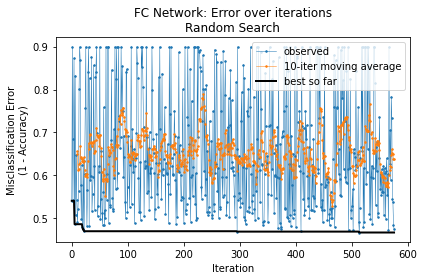

In [29]:
# convergence plot, RS
accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("FC Network: Error over iterations\nRandom Search")
plt.legend()
plt.tight_layout()

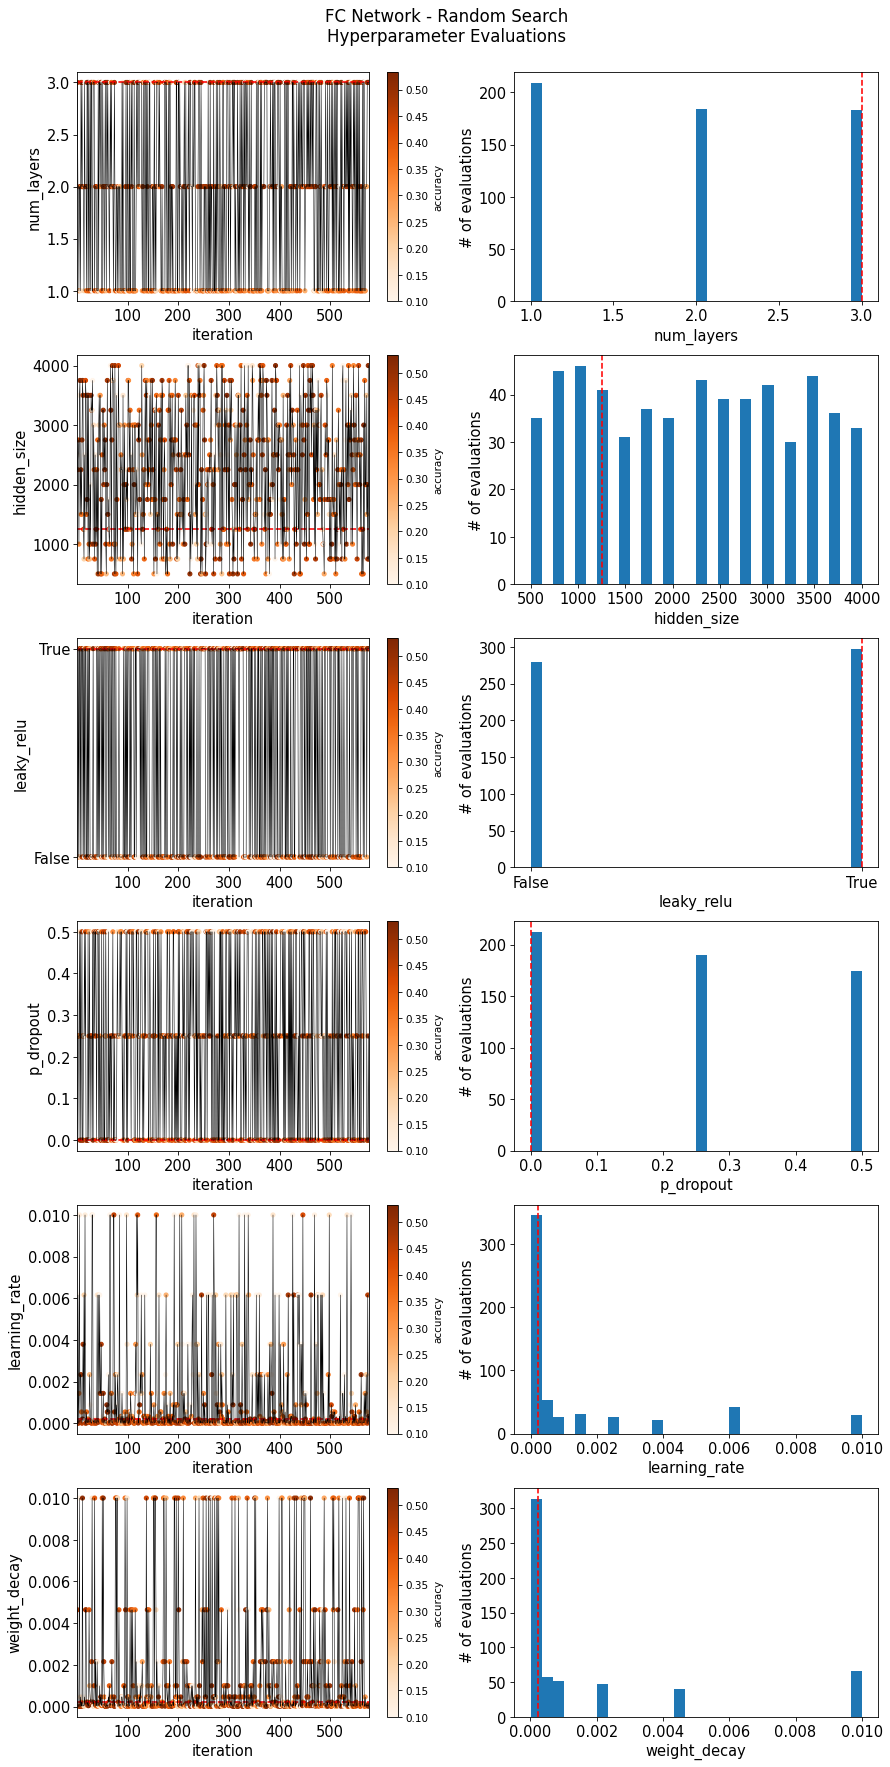

In [30]:
accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs


params = rs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in rs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = rs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("FC Network - Random Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.95])

# Bayesian Search

In [31]:
bs_hyperparameters = {
     'num_layers': Integer(1, 3), 
     'hidden_size': Integer(500, 4000), 
     'leaky_relu': Categorical([False, True]),
     'p_dropout': Categorical([0.5, 0.25, 0.0]),  # 0 = same as no dropout
     'learning_rate': Real(1e-6, 1e-2, prior='log-uniform'), 
     'weight_decay': Real(1e-5, 1e-2, prior='log-uniform')
}

N_EVALS = 576  # same number as were used in grid search

In [32]:
def cb_print(result):
    ## to be called by BayesSearchCV fit() to print out each iteration
    
    # save progress at each iteration in case of error
    skopt.dump(result, 'tmp_bayes_result_{}.pkl'.format(datetime.now().strftime("%Y%m%d")))
    
    def stringify_params(params):
        # to take the list of hyperparameter values and get a dictionary back out
        params = point_asdict(bs_hyperparameters, params)
        return ', '.join([f'{k}={v}' if type(v) != str else f'{k}="{v}"' \
                          for k, v in params.items()])
    
    score = -(result.func_vals[-1])
    params = stringify_params(result.x_iters[-1])

    # argmin because the values are negative during search
    best_score_pos = np.argmin(result.func_vals)
    
    num_tried = len(result.func_vals)
    N = result.specs['args']['n_initial_points']

    the_time = datetime.now().strftime("%H:%M:%S")
    if best_score_pos == (num_tried - 1):
        print(f'***New best! [{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})\n')
    else:
        print(f'[{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})')
        best_params = stringify_params(result.x_iters[best_score_pos])
        print('    Best accuracy = {} ({})\n'.format(-result.func_vals[best_score_pos], best_params))

In [33]:
np.random.seed(682)
clf = FCNetClassifier(n_epochs=N_EPOCHS, loader_val=loader_val)

print('\n--------------------------------------\nBeginning Bayes search at {}...'.format(datetime.now().strftime('%H:%M:%S')))

bayes = BayesSearchCV(
    estimator = clf,
    search_spaces = bs_hyperparameters,
    scoring=_custom_scorer,
    cv = presplit,
    n_jobs = 1,
    n_iter = N_EVALS,
    refit = False,
    random_state = 682
)

early_stopper = DeltaYStopper(0.0001)
timercb = TimerCallback()
bayes_result = bayes.fit(x_train_full, y_train_full, callback=[timercb, cb_print, early_stopper])

the_time = datetime.now().strftime('%Y%m%d_%H%M%S')
skopt.dump(bayes_result, f'fcnet_bayes_result_{the_time}.pkl')

with open(f'fcnet_bayes_timercb_{the_time}.pkl', 'wb') as f:
    pickle.dump(timercb, f)

scores = bayes_result.cv_results_['mean_test_score']
param_keys = [x for x in bayes_result.cv_results_.keys() if 'param_' in x]
tmp = [bayes_result.cv_results_[x] for x in param_keys] + [scores]
tmp = list(map(list, zip(*tmp)))
tmp = [dict(zip(param_keys + ['mean_test_score'], x)) for x in tmp]
print(pd.DataFrame(tmp))

print('Finished with Bayes search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))

Streaming output truncated to the last 5000 lines.
        Epoch 2, iteration 400: loss = 1.3417259454727173, accuracy = 50.22%
        Epoch 2, iteration 600: loss = 1.1505451202392578, accuracy = 51.62%
        End of Epoch 2: accuracy = 50.91%
        Epoch 3, iteration 1: loss = 1.4566290378570557, accuracy = 50.99%
        Epoch 3, iteration 200: loss = 1.3832403421401978, accuracy = 52.66%
        Epoch 3, iteration 400: loss = 1.1698673963546753, accuracy = 52.36%
        Epoch 3, iteration 600: loss = 1.1167975664138794, accuracy = 52.77%
        End of Epoch 3: accuracy = 50.4%
[19:23:26] (Iter 340) Accuracy = 0.504 (hidden_size=3401, leaky_relu=True, learning_rate=6.584412663816672e-05, num_layers=3, p_dropout=0.0, weight_decay=1e-05)
    Best accuracy = 0.5458 (hidden_size=3378, leaky_relu=True, learning_rate=6.577122661719286e-05, num_layers=3, p_dropout=0.0, weight_decay=1e-05)


------------
    Beginning training loop with params = {'batch_size': 64, 'hidden_size': 3382,

## Bayesian Plots

In [34]:
bayes_result.best_params_

OrderedDict([('hidden_size', 3294),
             ('leaky_relu', True),
             ('learning_rate', 7.05591695673887e-05),
             ('num_layers', 3),
             ('p_dropout', 0.0),
             ('weight_decay', 1e-05)])

In [35]:
bayes_result.best_score_

0.5495

In [18]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

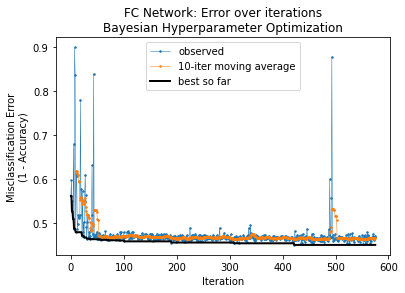

In [37]:
# convergence plot
accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("FC Network: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend()

Text(0.5, 1.0, 'FC Network Runtime\nModel vs. Bayesian Search Contribution')

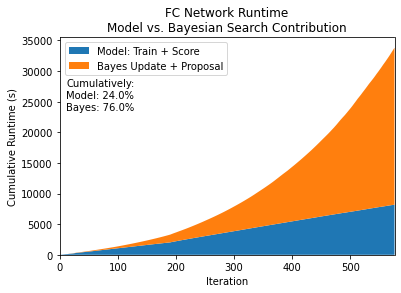

In [38]:
#### runtime plot: model vs. bayesian

plt.close('all')
model_times = np.array(bayes_result.cv_results_['mean_fit_time']) + \
              np.array(bayes_result.cv_results_['mean_score_time']) 
total_times = np.array(timercb.iter_time)
bayes_times = total_times - model_times

cumul_totaltime = total_times.cumsum()
cumul_modeltime = model_times.cumsum()
cumul_bayestime = bayes_times.cumsum()

bayes_frac = cumul_bayestime[-1]/cumul_totaltime[-1]
model_frac = cumul_modeltime[-1]/cumul_totaltime[-1]

plt.stackplot(range(0, len(model_times) + 1), [0, *cumul_modeltime], [0, *cumul_bayestime], 
              labels=['Model: Train + Score', 'Bayes Update + Proposal'])
plt.legend(loc='upper left')
plt.xlim((0, len(model_times)))
plt.xlabel('Iteration')
plt.ylabel('Cumulative Runtime (s)')
plt.annotate('Cumulatively:\nModel: {}%\nBayes: {}%'.format(round(model_frac * 100), round(bayes_frac * 100)), 
             (0.02*len(model_times), 0.7*cumul_totaltime[-1]))
plt.title('FC Network Runtime\nModel vs. Bayesian Search Contribution')

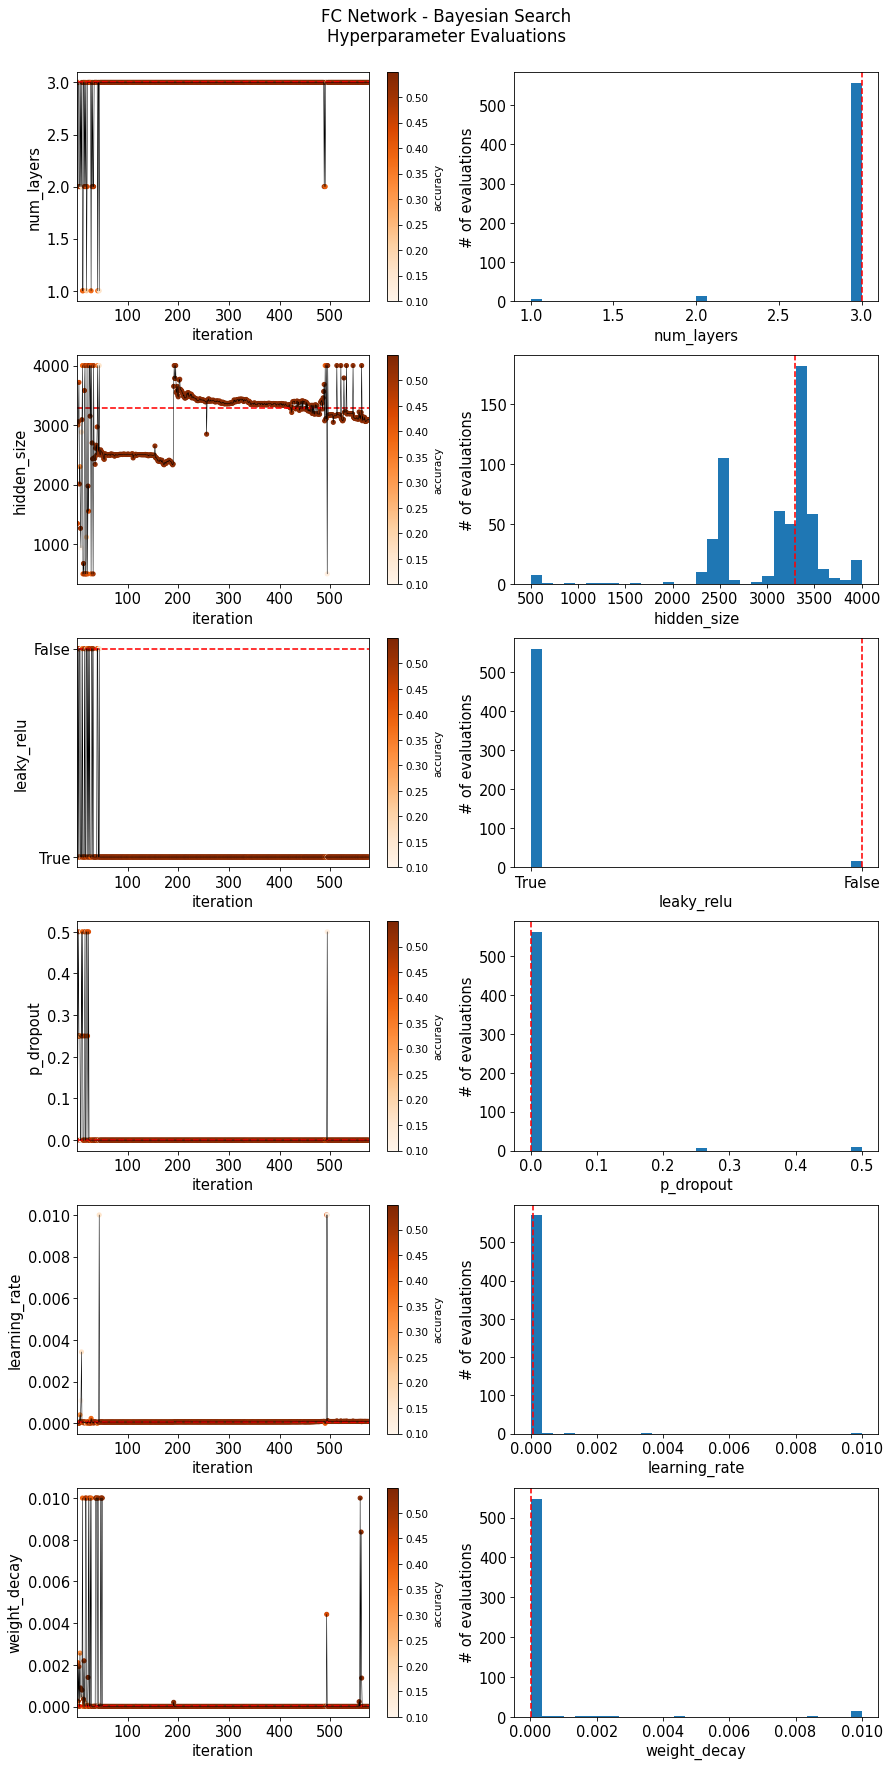

In [39]:
accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs


params = bayes_result.search_spaces.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = bayes_result.cv_results_[f'param_{param}']
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = bayes_result.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("FC Network - Bayesian Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.95])


# Combined Plots

In [16]:
############################ 
# If re-running this later, or if your connection failed, re-import the results for subsequent plots
############################ 

with open('fcnet_gs_results_20201213_151504.pkl', 'rb') as f:
    gs_results = pickle.load(f)
with open('fcnet_gs_20201213_151504.pkl', 'rb') as f:
    gs = pickle.load(f)

with open('fcnet_rs_results_20201213_163356.pkl', 'rb') as f:
    rs_results = pickle.load(f)
with open('fcnet_rs_20201213_163356.pkl', 'rb') as f:
    rs = pickle.load(f)

bayes_result = skopt.load('fcnet_bayes_result_20201214_015733.pkl')

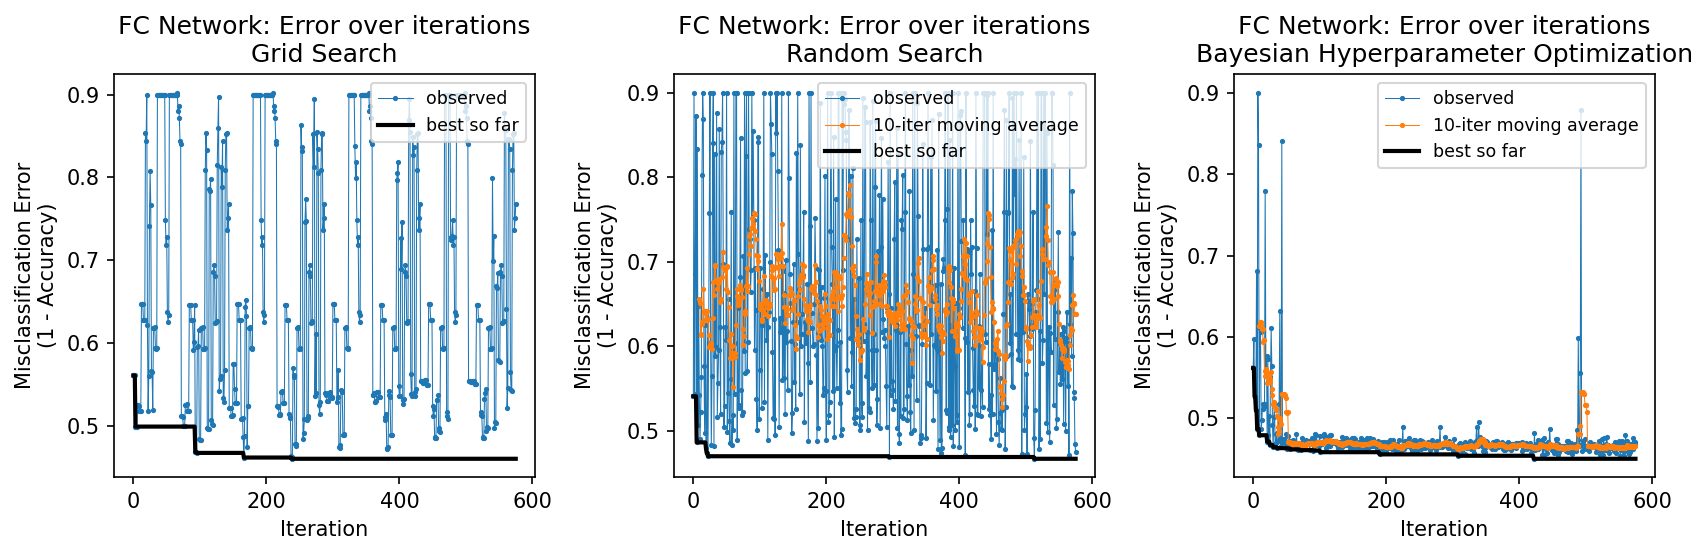

In [19]:
plt.close('all')
plt.figure(figsize=(12, 4), dpi=150)


####### convergence plot, GS
plt.subplot(1, 3, 1)

accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("FC Network: Error over iterations\nGrid Search")
plt.legend(loc='upper right', fontsize='small')
#plt.ylim((.28, .55))


####### convergence plot, RS
plt.subplot(1, 3, 2)

accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("FC Network: Error over iterations\nRandom Search")
plt.legend(loc='upper right', fontsize='small')
#plt.ylim((.28, .55))


####### convergence plot, Bayesian
plt.subplot(1, 3, 3)

accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("FC Network: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend(loc='upper right', fontsize='small')
#plt.ylim((.28, .55))


plt.tight_layout(rect=[0, 0.0, .96, 0.95])

# Get CSVs + best model summaries

In [20]:
print('\nGrid search best model:')
best = max(gs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Grid search best model:
    Score = 0.54
    hidden_size = 2000
    leaky_relu = True
    learning_rate = 0.0001
    num_layers = 3
    p_dropout = 0
    weight_decay = 0.001


In [21]:
print('\nRandom search best model:')
best = max(rs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Random search best model:
    Score = 0.5334
    hidden_size = 1250
    leaky_relu = True
    learning_rate = 0.00020691380811147902
    num_layers = 3
    p_dropout = 0.0
    weight_decay = 0.00021544346900318823


In [22]:
print('\nBayes search best model:')
print('    Score = {}'.format(bayes_result.best_score_))
for param in sorted(bayes_result.best_params_.keys()):
    print('    {} = {}'.format(param, bayes_result.best_params_[param]))


Bayes search best model:
    Score = 0.5495
    hidden_size = 3294
    leaky_relu = True
    learning_rate = 7.05591695673887e-05
    num_layers = 3
    p_dropout = 0.0
    weight_decay = 1e-05


In [23]:
df_results = pd.DataFrame()
for res in gs_results:
    row = {'search_type': 'grid', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [24]:
for res in rs_results:
    row = {'search_type': 'random', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [25]:
for i, cv_score in enumerate(bayes_result.cv_results_['mean_test_score']):
    row = {'search_type': 'bayes', 'accuracy': cv_score}
    for param in bayes_result.search_spaces.keys():
        row[param] = bayes_result.cv_results_['param_' + param][i]
    df_results = df_results.append(row, ignore_index=True)

In [26]:
df_results.to_csv('fcnet_results_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)